## Project Development NB.
## Text-to-pose experiments with humanML3D data.
#### (Author: Joel markapudi.)


- Note: This notebook has extensive theory, implementation analysis-writings, study, result explanations, intuition-reasoning before coding cells, algorithmic idea recaps, etc. The text will seem verbose but is really essential because the whole pipeline is a very large chunk of codes and classes.


## CONTENTS:

#### 1. Simple display script (load and check prev-created npy file.)
#### 2. Config file details for environment.
#### 3. HumanML3DDataset and Dataset Process Class ( Core Dataset Modification, Data Selection, Prep. )
#### 4. EDA-Recap from Notebook 1 of the project. ( EDA, Saved Clusters NPY file, Clustering Approach Reason. )
#### 5. CLIP + Projection Layer ( Why its needed, Result-Analysis of CLIP. )
#### 6. CLIP layer validation using PCA ( Visualize, Explain Variance. )
#### 7. Iteration 1 Code: UNet, Diffusion Trainer, Custom NoiseScheduler Implementation, Time Embedding, etc.
#### 8. Iteration 2 Code: Algorithmic fixes, New concepts ( Reference Anatomy Repository, Better temporal Signals, Multi-Stage Anatomy Enforcement - 3+ enforcement techniques , EpochWise Diagnostic print data, Controlled randomization, Tanh-bounded output projection. )
#### 9. Iteration 3 Code: Fundamental Change. Unconditioned diffusion concept of Iter2 mixed with CLIP + Projection. ( Cross-attention module, U-Net modification, Conditional Generation on Diffusion Trainer. )


### Please check the ReadMe file in submission:


- It explains the yml, setup-process, paths, the code's epoch-wise saving facility and more.
- We save the 'strategic' dataset dictionary, which takes over 2000-2500s to create, we also save model checkpoint, clip encoder etc. - which proves to save lot of time.
- It is recommended to understand the pathing pattern or logic we have set inplace there.

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Recap on the NPY file, EDA, clustering.

- In phase 0, we had tons of stat analysis, data format analysis and EDA!
- In notebook 1, clustering process was developed to address the imbalance in pose distribution within the HumanML3D dataset.
- It is for data selection and observation, we have distinct "pose categories".
- You could strategically **sample training data** to ensure the model learns across the chosen spectrum of human poses, you can experiment, make fast runs, etc.
- (nearly 50% of poses belonged to a single dominant cluster).

### process: 
- **Reduction** - began with dimensionality reduction of the high-dimensional pose data (66 dimensions representing 22 joints with XYZ coordinates). PCA was initially applied, achieving 57.71% explained variance with just two dimensions, followed by t-SNE to better preserve local relationships between poses, creating more distinct "islands" of similar poses.
- **Clustering** - based on the reduced-dimension representation, a clustering algorithm k-means, applied to identify distinct pose categories.
- We chose, 10 primary clusters with highly uneven distribution - the largest cluster contained 38.77% of poses while the smallest contained only 0.77%.
- **Clustering was validated** through various statistical measures, including intra-cluster distance, variance analysis of joints, and correlation between pose clusters and associated text descriptions.
- And, file "clusters.npy" stored these cluster assignments.


-------------------------------------------------------------------------------

- dimensional analysis of both text descriptions and pose clusters is important. we want to learn about body parts, spatial relationships, action understanding, and global pose context.
- the **Implementation Impact** for us, is that, atleast some closeness and powerful design for mapping between CLIP's semantic text embeddings and the geometric structure of human poses.


## Simple display script (load and check npy file.)

In [1]:
# from datasets import load_dataset
# humanml3d = load_dataset("TeoGchx/HumanML3D")
# print(humanml3d.keys())
# ---------------------------------------------


import os
from datasets import load_dataset

custom_cache_dir = r"D:\JoelDesktop folds_24\NEU SPRING25 - DL, HCI\Projects\Text-To-Pose Project\data"
os.environ["HF_DATASETS_CACHE"] = custom_cache_dir
os.makedirs(custom_cache_dir, exist_ok=True)

humanml3d = load_dataset("TeoGchx/HumanML3D", cache_dir=custom_cache_dir)
print(humanml3d.keys())

print("\n")
print("Dataset splits:", humanml3d.keys())
print("Train examples:", len(humanml3d["train"]))
print("Validation examples:", len(humanml3d["val"]))
print("Test examples:", len(humanml3d["test"]))

# data_path for use with the processor
data_path = custom_cache_dir
print("\n\n")

## ---------------------------------------------------------------------------------------------------------------------------------
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

# path to saved clusters.npy file
clusters_path = r"D:\JoelDesktop folds_24\NEU SPRING25 - DL, HCI\Projects\Text-To-Pose Project\pose_diversity_results\clusters.npy"



try:
    clusters = np.load(clusters_path)
    print(f"Successfully loaded cluster assignments with shape: {clusters.shape}")
    print(f"Data type: {clusters.dtype}")
except FileNotFoundError:
    print(f"File not found: {clusters_path}")
    print("Please provide the correct path to your clusters.npy file")
    clusters = None

if clusters is not None:
    custom_cache_dir = r"D:\JoelDesktop folds_24\NEU SPRING25 - DL, HCI\Projects\Text-To-Pose Project\data"
    print("Loading HumanML3D dataset to get pose descriptions...")
    humanml3d = load_dataset("TeoGchx/HumanML3D", cache_dir=custom_cache_dir)
    
    # count poses per cluster
    unique_clusters, counts = np.unique(clusters, return_counts=True)
    
    print("\nCluster Distribution:")
    for cluster, count in zip(unique_clusters, counts):
        print(f"Cluster {cluster}: {count} poses ({count/len(clusters)*100:.2f}%)")


dict_keys(['train', 'val', 'test'])


Dataset splits: dict_keys(['train', 'val', 'test'])
Train examples: 23384
Validation examples: 1460
Test examples: 4384



Successfully loaded cluster assignments with shape: (23384,)
Data type: int32
Loading HumanML3D dataset to get pose descriptions...

Cluster Distribution:
Cluster 0: 9065 poses (38.77%)
Cluster 1: 954 poses (4.08%)
Cluster 2: 299 poses (1.28%)
Cluster 3: 497 poses (2.13%)
Cluster 4: 3632 poses (15.53%)
Cluster 5: 2427 poses (10.38%)
Cluster 6: 2206 poses (9.43%)
Cluster 7: 1425 poses (6.09%)
Cluster 8: 2465 poses (10.54%)
Cluster 9: 414 poses (1.77%)


## HumanML3DDataset and dataset processor.

- Dataset Focus on Motion: HumanML3D typically pairs each motion clip (multiple frames) with a textual description of the entire action or scenario. It was not originally intended for a single-frame pose.
- Captions Summarize Multiple Subactions: examples include “he then… after that… does a bow and arrow… pumps fist again” – obviously describing multiple pose transitions.
- HumanML3D’s multi-sentence text is describing entire sequences, not truly single static pose usage. But, we are *strictly modifying the dataset*, picking something unique and powerful from within! a subset, first 66 dimensions (joints), and single action-description of first-frame for the best, accurate textual conditioning! **(first frame action = should match first action-verb in the large sentence.)**

-----------------------------------------------------------------------------------------------

- Extracting only the first sentence from each description before the first action verb. Short, Single action Concept.
- Selecting the corresponding first frame from each motion sequence.

```
--> Applying intelligent filtering to ensure text-pose relevance
    ## Guidance on picking first action, first sentence. 
    Extracts the POS-tagged version of the text
    Finds the first conjunction (CCONJ) or subordinating conjunction (SCONJ) in the POS tags
    Also looks for specific adverbs like "then", "after", "before" that typically indicate sequence
    Truncates the text at that point to get only the first action
    Falls back to the first sentence if no conjunction is found
    Applies a minimal word count filter (minimum 3 words)
```
-----------------------------------------------------------------------------------------------
- Why first sentence?
    - First sentences in HumanML3D typically describe the initial pose/stance. self-contained and don't reference later movements.
- Why first frame?
    - The first frame typically corresponds to the initial pose described. It provides alignment between text and pose.
    - It avoids mid-motion frames that might be transitional/undefined
    - For static pose generation, this creates cleaner training examples
- Therefore, we pick the first action and also, the first action-verb related sentence, cut off before the first conjunction.
```
"a person picks something up and then paces back..." → "a person picks something up"
"a person raises their hand up and down before..." → "a person raises their hand up"
```
-----------------------------------------------------------------------------------------------
- gives us much tighter alignment between the text (describing just the first action) and the first frame (showing just that initial pose).

-----------------------------------------------------------------------------------------------

## Here is the overall algorithmic flow of the class:
- parameters:
- hf_dataset: HuggingFace dataset object containing motion and text data
- clusters_path: Path to pre-computed cluster assignments (NPY file)
- use_position_only: Boolean flag to use only position data (first 66 dimensions)
- frame_selection: representative frame ('first', 'middle', 'last', 'random')
-----------------------------------------------------------------------------------------------
- Dynamic Field Detection: The processor can adaptively detect motion and text fields in varied dataset formats.
- Cluster-Based Sampling Efficiency: Creates a lookup table (cluster_to_poses) mapping cluster IDs to pose indices. Precise control over classes.
- POS-Tag Based Text Filtering: Uses part-of-speech tags to identify **action boundaries**, **Isolates first action** for static pose generation, improving text-pose alignment.
- Configurable Normalization Strategies:
```
    'center_scale': Preserves anatomical proportions by scaling based on maximum distance from root. [ by maintaining relative joint relationships while ensuring consistent scale, crucial for models to learn proper skeletal structure. ]
    'minmax': Maps to fixed range [-1, 1] / consistent bounds
    'standard': Z-score normalization / feature uniformity
    'center': Translation without scaling
```
-----------------------------------------------------------------------------------------------
Algorthim write ups for pose methods, dataset sampling, static filtering methods ( some of the core concepts. )

- **extract_pose:**
    Extracts single frame from motion sequence based on selection strategy (first/middle/last/random), reshapes to flat vector [66], optionally filters for position-only data when working with full 263-dimensional vectors.
- **normalize_pose:**
    Implements multiple normalization strategies: 'center_scale' centers joints around pelvis and scales by approximate height, 'minmax' maps to range [-1,1], 'standard' applies Z-score normalization, 'center' translates without scaling.
- **create_strategically_sampled_dataset:**
    Constructs balanced dataset by sampling specific counts from each pose cluster, falls back to random sampling without clusters, processes selected data through process_batch(), optionally filters for static poses.
- **_filter_for_static_poses:**
    Analyzes text using POS tags to identify first action in sequences, extracts text before conjunctions/transition markers, filters out descriptions with fewer than 3 words, creates dataset with single-action texts aligned to poses.
- **process_batch:**
    Adaptively extracts motion and text from varied dataset formats, applies frame extraction and normalization, handles different motion representations (joint coordinates vs. full representation), returns processed arrays.
  
-----------------------------------------------------------------------------------------------
## Towards the ending of the code, the increased, powerful sampling config looks like this:
  ```
    # Create improved sampling configuration - increased to 20k samples
    sampling_config = {
        0: 8500,   # Most common poses (38.8% of dataset) - strong foundation
        5: 2400,   # Medium-frequency distinctive poses (10.4%)
        8: 2400,   # Another medium-frequency cluster (10.5%)
        4: 3000,   # Common poses (15.5%)
        6: 1500,   # Medium-frequency cluster (9.4%)
        1: 500,    # Less common but important (4.1%)
    }
  ```


### Core skeleton-foundational logic:
- skeletal structure code:                                           
    ```
    Joints 0 (pelvis) as the root node
    Connections from pelvis to spine (0→1→2→3→4)
    Left arm chain (0→5→6→7→8)
    Right arm chain (0→9→10→11→12)
    Additional hand joints (11→[14,15,16,17] and 11→[18,19,20,21])
    Left leg chain (0→13→14→15→16)
    Right leg chain (0→17→18→19→20)
    ```
- structure aligns with HumanML3D's documentation as outlined in the paper "Human Motion Diffusion Model" by Guo et al.
- ax.scatter() creates blue spheres at each joint position, with the first pose index representing the joint number and the second representing the dimension.
- for-loop with ax.plot(): Taking each tuple from the skeleton list, Drawing a line from joint 0's coordinates to joint 1's, Repeating (x, y, z).
- mid_x/y/z center point of each dimension, use aspect ratios logic building - pose appears with anatomically correct proportions. viewing box adapts.

----------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------

### !! Skeleton plotting has been attempted 2, 3 times for an improvement.
#### below, is again refined approach adding -> fixed viewpoint, skeletal connection tuple list for plotting, checking outlier joints, labelling main body parts for clarity, 
- HumanML3D inherits the SMPL coordinate frame: +Y points “up” (gravity ⇩ = ‑Y), +Z points “forward”, +X points the model’s left.
- HumanML3D already stores poses in the classical computer‑graphics axis order X (right) – Y (forward) – Z (up) (AMASS/SMPL default).
- however, (some results on improved code) is drawing +Z as the vertical axis (because pass pose[:,2] to ax.plot(..., z)), so any pose that the dataset considers “sitting” (large negative Y for the hips and hands, small/positive Y for the feet) is rendered with the vertical axis flipped.

----------------------------------------------------------------------------------------------------------------------------------------------
- Z is up, Y is forward, X is left ↔ right – **this is SMPL’s Y‑up / Z‑fwd convention.**
- ( Y‑axis = “subject is looking / walking forward”, Z‑axis = “up”, X‑axis = “subject’s left ↔ right”. )
- HumanML3D is canonicalised: **every pose is rotated so the subject faces +Y and the left side is toward +X.**
- skeleton: matches the 22‑joint SMPL subset used by HumanML3D and by recent papers such as MDM, STMC, TMR, etc. ✔️
- dataset’s canonical left‑bias.
- **apparent hip asymmetry is just a consequence of the dataset’s “always face +Y, left side = +X” rule.** ,
- for training and evaluation, should root‑centre (and optionally mirror) to remove that visual bias.
- **canonicalisation:** you strip away the scene’s facing direction so all poses live in the same global orientation.

```
            +Z  (up)
             │
             │   head
             │  /
             │ /
 –X  <────── root ──────>  +X    (left hip)
 right side          left side
             ↑ +Y  (forward)
```
----------------------------------------------------------------------------------------------------------------------------------------------
- root‑centring (sometimes called “pelvis‑centric” or “local” coordinates) is simply: pose_local = pose_global  –  pelvis_position.
- All joints are re‑expressed relative to the pelvis, so the pelvis itself is fixed at the origin (0,0,0).
- ` pose[:, :3] -= pose[:, pelvis_idx*3 : pelvis_idx*3+3]   # subtract root xyz `, this has to be followed.. (to revise.)
- only add the root back when we need a world‑space reconstruction.
### Model itself is already learning root‑centred poses !! ( normalize_pose(..., method='center_scale') subtracts the pelvis.

----------------------------------------------------------------------------------------------------------------------------------------------
- HumanML3D/AMASS stores poses in normalised SMPL units – the whole body is ~1.4–1.5 units tall, not 1 metre.
- “Left‑hip sits at +0.89” even after root‑centering: 0.89 units ≈ 0.89 / 1.45 ≈ 0.60 m on a 1.90 m person. half‑pelvis span.
- Hip sometimes looks “way out” or “collapsed in” across frames.
      - mid‑stride → pelvis is on the stance leg, swing hip can stick 20–30 cm out
      - crouch → spine joints drop below pelvis
      - golf drive → hips rotate, one hip pushes far laterally
- real humans in side‑step / lunge easily shift CoM >30 cm, so 0.54 m lateral hip is reasonable.
- Spine3 / pelvis appear below the ground plane in a few plots:
      - After subtract the pelvis and then call dataset_to_view(...) .. flip into a viewer‑friendly Z‑up frame.
      - grey “ground” plane in the helper was hard‑coded at Z = 0. subject is squatting, the pelvis is below the head‑centred average zero


----------------------------------------------------------------------------------------------------------------------------------------------
#### Recap information on failed attempts, experiments.
- dataset_to_view ( pose @ R.T concept,  90° rotation about the X-axis will convert from dataset coordinates to proper viewing coordinates. )
- added, Rx (‑90°) plus optional Rz (180°) via face_viewer flag. 
- get_canonical_skeleton, get_canonical_joint_labels, etc.
- directional arrow concept: anchored on a stable spine vector,  clearer orientation indicator
- pelvis-to-neck vector represents the core body orientation, far less likely to change dramatically between poses, provides a more intuitive sense of facing.
- some of last implementation ideas using Rx were wrong. ( throw the genuine up‑axis (Z) down into Y, and the true forward‑axis (Y) up into Z. )
- result is a body that lies flat on the ground plane you draw at Z = 0. (we wont want this.)

----------------------------------------------------------------------------------------------------------------------------------------------
#### Some important logic/core technical work to remember:
- .append() which would add the entire list as a single element,         # [1, 2, 3, [4, 5, 6]] 
- .extend() adds each individual element, maintaining a flat list of indices. we want flat list.     # [1, 2, 3, 4, 5, 6]
- Dataset Dictionary: poses, texts, indices, cluster_config. 
    actual pose data (joint positions) used for model training.
    text descriptions corresponding to each pose, enabling text-to-pose conditioning.                                        
    indices, original indices from the full dataset.
    stores the sampling configuration used to create the dataset.


Loading HumanML3D dataset...
Dataset loaded with splits: dict_keys(['train', 'val', 'test'])
Successfully loaded cluster assignments with shape: (23384,)

Cluster Distribution:
Cluster 0: 9065 poses (38.77%)
Cluster 1: 954 poses (4.08%)
Cluster 2: 299 poses (1.28%)
Cluster 3: 497 poses (2.13%)
Cluster 4: 3632 poses (15.53%)
Cluster 5: 2427 poses (10.38%)
Cluster 6: 2206 poses (9.43%)
Cluster 7: 1425 poses (6.09%)
Cluster 8: 2465 poses (10.54%)
Cluster 9: 414 poses (1.77%)

Created mapping for 10 clusters
Loading HumanML3D train data...

Strategic sampling config:
  Cluster 0: 800 samples
  Cluster 4: 500 samples
  Cluster 5: 500 samples
  Cluster 8: 500 samples
  Cluster 7: 300 samples
  Cluster 1: 300 samples

Static Pose Filtering Results:
Original samples: 2900
Filtered samples: 2847 (98.2%)

Rejection Reasons:
  Too few words (<3): 53
  No POS tags: 0
  Accepted: 2847

Strategically sampled dataset statistics:
Total poses: 2847

(Original, Before Filters) Actual cluster distributio

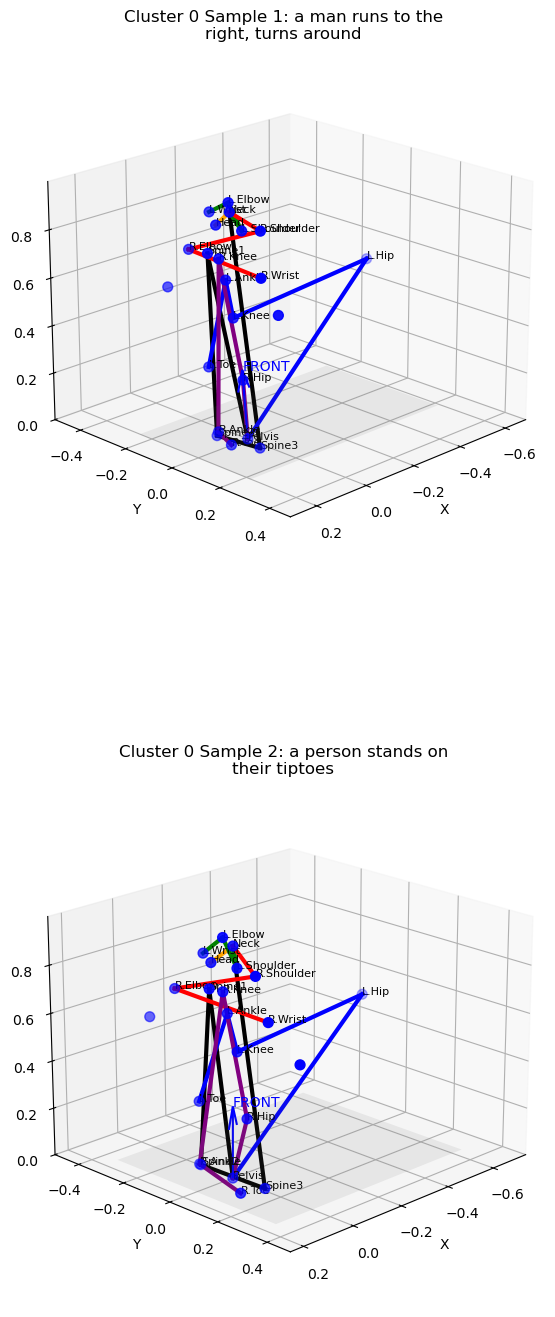


Cluster 4: 491 samples available


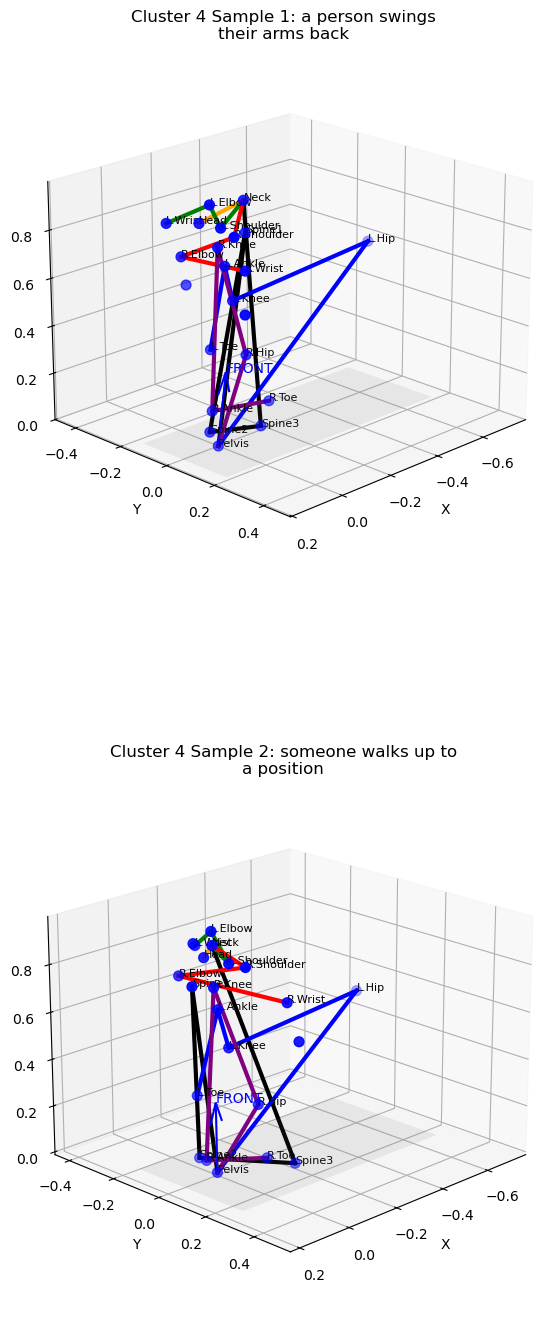


Cluster 5: 487 samples available


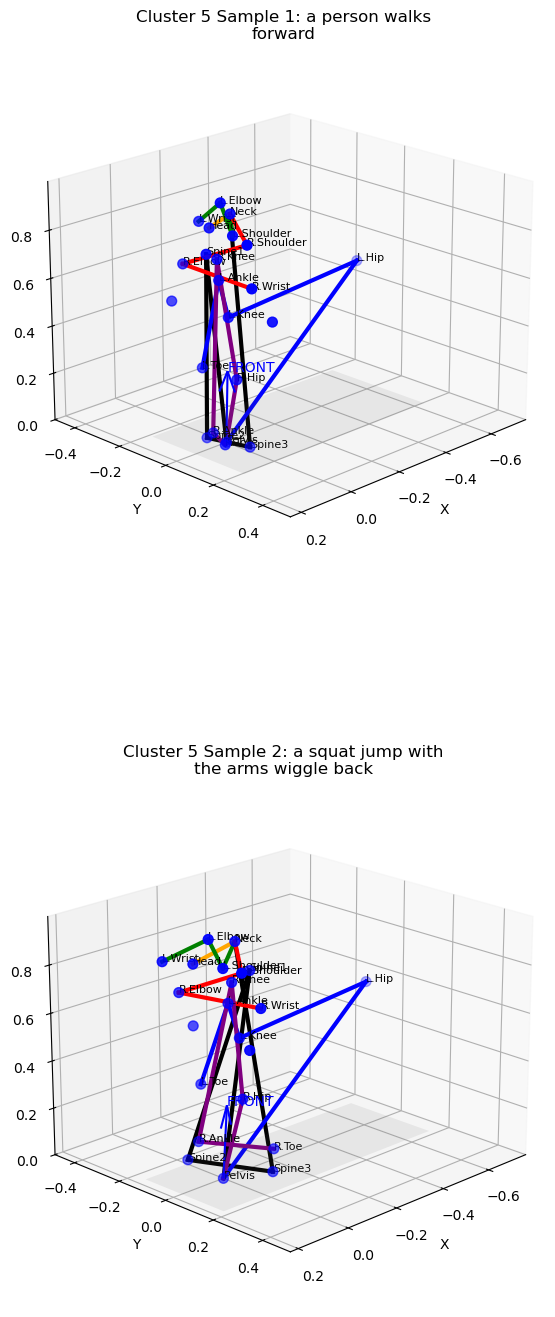


Cluster 8: 494 samples available


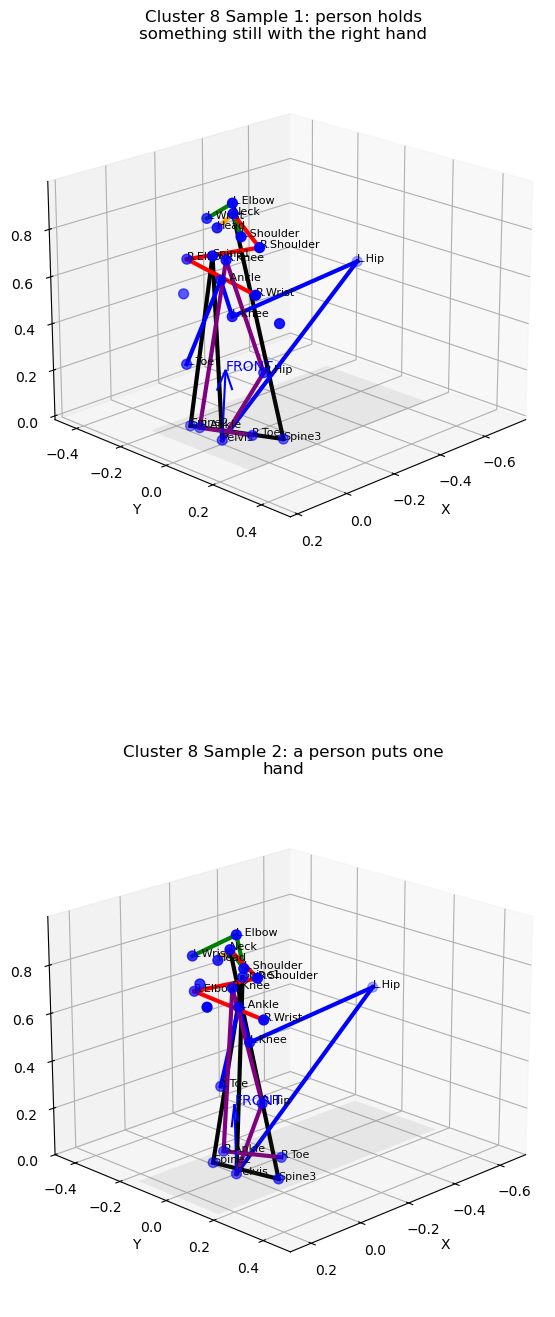


Cluster 7: 295 samples available


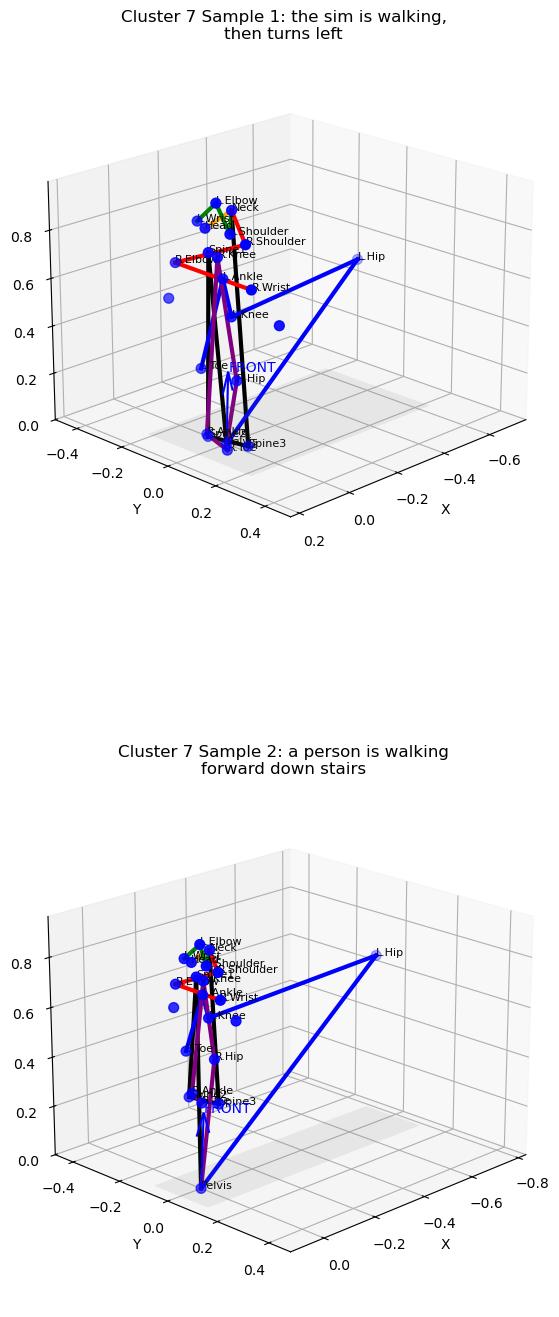


Cluster 1: 295 samples available


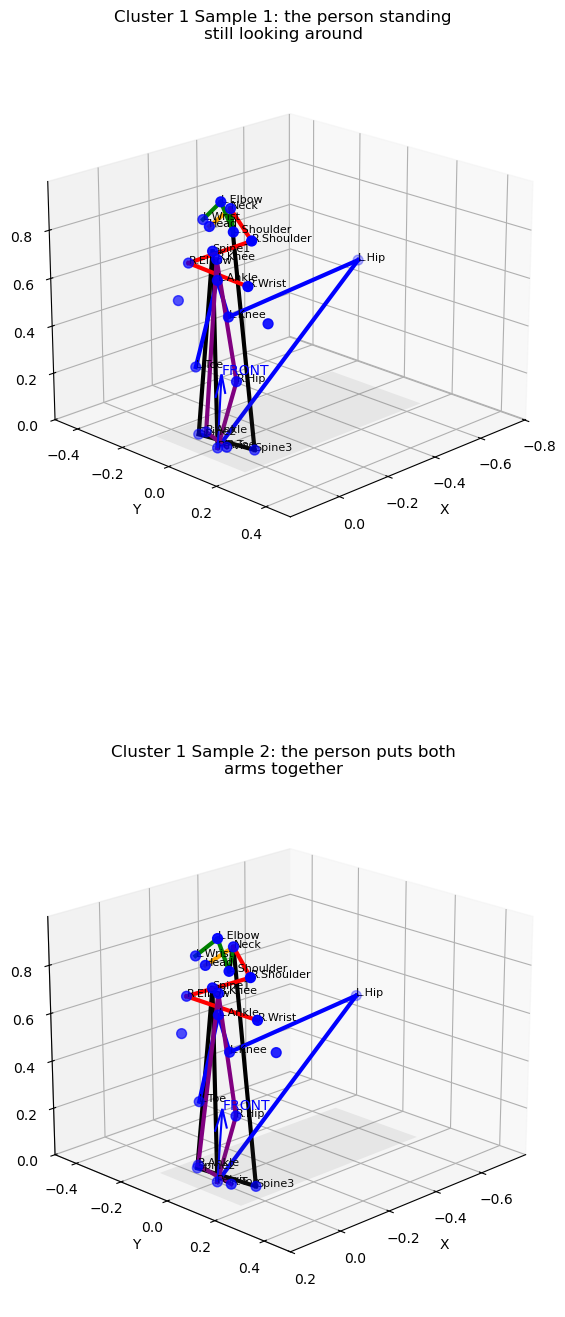


Data preprocessing pipeline complete! Whew. :)


In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datasets import load_dataset
from typing import Iterable


class HumanML3DDataset(Dataset):
    """PyTorch dataset for HumanML3D data"""
    
    def __init__(self, poses, texts, indices=None):
        self.poses = poses
        self.texts = texts       # should already be the filtered texts from _filter_for_static_poses().
        self.indices = indices if indices is not None else list(range(len(poses)))

        # -> older logic, to clean up. // # self.cleaned_texts = [text.split('#')[0].strip() if '#' in text else text for text in texts]
        self.cleaned_texts = self.texts

    def __len__(self):
        return len(self.poses)
    
    def __getitem__(self, idx):
        return {
            'pose': self.poses[idx],
            'text': self.texts[idx],
            'cleaned_text': self.cleaned_texts[idx],
            'orig_idx': self.indices[idx]
        }



## --------------------------------------------------------------------------------------------------------------------------------------------
## helpers;

def extract_first_sentence(text):
    """Extract the first sentence from text description"""
    # Remove POS tagging
    if '#' in text:
        text = text.split('#')[0].strip()
    
    # Split by sentence boundaries
    sentences = re.split(r'[.!?]', text)
    first_sentence = sentences[0].strip() if sentences else text
    
    return first_sentence

"""
_filter_for_static_poses () --> takes a dataset dictionary as input and returns a new filtered dataset dictionary 
create_strategically_sampled_dataset method, it calls _filter_for_static_poses and uses its result
-> in the create_dataset function that uses all this, the dataset dictionary is passed to the HumanML3DDataset constructor
"""

## Call it with face_viewer=True only in visual code; 
## never feed the yaw‑rotated poses back into training.

def dataset_to_view(pose: np.ndarray,
                    face_viewer: bool = False) -> np.ndarray:
    """
    HumanML3D is already Z‑up, Y‑forward.  Optionally yaw 180° so
    the avatar faces the camera, but *do not* swap Y and Z.
    """
    pose = pose.reshape(-1, 3)

    if face_viewer:
        # 180° about the global Z axis
        Rz = np.array([[-1, 0, 0],
                       [ 0,-1, 0],
                       [ 0, 0, 1]], dtype=np.float32)
        pose = pose @ Rz.T          # yaw only

    return pose                     # identity otherwise



## a flatten helper first. 
def _flatten(edges: dict[str, Iterable[tuple[int,int]]]) -> list[tuple[int,int]]:
    """utility:  {'left_leg':[...], ...} -> [(0,1), …]"""
    return [pair for sub in edges.values() for pair in sub]


def get_canonical_skeleton():
    """
    Return the canonical skeleton joint connections following the correct HumanML3D convention.
    
    Returns:
        Dictionary of body parts and their joint connections
    """
    # Correct joint connections based on HumanML3D 22-joint structure
    LEFT_LEG = [(0, 1), (1, 2), (2, 3), (3, 4)]
    RIGHT_LEG = [(0, 5), (5, 6), (6, 7), (7, 8)]
    SPINE = [(0, 9), (9, 10), (10, 11), (11, 12)]
    HEAD = [(12, 13)]
    LEFT_ARM = [(12, 14), (14, 15), (15, 16)]
    RIGHT_ARM = [(12, 17), (17, 18), (18, 19)]
    
    return {
        'spine': SPINE,
        'head': HEAD,
        'left_arm': LEFT_ARM,
        'right_arm': RIGHT_ARM,
        'left_leg': LEFT_LEG,
        'right_leg': RIGHT_LEG
    }


def get_canonical_joint_labels():
    """
    Return the canonical joint labels for key points following the correct HumanML3D convention.
    
    Returns:
        Dictionary mapping joint indices to labels
    """
    return {
        0: "Pelvis",     # Root
        1: "L.Hip",
        2: "L.Knee",
        3: "L.Ankle",
        4: "L.Toe",
        5: "R.Hip",
        6: "R.Knee",
        7: "R.Ankle",
        8: "R.Toe",
        9: "Spine1", 
        10: "Spine2",
        11: "Spine3",
        12: "Neck",      
        13: "Head",      
        14: "L.Shoulder",
        15: "L.Elbow",
        16: "L.Wrist",   
        17: "R.Shoulder",
        18: "R.Elbow",
        19: "R.Wrist"    
    }

## --------------------------------------------------------------------------------------------------------------------------------------------
## --------------------------------------------------------------------------------------------------------------------------------------------
    

## Args for this class are pretty important. revise and remember. 
class HumanML3DProcessor:
    """HumanML3D dataset processor with cluster-based filtering"""
    
    def __init__(self, hf_dataset=None, 
                 clusters_path=None,
                 use_position_only=True,
                 frame_selection='first'):
        """
        Initialize the HumanML3D processor
        
        Args:
            hf_dataset: HuggingFace dataset object
            clusters_path: Path to the saved clusters.npy file
            use_position_only: Whether to use only position data (first 66 dims)
            frame_selection: Method to select a frame ('middle', 'first', 'last', 'random')
        """
        self.hf_dataset = hf_dataset
        self.clusters_path = clusters_path
        self.use_position_only = use_position_only
        self.pose_dim = 66 if use_position_only else 263
        self.frame_selection = frame_selection
        
        # HumanML3D skeleton for visualization - borrwed from the web. x. OUTDATED hard-code skeleton has been removed.
        # helper returns exactly the 20 bone pairs. 
        self.skeleton: list[tuple[int,int]] = _flatten(get_canonical_skeleton())

        # load cluster assignments if path is provided
        self.cluster_assignments = None
        if clusters_path is not None:
            self.load_cluster_assignments()
            
        # cluster to pose mapping for efficient filtering
        self.cluster_to_poses = self._create_cluster_mapping()

        # not using this approach. --- redoing.
        # self.target_clusters = [2, 5, 6] if target_clusters is None else target_clusters

            
    def create_cluster_sampling_config(self, preset='moderate'):
        """Create a sampling configuration based on preset difficulty level."""
        if preset == 'easy':
            return {
                0: 500,  # common poses
                5: 300,  # distinctive medium cluster
                8: 200,  # another distinctive cluster
            }
        elif preset == 'moderate':
            return {
                0: 800,  # dominant cluster
                4: 500,  # secondary cluster
                5: 500,  # secondary cluster
                8: 500,  # secondary cluster
                7: 300,  # minor cluster
                1: 300,  # minor cluster
            }

        elif preset == 'custom_1':
            return { 
                0: 2000,  # Most common poses (38.77% of dataset) - foundation
                5: 1200,  # Medium-frequency distinctive poses (10.38%) - good variation
                8: 1000,  # Another medium-frequency cluster (10.54%) 
                4: 800,   # Another common cluster (15.53%) 
                6: 600,   # Medium-frequency cluster (9.43%) 
                1: 300,   # Less common but still representative (4.08%) - challenge
                # Deliberately excluding rare clusters (2, 3, 7, 9) which are <3% each
            }


        elif preset == 'custom_2':
            return { 
                0: 8500,   # Most common poses (38.8% of dataset) - strong foundation
                5: 2400,   # Medium-frequency distinctive poses (10.4%)
                8: 2400,   # Another medium-frequency cluster (10.5%)
                4: 3000,   # Common poses (15.5%)
                6: 1500,   # Medium-frequency cluster (9.4%)
                1: 500,    # Less common but important (4.1%)
            }

        
        elif preset == 'custom':
            # custom sampling here ... just a template. 
            return {
                # cluster_id: sample_count
            }
        else:
            raise ValueError(f"Unknown preset: {preset}")
            


        
        
    def load_cluster_assignments(self):
        """Load the saved cluster assignments"""
        try:
            self.cluster_assignments = np.load(self.clusters_path)
            print(f"Successfully loaded cluster assignments with shape: {self.cluster_assignments.shape}")
            
            # Get distribution stats
            unique_clusters, counts = np.unique(self.cluster_assignments, return_counts=True)
            print("\nCluster Distribution:")
            for cluster, count in zip(unique_clusters, counts):
                print(f"Cluster {cluster}: {count} poses ({count/len(self.cluster_assignments)*100:.2f}%)")
                    
        except FileNotFoundError:
            print(f"Cluster file not found: {self.clusters_path}")
            self.cluster_assignments = None
        except Exception as e:
            print(f"Error loading cluster assignments: {str(e)}")
            self.cluster_assignments = None
            
    def _create_cluster_mapping(self):
        """Create mapping from cluster IDs to pose indices"""
        cluster_to_poses = {}
        
        if self.cluster_assignments is not None:
            unique_clusters = np.unique(self.cluster_assignments)
            
            for cluster_id in unique_clusters:
                indices = np.where(self.cluster_assignments == cluster_id)[0]
                cluster_to_poses[int(cluster_id)] = indices.tolist()
            
            print(f"\nCreated mapping for {len(unique_clusters)} clusters")
        else:
            print("No cluster assignments loaded. All poses will be used.")
            
        return cluster_to_poses

    
    def load_data(self, split='train'):
        """Load the raw HumanML3D data"""
        print(f"Loading HumanML3D {split} data...")
        
        if self.hf_dataset is None:
            raise ValueError("HuggingFace dataset not provided. Please initialize with a dataset.")
            
        return self.hf_dataset[split]



    ## --> for specific word-based tests, extraction and filtering. 
    # """
    # Extracts the POS-tagged version of the text
    # Finds the first conjunction (CCONJ) or subordinating conjunction (SCONJ) in the POS tags
    # Also looks for specific adverbs like "then", "after", "before" that typically indicate sequence
    # Truncates the text at that point to get only the first action
    # Falls back to the first sentence if no conjunction is found
    # Applies a minimal word count filter (minimum 3 words)
    # """
        
    def _filter_for_static_poses(self, dataset_dict):
        """
        Filter sampled dataset for static pose generation by extracting only the first action
        using POS tags to find conjunctions that separate actions.        
        """
        # Get original data
        poses = dataset_dict['poses']
        texts = dataset_dict['texts']
        indices = dataset_dict['indices']
        cluster_config = dataset_dict.get('cluster_config', {})
        
        # Get cluster assignments for reporting
        cluster_assignments = self.cluster_assignments[indices]
        
        # Prepare filtered data
        filtered_poses = []
        filtered_texts = []
        filtered_indices = []
        
        # Track statistics
        original_cluster_counts = {}
        filtered_cluster_counts = {}
        rejection_reasons = {
            'word_count_low': 0,
            'no_pos_tags': 0,
            'accepted': 0
        }
        
        for cluster_id in np.unique(cluster_assignments):
            original_cluster_counts[int(cluster_id)] = np.sum(cluster_assignments == cluster_id)
            filtered_cluster_counts[int(cluster_id)] = 0
        
        # Apply filtering
        import re
        for i, (pose, text, idx, cluster) in enumerate(zip(poses, texts, indices, cluster_assignments)):
            # Check for POS tags
            if '#' not in text:
                rejection_reasons['no_pos_tags'] += 1
                continue
                
            # Extract text before POS tagging
            clean_text = text.split('#')[0].strip()
            
            # Get the POS tagged version
            pos_parts = text.split('#')
            if len(pos_parts) > 1:
                pos_text = pos_parts[1].strip()
            else:
                rejection_reasons['no_pos_tags'] += 1
                continue
            
            # Find the first conjunction or adverb that likely indicates a new action
            # Common conjunctions/adverbs: and, then, after, before, while
            conjunction_matches = re.finditer(r'/CCONJ|/SCONJ|/ADV then|/ADV after|/ADV before', pos_text)
            
            try:
                # Get the first match if any
                first_match = next(conjunction_matches, None)
                
                if first_match:
                    # Find the corresponding position in the original text
                    pos_before_conj = pos_text[:first_match.start()].count(' ')
                    words = clean_text.split()
                    
                    # Extract text before the conjunction
                    first_action_text = ' '.join(words[:pos_before_conj])
                else:
                    # If no conjunction found, use the first sentence
                    sentences = re.split(r'[.!?]', clean_text)
                    first_action_text = sentences[0].strip() if sentences else clean_text
            except Exception as e:
                # Fallback: use first sentence if any error occurs
                sentences = re.split(r'[.!?]', clean_text)
                first_action_text = sentences[0].strip() if sentences else clean_text
            
            # Apply minimum word count filter
            words = first_action_text.split()
            if len(words) < 3:
                rejection_reasons['word_count_low'] += 1
                continue
            
            # All criteria passed, accept this sample
            filtered_poses.append(pose)
            filtered_texts.append(first_action_text)
            filtered_indices.append(idx)
            filtered_cluster_counts[int(cluster)] += 1
            rejection_reasons['accepted'] += 1
        
        # Create new dataset dictionary with filtered data
        filtered_dataset = {
            'poses': torch.stack(filtered_poses) if filtered_poses else torch.zeros((0, poses.shape[1])),
            'texts': filtered_texts,
            'indices': filtered_indices,
            'cluster_config': cluster_config
        }
            
        # Report statistics
        print(f"\nStatic Pose Filtering Results:")
        print(f"Original samples: {len(poses)}")
        print(f"Filtered samples: {len(filtered_poses)} ({len(filtered_poses)/len(poses)*100:.1f}%)")
        
        print("\nRejection Reasons:")
        print(f"  Too few words (<3): {rejection_reasons['word_count_low']}")
        print(f"  No POS tags: {rejection_reasons['no_pos_tags']}")
        print(f"  Accepted: {rejection_reasons['accepted']}")

        # -------------  not working for now.  -------------------------------------------------------------------------------------------
            # print("\nCluster distribution after filtering:")
            # for cluster_id in sorted(original_cluster_counts.keys()):
            #     orig = original_cluster_counts[cluster_id]
            #     filt = filtered_cluster_counts[cluster_id]
            #     percentage = (filt/orig*100) if orig > 0 else 0
            #     print(f"  Cluster {cluster_id}: {filt}/{orig} ({percentage:.1f}% retained)")

        
        return filtered_dataset


    ## ----------------------------------------------------------------------------------------------------------------------------------------
    ## ----------------------------------------------------------------------------------------------------------------------------------------
    def create_strategically_sampled_dataset(self, sampling_config, split='train', static_pose_filtering=True):
        """Create a dataset with strategic sampling from specified clusters.
        """
        # Get the raw data
        data = self.load_data(split)
        
        # Initialize lists for selected data
        selected_indices = []
        total_targeted = sum(sampling_config.values())
        
        print(f"\nStrategic sampling config:")
        for cluster_id, sample_count in sampling_config.items():
            print(f"  Cluster {cluster_id}: {sample_count} samples")
        
        
        # Check if we have cluster assignments.
            # use random sampling fallback -- we ha this in first iteration. not necessasry tho. code doesnt fail or get to this level.
        if self.cluster_assignments is None:
            print("Warning: No cluster assignments available. Using random sampling.")
            if len(data) < total_targeted:
                print(f"Warning: Requested {total_targeted} samples but only {len(data)} available.")
                selected_indices = list(range(len(data)))
            else:
                selected_indices = np.random.choice(len(data), total_targeted, replace=False).tolist()
                
        else:
            # sampling from specified clusters
            for cluster_id, sample_count in sampling_config.items():
                if cluster_id in self.cluster_to_poses:
                    # all indices for this cluster
                    cluster_indices = self.cluster_to_poses[cluster_id]
                    
                    # if we have enough samples in this cluster
                    if len(cluster_indices) <= sample_count:
                        print(f"Warning: Requested {sample_count} samples from cluster {cluster_id} "
                              f"but only {len(cluster_indices)} available. Using all available samples.")
                        selected_indices.extend(cluster_indices)
                    else:
                        # sample from this cluster
                        sampled_indices = np.random.choice(
                            cluster_indices, sample_count, replace=False).tolist()
                        selected_indices.extend(sampled_indices)
                else:
                    print(f"Warning: Cluster {cluster_id} not found in dataset.")
        
        # Sample from the dataset using selected indices
        filtered_data = data.select(selected_indices)
        
        # Process the sampled data
        poses, texts = self.process_batch(filtered_data)
        
        # dataset dictionary - pose tensors, texts, indices, cluster config. 
        dataset = {
            'poses': torch.tensor(poses, dtype=torch.float32),
            'texts': texts,
            'indices': selected_indices,
            'cluster_config': sampling_config
        }


        # static pose filtering if requested -- ofc we want it.
        if static_pose_filtering:
            dataset = self._filter_for_static_poses(dataset)

        print(f"\nStrategically sampled dataset statistics:")
        print(f"Total poses: {len(dataset['poses'])}")
        
        # actual samples per cluster
        if self.cluster_assignments is not None:
            clusters_in_sample = self.cluster_assignments[selected_indices]
            unique_clusters, counts = np.unique(clusters_in_sample, return_counts=True)
            print("\n(Original, Before Filters) Actual cluster distribution in sample:")
            for cluster, count in zip(unique_clusters, counts):
                print(f"  Cluster {cluster}: {count} samples")


        # print the distribution after filtering
        if self.cluster_assignments is not None and 'indices' in dataset:
            filtered_indices = dataset['indices']
            filtered_clusters = self.cluster_assignments[filtered_indices]
            unique_filtered_clusters, filtered_counts = np.unique(filtered_clusters, return_counts=True)
            print("\n(After Filtering) Actual cluster distribution in sample:")
            for cluster, count in zip(unique_filtered_clusters, filtered_counts):
                print(f"  Cluster {cluster}: {count} samples")
                
            # what percentage of each cluster was kept
            print("\nPercentage of poses kept per cluster:")
            for cluster in unique_clusters:
                original_count = counts[np.where(unique_clusters == cluster)[0][0]]
                filtered_idx = np.where(unique_filtered_clusters == cluster)[0]
                filtered_count = filtered_counts[filtered_idx[0]] if len(filtered_idx) > 0 else 0
                percentage = (filtered_count / original_count) * 100 if original_count > 0 else 0
                print(f"  Cluster {cluster}: {filtered_count}/{original_count} ({percentage:.1f}%)")

        return dataset

    
    
    def extract_pose(self, motion_sequence, frame_idx=None):
        """Extract a single pose from a motion sequence based on selection method"""

        seq_len = motion_sequence.shape[0]
        
        # simple switch --- frame index based on selection method
        if frame_idx is not None:
            frame_idx = min(frame_idx, seq_len - 1)
        elif self.frame_selection == 'first':
            frame_idx = 0
        elif self.frame_selection == 'last':
            frame_idx = seq_len - 1
        elif self.frame_selection == 'random':
            frame_idx = np.random.randint(0, seq_len)
        else:  
            frame_idx = seq_len // 2
            

        ##  taking joints. 66. 
        if len(motion_sequence.shape) == 3:  # [seq_len, 22, 3]
            pose = motion_sequence[frame_idx].reshape(-1)  # Flatten to [66]
            return pose
        elif len(motion_sequence.shape) == 2:  # [seq_len, 263]
            # position information only (first 66 dimensions)
            if self.use_position_only:
                pose = motion_sequence[frame_idx][:66]
            else:
                pose = motion_sequence[frame_idx]
            return pose
        
        else:
            raise ValueError(f"Unexpected motion sequence shape: {motion_sequence.shape}")


    ## new 'center_scale' method scales based on the maximum distance from the root joint (approximating body height), 
        ## which preserves the anatomical proportions better than scaling by arbitrary min/max values.
    ## By centering around the root joint first, we maintain the skeletal structure and relative positioning of joints.
            
    def normalize_pose(self, pose, method='center_scale'):
        """
        Normalize the pose data to preserve skeletal structure.
        """
        # Handle different normalization methods
        if method == 'center_scale':
            # Center around root joint (pelvis)
            root_idx = 0  # Pelvis index in HumanML3D
            root_pos = pose[root_idx*3:(root_idx+1)*3]
            centered_pose = pose.copy()
            
            # Center each joint around root
            for i in range(22):
                centered_pose[i*3:(i+1)*3] -= root_pos
                
            # Get approximate height (maximum distance from root)
            joint_positions = centered_pose.reshape(22, 3)
            distances = np.sqrt(np.sum(joint_positions**2, axis=1))
            max_distance = np.max(distances)
            
            # Scale by height for consistent proportions (avoid division by zero)
            normalized_pose = centered_pose / (max_distance + 1e-8)
            
            return normalized_pose
            
        elif method == 'minmax':
            # Min-max normalization to [-1, 1] range
            min_val, max_val = pose.min(), pose.max()
            if max_val > min_val:
                return 2 * (pose - min_val) / (max_val - min_val) - 1
            return pose
            
        elif method == 'standard':
            # Z-score normalization
            mean, std = pose.mean(), pose.std() + 1e-8  # Avoid division by zero
            return (pose - mean) / std
            
        elif method == 'center':
            # Center around pelvis (root joint) without scaling
            if len(pose) >= 66:  # If we have joint positions
                pelvis_idx = 0
                pelvis_pos = pose[pelvis_idx*3:(pelvis_idx+1)*3]
                centered_pose = pose.copy()
                
                # Subtract pelvis position from each joint
                for i in range(22):
                    centered_pose[i*3:(i+1)*3] -= pelvis_pos
                
                return centered_pose
            return pose
            
        else:
            # No normalization
            return pose
            
        
    
    def process_batch(self, batch_data, extract_single_frame=True, norm_method='center_scale'):
        """Process a batch of data from HumanML3D"""
        poses = []
        texts = []
        
        for item in batch_data:
            # Extract motion data from HuggingFace dataset format
            if 'motion_data' in item:
                motion = np.array(item['motion_data'])
            elif 'motion' in item:
                motion = np.array(item['motion'])
            elif 'poses' in item:
                motion = np.array(item['poses'])
            else:
                # Try to identify the motion field automatically
                motion_key = None
                for key in item.keys():
                    if isinstance(item[key], (list, np.ndarray)) and len(np.array(item[key]).shape) >= 2:
                        motion_key = key
                        break
                
                if motion_key is None:
                    raise KeyError("Motion data not found in dataset item. Available keys: " + str(list(item.keys())))
                
                motion = np.array(item[motion_key])
            
            # Extract single pose or keep sequence
            if extract_single_frame:
                pose = self.extract_pose(motion)
            else:
                pose = motion
                
            # Normalize the pose
            pose = self.normalize_pose(pose, method=norm_method)
            
            # Get the text description
            if 'text' in item:
                text = item['text']
            elif 'caption' in item:
                text = item['caption']
            else:
                # Try to identify the text field automatically
                text_key = None
                for key in item.keys():
                    if isinstance(item[key], str):
                        text_key = key
                        break
                    
                if text_key is None:
                    text = "No text description available"
                else:
                    text = item[text_key]
            
            poses.append(pose)
            texts.append(text)
            
        return np.array(poses), texts

    

    # Attempt 1 for pose visualization; being bettered now. 
    # -----------------------------------------------------------------------------------------------------------------------------
    # def visualize_pose(self, pose, ax=None, title=None):
    #     """Visualize a single 3D human pose on a given Axes3D object."""
        
    #     if len(pose.shape) == 1:
    #         pose = pose.reshape(22, 3)
    
    #     # figure and axis only if ax is not provided
    #     created_fig = False
    #     if ax is None:
    #         fig = plt.figure(figsize=(6, 6))
    #         ax = fig.add_subplot(111, projection='3d')
    #         created_fig = True
    
    #     # Plot joints
    #     ax.scatter(pose[:, 0], pose[:, 1], pose[:, 2], c='b', marker='o', s=50)
    
    #     # Plot skeleton connections
    #     for joint in self.skeleton:
    #         ax.plot([pose[joint[0], 0], pose[joint[1], 0]],
    #                 [pose[joint[0], 1], pose[joint[1], 1]],
    #                 [pose[joint[0], 2], pose[joint[1], 2]], 'r-')
    
    #     # Title and labels
    #     if title:
    #         ax.set_title(title, fontsize=10)
    #     ax.set_xlabel('X')
    #     ax.set_ylabel('Y')
    #     ax.set_zlabel('Z')
    
    #     # Equal aspect ratio
    #     max_range = np.max(pose.max(axis=0) - pose.min(axis=0)) / 2
    #     mid_x = (pose[:, 0].min() + pose[:, 0].max()) / 2
    #     mid_y = (pose[:, 1].min() + pose[:, 1].max()) / 2
    #     mid_z = (pose[:, 2].min() + pose[:, 2].max()) / 2
    #     ax.set_xlim(mid_x - max_range, mid_x + max_range)
    #     ax.set_ylim(mid_y - max_range, mid_y + max_range)
    #     ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    #     # only show the plot if we created it here
    #     if created_fig:
    #         plt.tight_layout()
    #         plt.show()


    """
    CORE knowleddge;
    to show the world pose, ROOT CENTERING SHOULD BE OFF.
    fix is purely cosmetic FOR VISUAL PURPOSE CODE.
    """
                
    def visualize_pose(self, pose, ax=None, title=None):
        """
        Visualize a single 3D human pose with correct coordinate system and joint mapping.
        
        Args:
            pose: Pose data as tensor or ndarray
            ax: Optional matplotlib 3D axis
            title: Optional title for the plot
        """
        if len(pose.shape) == 1:
            pose = pose.reshape(22, 3)

        ## using root centering;
        ## single subtraction the legs and arms will sit symmetrically around X≈0 in every plot
        pose = pose - pose[0]          # joint‑0 is pelvis in HumanML3D
        
        ## REALLY important; figure faces +Z toward camera. 
        # Transform to visualization coordinate system
        pose = dataset_to_view(pose, face_viewer=True)
        
        # Create figure and axis if needed
        created_fig = False
        if ax is None:
            fig = plt.figure(figsize=(8, 8))
            ax = fig.add_subplot(111, projection='3d')
            created_fig = True
        
        # Calculate centroid and identify outliers
        centroid = pose.mean(axis=0)
        distances = np.sqrt(np.sum((pose - centroid)**2, axis=1))
        outlier_threshold = np.percentile(distances, 95) * 1.5
        outliers = distances > outlier_threshold
        
        # Plot regular joints
        regular_joints = pose[~outliers]
        ax.scatter(regular_joints[:, 0], regular_joints[:, 1], regular_joints[:, 2], 
                  c='blue', marker='o', s=50)
        
        # Plot outlier joints differently
        if np.any(outliers):
            outlier_joints = pose[outliers]
            ax.scatter(outlier_joints[:, 0], outlier_joints[:, 1], outlier_joints[:, 2], 
                      c='red', marker='x', s=100)
        
        # Get canonical skeleton and color mapping
        body_parts = get_canonical_skeleton()
        
        # Color mapping
        colors = {
            'spine': 'black',
            'head': 'orange',
            'left_arm': 'green',
            'right_arm': 'red',
            'left_leg': 'blue',
            'right_leg': 'purple'
        }

        
        # Plot colored skeleton by body part
        for part_name, connections in body_parts.items():
            for joint in connections:
                if joint[0] < len(pose) and joint[1] < len(pose):
                    if not (outliers[joint[0]] or outliers[joint[1]]):
                        ax.plot([pose[joint[0], 0], pose[joint[1], 0]],
                               [pose[joint[0], 1], pose[joint[1], 1]],
                               [pose[joint[0], 2], pose[joint[1], 2]], 
                               color=colors[part_name], linewidth=3)
        
        # Add joint labels for key points with canonical mapping
        joint_labels = get_canonical_joint_labels()
        
        for joint_idx, label in joint_labels.items():
            if joint_idx < len(pose) and not (outliers[joint_idx]):
                ax.text(pose[joint_idx, 0], pose[joint_idx, 1], pose[joint_idx, 2], 
                       label, fontsize=8)
        
        # Draw a ground plane at Z=0 for reference
        min_x, max_x = ax.get_xlim()
        min_y, max_y = ax.get_ylim()
        xx, yy = np.meshgrid(np.linspace(min_x, max_x, 2), np.linspace(min_y, max_y, 2))
        zz = np.zeros_like(xx)
        ax.plot_surface(xx, yy, zz, alpha=0.1, color='gray')

        ## ---------------------------------------------------------------------------------------------------------
        # Draw orientation indicator (front direction) -- # Add "FRONT" text near the arrow
        # anchored on a stable spine vector.
        """
        # old code -> if 0 < len(pose) and 19 < len(pose) and not (outliers[0] or outliers[19]):
            # Use vector from pelvis to spine as forward direction ## direction = pose[19] - pose[0]
            # Make normalized direction vector, etc.
        """
        
        if len(pose) > 12 and not (outliers[0] or outliers[12]):
            direction = pose[12] - pose[0]                 # neck – pelvis
            direction /= np.linalg.norm(direction) + 1e-8  # unit vector
            direction *= 0.3                               # scale for visibility
            ax.quiver(*pose[0], *direction, color='blue', arrow_length_ratio=0.3)
            ax.text(*(pose[0] + direction), "FRONT", color='blue', fontsize=10)

        ## ---------------------------------------------------------------------------------------------------------
        # Set fixed viewpoint for better visualization
        ax.view_init(elev=20, azim=45)
        
        # Title handling with proper wrapping
        if title:
            # Split title into multiple lines if needed (max 40 chars per line)
            title_lines = []
            current_line = ""
            for word in title.split():
                if len(current_line + " " + word) <= 40:
                    current_line += " " + word if current_line else word
                else:
                    title_lines.append(current_line)
                    current_line = word
            if current_line:
                title_lines.append(current_line)
                
            # Add title with line breaks
            ax.set_title("\n".join(title_lines), fontsize=12)
            
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        # Equal aspect ratio with focus on the main skeleton
        if len(regular_joints) > 0:
            regular_min = regular_joints.min(axis=0)
            regular_max = regular_joints.max(axis=0)
            center = (regular_min + regular_max) / 2
            max_range = (regular_max - regular_min).max() / 2
            
            ax.set_xlim(center[0] - max_range, center[0] + max_range)
            ax.set_ylim(center[1] - max_range, center[1] + max_range)
            ax.set_zlim(center[2] - max_range, center[2] + max_range)
        
        # show the plot if we created it here
        if created_fig:
            plt.tight_layout()
            plt.show()
        
        return ax
    
                
    def visualize_sampling_examples(self, sampling_config, num_examples=2):
        """
        Visualize example poses from each cluster in the sampling configuration
        with correct coordinate transformation and joint mapping.
        
        Args:
            sampling_config: Dictionary mapping cluster IDs to sample counts
            num_examples: Number of examples to visualize per cluster
        """
        if self.hf_dataset is None or self.cluster_assignments is None:
            print("Dataset or cluster assignments not available")
            return
            
        data = self.hf_dataset['train']
        
        for cluster_id in sampling_config.keys():
            if cluster_id in self.cluster_to_poses and len(self.cluster_to_poses[cluster_id]) > 0:
                print(f"\nCluster {cluster_id} examples:")
                
                # Select random examples
                sample_indices = np.random.choice(
                    self.cluster_to_poses[cluster_id], 
                    min(num_examples, len(self.cluster_to_poses[cluster_id])), 
                    replace=False
                )
                
                # Create a figure with multiple subplots
                fig = plt.figure(figsize=(15, 6 * len(sample_indices)))
                
                for i, idx in enumerate(sample_indices):
                    # Get the item
                    item = data[int(idx)]  # Convert numpy.int64 to Python int
                    
                    # Extract text
                    if 'text' in item:
                        text = item['text']
                    elif 'caption' in item:
                        text = item['caption']
                    else:
                        text = "No description available"
                    
                    # Clean text (remove POS tags)
                    if '#' in text:
                        text = text.split('#')[0].strip()
                    
                    # Extract and process motion
                    if 'motion_data' in item:
                        motion = np.array(item['motion_data'])
                    elif 'motion' in item:
                        motion = np.array(item['motion'])
                    else:
                        print(f"Motion data not found for index {idx}")
                        continue
                    
                    # Extract pose
                    pose = self.extract_pose(motion)
                    
                    # Create subplot for this pose
                    ax = fig.add_subplot(len(sample_indices), 1, i+1, projection='3d')
                    
                    # Full title without truncation
                    title = f"Cluster {cluster_id}, Index {idx}: {text}"
                    
                    # Visualize pose with improved method
                    self.visualize_pose(pose, ax=ax, title=title)
                
                plt.tight_layout(pad=3.0)
                plt.subplots_adjust(top=0.95, bottom=0.05, hspace=0.3)
                plt.show()
    
                
## --------------------------------------------------------------------------------------------------------------------------------------------
    
# Helper function to load dataset and processor
def setup_environment():
    custom_cache_dir = r"D:\JoelDesktop folds_24\NEU SPRING25 - DL, HCI\Projects\Text-To-Pose Project\data"
    clusters_path = r"D:\JoelDesktop folds_24\NEU SPRING25 - DL, HCI\Projects\Text-To-Pose Project\pose_diversity_results\clusters.npy"
    
    # Disable symlinks warning
    os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
    
    # Load HumanML3D dataset
    print("Loading HumanML3D dataset...")
    ##. humanml3d = load_dataset("TeoGchx/HumanML3D", cache_dir=custom_cache_dir)
    
    print(f"Dataset loaded with splits: {humanml3d.keys()}")
    
    # Initialize processor
    processor = HumanML3DProcessor( hf_dataset=humanml3d, clusters_path=clusters_path, use_position_only=True, frame_selection='first' )
    
    return humanml3d, processor



## -> HumanML3DProcessor instance, the dataset dict, the sampling config, and max examples.
def visualize_samples(processor, dataset_dict, sampling_config, max_examples=2):
    """
    Visualize sample poses with correct coordinate transformation and joint mapping.
    
    Args:
        processor: HumanML3DProcessor instance
        dataset_dict: Dictionary with poses, texts, indices
        sampling_config: Dictionary mapping cluster IDs to sample counts
        max_examples: Maximum number of examples to show per cluster
    """
    try:
        print("\nVisualizing sample poses...")
        
        # Plot poses by cluster
        for cluster_id in sampling_config.keys():
            if cluster_id in processor.cluster_to_poses:
                # Get indices in our sample that belong to this cluster
                cluster_indices = np.where(processor.cluster_assignments[dataset_dict['indices']] == cluster_id)[0]
                
                if len(cluster_indices) > 0:
                    print(f"\nCluster {cluster_id}: {len(cluster_indices)} samples available")
                    
                    # Create a figure for this cluster
                    num_to_show = min(max_examples, len(cluster_indices))
                    fig = plt.figure(figsize=(15, 7 * num_to_show))
                    
                    # Take up to max_examples examples
                    for i in range(num_to_show):
                        idx = cluster_indices[i]
                        
                        # Get pose data
                        pose = dataset_dict['poses'][idx]
                        
                        # Get text
                        text = dataset_dict['texts'][idx]
                        
                        # Reshape pose for visualization (from flat vector to 22x3)
                        if len(pose.shape) == 1:
                            # Convert tensor to numpy if needed
                            if isinstance(pose, torch.Tensor):
                                pose = pose.detach().cpu().numpy()
                                
                            pose_reshaped = pose.reshape(22, 3)
                        else:
                            pose_reshaped = pose
                        
                        # Create subplot
                        ax = fig.add_subplot(num_to_show, 1, i+1, projection='3d')
                        
                        # Full title without truncation
                        title = f"Cluster {cluster_id} Sample {i+1}: {text}"
                        
                        # Visualize
                        processor.visualize_pose(pose_reshaped, ax=ax, title=title)
                    
                    plt.tight_layout(pad=3.0)
                    plt.subplots_adjust(top=0.95, bottom=0.05, hspace=0.4)
                    plt.show()
                    
    except Exception as e:
        print(f"\nVisualization error: {str(e)}")
        import traceback
        traceback.print_exc()
        print("This doesn't affect the dataset creation, just the visualization.")





        
# Helper function to create and save dataset
def create_dataset(processor, preset='easy'):
    # Create sampling configuration
    sampling_config = processor.create_cluster_sampling_config(preset)
    
    # Create strategically sampled dataset
    dataset_dict = processor.create_strategically_sampled_dataset(sampling_config, split='train', static_pose_filtering=True)

    # Create PyTorch dataset
    dataset = HumanML3DDataset( poses=dataset_dict['poses'], texts=dataset_dict['texts'], indices=dataset_dict['indices'] )

    # Create data loader
    dataloader = DataLoader( dataset, batch_size=64, shuffle=True, num_workers=0 )

    # Save the dataset
    save_path = "strategic_dataset"
    os.makedirs(save_path, exist_ok=True)
    torch.save(dataset_dict, f"{save_path}/strategic_dataset.pt")
    print(f"Strategic dataset saved to {save_path}/strategic_dataset.pt")

    return dataset, dataloader, dataset_dict, sampling_config


def main():

    # symlinks warning
    os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

    humanml3d, processor = setup_environment()
    dataset, dataloader, dataset_dict, sampling_config = create_dataset(processor, 'moderate')

    # dataset, dataloader, dataset_dict, sampling_config = create_dataset(processor, 'custom_2')
    
    # sample batch
    batch = next(iter(dataloader))
    print(f"\====================================================================================================================")
    print(f"\nBatch sample:")
    print(f"Batch size: {len(batch['pose'])}")
    print(f"Pose shape: {batch['pose'].shape}")
    print(f"Available keys: {batch.keys()}")  # Show all available keys
    print(f"Sample text: {batch['text'][0]}")
    if 'cleaned_text' in batch:
        print(f"Sample cleaned text: {batch['cleaned_text'][0]}")
        
    # Visualize samples (optional)
    visualize_samples(processor, dataset_dict, sampling_config)
    
    print("\nData preprocessing pipeline complete! Whew. :)")
    

if __name__ == "__main__":
    main()
    

### For a very large sample - time taken, 1100+ seconds. Be careful of the timings!

---------------------------------------------------------------------------------------------------------------------------------------------

## To follow; 


### CLIP and Projection Layer, PCA Analysis, 
### Experiments with Basic Diffusion, Unconditioned Diff with Enforcements, backbones, enforcements, CFG techniques, losses..  
### and finally - Conditioned Diff with CLIP+Transformer on Diff UNet.

## Data Struct Overview, To remember:

```python

dataset_dict = {
    'poses': tensor[1000, 66],       # 1000 poses, each with 66 dimensions
    'texts': ["text1", "text2", ...], # 1000 text descriptions
    'indices': [34, 782, 123, ...],   # Original indices in the dataset
    'cluster_config': {0: 500, 5: 300, 8: 200}  # Sampling configuration
}

# Dataset object (after creating HumanML3DDataset)
dataset = HumanML3DDataset object with:
    # Internal attributes
    self.poses -> tensor[1000, 66]
    self.texts -> ["text1", "text2", ...]
    self.cleaned_texts -> ["cleaned1", "cleaned2", ...] # After adding this field
    self.indices -> [34, 782, 123, ...]

# Batch from DataLoader (what's in the batch variable)
batch = {
    'pose': tensor[32, 66],         # 32 poses (batch_size)
    'text': ["text1", "text2", ...], # 32 text descriptions
    'orig_idx': [34, 782, 123, ...], # 32 original indices
    'cleaned_text': []               # 32.
}

```

In [3]:
# checking clip code:
# what CLIP package is being imported
import clip
import inspect

print(f"CLIP module path: {inspect.getfile(clip)}")
print(f"CLIP module contents: {dir(clip)}")
print(f"CLIP module version: {getattr(clip, '__version__', 'Not available')}")

CLIP module path: C:\Users\joems\miniconda3\envs\dl_t2p_proj\lib\site-packages\clip\__init__.py
CLIP module contents: ['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'available_models', 'clip', 'load', 'model', 'simple_tokenizer', 'tokenize']
CLIP module version: Not available


## CLIP + Projection Layer Coding:

**why we need this?** 
- "embedding space gap" problem. CLIP's text embeddings exist in a semantic space for image-text matching, while the diffusion model operates in a specialized pose representation space.
- projection layer serves as a learned transformation bridge that maintains semantic relationships.


#### Core Architecture & Flow

- CLIPTextEncoder wraps a **pre-trained CLIP model** with a **projection layer**, freezing CLIP weights to preserve semantic knowledge while adding a **trainable projection from 512D CLIP space to 256D model** working dimension.


```
    - Quick study:
    setup CLIP, freeze weights, init projection layer (CLIP dim → model dim).
    clean, tokenize, use clip model.encode_text, normalize, convert dtype as projection layer.
    call upon the predefined self.projection.
    return embeddings, projected_features in a small dictionary.
```


- Text encoding happens through a two-stage pipeline:
- (1) encode_text() tokenizes descriptions, processes through frozen CLIP, and normalizes embeddings; ( param.requires_grad = False. )
- (2) project_embeddings() maps these embeddings to model-compatible dimensionality.
-  Forward pass combines both stages sequentially, returning both original CLIP embeddings and projected features.
- Automatic cleaning of POS tags (splitting on '#' character), handling both single strings and batches, normalizing embeddings for consistent magnitude, and matching dtype.


Successfully loaded cluster assignments with shape: (23384,)

Cluster Distribution:
Cluster 0: 9065 poses (38.77%)
Cluster 1: 954 poses (4.08%)
Cluster 2: 299 poses (1.28%)
Cluster 3: 497 poses (2.13%)
Cluster 4: 3632 poses (15.53%)
Cluster 5: 2427 poses (10.38%)
Cluster 6: 2206 poses (9.43%)
Cluster 7: 1425 poses (6.09%)
Cluster 8: 2465 poses (10.54%)
Cluster 9: 414 poses (1.77%)

Created mapping for 10 clusters
Loading HumanML3D train data...

Strategic sampling config:
  Cluster 0: 800 samples
  Cluster 4: 500 samples
  Cluster 5: 500 samples
  Cluster 8: 500 samples
  Cluster 7: 300 samples
  Cluster 1: 300 samples

Static Pose Filtering Results:
Original samples: 2900
Filtered samples: 2837 (97.8%)

Rejection Reasons:
  Too few words (<3): 63
  No POS tags: 0
  Accepted: 2837

Strategically sampled dataset statistics:
Total poses: 2837

(Original, Before Filters) Actual cluster distribution in sample:
  Cluster 0: 800 samples
  Cluster 1: 300 samples
  Cluster 4: 500 samples
  Clu

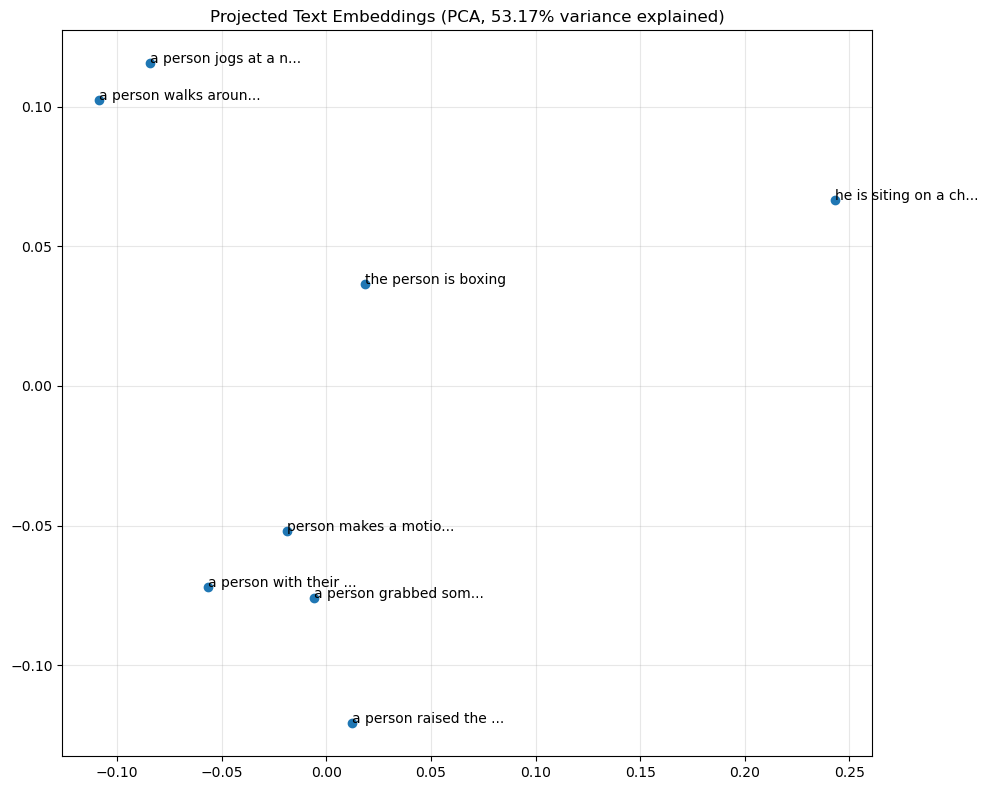

CLIP encoder saved to clip_encoder330.pt


In [4]:
import torch
import torch.nn as nn
import clip
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

class CLIPTextEncoder(nn.Module):
    """Wrapper for CLIP text encoder with projection layer"""
        
    def __init__(self, clip_model='ViT-B/32', projection_dim=256, device='cpu'):
        super().__init__()
        
        print(f"Loading CLIP model: {clip_model}")
        self.model, self.preprocess = clip.load(clip_model, device=device)
        self.device = device
        
        # Freeze CLIP weights
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Create projection layer (CLIP dim → model dim)
        self.clip_dim = 512  # Standard for ViT-B/32
        self.projection_dim = projection_dim
        self.projection = nn.Linear(self.clip_dim, self.projection_dim)
        
        # Move projection layer to the same device as CLIP
        self.projection.to(device)
        
        print(f"CLIP setup complete: {self.clip_dim} → {self.projection_dim}")        

    
    def encode_text(self, text_descriptions):
        """Encode text descriptions using CLIP"""
        # Handle single text input
        if isinstance(text_descriptions, str):
            text_descriptions = [text_descriptions]
            
        # Clean text by removing POS tagging info after #
        cleaned_texts = [text.split('#')[0].strip() for text in text_descriptions]
        
        # Tokenize text
        text_tokens = clip.tokenize(cleaned_texts).to(self.device)
        
        # Get CLIP embeddings
        with torch.no_grad():
            text_features = self.model.encode_text(text_tokens)
            
        # Normalize embeddings
        text_features = text_features / text_features.norm(dim=1, keepdim=True)
        
        # Convert to the same dtype as the projection layer
        text_features = text_features.to(self.projection.weight.dtype)
        
        return text_features


    
    def project_embeddings(self, clip_embeddings):
        """Project CLIP embeddings to model dimension"""
        return self.projection(clip_embeddings)
    
    def forward(self, text_descriptions):
        """End-to-end text encoding and projection"""
        clip_embeddings = self.encode_text(text_descriptions)
        projected_features = self.project_embeddings(clip_embeddings)
        
        return {
            'clip_embeddings': clip_embeddings,
            'projected_features': projected_features
        }



def validate_clip_encoder(encoder, pose_dataloader, num_samples=8):
    """Single validation function for CLIP encoder"""
    # Get sample batch
    batch = next(iter(pose_dataloader))
    
    # Process text through CLIP and projection
    texts = [text.split('#')[0].strip() for text in batch['text'][:num_samples]]
    results = encoder(texts)
    
    # Print basic statistics
    print(f"\nCLIP Encoder Validation:")
    print(f"- CLIP embeddings: {results['clip_embeddings'].shape}")
    print(f"- Projected features: {results['projected_features'].shape}")
    
    try:
        # visz embeddings with PCA
        clip_emb = results['clip_embeddings'].cpu().detach().numpy()
        proj_emb = results['projected_features'].cpu().detach().numpy()
        
        pca = PCA(n_components=2)
        reduced_proj = pca.fit_transform(proj_emb)
        explained_var = sum(pca.explained_variance_ratio_)
        
        # visualization
        plt.figure(figsize=(10, 8))
        plt.scatter(reduced_proj[:, 0], reduced_proj[:, 1])
        
        # text labels
        for i, txt in enumerate(texts):
            short_txt = txt[:20] + '...' if len(txt) > 20 else txt
            plt.annotate(short_txt, (reduced_proj[i, 0], reduced_proj[i, 1]))
        
        plt.title(f"Projected Text Embeddings (PCA, {explained_var:.2%} variance explained)")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    except (ImportError, RuntimeError) as e:
        print(f"Visualization skipped: {e}")
    
    return results



def setup_clip_encoder(dataloader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    encoder = CLIPTextEncoder(projection_dim=256, device=device)
    
    validation_results = validate_clip_encoder(encoder, dataloader)
    
    print("CLIP encoder setup and validation complete.")
    return encoder



def main():
    custom_cache_dir = r"D:\JoelDesktop folds_24\NEU SPRING25 - DL, HCI\Projects\Text-To-Pose Project\data"
    clusters_path = r"D:\JoelDesktop folds_24\NEU SPRING25 - DL, HCI\Projects\Text-To-Pose Project\pose_diversity_results\clusters.npy"
    
    # processor
    processor = HumanML3DProcessor(
        hf_dataset=humanml3d,
        clusters_path=clusters_path,
        use_position_only=True,
        frame_selection='first'
    )
    
    # sampling configuration
    sampling_config = processor.create_cluster_sampling_config(preset='moderate')
        
    # strategically sampled dataset
    dataset_dict = processor.create_strategically_sampled_dataset(sampling_config, split='train')
    
    # PyTorch dataset
    dataset = HumanML3DDataset(
        poses=dataset_dict['poses'],
        texts=dataset_dict['texts'],
        indices=dataset_dict['indices']
    )
    
    # data loader
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=32,
        shuffle=True,
        num_workers=0
    )
    
    # Set up CLIP encoder
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    clip_encoder = CLIPTextEncoder(projection_dim=256, device=device)
    
    # Validate encoder
    validation_results = validate_clip_encoder(clip_encoder, dataloader)
    
    # Save the encoder
    torch.save(clip_encoder.state_dict(), "clip_encoder330.pt")
    print("CLIP encoder saved to clip_encoder330.pt")
    
    return dataset, dataloader, clip_encoder


if __name__ == "__main__":
    dataset, dataloader, clip_encoder = main()
    


## Analysis on the clip setup;



- compute the "explained variance ratio" as a quality metric; higher percentages indicate **better preservation of the original embedding structure**.
- if the projection layer significantly distorts this structure, we lose the benefit of CLIP's extensive pre-training.
- later on, multi-head attention system relies on meaningful text embeddings.
- in high-dimensional text embeddings (256D), 48-53% explained variance in just 2 dimensions is actually quite good.
  

```
** for the first 1000/1500 sample item.
- PCA plot shows projected text embeddings reduced to 2 dimensions, with 44.87% of variance explained. 
- actually quite good - capturing nearly half of the information in just 2 dimensions // projection layer is preserving meaningful semantic distinctions.
** for the next, 5900 poses sample selection.
-  512-dimensional vector is powerful but not directly compatible with most diffusion bottlenecks or time/pose embeddings, which typically range between 128–256 dimensions. ??
- ready for conditional training if you feed these [8, 256] vectors into a conditioning module in your UNet or transformer-style pose model.
- ~49.05%, 50+, 52+, of the total variance.  meaningful in high-dimensional semantic modeling.
- best: 52.66% for all 23k samples.
- Low rank or semi-low-rank, where much of the meaningful variability is captured in a few axes
- Trained or projected well, with little noise dominating the top components
- ** projection head is not collapsing: CLIP text encodings are preserving important variance directions that relate to motion semantics. **
```

-----------------------------------------------------------------------------------------------------------------------------------------

- PC1 (X-axis) **might reflect directional variance**, such as physical movement scale or intent (e.g., “stands still” vs. “walks forward” vs. “drastically moves”).
- PC2 (Y-axis) **may capture verticality or affect** (e.g., grounded vs. dynamic, “lying down” vs. “jumping”).
- Test it through actual conditioning in generation—that’s the true test
- **Variance ≠ Semantics Always**.. sadly.


-----------------------------------------------------------------------------------------------------------------------------------------

```
- Similar actions appear closer together in the embedding space. "Person leans down" and "person leans over" are near each other, which makes intuitive sense.
- embeddings aren't all clustered in one area ( projection isn't collapsing the semantic information )
- different action categories - leaning actions in one area, walking in another, and more explosive movements ("quickly spreads") positioned separately.

For later; [ if possible ??? just notes. 
    Gradient flow analysis: Check gradient magnitudes flowing back to different parts of your model. If gradients to the projection layer are very small, it might indicate this component needs adjustment.
    Attention visualization: Once your diffusion model is running, visualize attention patterns between text features and pose features. Diffuse or random attention patterns could suggest the projection isn't providing useful distinctions.
    ]

```


## Theoretical Study Notes - Diffusion, Noise Scheduler, Time embedding, UNets, Cross Att. etc:

```
Diffusion models work on a principle of gradually adding noise to data (forward process) and then learning to reverse this process (reverse diffusion). For pose generation, this means:
Forward Diffusion: A process that gradually adds noise to a pose until it becomes pure noise
Reverse Diffusion: Learning to gradually remove noise, starting from random noise to generate a clean pose


-  noise scheduler controls how noise is added during the forward process and removed during the reverse process. It defines a schedule of variance values (betas) that determine the noise level at each step.
- [ Ensures smooth transitions between noise levels, Prevents the pose structure from being destroyed too quickly, Enables stable learning of the denoising process, Balances between quality and generation speed. ]

Defines a sequence of increasing variance values (β₁, β₂, ..., βₜ)
At each step t, noise is added according to: x_t = √(1-βₜ)·x_{t-1} + √βₜ·ε

- time embedding module converts a discrete timestep (t) into a continuous representation that the model can use to understand "how noisy" the current input is.
- [ model needs to know the noise level to apply the appropriate denoising, Simple one-hot encoding of timesteps would be too sparse, Enables the model to generalize between timesteps. ]

## U-Net Backbone
- U-Net is a convolutional network with skip connections between encoder and decoder parts, maintaining information flow across different resolutions.
- Instead of 2D convolutions used for images, we use 1D convolutions or MLPs for pose vectors
- The encoder progressively reduces the dimensionality while increasing channel depth
- The decoder reconstructs the pose while incorporating skip connections
- [ Downsampling blocks (encoder), Bottleneck blocks, Upsampling blocks (decoder), Skip connections, Normalization layers. ]


## Cross Att: The cross-attention allows the pose features to "look at" or attend to specific parts of the text embeddings, creating a bridge between text and pose spaces.
- [ Pose features act as queries, Text embeddings serve as keys and values, Attention weights determine which text features influence which pose components, Multiple attention heads capture different aspects of the relationship. ]


## Part 1 and 2.
Noise Scheduler Module -> Time Embedding Module -> U-Net Backbone Structure -> Forward Diffusion Process.
Cross-Attention Implementation -> Text-Pose Integration -> Modify loss function to include conditioning -> Create text-conditional sampling process


After implementing Part 1:
- model able to generate anatomically plausible poses, poses won't be conditioned on text yet, denoising process should progressively improve pose coherence.
After completing Part 2:
- model should generate poses that correspond to text descriptions, attention visualization should show meaningful patterns connecting text and pose, sampling with different text conditions should produce different poses.


```


## Part 1;
```
The noise scheduler supports linear, cosine, and quadratic schedules
The U-Net is adapted for 1D pose data rather than 2D images
Skip connections ensure information flow from encoder to decoder
The architecture allows for both conditional and unconditional generation
```


---------------------------------------------------------------------------------------------------------------------------------------------
## Starting with U Net;
```
- CNN with symmetric encoder-decoder structure.
- encoder path (downsampling): progressively reduces spatial resolution. increases feature.
- decoder path (upsampling): reconstructs output resolution while integrating semantic features.
- skip connections: direct links from encoder layers to decoder layers at the same level of resolution.

- **dense pixel-level tasks like segmentation or spatially-aligned output.
- Encoder + Bottleneck + Decoder.
```

#### UNet in generative modeling:
- denoising diffusion probabilistic models (DDPMs).
- what do we wanna do?: take pure Gaussian noise as input. learns to gradually denoise it step-by-step over T timesteps. At each step, predicts the noise or the denoised signal (x_0) given x_t.
- **Core:** Accept a noisy input, Use conditioning (like text from CLIP), Predict the direction to move closer to real data.
- Input = noisy signal, Output = denoised prediction → matches encoder-decoder form.
- In image diffusion (like SD), the input is a 2D image. In your case (HumanML3D), the input is a 66D pose vector per sample.
- Instead of 2D convolutions, you use MLP layers (linear layers) or 1D convolutions.
- **U-Net backbone learns temporal patterns, motion geometry, and structural consistency over time.**
- Idea;  UNet architecture with 96 base channels and multipliers (1, 2, 4, 4) -- potential ideas.


---------------------------------------------------------------------------------------------------------------------------------------------
### Code Exp:

```
During training:
    Forward diffusion (add_noise) is used to create noisy poses
    UNet predicts the noise that was added
    Loss is calculated between predicted and actual noise

During generation:
    Start with pure random noise
    Iteratively apply p_sample to gradually denoise
    Progress from completely random noise to a clean pose

    # Training Flow
    Dataset (1000 poses) 
      → dataloader.get_batch()
      → NoiseScheduler.sample_timesteps()
      → NoiseScheduler.add_noise(poses, t) 
      → UNetModel.forward(noisy_poses, t)
      → Loss = MSE(predicted_noise, actual_noise)
      → optimizer.step()
    
    # Generation Flow
    Random Noise [B×66] 
      → NoiseScheduler.sample(model, shape)
        → For t=100→0:
          → NoiseScheduler.p_sample(model, x_t, t)
            → model.forward(x_t, t)
            → NoiseScheduler.predict_start_from_noise()
            → NoiseScheduler.q_posterior_mean_variance()
            → Add scaled noise
      → Final Pose [B×66]
```

---------------------------------------------------------------------------------------------------------------------------------

### Whats done below ? 
#### -> both the training phase (forward diffusion + prediction + loss optimization) and the generation phase (reverse diffusion via iterative denoising) using a fully functional U-Net-based denoising diffusion model.


#### Training Pathway: Clean poses → add noise xt  → U-Net predicts noise → MSE loss on predicted vs. actual noise → optimize.
#### Generation Pathway: Pure noise → progressively denoise using U-Net in reverse diffusion → clean pose samples.


---------------------------------------------------------------------------------------------------------------------------------------------
#### Validation and Interpretation, Landscape of loss. 
```
        No canonical answer to what the final denoised sample should look like
        Only MSE between predicted and actual noise at training time
```
- Convergence Behavior: is loss going down smoothly?
- Sample Quality: are generated poses becoming more structured, human-like?
- Reconstruction Sharpness: are sampled motions coherent or noisy?
- Consistency over Seeds: do different runs produce variations or collapse?


#### why dont i have a classification or accuracy yet?
````
    freshly generated random samples each time you enter the sample_poses() routine.
    every 10 epochs, generate 4 entirely new, random motionless 3D poses from the model, and plot them as static skeletons.
    have to come up with ground truth comparison later.
```

## Iter1 Code;


### Custom NoiseScheduler, Diffusion model Implementation.

### ( Note: Please prefer not to run the Iter1 Code block, Iter2 code block. These are failed approaches with results meant for analysis. Iter3 can be run later as main project code. )
### ( Prefer to keep Iter1 Iter2 code collapsed. )

``` 
we have, 
        # Pre-compute diffusion values
        # Calculations for diffusion q(x_t | x_{t-1}) and others        
        # Calculations for posterior q(x_{t-1} | x_t, x_0)

we have, Basic ResBlock, UNet, TimeEmbedding, and training code.
```

Setting up data...
Successfully loaded cluster assignments with shape: (23384,)

Cluster Distribution:
Cluster 0: 9065 poses (38.77%)
Cluster 1: 954 poses (4.08%)
Cluster 2: 299 poses (1.28%)
Cluster 3: 497 poses (2.13%)
Cluster 4: 3632 poses (15.53%)
Cluster 5: 2427 poses (10.38%)
Cluster 6: 2206 poses (9.43%)
Cluster 7: 1425 poses (6.09%)
Cluster 8: 2465 poses (10.54%)
Cluster 9: 414 poses (1.77%)

Created mapping for 10 clusters
Loading HumanML3D train data...

Strategic sampling config:
  Cluster 0: 2000 samples
  Cluster 5: 1200 samples
  Cluster 8: 1000 samples
  Cluster 4: 800 samples
  Cluster 6: 600 samples
  Cluster 1: 300 samples

Strategically sampled dataset statistics:
Total poses: 5900
Actual cluster distribution in sample:
  Cluster 0: 2000 samples
  Cluster 1: 300 samples
  Cluster 4: 800 samples
  Cluster 5: 1200 samples
  Cluster 6: 600 samples
  Cluster 8: 1000 samples
Setting up model...

U-Net Architecture Summary:
Pose dimension: 66
Base channels: 96
Channel mult

Epoch 0:   0%|                                                                    | 0/93 [00:00<?, ?it/s, loss=3.14e+7]

[Input poses - min: -0.5139, max: 1.0000, mean: 0.1983 | Noisy poses - min: -2.7670, max: 3.2374 | Added noise - min: -3.4771, max: 3.5925 | Predicted noise - min: -0.2122, max: 0.1940]
[Diffusion loss: 1.0066 | Anatomy loss: 313741664.0000 | Total loss: 31374168.0000 | Estimated pose - min: -182.5792, max: 192.7802]
--------------------------------------------------


Epoch 0:  54%|███████████████████████████████▋                           | 50/93 [00:01<00:01, 30.23it/s, loss=1.78e+6]

[Input poses - min: -0.5306, max: 1.0000, mean: 0.2014 | Noisy poses - min: -3.4479, max: 3.3670 | Added noise - min: -3.4776, max: 3.5020 | Predicted noise - min: -0.2091, max: 0.2019]
[Diffusion loss: 1.0199 | Anatomy loss: 75374442661806080.0000 | Total loss: 7537444266180608.0000 | Estimated pose - min: -17780.2617, max: 15437.8350]
--------------------------------------------------


Epoch 0: 100%|████████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.52it/s, loss=3.3e+7]


Epoch 1/60, Loss: 1839330963014500.750000


Epoch 1:   3%|█▉                                                          | 3/93 [00:00<00:03, 25.30it/s, loss=1.64e+7]

[Input poses - min: -0.5119, max: 1.0000, mean: 0.2040 | Noisy poses - min: -3.1131, max: 4.8015 | Added noise - min: -3.1854, max: 4.7050 | Predicted noise - min: -0.2133, max: 0.1711]
[Diffusion loss: 1.0147 | Anatomy loss: 164211744.0000 | Total loss: 16421176.0000 | Estimated pose - min: -150.9592, max: 133.1130]
--------------------------------------------------


Epoch 1:  56%|████████████████████████████████▉                          | 52/93 [00:01<00:01, 30.90it/s, loss=1.61e+5]

[Input poses - min: -0.7537, max: 1.0000, mean: 0.2051 | Noisy poses - min: -3.0043, max: 3.6686 | Added noise - min: -3.4683, max: 3.6837 | Predicted noise - min: -0.1913, max: 0.2261]
[Diffusion loss: 1.0227 | Anatomy loss: 120549905113546752.0000 | Total loss: 12054990726103040.0000 | Estimated pose - min: -19495.4805, max: 17744.7695]
--------------------------------------------------


Epoch 1: 100%|███████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 30.00it/s, loss=2.85e+7]


Epoch 2/60, Loss: 2188682446146506.750000


Epoch 2:   3%|█▉                                                         | 3/93 [00:00<00:03, 25.94it/s, loss=6.89e+15]

[Input poses - min: -0.7633, max: 1.0000, mean: 0.2015 | Noisy poses - min: -2.9506, max: 3.0583 | Added noise - min: -3.2231, max: 4.1101 | Predicted noise - min: -0.2151, max: 0.2057]
[Diffusion loss: 1.0099 | Anatomy loss: 68899465930473472.0000 | Total loss: 6889946807795712.0000 | Estimated pose - min: -16316.3760, max: 14622.5391]
--------------------------------------------------


Epoch 2:  56%|████████████████████████████████▉                          | 52/93 [00:01<00:01, 29.34it/s, loss=3.86e+7]

[Input poses - min: -0.5274, max: 1.0000, mean: 0.1986 | Noisy poses - min: -3.2198, max: 3.2022 | Added noise - min: -3.3577, max: 3.2207 | Predicted noise - min: -0.2109, max: 0.1858]
[Diffusion loss: 1.0059 | Anatomy loss: 414996864.0000 | Total loss: 41499688.0000 | Estimated pose - min: -135.2411, max: 164.5309]
--------------------------------------------------


Epoch 2: 100%|██████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.42it/s, loss=5.49e+15]


Epoch 3/60, Loss: 1647529729978935.750000


Epoch 3:   3%|█▉                                                          | 3/93 [00:00<00:03, 25.58it/s, loss=1.88e+7]

[Input poses - min: -0.5586, max: 1.0000, mean: 0.2049 | Noisy poses - min: -3.6099, max: 3.2235 | Added noise - min: -3.7825, max: 3.2385 | Predicted noise - min: -0.2094, max: 0.1918]
[Diffusion loss: 1.0137 | Anatomy loss: 187624400.0000 | Total loss: 18762442.0000 | Estimated pose - min: -129.9272, max: 200.3820]
--------------------------------------------------


Epoch 3:  56%|████████████████████████████████▍                         | 52/93 [00:01<00:01, 30.34it/s, loss=2.77e+15]

[Input poses - min: -0.5537, max: 1.0000, mean: 0.2026 | Noisy poses - min: -2.8366, max: 3.2561 | Added noise - min: -3.4553, max: 3.6527 | Predicted noise - min: -0.2120, max: 0.1898]
[Diffusion loss: 1.0007 | Anatomy loss: 359810272.0000 | Total loss: 35981028.0000 | Estimated pose - min: -170.7379, max: 150.9281]
--------------------------------------------------


Epoch 3: 100%|██████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 29.65it/s, loss=1.13e+15]


Epoch 4/60, Loss: 2623135101163649.500000


Epoch 4:   3%|█▉                                                          | 3/93 [00:00<00:03, 26.17it/s, loss=3.1e+15]

[Input poses - min: -0.8184, max: 1.0000, mean: 0.2043 | Noisy poses - min: -3.4477, max: 3.1777 | Added noise - min: -3.4899, max: 4.1293 | Predicted noise - min: -0.2024, max: 0.2047]
[Diffusion loss: 0.9533 | Anatomy loss: 31045831796719616.0000 | Total loss: 3104583287046144.0000 | Estimated pose - min: -17345.5000, max: 18324.7422]
--------------------------------------------------


Epoch 4:  56%|████████████████████████████████▉                          | 52/93 [00:01<00:01, 28.64it/s, loss=7.39e+7]

[Input poses - min: -0.5010, max: 1.0000, mean: 0.2022 | Noisy poses - min: -3.4868, max: 2.9485 | Added noise - min: -3.7957, max: 3.7397 | Predicted noise - min: -0.2115, max: 0.1925]
[Diffusion loss: 1.0108 | Anatomy loss: 577791040.0000 | Total loss: 57779104.0000 | Estimated pose - min: -190.3650, max: 148.8904]
--------------------------------------------------


Epoch 4: 100%|██████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.22it/s, loss=2.42e+15]


Epoch 5/60, Loss: 1649251376766481.250000


Epoch 5:   3%|█▉                                                         | 3/93 [00:00<00:03, 29.85it/s, loss=2.38e+15]

[Input poses - min: -0.8678, max: 1.0000, mean: 0.2010 | Noisy poses - min: -3.0846, max: 3.2236 | Added noise - min: -4.0080, max: 3.8250 | Predicted noise - min: -0.1887, max: 0.1661]
[Diffusion loss: 1.0231 | Anatomy loss: 23764479250530304.0000 | Total loss: 2376448086114304.0000 | Estimated pose - min: -15248.6133, max: 19214.2012]
--------------------------------------------------


Epoch 5:  56%|████████████████████████████████▍                         | 52/93 [00:01<00:01, 29.90it/s, loss=5.66e+15]

[Input poses - min: -0.9564, max: 1.0000, mean: 0.1995 | Noisy poses - min: -3.2065, max: 3.4349 | Added noise - min: -4.0305, max: 3.5151 | Predicted noise - min: -0.1813, max: 0.1874]
[Diffusion loss: 0.9944 | Anatomy loss: 8858989060161536.0000 | Total loss: 885898946281472.0000 | Estimated pose - min: -9303.5039, max: 15721.2324]
--------------------------------------------------


Epoch 5: 100%|████████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.94it/s, loss=2.6e+7]


Epoch 6/60, Loss: 1817930902724726.250000


Epoch 6:   3%|█▉                                                          | 3/93 [00:00<00:03, 27.60it/s, loss=2.73e+7]

[Input poses - min: -0.5139, max: 1.0000, mean: 0.1991 | Noisy poses - min: -3.3215, max: 3.0819 | Added noise - min: -3.3885, max: 3.4490 | Predicted noise - min: -0.2205, max: 0.1702]
[Diffusion loss: 1.0238 | Anatomy loss: 273126336.0000 | Total loss: 27312636.0000 | Estimated pose - min: -161.8472, max: 134.7529]
--------------------------------------------------


Epoch 6:  53%|███████████████████████████████                            | 49/93 [00:01<00:01, 29.43it/s, loss=2.15e+6]

[Input poses - min: -0.8184, max: 1.0000, mean: 0.2006 | Noisy poses - min: -3.1632, max: 3.7838 | Added noise - min: -3.3077, max: 3.9853 | Predicted noise - min: -0.1838, max: 0.1648]
[Diffusion loss: 0.9669 | Anatomy loss: 408123456.0000 | Total loss: 40812348.0000 | Estimated pose - min: -154.8843, max: 162.6819]
--------------------------------------------------


Epoch 6: 100%|███████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 27.24it/s, loss=1.91e+7]


Epoch 7/60, Loss: 1692577200265950.500000


Epoch 7:   4%|██▌                                                         | 4/93 [00:00<00:02, 34.65it/s, loss=5.42e+7]

[Input poses - min: -0.4528, max: 1.0000, mean: 0.1964 | Noisy poses - min: -3.1539, max: 3.5591 | Added noise - min: -3.4888, max: 3.6633 | Predicted noise - min: -0.2388, max: 0.1642]
[Diffusion loss: 0.9923 | Anatomy loss: 541518528.0000 | Total loss: 54151852.0000 | Estimated pose - min: -122.5028, max: 193.5394]
--------------------------------------------------


Epoch 7:  53%|██████████████████████████████▌                           | 49/93 [00:01<00:01, 31.40it/s, loss=3.82e+15]

[Input poses - min: -0.5648, max: 1.0000, mean: 0.2016 | Noisy poses - min: -2.8585, max: 3.3446 | Added noise - min: -3.2372, max: 3.4707 | Predicted noise - min: -0.1910, max: 0.1840]
[Diffusion loss: 0.9795 | Anatomy loss: 250075008.0000 | Total loss: 25007502.0000 | Estimated pose - min: -157.2110, max: 186.4321]
--------------------------------------------------


Epoch 7: 100%|██████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.47it/s, loss=2.83e+15]


Epoch 8/60, Loss: 1785187564951169.500000


Epoch 8:   3%|█▉                                                          | 3/93 [00:00<00:03, 26.82it/s, loss=3.11e+7]

[Input poses - min: -0.8508, max: 1.0000, mean: 0.1970 | Noisy poses - min: -3.3802, max: 3.5648 | Added noise - min: -3.4252, max: 3.6298 | Predicted noise - min: -0.1681, max: 0.1835]
[Diffusion loss: 0.9914 | Anatomy loss: 310813536.0000 | Total loss: 31081354.0000 | Estimated pose - min: -123.1101, max: 150.2760]
--------------------------------------------------


Epoch 8:  53%|███████████████████████████████                            | 49/93 [00:01<00:01, 31.15it/s, loss=4.1e+15]

[Input poses - min: -0.5317, max: 1.0000, mean: 0.2023 | Noisy poses - min: -2.9537, max: 3.1044 | Added noise - min: -3.4726, max: 3.2292 | Predicted noise - min: -0.1796, max: 0.1877]
[Diffusion loss: 0.9784 | Anatomy loss: 79554493812834304.0000 | Total loss: 7955449273909248.0000 | Estimated pose - min: -17916.3926, max: 14311.9912]
--------------------------------------------------


Epoch 8: 100%|███████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 29.96it/s, loss=3.2e+15]


Epoch 9/60, Loss: 2872897191116586.000000


Epoch 9:   4%|██▌                                                         | 4/93 [00:00<00:02, 30.13it/s, loss=6.72e+5]

[Input poses - min: -0.6656, max: 1.0000, mean: 0.1960 | Noisy poses - min: -3.2111, max: 3.3390 | Added noise - min: -4.1406, max: 3.5607 | Predicted noise - min: -0.1964, max: 0.1786]
[Diffusion loss: 1.0125 | Anatomy loss: 6715139.5000 | Total loss: 671514.9375 | Estimated pose - min: -51.2141, max: 71.3696]
--------------------------------------------------


Epoch 9:  54%|███████████████████████████████▋                           | 50/93 [00:01<00:01, 30.03it/s, loss=1.65e+5]

[Input poses - min: -0.4422, max: 1.0000, mean: 0.2017 | Noisy poses - min: -3.0669, max: 3.0054 | Added noise - min: -3.6848, max: 3.9678 | Predicted noise - min: -0.2042, max: 0.1772]
[Diffusion loss: 0.9907 | Anatomy loss: 1942941.0000 | Total loss: 194295.0938 | Estimated pose - min: -31.0292, max: 35.9903]
--------------------------------------------------


Epoch 9: 100%|███████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.98it/s, loss=5.12e+6]


Epoch 10/60, Loss: 1951067387155133.000000


Epoch 10:   4%|██▋                                                           | 4/93 [00:00<00:02, 31.23it/s, loss=3e+5]

[Input poses - min: -0.6890, max: 1.0000, mean: 0.1969 | Noisy poses - min: -3.6450, max: 4.1371 | Added noise - min: -4.3510, max: 4.2296 | Predicted noise - min: -0.1918, max: 0.1892]
[Diffusion loss: 1.0223 | Anatomy loss: 2996002.0000 | Total loss: 299601.2500 | Estimated pose - min: -33.0864, max: 42.4054]
--------------------------------------------------


Epoch 10:  52%|█████████████████████████████▉                            | 48/93 [00:01<00:01, 29.67it/s, loss=5.5e+15]

[Input poses - min: -0.7537, max: 1.0000, mean: 0.1960 | Noisy poses - min: -3.0139, max: 3.0129 | Added noise - min: -3.3946, max: 4.0843 | Predicted noise - min: -0.1741, max: 0.1604]
[Diffusion loss: 1.0103 | Anatomy loss: 392122048.0000 | Total loss: 39212204.0000 | Estimated pose - min: -183.2200, max: 178.1297]
--------------------------------------------------


Epoch 10: 100%|██████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.57it/s, loss=1.96e+7]


Epoch 11/60, Loss: 1952127261107425.000000


Epoch 11:   3%|█▊                                                        | 3/93 [00:00<00:03, 28.72it/s, loss=1.79e+15]

[Input poses - min: -0.8124, max: 1.0000, mean: 0.2013 | Noisy poses - min: -2.7767, max: 3.5174 | Added noise - min: -3.2377, max: 3.5144 | Predicted noise - min: -0.2052, max: 0.1847]
[Diffusion loss: 0.9964 | Anatomy loss: 17862713149489152.0000 | Total loss: 1786271395479552.0000 | Estimated pose - min: -16432.1836, max: 9938.0762]
--------------------------------------------------


Epoch 11:  55%|███████████████████████████████▎                         | 51/93 [00:01<00:01, 30.10it/s, loss=8.83e+15]

[Input poses - min: -0.6503, max: 1.0000, mean: 0.1985 | Noisy poses - min: -3.4269, max: 3.4474 | Added noise - min: -3.5532, max: 3.4531 | Predicted noise - min: -0.2269, max: 0.1821]
[Diffusion loss: 1.0108 | Anatomy loss: 36022494154457088.0000 | Total loss: 3602249469132800.0000 | Estimated pose - min: -16799.1016, max: 13476.3838]
--------------------------------------------------


Epoch 11: 100%|██████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 31.24it/s, loss=2.23e+7]


Epoch 12/60, Loss: 1906226344303258.250000


Epoch 12:   4%|██▍                                                       | 4/93 [00:00<00:02, 33.80it/s, loss=1.89e+15]

[Input poses - min: -0.6152, max: 1.0000, mean: 0.1977 | Noisy poses - min: -2.9364, max: 3.1511 | Added noise - min: -3.4869, max: 3.5494 | Predicted noise - min: -0.2102, max: 0.1890]
[Diffusion loss: 0.9687 | Anatomy loss: 18855344516104192.0000 | Total loss: 1885534532141056.0000 | Estimated pose - min: -16858.1836, max: 15290.5986]
--------------------------------------------------


Epoch 12:  56%|████████████████████████████████▍                         | 52/93 [00:01<00:01, 31.18it/s, loss=6.26e+6]

[Input poses - min: -0.4358, max: 1.0000, mean: 0.2000 | Noisy poses - min: -3.5923, max: 3.0991 | Added noise - min: -3.7433, max: 3.4041 | Predicted noise - min: -0.2081, max: 0.1757]
[Diffusion loss: 1.0079 | Anatomy loss: 615972608.0000 | Total loss: 61597260.0000 | Estimated pose - min: -153.0313, max: 170.5798]
--------------------------------------------------


Epoch 12: 100%|██████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 30.74it/s, loss=8.83e+5]


Epoch 13/60, Loss: 1864851061468492.750000


Epoch 13:   4%|██▌                                                        | 4/93 [00:00<00:02, 32.65it/s, loss=3.24e+7]

[Input poses - min: -0.6706, max: 1.0000, mean: 0.1942 | Noisy poses - min: -2.9172, max: 3.2140 | Added noise - min: -3.1913, max: 3.6012 | Predicted noise - min: -0.2097, max: 0.2040]
[Diffusion loss: 0.9992 | Anatomy loss: 324360704.0000 | Total loss: 32436070.0000 | Estimated pose - min: -141.9529, max: 117.3140]
--------------------------------------------------


Epoch 13:  55%|███████████████████████████████▊                          | 51/93 [00:01<00:01, 31.11it/s, loss=1.99e+6]

[Input poses - min: -0.4846, max: 1.0000, mean: 0.1959 | Noisy poses - min: -3.0415, max: 3.1708 | Added noise - min: -5.2167, max: 3.4012 | Predicted noise - min: -0.2141, max: 0.1897]
[Diffusion loss: 0.9997 | Anatomy loss: 4332001.5000 | Total loss: 433201.1562 | Estimated pose - min: -43.8811, max: 58.0395]
--------------------------------------------------


Epoch 13: 100%|███████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 31.56it/s, loss=8.2e+4]


Epoch 14/60, Loss: 2100548827757647.250000


Epoch 14:   3%|█▉                                                         | 3/93 [00:00<00:03, 28.36it/s, loss=4.34e+6]

[Input poses - min: -0.7137, max: 1.0000, mean: 0.1966 | Noisy poses - min: -2.7532, max: 3.4138 | Added noise - min: -3.8003, max: 3.7397 | Predicted noise - min: -0.2245, max: 0.1868]
[Diffusion loss: 0.9918 | Anatomy loss: 43443156.0000 | Total loss: 4344316.5000 | Estimated pose - min: -89.1776, max: 108.9724]
--------------------------------------------------


Epoch 14:  53%|██████████████████████████████▌                           | 49/93 [00:01<00:01, 27.77it/s, loss=2.24e+6]

[Input poses - min: -0.9194, max: 1.0000, mean: 0.1952 | Noisy poses - min: -3.2459, max: 3.0922 | Added noise - min: -3.7389, max: 3.3880 | Predicted noise - min: -0.1990, max: 0.1814]
[Diffusion loss: 0.9931 | Anatomy loss: 106918323161137152.0000 | Total loss: 10691832530862080.0000 | Estimated pose - min: -19255.2734, max: 17633.5781]
--------------------------------------------------


Epoch 14: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 30.01it/s, loss=5.27e+15]


Epoch 15/60, Loss: 1927830104793995.750000


Epoch 15:   4%|██▍                                                       | 4/93 [00:00<00:02, 30.16it/s, loss=3.82e+15]

[Input poses - min: -0.9182, max: 1.0000, mean: 0.1966 | Noisy poses - min: -2.9586, max: 3.4864 | Added noise - min: -3.3260, max: 3.6772 | Predicted noise - min: -0.2028, max: 0.1917]
[Diffusion loss: 0.9676 | Anatomy loss: 38186781862002688.0000 | Total loss: 3818678239887360.0000 | Estimated pose - min: -16396.2500, max: 16187.0566]
--------------------------------------------------


Epoch 15:  54%|███████████████████████████████▏                          | 50/93 [00:01<00:01, 29.39it/s, loss=9.47e+7]

[Input poses - min: -0.4781, max: 1.0000, mean: 0.2008 | Noisy poses - min: -3.2205, max: 3.4930 | Added noise - min: -3.2227, max: 3.6377 | Predicted noise - min: -0.2272, max: 0.1886]
[Diffusion loss: 1.0476 | Anatomy loss: 22920969148432384.0000 | Total loss: 2292097075904512.0000 | Estimated pose - min: -9922.5430, max: 16361.3818]
--------------------------------------------------


Epoch 15: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.60it/s, loss=2.91e+15]


Epoch 16/60, Loss: 2113825729034304.250000


Epoch 16:   3%|█▊                                                        | 3/93 [00:00<00:03, 29.49it/s, loss=1.75e+15]

[Input poses - min: -0.7757, max: 1.0000, mean: 0.1994 | Noisy poses - min: -3.1321, max: 4.0435 | Added noise - min: -3.3086, max: 4.2451 | Predicted noise - min: -0.2268, max: 0.1884]
[Diffusion loss: 0.9885 | Anatomy loss: 17495645917020160.0000 | Total loss: 1749564591702016.0000 | Estimated pose - min: -14073.8135, max: 16231.7148]
--------------------------------------------------


Epoch 16:  53%|██████████████████████████████                           | 49/93 [00:01<00:01, 28.28it/s, loss=3.16e+15]

[Input poses - min: -0.8221, max: 1.0000, mean: 0.1953 | Noisy poses - min: -2.9426, max: 3.4526 | Added noise - min: -3.2664, max: 3.5884 | Predicted noise - min: -0.2769, max: 0.1886]
[Diffusion loss: 0.9838 | Anatomy loss: 18321686239641600.0000 | Total loss: 1832168623964160.0000 | Estimated pose - min: -12599.1045, max: 14078.0146]
--------------------------------------------------


Epoch 16: 100%|██████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.51it/s, loss=4.09e+7]


Epoch 17/60, Loss: 1871011222486674.250000


Epoch 17:   4%|██▍                                                       | 4/93 [00:00<00:02, 32.56it/s, loss=2.32e+15]

[Input poses - min: -0.8221, max: 1.0000, mean: 0.1967 | Noisy poses - min: -3.3037, max: 3.1743 | Added noise - min: -3.5724, max: 3.1874 | Predicted noise - min: -0.2220, max: 0.2125]
[Diffusion loss: 1.0082 | Anatomy loss: 23187965790388224.0000 | Total loss: 2318796740100096.0000 | Estimated pose - min: -12484.3340, max: 16085.4502]
--------------------------------------------------


Epoch 17:  56%|████████████████████████████████▉                          | 52/93 [00:01<00:01, 29.23it/s, loss=3.6e+7]

[Input poses - min: -0.5182, max: 1.0000, mean: 0.1991 | Noisy poses - min: -3.2162, max: 3.8819 | Added noise - min: -3.2573, max: 4.0201 | Predicted noise - min: -0.2197, max: 0.1757]
[Diffusion loss: 0.9733 | Anatomy loss: 229480528.0000 | Total loss: 22948054.0000 | Estimated pose - min: -203.1920, max: 122.3258]
--------------------------------------------------


Epoch 17: 100%|██████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 30.26it/s, loss=3.16e+6]


Epoch 18/60, Loss: 1623659426142376.000000


Epoch 18:   3%|█▉                                                         | 3/93 [00:00<00:03, 29.38it/s, loss=3.22e+7]

[Input poses - min: -0.8983, max: 1.0000, mean: 0.1990 | Noisy poses - min: -3.1661, max: 3.3577 | Added noise - min: -3.9911, max: 4.7558 | Predicted noise - min: -0.2330, max: 0.2083]
[Diffusion loss: 0.9882 | Anatomy loss: 321870240.0000 | Total loss: 32187024.0000 | Estimated pose - min: -167.4319, max: 187.3647]
--------------------------------------------------


Epoch 18:  56%|████████████████████████████████▍                         | 52/93 [00:01<00:01, 30.70it/s, loss=3.65e+7]

[Input poses - min: -0.5810, max: 1.0000, mean: 0.2007 | Noisy poses - min: -3.4658, max: 3.3849 | Added noise - min: -3.9464, max: 3.4387 | Predicted noise - min: -0.2125, max: 0.2017]
[Diffusion loss: 0.9890 | Anatomy loss: 1061707008.0000 | Total loss: 106170704.0000 | Estimated pose - min: -170.9323, max: 160.2615]
--------------------------------------------------


Epoch 18: 100%|███████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 29.92it/s, loss=2.9e+4]


Epoch 19/60, Loss: 1714746339957338.750000


Epoch 19:   4%|██▌                                                        | 4/93 [00:00<00:02, 31.79it/s, loss=9.61e+6]

[Input poses - min: -0.4421, max: 1.0000, mean: 0.1988 | Noisy poses - min: -3.5437, max: 3.7645 | Added noise - min: -3.5888, max: 3.9925 | Predicted noise - min: -0.2688, max: 0.1936]
[Diffusion loss: 0.9772 | Anatomy loss: 96099776.0000 | Total loss: 9609979.0000 | Estimated pose - min: -112.1306, max: 104.3428]
--------------------------------------------------


Epoch 19:  56%|███████████████████████████████▊                         | 52/93 [00:01<00:01, 30.35it/s, loss=2.81e+15]

[Input poses - min: -0.8667, max: 1.0000, mean: 0.1987 | Noisy poses - min: -3.2588, max: 3.1319 | Added noise - min: -3.5008, max: 3.1814 | Predicted noise - min: -0.3254, max: 0.1947]
[Diffusion loss: 0.9904 | Anatomy loss: 2101413.0000 | Total loss: 210142.2812 | Estimated pose - min: -41.8357, max: 41.6611]
--------------------------------------------------


Epoch 19: 100%|██████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 30.74it/s, loss=9.95e+4]


Epoch 20/60, Loss: 2102939841163070.500000
Generating sample poses at epoch 20...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 190.67it/s]


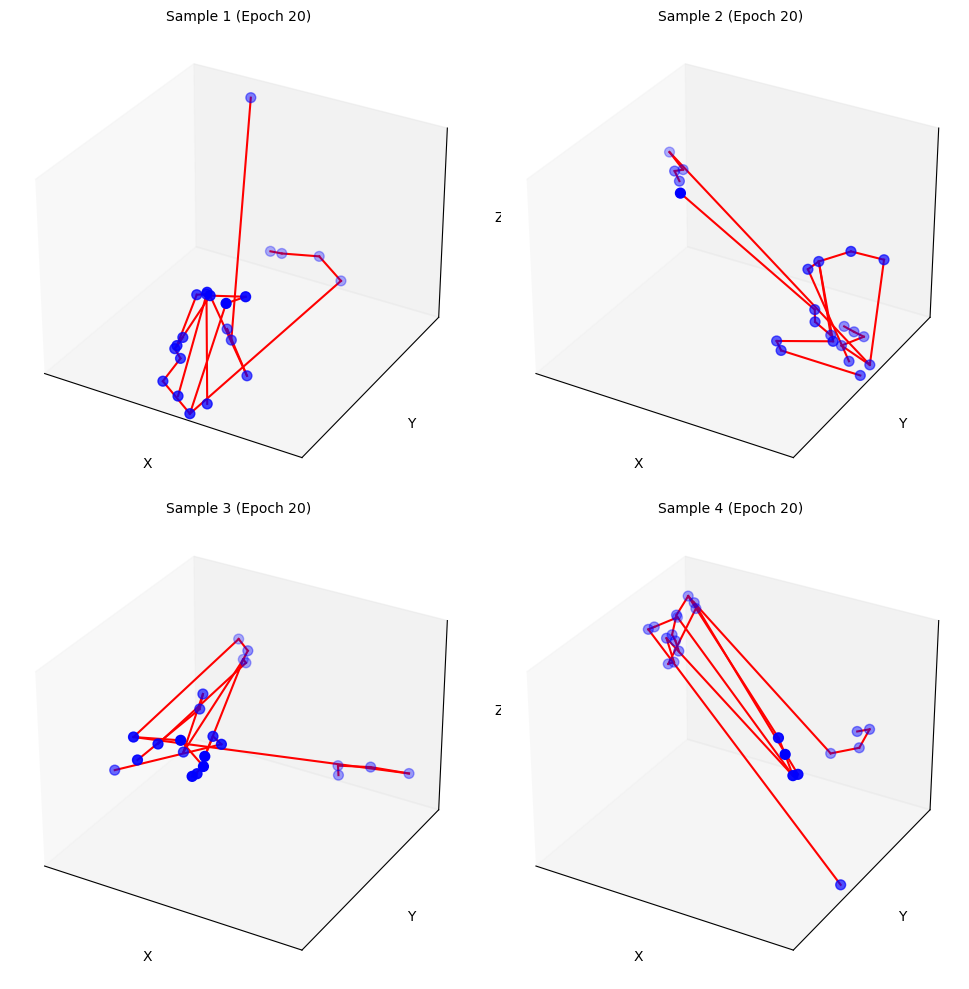

Saved sample grid to: part1_pose_samples/constrained\epoch_020_samples.png


Epoch 20:   3%|█▊                                                        | 3/93 [00:00<00:03, 24.48it/s, loss=1.42e+15]

[Input poses - min: -0.7258, max: 1.0000, mean: 0.2006 | Noisy poses - min: -2.7818, max: 4.1386 | Added noise - min: -3.6119, max: 4.4900 | Predicted noise - min: -0.2269, max: 0.2120]
[Diffusion loss: 0.9835 | Anatomy loss: 14164556255330304.0000 | Total loss: 1416455652376576.0000 | Estimated pose - min: -10681.6826, max: 12943.4297]
--------------------------------------------------


Epoch 20:  53%|██████████████████████████████▌                           | 49/93 [00:02<00:01, 26.09it/s, loss=1.99e+6]

[Input poses - min: -0.9234, max: 1.0000, mean: 0.1985 | Noisy poses - min: -3.1387, max: 3.3185 | Added noise - min: -3.4387, max: 3.3965 | Predicted noise - min: -0.2115, max: 0.2394]
[Diffusion loss: 0.9903 | Anatomy loss: 377491328.0000 | Total loss: 37749132.0000 | Estimated pose - min: -180.2669, max: 155.3494]
--------------------------------------------------


Epoch 20: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 26.56it/s, loss=2.59e+15]


Epoch 21/60, Loss: 2012484179836915.250000


Epoch 21:   3%|█▉                                                         | 3/93 [00:00<00:03, 29.43it/s, loss=3.5e+15]

[Input poses - min: -0.7889, max: 1.0000, mean: 0.2011 | Noisy poses - min: -2.8121, max: 3.4793 | Added noise - min: -3.0839, max: 3.9115 | Predicted noise - min: -0.2610, max: 0.1943]
[Diffusion loss: 0.9832 | Anatomy loss: 34983051939282944.0000 | Total loss: 3498305354989568.0000 | Estimated pose - min: -9968.2100, max: 19532.2031]
--------------------------------------------------


Epoch 21:  53%|██████████████████████████████▌                           | 49/93 [00:01<00:01, 29.89it/s, loss=3.1e+15]

[Input poses - min: -0.9099, max: 1.0000, mean: 0.1956 | Noisy poses - min: -2.9100, max: 3.2263 | Added noise - min: -3.2347, max: 3.6123 | Predicted noise - min: -0.2408, max: 0.1980]
[Diffusion loss: 1.0180 | Anatomy loss: 59319721765371904.0000 | Total loss: 5931972069163008.0000 | Estimated pose - min: -16118.3965, max: 14265.9961]
--------------------------------------------------


Epoch 21: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.22it/s, loss=3.88e+15]


Epoch 22/60, Loss: 1782798656204837.750000


Epoch 22:   4%|██▍                                                       | 4/93 [00:00<00:02, 31.03it/s, loss=6.43e+15]

[Input poses - min: -0.4938, max: 1.0000, mean: 0.2029 | Noisy poses - min: -3.7521, max: 2.8236 | Added noise - min: -4.0689, max: 3.1597 | Predicted noise - min: -0.2177, max: 0.2303]
[Diffusion loss: 0.9531 | Anatomy loss: 64318784525041664.0000 | Total loss: 6431878345129984.0000 | Estimated pose - min: -17121.0391, max: 15216.4121]
--------------------------------------------------


Epoch 22:  53%|██████████████████████████████▌                           | 49/93 [00:01<00:01, 27.54it/s, loss=2.5e+15]

[Input poses - min: -0.6940, max: 1.0000, mean: 0.1990 | Noisy poses - min: -3.2472, max: 3.2745 | Added noise - min: -3.7372, max: 3.3062 | Predicted noise - min: -0.2593, max: 0.2979]
[Diffusion loss: 0.9739 | Anatomy loss: 134404103810842624.0000 | Total loss: 13440410810580992.0000 | Estimated pose - min: -20510.9258, max: 20984.4980]
--------------------------------------------------


Epoch 22: 100%|██████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.12it/s, loss=6.19e+5]


Epoch 23/60, Loss: 2176966621354559.750000


Epoch 23:   3%|█▊                                                        | 3/93 [00:00<00:03, 28.93it/s, loss=7.55e+15]

[Input poses - min: -0.7000, max: 1.0000, mean: 0.2012 | Noisy poses - min: -3.0016, max: 3.0794 | Added noise - min: -3.0913, max: 3.7302 | Predicted noise - min: -0.2690, max: 0.2456]
[Diffusion loss: 1.0253 | Anatomy loss: 75461432929419264.0000 | Total loss: 7546143185567744.0000 | Estimated pose - min: -18245.2188, max: 18088.1934]
--------------------------------------------------


Epoch 23:  56%|███████████████████████████████▊                         | 52/93 [00:01<00:01, 27.62it/s, loss=1.17e+15]

[Input poses - min: -0.6118, max: 1.0000, mean: 0.2006 | Noisy poses - min: -3.7626, max: 3.0173 | Added noise - min: -3.8181, max: 3.2763 | Predicted noise - min: -0.3521, max: 0.2566]
[Diffusion loss: 1.0095 | Anatomy loss: 52360388687167488.0000 | Total loss: 5236039190839296.0000 | Estimated pose - min: -18823.4434, max: 17558.2441]
--------------------------------------------------


Epoch 23: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.57it/s, loss=3.47e+15]


Epoch 24/60, Loss: 2137906584208157.500000


Epoch 24:   3%|█▉                                                         | 3/93 [00:00<00:04, 22.43it/s, loss=1.2e+15]

[Input poses - min: -0.4020, max: 1.0000, mean: 0.2004 | Noisy poses - min: -3.2671, max: 3.2867 | Added noise - min: -4.2616, max: 3.4637 | Predicted noise - min: -0.4263, max: 0.4702]
[Diffusion loss: 0.9973 | Anatomy loss: 12014969147097088.0000 | Total loss: 1201496968396800.0000 | Estimated pose - min: -15826.1553, max: 10250.7578]
--------------------------------------------------


Epoch 24:  56%|████████████████████████████████▍                         | 52/93 [00:01<00:01, 28.52it/s, loss=5.67e+7]

[Input poses - min: -0.6940, max: 1.0000, mean: 0.1998 | Noisy poses - min: -2.9572, max: 3.1073 | Added noise - min: -3.3442, max: 3.6201 | Predicted noise - min: -0.5430, max: 0.7852]
[Diffusion loss: 0.9722 | Anatomy loss: 73332128.0000 | Total loss: 7333214.0000 | Estimated pose - min: -92.2754, max: 88.1075]
--------------------------------------------------


Epoch 24: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 26.63it/s, loss=2.79e+15]


Epoch 25/60, Loss: 2329905662374539.000000


Epoch 25:   3%|█▊                                                        | 3/93 [00:00<00:03, 26.11it/s, loss=3.89e+15]

[Input poses - min: -0.6656, max: 1.0000, mean: 0.1981 | Noisy poses - min: -3.1583, max: 3.6764 | Added noise - min: -3.7136, max: 4.3790 | Predicted noise - min: -0.7861, max: 0.6836]
[Diffusion loss: 0.9329 | Anatomy loss: 38872254347476992.0000 | Total loss: 3887225381060608.0000 | Estimated pose - min: -11252.8887, max: 23395.8320]
--------------------------------------------------


Epoch 25:  53%|██████████████████████████████▌                           | 49/93 [00:01<00:01, 29.78it/s, loss=2.11e+7]

[Input poses - min: -0.5755, max: 1.0000, mean: 0.1959 | Noisy poses - min: -3.2124, max: 3.0377 | Added noise - min: -3.6694, max: 3.3224 | Predicted noise - min: -0.6748, max: 0.5562]
[Diffusion loss: 0.9616 | Anatomy loss: 385987.8438 | Total loss: 38599.7461 | Estimated pose - min: -29.5846, max: 20.4713]
--------------------------------------------------


Epoch 25: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 29.05it/s, loss=6.13e+15]


Epoch 26/60, Loss: 1890849645042843.250000


Epoch 26:   4%|██▍                                                       | 4/93 [00:00<00:02, 30.49it/s, loss=4.69e+15]

[Input poses - min: -0.7270, max: 1.0000, mean: 0.1995 | Noisy poses - min: -3.2781, max: 3.2896 | Added noise - min: -3.4829, max: 3.2896 | Predicted noise - min: -0.7065, max: 0.8657]
[Diffusion loss: 1.0401 | Anatomy loss: 46937008928456704.0000 | Total loss: 4693700785471488.0000 | Estimated pose - min: -15451.6748, max: 20477.5547]
--------------------------------------------------


Epoch 26:  54%|███████████████████████████████▏                          | 50/93 [00:01<00:01, 29.93it/s, loss=1.17e+6]

[Input poses - min: -0.5296, max: 1.0000, mean: 0.2073 | Noisy poses - min: -2.9277, max: 3.1939 | Added noise - min: -3.9486, max: 3.4481 | Predicted noise - min: -0.5723, max: 0.8945]
[Diffusion loss: 0.9946 | Anatomy loss: 42387294237229056.0000 | Total loss: 4238729531097088.0000 | Estimated pose - min: -18247.6738, max: 16040.1729]
--------------------------------------------------


Epoch 26: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.81it/s, loss=6.71e+15]


Epoch 27/60, Loss: 1723680495092948.000000


Epoch 27:   3%|█▊                                                        | 3/93 [00:00<00:03, 24.93it/s, loss=4.67e+15]

[Input poses - min: -0.7528, max: 1.0000, mean: 0.1976 | Noisy poses - min: -3.1568, max: 2.5755 | Added noise - min: -3.4662, max: 3.4016 | Predicted noise - min: -0.6055, max: 0.6240]
[Diffusion loss: 0.9784 | Anatomy loss: 46709216747978752.0000 | Total loss: 4670921889546240.0000 | Estimated pose - min: -14829.3516, max: 16432.8867]
--------------------------------------------------


Epoch 27:  54%|██████████████████████████████▋                          | 50/93 [00:01<00:01, 29.16it/s, loss=5.56e+15]

[Input poses - min: -0.5317, max: 1.0000, mean: 0.1987 | Noisy poses - min: -3.2645, max: 2.9384 | Added noise - min: -3.3323, max: 3.4478 | Predicted noise - min: -1.0850, max: 1.2695]
[Diffusion loss: 0.9446 | Anatomy loss: 90471836822798336.0000 | Total loss: 9047184326524928.0000 | Estimated pose - min: -13588.7900, max: 15267.8730]
--------------------------------------------------


Epoch 27: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 29.61it/s, loss=5.85e+15]


Epoch 28/60, Loss: 2358506958757341.000000


Epoch 28:   3%|█▊                                                        | 3/93 [00:00<00:03, 24.01it/s, loss=4.82e+15]

[Input poses - min: -0.7777, max: 1.0000, mean: 0.1984 | Noisy poses - min: -2.7617, max: 3.2383 | Added noise - min: -3.3053, max: 3.7454 | Predicted noise - min: -0.7607, max: 1.0420]
[Diffusion loss: 0.9809 | Anatomy loss: 48181479997440000.0000 | Total loss: 4818147999744000.0000 | Estimated pose - min: -14706.6406, max: 14322.7754]
--------------------------------------------------


Epoch 28:  54%|██████████████████████████████▋                          | 50/93 [00:01<00:01, 28.60it/s, loss=1.29e+16]

[Input poses - min: -0.6687, max: 1.0000, mean: 0.1986 | Noisy poses - min: -3.1089, max: 3.6957 | Added noise - min: -3.4967, max: 4.0956 | Predicted noise - min: -0.5566, max: 0.9033]
[Diffusion loss: 1.0144 | Anatomy loss: 72924816654467072.0000 | Total loss: 7292481880195072.0000 | Estimated pose - min: -19691.2617, max: 15000.6816]
--------------------------------------------------


Epoch 28: 100%|███████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.82it/s, loss=2.2e+6]


Epoch 29/60, Loss: 1670604658217191.500000


Epoch 29:   4%|██▍                                                       | 4/93 [00:00<00:02, 31.46it/s, loss=3.98e+15]

[Input poses - min: -0.9194, max: 1.0000, mean: 0.1960 | Noisy poses - min: -3.2426, max: 3.1004 | Added noise - min: -3.4325, max: 3.3421 | Predicted noise - min: -1.0332, max: 0.6509]
[Diffusion loss: 0.9967 | Anatomy loss: 39820355493167104.0000 | Total loss: 3982035710377984.0000 | Estimated pose - min: -13747.7412, max: 13483.5137]
--------------------------------------------------


Epoch 29:  55%|███████████████████████████████▎                         | 51/93 [00:01<00:01, 28.73it/s, loss=2.45e+15]

[Input poses - min: -0.4229, max: 1.0000, mean: 0.2030 | Noisy poses - min: -2.9095, max: 3.3981 | Added noise - min: -3.7932, max: 3.9122 | Predicted noise - min: -0.9805, max: 1.0410]
[Diffusion loss: 0.9417 | Anatomy loss: 15278243422666752.0000 | Total loss: 1527824422797312.0000 | Estimated pose - min: -11803.4365, max: 11279.3760]
--------------------------------------------------


Epoch 29: 100%|██████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.45it/s, loss=8.28e+5]


Epoch 30/60, Loss: 2120923263568613.750000


Epoch 30:   4%|██▍                                                       | 4/93 [00:00<00:02, 34.53it/s, loss=4.23e+15]

[Input poses - min: -0.8126, max: 1.0000, mean: 0.2039 | Noisy poses - min: -2.9035, max: 3.2529 | Added noise - min: -3.3829, max: 3.4914 | Predicted noise - min: -1.0244, max: 0.5796]
[Diffusion loss: 0.9971 | Anatomy loss: 42251332752506880.0000 | Total loss: 4225133275250688.0000 | Estimated pose - min: -15582.8643, max: 18748.3223]
--------------------------------------------------


Epoch 30:  52%|█████████████████████████████▉                            | 48/93 [00:01<00:01, 26.35it/s, loss=2.49e+5]

[Input poses - min: -0.3924, max: 1.0000, mean: 0.1986 | Noisy poses - min: -2.9863, max: 3.2471 | Added noise - min: -3.5446, max: 3.9781 | Predicted noise - min: -1.0264, max: 0.9731]
[Diffusion loss: 0.9873 | Anatomy loss: 1212201088.0000 | Total loss: 121220112.0000 | Estimated pose - min: -171.1732, max: 156.2918]
--------------------------------------------------


Epoch 30: 100%|██████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 26.60it/s, loss=1.13e+6]


Epoch 31/60, Loss: 2058537891432903.000000


Epoch 31:   3%|█▊                                                        | 3/93 [00:00<00:03, 25.52it/s, loss=6.49e+15]

[Input poses - min: -0.4061, max: 1.0000, mean: 0.2039 | Noisy poses - min: -3.1055, max: 3.2874 | Added noise - min: -3.5419, max: 3.7465 | Predicted noise - min: -1.9482, max: 1.2832]
[Diffusion loss: 0.9611 | Anatomy loss: 64873616990273536.0000 | Total loss: 6487361806401536.0000 | Estimated pose - min: -13615.1504, max: 15698.4961]
--------------------------------------------------


Epoch 31:  53%|██████████████████████████████                           | 49/93 [00:01<00:01, 25.65it/s, loss=2.76e+15]

[Input poses - min: -0.9287, max: 1.0000, mean: 0.2015 | Noisy poses - min: -3.2304, max: 2.9460 | Added noise - min: -3.6049, max: 3.4621 | Predicted noise - min: -0.9834, max: 1.1973]
[Diffusion loss: 0.9411 | Anatomy loss: 276296800.0000 | Total loss: 27629680.0000 | Estimated pose - min: -155.6877, max: 177.0854]
--------------------------------------------------


Epoch 31: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 27.76it/s, loss=1.35e+15]


Epoch 32/60, Loss: 1856231069398946.500000


Epoch 32:   4%|██▌                                                        | 4/93 [00:00<00:02, 30.87it/s, loss=1.73e+7]

[Input poses - min: -0.7912, max: 1.0000, mean: 0.1977 | Noisy poses - min: -3.2569, max: 3.4307 | Added noise - min: -3.6009, max: 3.7285 | Predicted noise - min: -1.8525, max: 1.2666]
[Diffusion loss: 1.0048 | Anatomy loss: 173181840.0000 | Total loss: 17318186.0000 | Estimated pose - min: -129.9397, max: 111.5019]
--------------------------------------------------


Epoch 32:  55%|███████████████████████████████▎                         | 51/93 [00:01<00:01, 27.68it/s, loss=3.05e+15]

[Input poses - min: -0.4195, max: 1.0000, mean: 0.2004 | Noisy poses - min: -3.0654, max: 3.9003 | Added noise - min: -3.7446, max: 3.8525 | Predicted noise - min: -1.4775, max: 2.3770]
[Diffusion loss: 0.9541 | Anatomy loss: 51515001684361216.0000 | Total loss: 5151500275810304.0000 | Estimated pose - min: -13262.9336, max: 13941.7217]
--------------------------------------------------


Epoch 32: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.74it/s, loss=1.79e+15]


Epoch 33/60, Loss: 2475353740491681.000000


Epoch 33:   3%|█▊                                                        | 3/93 [00:00<00:03, 29.30it/s, loss=2.31e+15]

[Input poses - min: -0.5514, max: 1.0000, mean: 0.2008 | Noisy poses - min: -3.3997, max: 3.0396 | Added noise - min: -3.6392, max: 3.8921 | Predicted noise - min: -1.1211, max: 1.3877]
[Diffusion loss: 0.9701 | Anatomy loss: 23102957650182144.0000 | Total loss: 2310295926079488.0000 | Estimated pose - min: -15467.0215, max: 14086.0400]
--------------------------------------------------


Epoch 33:  54%|██████████████████████████████▋                          | 50/93 [00:01<00:01, 28.64it/s, loss=2.77e+15]

[Input poses - min: -0.8559, max: 1.0000, mean: 0.1982 | Noisy poses - min: -2.8555, max: 2.9756 | Added noise - min: -3.1282, max: 3.2028 | Predicted noise - min: -0.9043, max: 1.2168]
[Diffusion loss: 0.9495 | Anatomy loss: 18999212.0000 | Total loss: 1899922.2500 | Estimated pose - min: -72.6842, max: 72.3821]
--------------------------------------------------


Epoch 33: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 27.32it/s, loss=4.73e+15]


Epoch 34/60, Loss: 2013435665921208.000000


Epoch 34:   3%|█▊                                                        | 3/93 [00:00<00:03, 29.61it/s, loss=3.51e+15]

[Input poses - min: -0.5317, max: 1.0000, mean: 0.2010 | Noisy poses - min: -3.4397, max: 3.2282 | Added noise - min: -3.7430, max: 3.4390 | Predicted noise - min: -1.0020, max: 1.6035]
[Diffusion loss: 0.9833 | Anatomy loss: 35055744260767744.0000 | Total loss: 3505574587138048.0000 | Estimated pose - min: -14016.7891, max: 13598.5801]
--------------------------------------------------


Epoch 34:  53%|██████████████████████████████▌                           | 49/93 [00:01<00:01, 27.57it/s, loss=3.16e+4]

[Input poses - min: -0.5369, max: 1.0000, mean: 0.2017 | Noisy poses - min: -3.4796, max: 2.9448 | Added noise - min: -3.5067, max: 3.2659 | Predicted noise - min: -1.1035, max: 0.7939]
[Diffusion loss: 0.9516 | Anatomy loss: 32563164285501440.0000 | Total loss: 3256316428550144.0000 | Estimated pose - min: -13600.5566, max: 14946.7852]
--------------------------------------------------


Epoch 34: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 26.30it/s, loss=6.18e+15]


Epoch 35/60, Loss: 2071029510315810.750000


Epoch 35:   3%|█▉                                                         | 3/93 [00:00<00:03, 25.51it/s, loss=2.14e+6]

[Input poses - min: -0.4168, max: 1.0000, mean: 0.2003 | Noisy poses - min: -3.5242, max: 3.1673 | Added noise - min: -3.6309, max: 4.6276 | Predicted noise - min: -1.4043, max: 0.6655]
[Diffusion loss: 0.9866 | Anatomy loss: 21376444.0000 | Total loss: 2137645.5000 | Estimated pose - min: -99.5926, max: 86.8498]
--------------------------------------------------


Epoch 35:  53%|██████████████████████████████▌                           | 49/93 [00:01<00:01, 22.58it/s, loss=2.19e+6]

[Input poses - min: -0.8508, max: 1.0000, mean: 0.2014 | Noisy poses - min: -3.1851, max: 3.3095 | Added noise - min: -3.6215, max: 4.3212 | Predicted noise - min: -1.2832, max: 1.1445]
[Diffusion loss: 0.9710 | Anatomy loss: 12955230.0000 | Total loss: 1295524.0000 | Estimated pose - min: -81.9230, max: 66.7468]
--------------------------------------------------


Epoch 35: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 27.10it/s, loss=2.95e+15]


Epoch 36/60, Loss: 1965985530405323.250000


Epoch 36:   3%|█▉                                                         | 3/93 [00:00<00:03, 27.89it/s, loss=2.77e+7]

[Input poses - min: -0.7337, max: 1.0000, mean: 0.2018 | Noisy poses - min: -2.9402, max: 3.2724 | Added noise - min: -3.4748, max: 3.4524 | Predicted noise - min: -1.1338, max: 0.8203]
[Diffusion loss: 0.9514 | Anatomy loss: 276589472.0000 | Total loss: 27658948.0000 | Estimated pose - min: -178.8437, max: 163.3371]
--------------------------------------------------


Epoch 36:  56%|████████████████████████████████▍                         | 52/93 [00:01<00:01, 30.31it/s, loss=5.3e+15]

[Input poses - min: -0.9064, max: 1.0000, mean: 0.2017 | Noisy poses - min: -3.7090, max: 3.3902 | Added noise - min: -3.7658, max: 3.3395 | Predicted noise - min: -0.8154, max: 0.9941]
[Diffusion loss: 1.0161 | Anatomy loss: 21982820.0000 | Total loss: 2198283.0000 | Estimated pose - min: -89.5117, max: 67.0636]
--------------------------------------------------


Epoch 36: 100%|██████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.90it/s, loss=1.92e+5]


Epoch 37/60, Loss: 2023328637611762.000000


Epoch 37:   3%|█▊                                                        | 3/93 [00:00<00:03, 22.74it/s, loss=2.08e+15]

[Input poses - min: -0.7889, max: 1.0000, mean: 0.2011 | Noisy poses - min: -3.1867, max: 3.5180 | Added noise - min: -3.8309, max: 3.6203 | Predicted noise - min: -0.9575, max: 1.0557]
[Diffusion loss: 1.0114 | Anatomy loss: 20796976824057856.0000 | Total loss: 2079697655562240.0000 | Estimated pose - min: -13564.0400, max: 15899.3262]
--------------------------------------------------


Epoch 37:  55%|███████████████████████████████▊                          | 51/93 [00:01<00:01, 30.73it/s, loss=7.11e+7]

[Input poses - min: -0.7912, max: 1.0000, mean: 0.1993 | Noisy poses - min: -3.9083, max: 3.7394 | Added noise - min: -3.9071, max: 3.7701 | Predicted noise - min: -0.8657, max: 0.8433]
[Diffusion loss: 0.9689 | Anatomy loss: 26669042.0000 | Total loss: 2666905.2500 | Estimated pose - min: -76.1429, max: 63.5089]
--------------------------------------------------


Epoch 37: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 30.54it/s, loss=1.45e+15]


Epoch 38/60, Loss: 1895754278344157.500000


Epoch 38:   3%|█▊                                                        | 3/93 [00:00<00:03, 29.19it/s, loss=2.84e+15]

[Input poses - min: -0.8187, max: 1.0000, mean: 0.2009 | Noisy poses - min: -3.5585, max: 3.0528 | Added noise - min: -4.0088, max: 3.6668 | Predicted noise - min: -0.8120, max: 1.6357]
[Diffusion loss: 1.0011 | Anatomy loss: 28402607991029760.0000 | Total loss: 2840260799102976.0000 | Estimated pose - min: -16815.0918, max: 16679.4375]
--------------------------------------------------


Epoch 38:  54%|███████████████████████████████▏                          | 50/93 [00:01<00:01, 29.21it/s, loss=5.51e+4]

[Input poses - min: -0.7568, max: 1.0000, mean: 0.1981 | Noisy poses - min: -3.3100, max: 2.8483 | Added noise - min: -3.5439, max: 3.3854 | Predicted noise - min: -0.9438, max: 0.9033]
[Diffusion loss: 0.9822 | Anatomy loss: 283086336.0000 | Total loss: 28308634.0000 | Estimated pose - min: -116.9940, max: 128.8450]
--------------------------------------------------


Epoch 38: 100%|██████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.98it/s, loss=1.93e+6]


Epoch 39/60, Loss: 1153402440736332.000000


Epoch 39:   3%|█▉                                                         | 3/93 [00:00<00:03, 29.97it/s, loss=3.13e+7]

[Input poses - min: -0.6152, max: 1.0000, mean: 0.1993 | Noisy poses - min: -3.1422, max: 4.0104 | Added noise - min: -3.4858, max: 4.3252 | Predicted noise - min: -0.8784, max: 0.8677]
[Diffusion loss: 0.9688 | Anatomy loss: 312915840.0000 | Total loss: 31291584.0000 | Estimated pose - min: -154.0385, max: 141.7213]
--------------------------------------------------


Epoch 39:  52%|█████████████████████████████▍                           | 48/93 [00:01<00:01, 29.99it/s, loss=1.87e+15]

[Input poses - min: -0.4758, max: 1.0000, mean: 0.2011 | Noisy poses - min: -3.4482, max: 3.4899 | Added noise - min: -3.6782, max: 3.5973 | Predicted noise - min: -0.9570, max: 0.6812]
[Diffusion loss: 0.9857 | Anatomy loss: 532697088.0000 | Total loss: 53269708.0000 | Estimated pose - min: -167.3400, max: 163.7523]
--------------------------------------------------


Epoch 39: 100%|██████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.46it/s, loss=2.89e+6]


Epoch 40/60, Loss: 1796308428089879.750000
Generating sample poses at epoch 40...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 166.97it/s]


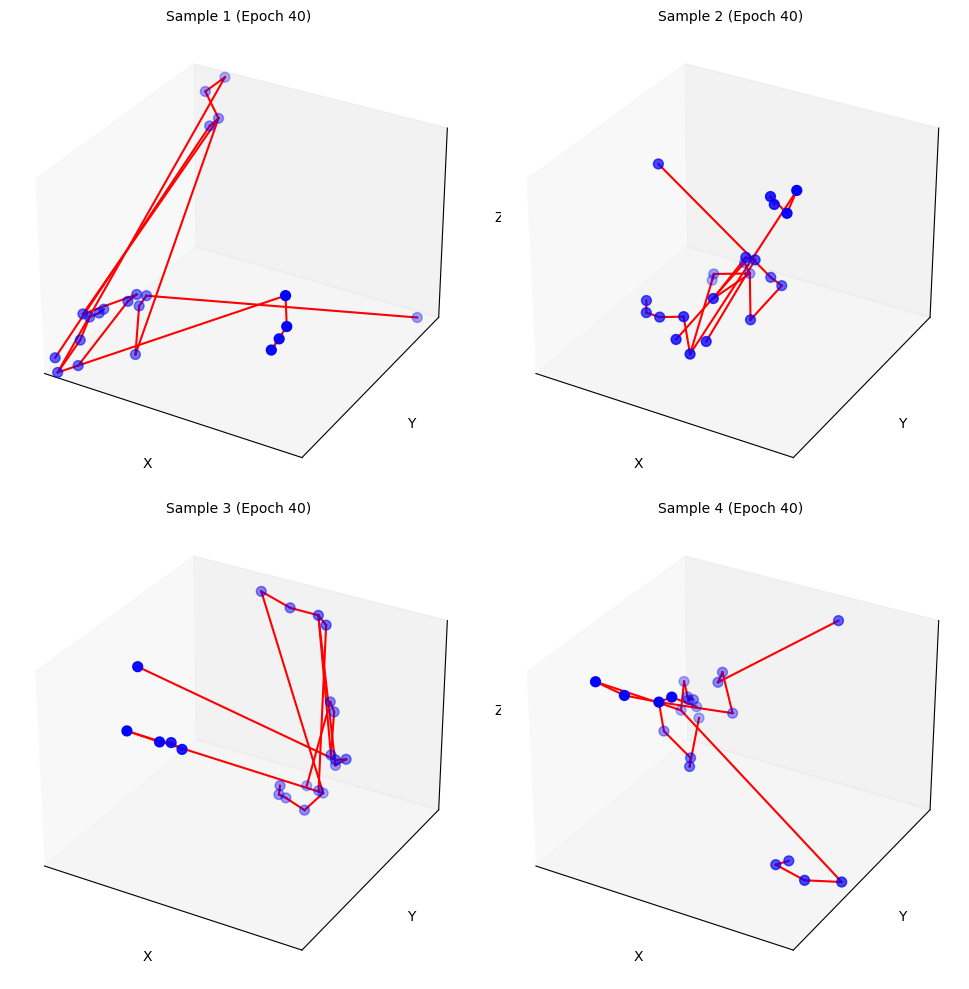

Saved sample grid to: part1_pose_samples/constrained\epoch_040_samples.png


Epoch 40:   2%|█▏                                                        | 2/93 [00:00<00:05, 17.86it/s, loss=5.19e+15]

[Input poses - min: -0.7475, max: 1.0000, mean: 0.1974 | Noisy poses - min: -2.7245, max: 3.1063 | Added noise - min: -3.6544, max: 3.5853 | Predicted noise - min: -1.3516, max: 1.7090]
[Diffusion loss: 0.9549 | Anatomy loss: 51909116473376768.0000 | Total loss: 5190911969460224.0000 | Estimated pose - min: -18547.6797, max: 18192.6133]
--------------------------------------------------


Epoch 40:  53%|██████████████████████████████▌                           | 49/93 [00:02<00:01, 24.20it/s, loss=3.94e+5]

[Input poses - min: -0.5071, max: 1.0000, mean: 0.2012 | Noisy poses - min: -2.7039, max: 3.9847 | Added noise - min: -3.9990, max: 4.1430 | Predicted noise - min: -1.5322, max: 1.2100]
[Diffusion loss: 0.9775 | Anatomy loss: 463722.5625 | Total loss: 46373.2344 | Estimated pose - min: -30.5473, max: 33.6271]
--------------------------------------------------


Epoch 40: 100%|█████████████████████████████████████████████████████████| 93/93 [00:04<00:00, 23.23it/s, loss=6.07e+15]


Epoch 41/60, Loss: 1903756138305197.500000


Epoch 41:   3%|█▉                                                         | 3/93 [00:00<00:03, 26.59it/s, loss=8.6e+14]

[Input poses - min: -0.4727, max: 1.0000, mean: 0.2015 | Noisy poses - min: -3.0880, max: 3.4502 | Added noise - min: -3.7334, max: 3.6913 | Predicted noise - min: -1.2832, max: 0.8564]
[Diffusion loss: 0.9654 | Anatomy loss: 8598863292137472.0000 | Total loss: 859886342635520.0000 | Estimated pose - min: -12174.7334, max: 16085.4785]
--------------------------------------------------


Epoch 41:  54%|██████████████████████████████▋                          | 50/93 [00:02<00:01, 22.20it/s, loss=1.74e+15]

[Input poses - min: -0.9099, max: 1.0000, mean: 0.1973 | Noisy poses - min: -3.2587, max: 3.1685 | Added noise - min: -3.7361, max: 3.6490 | Predicted noise - min: -1.4805, max: 1.5605]
[Diffusion loss: 0.9613 | Anatomy loss: 34327485311090688.0000 | Total loss: 3432748584796160.0000 | Estimated pose - min: -16338.6562, max: 12758.5205]
--------------------------------------------------


Epoch 41: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 24.71it/s, loss=2.13e+15]


Epoch 42/60, Loss: 1196644563004735.250000


Epoch 42:   3%|█▊                                                        | 3/93 [00:00<00:03, 26.66it/s, loss=2.49e+15]

[Input poses - min: -0.5540, max: 1.0000, mean: 0.2021 | Noisy poses - min: -3.6864, max: 3.3183 | Added noise - min: -3.7228, max: 3.7267 | Predicted noise - min: -1.2178, max: 1.4551]
[Diffusion loss: 0.9995 | Anatomy loss: 24939766986309632.0000 | Total loss: 2493976644943872.0000 | Estimated pose - min: -13960.8691, max: 12823.7344]
--------------------------------------------------


Epoch 42:  55%|███████████████████████████████▎                         | 51/93 [00:01<00:01, 29.02it/s, loss=4.56e+15]

[Input poses - min: -0.8551, max: 1.0000, mean: 0.1986 | Noisy poses - min: -3.0360, max: 3.2839 | Added noise - min: -3.5020, max: 3.3907 | Predicted noise - min: -1.6729, max: 0.8750]
[Diffusion loss: 0.9364 | Anatomy loss: 15071000513216512.0000 | Total loss: 1507100131852288.0000 | Estimated pose - min: -10594.9375, max: 14755.6484]
--------------------------------------------------


Epoch 42: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 27.41it/s, loss=1.87e+15]


Epoch 43/60, Loss: 1792038781344934.500000


Epoch 43:   3%|█▉                                                         | 3/93 [00:00<00:03, 25.97it/s, loss=2.18e+6]

[Input poses - min: -0.8997, max: 1.0000, mean: 0.1970 | Noisy poses - min: -3.0344, max: 2.9399 | Added noise - min: -3.9038, max: 3.4348 | Predicted noise - min: -1.6582, max: 0.9165]
[Diffusion loss: 0.9780 | Anatomy loss: 21781682.0000 | Total loss: 2178169.2500 | Estimated pose - min: -77.8052, max: 63.3953]
--------------------------------------------------


Epoch 43:  54%|███████████████████████████████▏                          | 50/93 [00:01<00:01, 29.95it/s, loss=2.68e+6]

[Input poses - min: -0.8187, max: 1.0000, mean: 0.2008 | Noisy poses - min: -4.0195, max: 3.6044 | Added noise - min: -4.0642, max: 3.8261 | Predicted noise - min: -1.4824, max: 1.4053]
[Diffusion loss: 0.9589 | Anatomy loss: 15814306880815104.0000 | Total loss: 1581430714925056.0000 | Estimated pose - min: -12054.4785, max: 15113.6318]
--------------------------------------------------


Epoch 43: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.00it/s, loss=3.65e+15]


Epoch 44/60, Loss: 1699284307341979.500000


Epoch 44:   3%|█▊                                                        | 3/93 [00:00<00:03, 23.38it/s, loss=6.54e+15]

[Input poses - min: -0.6285, max: 1.0000, mean: 0.1990 | Noisy poses - min: -3.0515, max: 2.9365 | Added noise - min: -3.5437, max: 3.6649 | Predicted noise - min: -1.5771, max: 0.9717]
[Diffusion loss: 0.9547 | Anatomy loss: 65432851796983808.0000 | Total loss: 6543285501820928.0000 | Estimated pose - min: -14339.4844, max: 18738.7070]
--------------------------------------------------


Epoch 44:  53%|██████████████████████████████                           | 49/93 [00:01<00:01, 29.41it/s, loss=4.14e+15]

[Input poses - min: -0.7077, max: 1.0000, mean: 0.1999 | Noisy poses - min: -3.7632, max: 3.0060 | Added noise - min: -3.7912, max: 3.3725 | Predicted noise - min: -1.6543, max: 1.4688]
[Diffusion loss: 1.0018 | Anatomy loss: 290128096.0000 | Total loss: 29012812.0000 | Estimated pose - min: -120.2238, max: 137.8490]
--------------------------------------------------


Epoch 44: 100%|██████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 29.24it/s, loss=6.41e+4]


Epoch 45/60, Loss: 1798599890460602.250000


Epoch 45:   3%|█▊                                                        | 3/93 [00:00<00:03, 26.78it/s, loss=1.77e+15]

[Input poses - min: -0.5062, max: 1.0000, mean: 0.2011 | Noisy poses - min: -3.3066, max: 2.7253 | Added noise - min: -3.5043, max: 3.5439 | Predicted noise - min: -1.3516, max: 1.2695]
[Diffusion loss: 0.9407 | Anatomy loss: 17691830359425024.0000 | Total loss: 1769183062786048.0000 | Estimated pose - min: -19476.0273, max: 14995.5645]
--------------------------------------------------


Epoch 45:  54%|███████████████████████████████▏                          | 50/93 [00:01<00:01, 30.69it/s, loss=4.71e+7]

[Input poses - min: -0.5586, max: 1.0000, mean: 0.2007 | Noisy poses - min: -3.3304, max: 3.3223 | Added noise - min: -3.4250, max: 3.5423 | Predicted noise - min: -1.7041, max: 1.7520]
[Diffusion loss: 0.9207 | Anatomy loss: 155980496.0000 | Total loss: 15598051.0000 | Estimated pose - min: -125.3758, max: 140.6282]
--------------------------------------------------


Epoch 45: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 27.88it/s, loss=2.51e+15]


Epoch 46/60, Loss: 1366165040723170.000000


Epoch 46:   3%|█▊                                                        | 3/93 [00:00<00:03, 27.61it/s, loss=7.44e+14]

[Input poses - min: -0.8126, max: 1.0000, mean: 0.1986 | Noisy poses - min: -3.2512, max: 3.2736 | Added noise - min: -3.4218, max: 3.7755 | Predicted noise - min: -1.5381, max: 1.1309]
[Diffusion loss: 0.9901 | Anatomy loss: 7440276536688640.0000 | Total loss: 744027653668864.0000 | Estimated pose - min: -17283.5996, max: 13817.6367]
--------------------------------------------------


Epoch 46:  54%|███████████████████████████████▏                          | 50/93 [00:01<00:01, 25.91it/s, loss=1.99e+7]

[Input poses - min: -0.5004, max: 1.0000, mean: 0.1982 | Noisy poses - min: -2.8446, max: 3.5855 | Added noise - min: -3.9001, max: 3.9763 | Predicted noise - min: -1.4980, max: 0.7266]
[Diffusion loss: 0.9940 | Anatomy loss: 32482308.0000 | Total loss: 3248231.7500 | Estimated pose - min: -66.5253, max: 107.9077]
--------------------------------------------------


Epoch 46: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 27.76it/s, loss=3.72e+15]


Epoch 47/60, Loss: 1587658669043614.250000


Epoch 47:   3%|█▊                                                        | 3/93 [00:00<00:03, 26.29it/s, loss=4.32e+15]

[Input poses - min: -0.8806, max: 1.0000, mean: 0.1990 | Noisy poses - min: -3.2833, max: 2.8936 | Added noise - min: -3.5360, max: 3.7329 | Predicted noise - min: -1.3174, max: 0.7607]
[Diffusion loss: 0.9618 | Anatomy loss: 43237160890925056.0000 | Total loss: 4323716196466688.0000 | Estimated pose - min: -16048.6182, max: 17658.2051]
--------------------------------------------------


Epoch 47:  55%|███████████████████████████████▎                         | 51/93 [00:01<00:01, 29.30it/s, loss=2.75e+15]

[Input poses - min: -0.4938, max: 1.0000, mean: 0.2017 | Noisy poses - min: -3.2958, max: 3.1507 | Added noise - min: -3.6087, max: 3.2122 | Predicted noise - min: -1.1943, max: 1.3828]
[Diffusion loss: 0.9799 | Anatomy loss: 12720435779076096.0000 | Total loss: 1272043551064064.0000 | Estimated pose - min: -13780.8291, max: 17449.3242]
--------------------------------------------------


Epoch 47: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 29.73it/s, loss=8.13e+15]


Epoch 48/60, Loss: 1928752059742306.500000


Epoch 48:   4%|██▍                                                       | 4/93 [00:00<00:02, 30.74it/s, loss=1.67e+15]

[Input poses - min: -0.4285, max: 1.0000, mean: 0.2049 | Noisy poses - min: -3.3023, max: 3.1235 | Added noise - min: -3.5438, max: 3.2361 | Predicted noise - min: -1.1826, max: 1.3037]
[Diffusion loss: 0.9502 | Anatomy loss: 16731387625209856.0000 | Total loss: 1673138735677440.0000 | Estimated pose - min: -10726.6875, max: 15201.3867]
--------------------------------------------------


Epoch 48:  55%|███████████████████████████████▊                          | 51/93 [00:01<00:01, 28.77it/s, loss=2.98e+6]

[Input poses - min: -0.4871, max: 1.0000, mean: 0.2031 | Noisy poses - min: -4.0177, max: 3.2462 | Added noise - min: -4.0233, max: 3.2514 | Predicted noise - min: -1.1211, max: 0.9302]
[Diffusion loss: 0.9595 | Anatomy loss: 528144000.0000 | Total loss: 52814400.0000 | Estimated pose - min: -213.4894, max: 157.0264]
--------------------------------------------------


Epoch 48: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 30.06it/s, loss=4.41e+15]


Epoch 49/60, Loss: 1457750411151828.000000


Epoch 49:   3%|█▊                                                        | 3/93 [00:00<00:03, 27.32it/s, loss=3.03e+15]

[Input poses - min: -0.7749, max: 1.0000, mean: 0.2015 | Noisy poses - min: -2.8356, max: 3.6069 | Added noise - min: -3.1640, max: 3.6120 | Predicted noise - min: -1.1436, max: 1.2588]
[Diffusion loss: 0.9706 | Anatomy loss: 30319406798077952.0000 | Total loss: 3031940626120704.0000 | Estimated pose - min: -14263.3486, max: 19006.7598]
--------------------------------------------------


Epoch 49:  54%|████████████████████████████████▊                            | 50/93 [00:01<00:01, 29.13it/s, loss=5e+7]

[Input poses - min: -0.8551, max: 1.0000, mean: 0.2009 | Noisy poses - min: -3.2480, max: 3.7795 | Added noise - min: -3.3946, max: 3.7519 | Predicted noise - min: -1.3936, max: 0.8540]
[Diffusion loss: 0.9770 | Anatomy loss: 956663552.0000 | Total loss: 95666360.0000 | Estimated pose - min: -160.5153, max: 181.1721]
--------------------------------------------------


Epoch 49: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 29.45it/s, loss=3.91e+15]


Epoch 50/60, Loss: 1683302894821053.500000


Epoch 50:   4%|██▍                                                       | 4/93 [00:00<00:02, 31.48it/s, loss=2.01e+15]

[Input poses - min: -0.6004, max: 1.0000, mean: 0.2039 | Noisy poses - min: -3.7028, max: 3.1168 | Added noise - min: -3.7535, max: 3.6042 | Predicted noise - min: -1.2715, max: 1.0156]
[Diffusion loss: 0.9615 | Anatomy loss: 20128243973619712.0000 | Total loss: 2012824477892608.0000 | Estimated pose - min: -11384.9258, max: 17760.3203]
--------------------------------------------------


Epoch 50:  56%|███████████████████████████████▊                         | 52/93 [00:01<00:01, 29.30it/s, loss=3.21e+15]

[Input poses - min: -0.4722, max: 1.0000, mean: 0.2015 | Noisy poses - min: -2.7726, max: 3.4900 | Added noise - min: -3.1201, max: 3.4086 | Predicted noise - min: -0.9282, max: 1.6904]
[Diffusion loss: 0.9706 | Anatomy loss: 210692848.0000 | Total loss: 21069286.0000 | Estimated pose - min: -144.0071, max: 217.6595]
--------------------------------------------------


Epoch 50: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 30.28it/s, loss=4.13e+15]


Epoch 51/60, Loss: 1646598879632081.500000


Epoch 51:   4%|██▌                                                        | 4/93 [00:00<00:02, 31.30it/s, loss=4.56e+6]

[Input poses - min: -0.8184, max: 1.0000, mean: 0.2009 | Noisy poses - min: -2.8512, max: 3.6364 | Added noise - min: -3.8154, max: 4.6519 | Predicted noise - min: -1.1270, max: 0.9092]
[Diffusion loss: 0.9701 | Anatomy loss: 45551740.0000 | Total loss: 4555175.0000 | Estimated pose - min: -75.4301, max: 79.7874]
--------------------------------------------------


Epoch 51:  55%|███████████████████████████████▊                          | 51/93 [00:01<00:01, 29.10it/s, loss=7.62e+7]

[Input poses - min: -0.9166, max: 1.0000, mean: 0.1983 | Noisy poses - min: -3.0715, max: 3.9126 | Added noise - min: -3.3055, max: 3.9460 | Predicted noise - min: -1.3057, max: 1.0635]
[Diffusion loss: 0.9855 | Anatomy loss: 280069792.0000 | Total loss: 28006980.0000 | Estimated pose - min: -130.2122, max: 131.7202]
--------------------------------------------------


Epoch 51: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.93it/s, loss=4.46e+15]


Epoch 52/60, Loss: 1761392744586842.500000


Epoch 52:   3%|█▊                                                        | 3/93 [00:00<00:03, 29.97it/s, loss=2.74e+15]

[Input poses - min: -0.4771, max: 1.0000, mean: 0.2005 | Noisy poses - min: -3.0719, max: 3.2536 | Added noise - min: -3.9404, max: 3.3721 | Predicted noise - min: -1.4766, max: 1.1621]
[Diffusion loss: 0.9416 | Anatomy loss: 27424830768807936.0000 | Total loss: 2742483184254976.0000 | Estimated pose - min: -11525.5713, max: 16297.2979]
--------------------------------------------------


Epoch 52:  54%|██████████████████████████████▋                          | 50/93 [00:01<00:01, 29.65it/s, loss=3.09e+15]

[Input poses - min: -0.5586, max: 1.0000, mean: 0.2023 | Noisy poses - min: -3.0145, max: 3.0574 | Added noise - min: -3.3839, max: 3.4388 | Predicted noise - min: -1.6299, max: 1.3027]
[Diffusion loss: 0.9818 | Anatomy loss: 10053593.0000 | Total loss: 1005360.3125 | Estimated pose - min: -59.1670, max: 50.2379]
--------------------------------------------------


Epoch 52: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 30.17it/s, loss=1.81e+15]


Epoch 53/60, Loss: 1539601220368114.500000


Epoch 53:   3%|█▉                                                         | 3/93 [00:00<00:03, 28.89it/s, loss=2.09e+7]

[Input poses - min: -0.7486, max: 1.0000, mean: 0.2025 | Noisy poses - min: -2.9192, max: 3.4161 | Added noise - min: -3.6221, max: 4.1446 | Predicted noise - min: -1.2441, max: 1.1172]
[Diffusion loss: 0.9229 | Anatomy loss: 209225056.0000 | Total loss: 20922506.0000 | Estimated pose - min: -146.1253, max: 130.2578]
--------------------------------------------------


Epoch 53:  54%|██████████████████████████████▋                          | 50/93 [00:01<00:01, 27.37it/s, loss=3.65e+15]

[Input poses - min: -0.4261, max: 1.0000, mean: 0.1993 | Noisy poses - min: -2.7823, max: 3.5570 | Added noise - min: -3.7315, max: 3.6439 | Predicted noise - min: -1.2822, max: 0.8574]
[Diffusion loss: 0.9701 | Anatomy loss: 18931004659990528.0000 | Total loss: 1893100519686144.0000 | Estimated pose - min: -11496.5244, max: 21695.0762]
--------------------------------------------------


Epoch 53: 100%|██████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.97it/s, loss=2.72e+6]


Epoch 54/60, Loss: 1232734639618568.500000


Epoch 54:   3%|█▊                                                        | 3/93 [00:00<00:03, 28.42it/s, loss=2.47e+15]

[Input poses - min: -0.9405, max: 1.0000, mean: 0.1970 | Noisy poses - min: -2.8021, max: 3.0337 | Added noise - min: -3.3970, max: 3.4644 | Predicted noise - min: -1.2422, max: 1.2148]
[Diffusion loss: 0.9755 | Anatomy loss: 24709039195684864.0000 | Total loss: 2470904080629760.0000 | Estimated pose - min: -12761.0215, max: 13845.7354]
--------------------------------------------------


Epoch 54:  53%|██████████████████████████████                           | 49/93 [00:01<00:01, 29.49it/s, loss=2.77e+15]

[Input poses - min: -0.9615, max: 1.0000, mean: 0.1950 | Noisy poses - min: -3.9227, max: 3.1549 | Added noise - min: -3.9361, max: 3.6639 | Predicted noise - min: -1.1465, max: 1.3955]
[Diffusion loss: 0.9683 | Anatomy loss: 21165318.0000 | Total loss: 2116532.7500 | Estimated pose - min: -78.9708, max: 85.6284]
--------------------------------------------------


Epoch 54: 100%|██████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 29.09it/s, loss=1.18e+5]


Epoch 55/60, Loss: 1400375079494074.250000


Epoch 55:   3%|█▉                                                         | 3/93 [00:00<00:03, 25.27it/s, loss=2.17e+5]

[Input poses - min: -0.6004, max: 1.0000, mean: 0.1993 | Noisy poses - min: -3.2424, max: 3.4482 | Added noise - min: -3.3283, max: 4.3875 | Predicted noise - min: -1.9092, max: 0.9565]
[Diffusion loss: 0.9323 | Anatomy loss: 2173421.0000 | Total loss: 217343.0469 | Estimated pose - min: -50.5487, max: 55.4921]
--------------------------------------------------


Epoch 55:  55%|███████████████████████████████▊                          | 51/93 [00:01<00:01, 32.01it/s, loss=2.08e+7]

[Input poses - min: -0.6608, max: 1.0000, mean: 0.2022 | Noisy poses - min: -3.0362, max: 3.2815 | Added noise - min: -3.6633, max: 3.5407 | Predicted noise - min: -1.3438, max: 1.6260]
[Diffusion loss: 0.9582 | Anatomy loss: 153485296.0000 | Total loss: 15348531.0000 | Estimated pose - min: -118.9119, max: 196.7438]
--------------------------------------------------


Epoch 55: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 29.37it/s, loss=1.81e+15]


Epoch 56/60, Loss: 1679667898592196.750000


Epoch 56:   3%|█▊                                                        | 3/93 [00:00<00:03, 24.66it/s, loss=1.64e+15]

[Input poses - min: -0.4344, max: 1.0000, mean: 0.1974 | Noisy poses - min: -3.3274, max: 3.8611 | Added noise - min: -3.3859, max: 3.9014 | Predicted noise - min: -1.2861, max: 0.9023]
[Diffusion loss: 0.9432 | Anatomy loss: 16361531885223936.0000 | Total loss: 1636153161678848.0000 | Estimated pose - min: -12668.9453, max: 14473.0312]
--------------------------------------------------


Epoch 56:  54%|██████████████████████████████▋                          | 50/93 [00:01<00:01, 29.51it/s, loss=2.75e+15]

[Input poses - min: -0.8667, max: 1.0000, mean: 0.1974 | Noisy poses - min: -2.9717, max: 3.0428 | Added noise - min: -3.5331, max: 3.2263 | Predicted noise - min: -1.4873, max: 1.7070]
[Diffusion loss: 1.0031 | Anatomy loss: 979187.8750 | Total loss: 97919.7891 | Estimated pose - min: -29.0988, max: 39.5855]
--------------------------------------------------


Epoch 56: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 29.55it/s, loss=4.95e+15]


Epoch 57/60, Loss: 1309292864890886.250000


Epoch 57:   3%|█▉                                                         | 3/93 [00:00<00:03, 29.53it/s, loss=5.74e+7]

[Input poses - min: -0.4776, max: 1.0000, mean: 0.2052 | Noisy poses - min: -3.4748, max: 3.0484 | Added noise - min: -3.4752, max: 3.3770 | Predicted noise - min: -1.3301, max: 1.4697]
[Diffusion loss: 0.9455 | Anatomy loss: 573691712.0000 | Total loss: 57369172.0000 | Estimated pose - min: -219.3278, max: 150.4492]
--------------------------------------------------


Epoch 57:  55%|███████████████████████████████▊                          | 51/93 [00:01<00:01, 27.83it/s, loss=4.86e+7]

[Input poses - min: -0.5311, max: 1.0000, mean: 0.2034 | Noisy poses - min: -3.2529, max: 3.2323 | Added noise - min: -3.5001, max: 3.5093 | Predicted noise - min: -1.4258, max: 0.8433]
[Diffusion loss: 0.9761 | Anatomy loss: 57995063656972288.0000 | Total loss: 5799506687819776.0000 | Estimated pose - min: -15785.8896, max: 21681.0762]
--------------------------------------------------


Epoch 57: 100%|██████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.68it/s, loss=3.1e+15]


Epoch 58/60, Loss: 1762265775805318.250000


Epoch 58:   3%|█▉                                                         | 3/93 [00:00<00:03, 24.54it/s, loss=4.51e+7]

[Input poses - min: -0.5257, max: 1.0000, mean: 0.1986 | Noisy poses - min: -3.5364, max: 3.4368 | Added noise - min: -3.6130, max: 3.6163 | Predicted noise - min: -1.4043, max: 1.4365]
[Diffusion loss: 0.9526 | Anatomy loss: 450574080.0000 | Total loss: 45057408.0000 | Estimated pose - min: -185.0089, max: 167.9642]
--------------------------------------------------


Epoch 58:  53%|██████████████████████████████▌                           | 49/93 [00:01<00:01, 30.42it/s, loss=2.72e+6]

[Input poses - min: -0.8806, max: 1.0000, mean: 0.2034 | Noisy poses - min: -2.7500, max: 3.5972 | Added noise - min: -3.2785, max: 3.4928 | Predicted noise - min: -1.3945, max: 1.6396]
[Diffusion loss: 0.9493 | Anatomy loss: 43668663370252288.0000 | Total loss: 4366866390712320.0000 | Estimated pose - min: -14365.4355, max: 16007.5303]
--------------------------------------------------


Epoch 58: 100%|█████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.33it/s, loss=9.28e+14]


Epoch 59/60, Loss: 1588176828950261.000000


Epoch 59:   6%|███▋                                                      | 6/93 [00:00<00:02, 29.69it/s, loss=1.31e+15]

[Input poses - min: -0.7889, max: 1.0000, mean: 0.1961 | Noisy poses - min: -3.7309, max: 3.1684 | Added noise - min: -3.7418, max: 3.5835 | Predicted noise - min: -1.3379, max: 0.8286]
[Diffusion loss: 0.9616 | Anatomy loss: 13102683573452800.0000 | Total loss: 1310268357345280.0000 | Estimated pose - min: -14507.7695, max: 11778.4766]
--------------------------------------------------


Epoch 59:  54%|███████████████████████████████▏                          | 50/93 [00:01<00:01, 28.84it/s, loss=4.46e+7]

[Input poses - min: -0.6503, max: 1.0000, mean: 0.2006 | Noisy poses - min: -3.2179, max: 3.4502 | Added noise - min: -3.6925, max: 3.8035 | Predicted noise - min: -1.4658, max: 1.0293]
[Diffusion loss: 0.9647 | Anatomy loss: 220210448.0000 | Total loss: 22021046.0000 | Estimated pose - min: -149.0648, max: 196.2028]
--------------------------------------------------


Epoch 59: 100%|███████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.46it/s, loss=4.4e+7]


Epoch 60/60, Loss: 1519365633050029.000000
Checkpoint saved to part1_unconditioned_diffusion_checkpoints/final_model.pt
Saved final model to part1_unconditioned_diffusion_checkpoints/final_model.pt
Generating sample poses at epoch 60...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 197.35it/s]


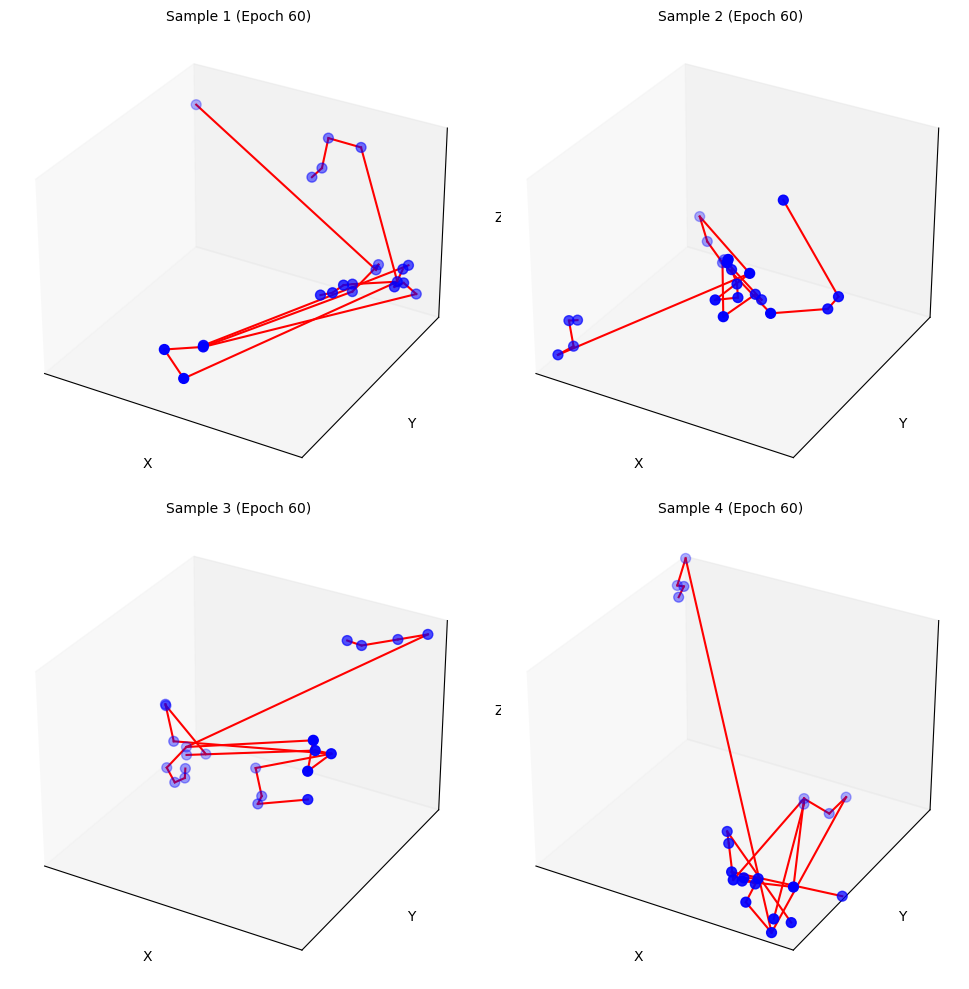

Saved sample grid to: part1_pose_samples/constrained\epoch_060_samples.png


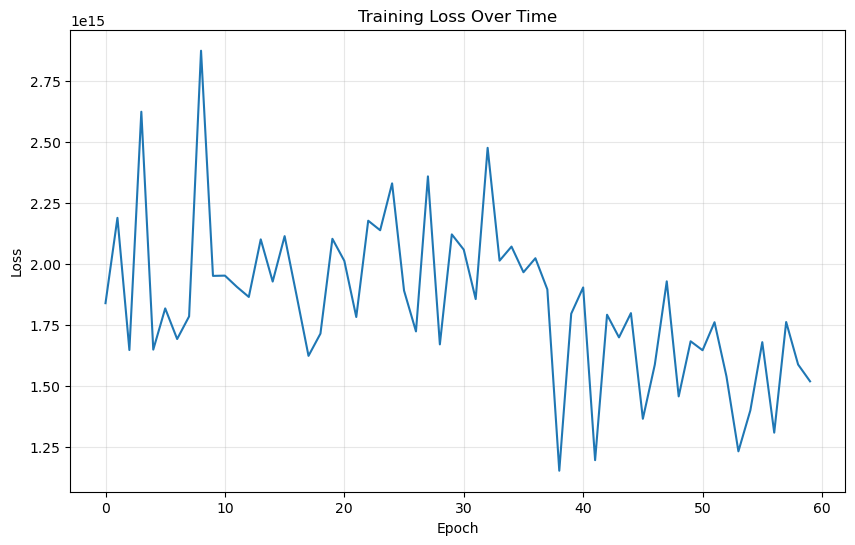

Training complete!


In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import matplotlib.pyplot as plt
import os

from mpl_toolkits.mplot3d import Axes3D  
from torch.nn.utils import clip_grad_norm_




# this should be a global helper.
def to_device(obj, device):
    """Move all tensors in an object to the specified device."""
    for key in dir(obj):
        if key.startswith('__'):
            continue
        attr = getattr(obj, key)
        if isinstance(attr, torch.Tensor):
            setattr(obj, key, attr.to(device))
    return obj

## ---------------------------------------------------------------------------------------------------------------------------


class NoiseScheduler:
    def __init__(self, timesteps=100, beta_start=1e-4, beta_end=0.02, schedule_type='linear'):
        """
        Initialize the noise scheduler with a specific beta schedule.
        
        Args:
            timesteps: Total number of diffusion steps
            beta_start: Starting noise level
            beta_end: Ending noise level
            schedule_type: 'linear', 'cosine', or 'quadratic'
        """
        self.timesteps = timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.schedule_type = schedule_type
        
        # Create the noise schedule
        if schedule_type == 'linear':
            self.betas = torch.linspace(beta_start, beta_end, timesteps)
        elif schedule_type == 'cosine':
            s = 0.008
            steps = timesteps + 1
            x = torch.linspace(0, timesteps, steps)
            alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
            alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
            betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
            self.betas = torch.clip(betas, 0.0001, 0.9999)
        elif schedule_type == 'quadratic':
            self.betas = torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2
        else:
            raise ValueError(f"Unknown schedule type: {schedule_type}")
        
        # Pre-compute diffusion values
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        
        # Calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)
        
        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
        )
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1.0 - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1.0 - self.alphas_cumprod)

    def to(self, device):
        """Move all tensors to the specified device."""
        return to_device(self, device)

    
    
    def sample_timesteps(self, batch_size, device):
        """Sample random timesteps for a batch"""
        return torch.randint(0, self.timesteps, (batch_size,), device=device, dtype=torch.long)
    




    def add_noise(self, x_start, t, noise=None):
        """
        Add noise to samples at specified timesteps.
        """
        if noise is None:
            noise = torch.randn_like(x_start)
        
        device = x_start.device
        t = t.to(device)
        
        # values for timestep t
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod.to(device)[t]
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod.to(device)[t]
        
        # reshape, follow later -> broadcasting
        while len(sqrt_alphas_cumprod_t.shape) < len(x_start.shape):
            sqrt_alphas_cumprod_t = sqrt_alphas_cumprod_t.unsqueeze(-1)
            sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod_t.unsqueeze(-1)
        
        # add noise according to the diffusion SDE
        x_noisy = sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
        return x_noisy, noise
    
    def predict_start_from_noise(self, x_t, t, noise):
        """Predict x_0 from x_t and predicted noise"""
        device = x_t.device
        t = t.to(device)
        
        sqrt_recip_alphas_cumprod_t = self.sqrt_recip_alphas_cumprod.to(device)[t]
        sqrt_recipm1_alphas_cumprod_t = self.sqrt_recipm1_alphas_cumprod.to(device)[t]
        
        while len(sqrt_recip_alphas_cumprod_t.shape) < len(x_t.shape):
            sqrt_recip_alphas_cumprod_t = sqrt_recip_alphas_cumprod_t.unsqueeze(-1)
            sqrt_recipm1_alphas_cumprod_t = sqrt_recipm1_alphas_cumprod_t.unsqueeze(-1)
        
        return sqrt_recip_alphas_cumprod_t * x_t - sqrt_recipm1_alphas_cumprod_t * noise


        
    def q_posterior_mean_variance(self, x_start, x_t, t):
        """
        Compute the mean and variance of the diffusion posterior q(x_{t-1} | x_t, x_0)
        """
        device = x_start.device
        t = t.to(device)
        
        posterior_mean_coef1_t = self.posterior_mean_coef1.to(device)[t]
        posterior_mean_coef2_t = self.posterior_mean_coef2.to(device)[t]
        
        # Reshape for proper broadcasting
        while len(posterior_mean_coef1_t.shape) < len(x_start.shape):
            posterior_mean_coef1_t = posterior_mean_coef1_t.unsqueeze(-1)
            posterior_mean_coef2_t = posterior_mean_coef2_t.unsqueeze(-1)
        
        posterior_mean = posterior_mean_coef1_t * x_start + posterior_mean_coef2_t * x_t
        posterior_variance = self.posterior_variance.to(device)[t]
        posterior_log_variance_clipped = self.posterior_log_variance_clipped.to(device)[t]
        
        while len(posterior_variance.shape) < len(x_start.shape):
            posterior_variance = posterior_variance.unsqueeze(-1)
            posterior_log_variance_clipped = posterior_log_variance_clipped.unsqueeze(-1)
            
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    
        
    def p_mean_variance(self, model, x_t, t, clip_denoised=True, model_kwargs=None):
        """Apply the model to get p(x_{t-1} | x_t)"""
        if model_kwargs is None:
            model_kwargs = {}
        
        # Ensure t is on the same device as x_t
        t = t.to(x_t.device)
        
        # Get model prediction (predicted noise)
        pred_noise = model(x_t, t, **model_kwargs)
        
        # Convert to x_0 prediction
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        
        if clip_denoised:
            x_recon = torch.clamp(x_recon, -1.0, 1.0)
        
        # Get the posterior mean and variance
        model_mean, posterior_variance, posterior_log_variance = self.q_posterior_mean_variance(x_recon, x_t, t)
        
        return model_mean, posterior_variance, posterior_log_variance, x_recon
    
    def p_sample(self, model, x_t, t, clip_denoised=True, model_kwargs=None):
        """Sample from p(x_{t-1} | x_t) using the model"""
        model_mean, _, posterior_log_variance, x_recon = self.p_mean_variance(
            model, x_t, t, clip_denoised=clip_denoised, model_kwargs=model_kwargs
        )
        
        noise = torch.randn_like(x_t)
        # No noise when t == 0
        nonzero_mask = (t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))).to(x_t.device)
        
        # Sample from the posterior
        return model_mean + nonzero_mask * torch.exp(0.5 * posterior_log_variance) * noise


    
    def sample(self, model, shape, device, model_kwargs=None, progress=True, clip_denoised=True):
        """
        Generate samples from the model using the diffusion process
        """
        if model_kwargs is None:
            model_kwargs = {}
            
        # Start with pure noise
        x_t = torch.randn(shape, device=device)
        
        # Progressively denoise
        timesteps = list(range(self.timesteps))[::-1]
        if progress:
            timesteps = tqdm(timesteps)
            
        for t in timesteps:
            t_batch = torch.full((shape[0],), t, device=device, dtype=torch.long)
            x_t = self.p_sample(
                model, x_t, t_batch, clip_denoised=clip_denoised, model_kwargs=model_kwargs
            )
            
        return x_t
    
    def visualize_noise_schedule(self):
        """Visualize the noise schedule and related parameters"""
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 2, 1)
        plt.plot(self.betas.cpu().numpy())
        plt.title('Beta Schedule')
        plt.xlabel('Timestep')
        plt.ylabel('Beta Value')
        
        plt.subplot(2, 2, 2)
        plt.plot(self.alphas_cumprod.cpu().numpy())
        plt.title('Cumulative Product of Alphas')
        plt.xlabel('Timestep')
        plt.ylabel('Alpha Cumprod')
        
        plt.subplot(2, 2, 3)
        plt.plot(self.sqrt_alphas_cumprod.cpu().numpy())
        plt.title('Sqrt Alpha Cumprod')
        plt.xlabel('Timestep')
        plt.ylabel('Value')
        
        plt.subplot(2, 2, 4)
        plt.plot(self.sqrt_one_minus_alphas_cumprod.cpu().numpy())
        plt.title('Sqrt (1 - Alpha Cumprod)')
        plt.xlabel('Timestep')
        plt.ylabel('Value')
        
        plt.tight_layout()
        plt.show()






## ---------------------------------------------------------------------------------------------------------------------------------------------------------
## ---------------------------------------------------------------------------------------------------------------------------------------------------------

        
## ---------------------------------------------------------------------------------------------------------------------------------------------------------
## ---------------------------------------------------------------------------------------------------------------------------------------------------------



import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class ResidualBlock(nn.Module):
    """
    Residual block with time conditioning for the U-Net architecture.
    
    Performs:
    1. First linear projection with activation
    2. Time embedding injection
    3. Second linear projection with dropout
    4. Residual connection
    """
    def __init__(self, in_channels, out_channels, time_dim, dropout=0.1):
        super().__init__()
        
        # First projection
        self.conv1 = nn.Linear(in_channels, out_channels)
        
        # Time embedding projection
        self.time_mlp = nn.Linear(time_dim, out_channels)
        
        # Second projection
        self.conv2 = nn.Linear(out_channels, out_channels)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Residual connection if dimensions differ
        self.residual = (nn.Identity() if in_channels == out_channels 
                         else nn.Linear(in_channels, out_channels))
        
        # Activation function
        self.act = nn.SiLU()
        
    def forward(self, x, time_emb):
        """
        Forward pass of the residual block
        
        Args:
            x: Input tensor [batch_size, in_channels]
            time_emb: Time embeddings [batch_size, time_dim]
            
        Returns:
            Output tensor [batch_size, out_channels]
        """
        # First projection with activation
        h = self.act(self.conv1(x))
        
        # Process time embedding and ensure proper shape
        batch_size = x.shape[0]
        time_emb = self.time_mlp(time_emb).view(batch_size, -1)
        
        # Ensure time embedding has the right shape for broadcasting
        while len(time_emb.shape) < len(h.shape):
            time_emb = time_emb.unsqueeze(-1)
            
        # Add time embedding
        h = h + time_emb
        
        # Second projection with dropout
        h = self.act(self.conv2(h))
        h = self.dropout(h)
        
        # Residual connection
        return h + self.residual(x)




class UNetModel(nn.Module):
    """
    U-Net model for diffusion on pose data.
    
    Architecture:
    1. Initial projection from pose to features
    2. Downsampling path with skip connections
    3. Middle/Bottleneck blocks
    4. Upsampling path with skip connections
    5. Final projection to pose space
    """
    def __init__(self, 
                 pose_dim=66, 
                 base_channels=96, 
                 time_emb_dim=256, 
                 channel_mults=(1, 2, 4, 4),
                 num_res_blocks=2, 
                 dropout=0.1):
        super().__init__()
        
        # Store config parameters
        self.pose_dim = pose_dim
        self.base_channels = base_channels
        self.time_dim = time_emb_dim
        self.channel_mults = channel_mults
        self.num_res_blocks = num_res_blocks
        self.dropout = dropout
        
        # Create time embedding module
        self.time_embedding = self._create_time_embedding(time_emb_dim)
        
        # Create the core U-Net architecture
        self.input_proj = nn.Linear(pose_dim, base_channels)
        self.down_blocks = self._create_down_blocks()
        self.mid_blocks = self._create_mid_blocks()
        self.up_blocks = self._create_up_blocks()
        self.final_proj = self._create_final_projection()
        
        # Print network summary
        self._print_network_summary()
    
    def _create_time_embedding(self, dim):
        """Create the time embedding module"""
        return TimeEmbedding(dim)
    
    def _create_down_blocks(self):
        """Create downsampling blocks for the U-Net"""
        blocks = nn.ModuleList()
        channels = self.base_channels
        
        # Track channels for each level to use in upsampling
        self.down_channels = []
        
        # Create blocks for each level in the downsampling path
        for level, mult in enumerate(self.channel_mults):
            out_channels = self.base_channels * mult
            
            # Add residual blocks for this level
            for _ in range(self.num_res_blocks):
                blocks.append(ResidualBlock(channels, out_channels, self.time_dim, self.dropout))
                channels = out_channels
            
            # Save channel count for skip connections
            self.down_channels.append(channels)
            
            # Add downsampling except for the last level
            if level < len(self.channel_mults) - 1:
                # Linear projection for "downsampling" in pose space
                blocks.append(nn.Linear(channels, channels))
                
        return blocks
    
    def _create_mid_blocks(self):
        """Create middle/bottleneck blocks for the U-Net"""
        blocks = nn.ModuleList()
        channels = self.base_channels * self.channel_mults[-1]
        
        # Add middle blocks
        for _ in range(self.num_res_blocks):
            blocks.append(ResidualBlock(channels, channels, self.time_dim, self.dropout))
            
        return blocks
    
    def _create_up_blocks(self):
        """Create upsampling blocks with skip connections"""
        blocks = nn.ModuleList()
        channels = self.base_channels * self.channel_mults[-1]  # Start with bottleneck channels
        
        # Process levels in reverse order (bottleneck to output)
        for level, mult in reversed(list(enumerate(self.channel_mults))):
            out_channels = self.base_channels * mult
            
            # Add residual blocks with skip connections
            for i in range(self.num_res_blocks):
                # Only use skip connection in first block of each level
                skip_channels = self.down_channels[level] if i == 0 else 0
                in_channels = channels + skip_channels
                
                # Create block with the correct input dimension (including skip connection)
                blocks.append(ResidualBlock(in_channels, out_channels, self.time_dim, self.dropout))
                channels = out_channels  # Update channel count for next block
            
            # Add upsampling except for the first level (last in reversed order)
            if level > 0:
                blocks.append(nn.Linear(channels, channels))
                
        return blocks
    
    def _create_final_projection(self):
        """Create final projection to pose space"""
        channels = self.base_channels * self.channel_mults[0]  # Should be base_channels
        
        return nn.Sequential(
            nn.Linear(channels, channels),
            nn.SiLU(),
            nn.Dropout(self.dropout),
            nn.Linear(channels, self.pose_dim)
        )
    
    def _print_network_summary(self):
        """Print a summary of the network architecture"""
        print("\nU-Net Architecture Summary:")
        print(f"Pose dimension: {self.pose_dim}")
        print(f"Base channels: {self.base_channels}")
        print(f"Channel multipliers: {self.channel_mults}")
        print(f"Residual blocks per level: {self.num_res_blocks}")
        
        # Print channel dimensions at each level
        print("\nChannel dimensions:")
        print(f"Input projection: {self.pose_dim} → {self.base_channels}")
        
        channels = self.base_channels
        for level, mult in enumerate(self.channel_mults):
            out_channels = self.base_channels * mult
            print(f"Down level {level+1}: {channels} → {out_channels}")
            channels = out_channels
            
        print(f"Bottleneck: {channels}")
        
        # Print upsampling path with correct dimensions including skip connections
        for level, mult in reversed(list(enumerate(self.channel_mults))):
            out_channels = self.base_channels * mult
            skip_channels = self.down_channels[level]
            print(f"Up level {level+1}: {channels}+{skip_channels} → {out_channels}")
            channels = out_channels
            
        print(f"Output projection: {channels} → {self.pose_dim}")
        print(f"Total levels: {len(self.channel_mults)}\n")
        
        
    def forward(self, x, t, cond=None):
        """Forward pass of the U-Net model with proper skip connection handling"""
        # Ensure t is on the same device as x
        t = t.to(x.device)
        
        # Get time embedding
        time_emb = self.time_embedding(t)
        
        # Initial projection from pose to features
        h = self.input_proj(x)
        
        # Store skip connections
        skips = []
        
        # Downsampling path
        for block in self.down_blocks:
            if isinstance(block, ResidualBlock):
                h = block(h, time_emb)
                skips.append(h)  # Save output for skip connection
            else:
                h = block(h)  # Downsampling layer
        
        # Middle/Bottleneck blocks
        for block in self.mid_blocks:
            h = block(h, time_emb)
        
        # Upsampling path with skip connections
        skip_index = len(skips) - 1  # Start from the last skip connection
        blocks_per_level = self.num_res_blocks
        current_block_in_level = 0
        
        for block in self.up_blocks:
            if isinstance(block, ResidualBlock):
                # Only use skip connection for the first block of each level
                if current_block_in_level == 0 and skip_index >= 0:
                    skip = skips[skip_index]
                    h = torch.cat([h, skip], dim=1)  # Concatenate along feature dimension
                    skip_index -= blocks_per_level  # Jump to the previous level's skip
                
                h = block(h, time_emb)
                
                # Track position within current level
                current_block_in_level += 1
                if current_block_in_level >= blocks_per_level:
                    current_block_in_level = 0  # Reset for next level
                    
            else:
                h = block(h)  # Upsampling layer
        
        # Final projection to predicted noise
        return self.final_proj(h)

    
        



class TimeEmbedding(nn.Module):
    """
    Creates sinusoidal time embeddings similar to position embeddings in Transformers.
    
    The embeddings follow the pattern:
    1. Calculate sinusoidal embeddings with varying frequencies
    2. Project to higher dimension with non-linearity
    
    Args:
        dim: The dimensionality of the output embeddings
        max_period: Controls the minimum frequency of the embeddings
    """
    def __init__(self, dim, max_period=10000):
        super().__init__()
        self.dim = dim
        self.max_period = max_period
        
        # Projection to higher dimension with non-linearity
        self.mlp = nn.Sequential(
            nn.Linear(dim // 4, dim),
            nn.SiLU(),
            nn.Linear(dim, dim)
        )
        
    def forward(self, t):
        """
        Args:
            t: A 1-D tensor of timeindices [batch_size]
        
        Returns:
            Time embeddings of shape [batch_size, dim]
        """
        # Make sure t is a PyTorch tensor on the right device
        if not isinstance(t, torch.Tensor):
            t = torch.tensor(t, device=self.mlp[0].weight.device)
        else:
            t = t.to(self.mlp[0].weight.device)
            
        # Create sinusoidal position embeddings
        half_dim = self.dim // 8
        emb = math.log(self.max_period) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t.unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        
        # Project to final embedding dimension
        emb = self.mlp(emb)
        
        return emb


## -------------------------------------------------------------------------------------------------------------------------------------------------------------

## quality difference is negligible for diffusion models, with possibly 0.1-0.5% degradation in some metrics.
## worth it. for mixfp.

## !! pure diffusion models can struggle with highly structured data without some guidance.
## Post-Generation Correction: While your model is learning to generate poses, it may still produce anatomically impossible results. 
## This function corrects those issues after generation.
## function is called at the end of your generation process, right after the diffusion sampling completes and before visualization or any downstream use of the poses.
## ----------------------------------------------------------------------------------------------------------------------------------------------------------------------



class DiffusionTrainer:
    
    def __init__(self, model, noise_scheduler, optimizer, device, use_amp=True):
        """
        Trainer for diffusion models
        
        Args:
            model: The U-Net model
            noise_scheduler: The noise scheduler
            optimizer: PyTorch optimizer
            device: Device to train on
            use_amp: Whether to use automatic mixed precision (faster training)
        """
        self.model = model.to(device)
        self.noise_scheduler = noise_scheduler.to(device)
        self.optimizer = optimizer
        self.device = device
        self.use_amp = use_amp and torch.cuda.is_available()  # Only use if CUDA available
        
        # Create GradScaler for mixed precision training
        self.scaler = torch.cuda.amp.GradScaler() if self.use_amp else None
        
        # Define the skeleton connections for HumanML3D
        # Format: (parent_joint_idx, child_joint_idx)
        self.skeleton_connections = [
            (0, 1), (0, 5), (0, 9),   # Pelvis connections
            (1, 2), (2, 3), (3, 4),   # Spine to head
            (5, 6), (6, 7), (7, 8),   # Left arm
            (9, 10), (10, 11), (11, 12), # Right arm
            (0, 13), (13, 14), (14, 15), (15, 16), # Left leg
            (0, 17), (17, 18), (18, 19), (19, 20)  # Right leg
        ]


    def enforce_anatomical_constraints(self, generated_poses):
        """
        Post-process generated poses to enforce anatomical constraints.
        
        Args:
            generated_poses: Tensor of shape [batch_size, pose_dim]
            
        Returns:
            Tensor of anatomically plausible poses
        """
        # Reshape to [batch_size, 22, 3]
        batch_size = generated_poses.shape[0]
        poses = generated_poses.reshape(batch_size, 22, 3)
        
        # Define standard bone lengths based on average human proportions
        # These values are examples - adjust based on your dataset's scale
        # Format: (parent_joint_idx, child_joint_idx): length
        standard_bone_lengths = {
            # Torso and head
            (0, 1): 0.3,  # Pelvis to thorax
            (1, 2): 0.2,  # Thorax to neck
            (2, 3): 0.1,  # Neck to head
            (3, 4): 0.1,  # Head top
            
            # Arms
            (1, 5): 0.15,  # Thorax to left shoulder
            (5, 6): 0.25,  # Left upper arm
            (6, 7): 0.25,  # Left lower arm
            (7, 8): 0.1,   # Left hand
            
            (1, 9): 0.15,  # Thorax to right shoulder
            (9, 10): 0.25, # Right upper arm
            (10, 11): 0.25, # Right lower arm
            (11, 12): 0.1,  # Right hand
            
            # Legs
            (0, 13): 0.15,  # Pelvis to left hip
            (13, 14): 0.4,  # Left upper leg
            (14, 15): 0.4,  # Left lower leg
            (15, 16): 0.1,  # Left foot
            
            (0, 17): 0.15,  # Pelvis to right hip
            (17, 18): 0.4,  # Right upper leg
            (18, 19): 0.4,  # Right lower leg
            (19, 20): 0.1,  # Right foot
        }
        
        # Process each pose in the batch
        for i in range(batch_size):
            # Start from root and work outward
            for parent, child in self.skeleton_connections:
                # Skip if not in standard_bone_lengths
                if (parent, child) not in standard_bone_lengths:
                    continue
                    
                # Get current vector
                current_vec = poses[i, child] - poses[i, parent]
                current_length = torch.norm(current_vec, p=2)
                
                # Get target length
                target_length = standard_bone_lengths.get((parent, child), 0.2)
                
                # Rescale vector to target length
                if current_length > 1e-6:  # Avoid division by zero
                    poses[i, child] = poses[i, parent] + (current_vec / current_length) * target_length
        
        # Reshape back to original format
        return poses.reshape(batch_size, -1)

    
    def bone_length_consistency_loss(self, pred_pose, target_pose):
        """
        Calculate bone length consistency loss to enforce anatomical constraints
        
        Args:
            pred_pose: Predicted poses [batch_size, pose_dim]
            target_pose: Target poses [batch_size, pose_dim]
            
        Returns:
            Loss value
        """
        # Reshape poses to [batch_size, 22, 3]
        pred_pose = pred_pose.reshape(-1, 22, 3)
        target_pose = target_pose.reshape(-1, 22, 3)
        
        loss = 0
        # Calculate squared distances between connected joints
        for joint1, joint2 in self.skeleton_connections:
            pred_bone_length = torch.sum((pred_pose[:, joint1] - pred_pose[:, joint2])**2, dim=-1)
            target_bone_length = torch.sum((target_pose[:, joint1] - target_pose[:, joint2])**2, dim=-1)
            
            # Penalize differences in bone length
            loss += torch.nn.functional.mse_loss(pred_bone_length, target_bone_length)
            
        return loss


    
    def train_step(self, poses, cond=None, max_grad_norm=1.0, print_stats=False):
        """
        Single training step with optional mixed precision and anatomical constraints
        
        Args:
            poses: Clean poses [batch_size, pose_dim]
            cond: Optional conditioning
            max_grad_norm: Maximum gradient norm for clipping
            print_stats: Whether to print diagnostic statistics
            
        Returns:
            Loss value
        """
        batch_size = poses.shape[0]
        poses = poses.to(self.device)
        
        # Sample random timesteps
        t = self.noise_scheduler.sample_timesteps(batch_size, self.device)
        
        # Optimize with mixed precision if enabled
        self.optimizer.zero_grad()
        
        if self.use_amp:
            with torch.cuda.amp.autocast():
                # Add noise to poses
                noisy_poses, noise = self.noise_scheduler.add_noise(poses, t)
                
                # Predict noise
                if cond is not None:
                    cond = cond.to(self.device)
                    predicted_noise = self.model(noisy_poses, t, cond)
                else:
                    predicted_noise = self.model(noisy_poses, t)
    
                # Calculate the standard diffusion loss (noise prediction)
                diffusion_loss = torch.nn.functional.mse_loss(predicted_noise, noise)
                
                # Recover the estimated clean pose using predicted noise
                estimated_clean_pose = self.noise_scheduler.predict_start_from_noise(noisy_poses, t, predicted_noise)
                
                # Calculate anatomical consistency loss using the estimated clean pose
                anatomy_loss = self.bone_length_consistency_loss(estimated_clean_pose, poses)
                
                # Combined loss with weighting
                loss = diffusion_loss + 0.1 * anatomy_loss
                
                # diagnostic information if requested
                if print_stats:
                    stats_line1 = f"[Input poses - min: {poses.min().item():.4f}, max: {poses.max().item():.4f}, mean: {poses.mean().item():.4f} | "
                    stats_line1 += f"Noisy poses - min: {noisy_poses.min().item():.4f}, max: {noisy_poses.max().item():.4f} | "
                    stats_line1 += f"Added noise - min: {noise.min().item():.4f}, max: {noise.max().item():.4f} | "
                    stats_line1 += f"Predicted noise - min: {predicted_noise.min().item():.4f}, max: {predicted_noise.max().item():.4f}]"
                    
                    stats_line2 = f"[Diffusion loss: {diffusion_loss.item():.4f} | "
                    stats_line2 += f"Anatomy loss: {anatomy_loss.item():.4f} | "
                    stats_line2 += f"Total loss: {loss.item():.4f} | "
                    stats_line2 += f"Estimated pose - min: {estimated_clean_pose.min().item():.4f}, max: {estimated_clean_pose.max().item():.4f}]"
                    
                    print(stats_line1)
                    print(stats_line2)
                    print("-" * 50)
                
            # Scale gradients and optimize
            self.scaler.scale(loss).backward()
            
            # Add gradient clipping to mixed precision path
            if max_grad_norm > 0:
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_grad_norm)
                
            self.scaler.step(self.optimizer)
            self.scaler.update()
        else:
            # Standard precision training
            noisy_poses, noise = self.noise_scheduler.add_noise(poses, t)
            
            if cond is not None:
                cond = cond.to(self.device)
                predicted_noise = self.model(noisy_poses, t, cond)
            else:
                predicted_noise = self.model(noisy_poses, t)
            
            # Calculate the standard diffusion loss (noise prediction)
            diffusion_loss = torch.nn.functional.mse_loss(predicted_noise, noise)
            
            # Recover the estimated clean pose using predicted noise
            estimated_clean_pose = self.noise_scheduler.predict_start_from_noise(noisy_poses, t, predicted_noise)
            
            # Calculate anatomical consistency loss using the estimated clean pose
            anatomy_loss = self.bone_length_consistency_loss(estimated_clean_pose, poses)
            
            # Combined loss with weighting
            loss = diffusion_loss + 0.1 * anatomy_loss
            
            # Print diagnostic information if requested
            if print_stats:
                stats_line1 = f"[Input poses - min: {poses.min().item():.4f}, max: {poses.max().item():.4f}, mean: {poses.mean().item():.4f} | "
                stats_line1 += f"Noisy poses - min: {noisy_poses.min().item():.4f}, max: {noisy_poses.max().item():.4f} | "
                stats_line1 += f"Added noise - min: {noise.min().item():.4f}, max: {noise.max().item():.4f} | "
                stats_line1 += f"Predicted noise - min: {predicted_noise.min().item():.4f}, max: {predicted_noise.max().item():.4f}]"
                
                stats_line2 = f"[Diffusion loss: {diffusion_loss.item():.4f} | "
                stats_line2 += f"Anatomy loss: {anatomy_loss.item():.4f} | "
                stats_line2 += f"Total loss: {loss.item():.4f} | "
                stats_line2 += f"Estimated pose - min: {estimated_clean_pose.min().item():.4f}, max: {estimated_clean_pose.max().item():.4f}]"
                
                print(stats_line1)
                print(stats_line2)
                print("-" * 50)
            
            loss.backward()
    
            # Apply gradient clipping
            if max_grad_norm > 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_grad_norm)
                
            self.optimizer.step()
        
        return loss.item()
    
    def train_epoch(self, dataloader, epoch, max_grad_norm=1.0, log_interval=10):
        """
        Train for one epoch
        
        Args:
            dataloader: PyTorch dataloader with poses
            epoch: Current epoch number
            log_interval: How often to print logs
            
        Returns:
            Average loss for the epoch
        """
        self.model.train()
        total_loss = 0
        print_stats_at = [0, len(dataloader) // 2]  # Print at start and middle of epoch
        
        with tqdm(dataloader, desc=f"Epoch {epoch}") as pbar:
            for i, batch in enumerate(pbar):
                poses = batch['pose']
                cond = batch.get('text_embedding', None)
                
                # Only print stats at specific iterations
                print_stats = i in print_stats_at
                
                loss = self.train_step(poses, cond, max_grad_norm, print_stats=print_stats)
                total_loss += loss
                
                if i % log_interval == 0:
                    pbar.set_postfix(loss=loss)
        
        return total_loss / len(dataloader)



    


    def sample_poses(self, n_samples, pose_dim, cond=None, apply_constraints=False):
        """
        Generate pose samples from the model with optional anatomical constraints
        
        Args:
            n_samples: Number of samples to generate
            pose_dim: Dimensionality of poses
            cond: Optional conditioning
            apply_constraints: Whether to apply anatomical constraints
            
        Returns:
            Generated poses
        """
        self.model.eval()
        
        # Setup sample shape and condition dict
        sample_shape = (n_samples, pose_dim)
        model_kwargs = {}
        if cond is not None:
            cond = cond.to(self.device)
            model_kwargs['cond'] = cond
        
        # Generate samples
        samples = self.noise_scheduler.sample(
            self.model,
            sample_shape,
            self.device,
            model_kwargs=model_kwargs
        )
        
        # Apply anatomical constraints if requested
        if apply_constraints:
            samples = self.enforce_anatomical_constraints(samples)
        
        return samples

        
    def save_checkpoint(self, path):
        """Save model checkpoint"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, path)
        print(f"Checkpoint saved to {path}")
    
    def load_checkpoint(self, path):
        """Load model checkpoint"""
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Checkpoint loaded from {path}")



    
    

## ------------------------------------------------------------------------------------------------------------------------------------------------------------
## ------------------------------------------------------------------------------------------------------------------------------------------------------------

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import numpy as np

"""
Create a figure with subplots in 2 rows × 2 columns
Pass each axis to your processor.visualize_pose() call
Gracefully handle cases where fewer than 4 samples are provided
Ensure compact layout and save the image properly

"""

def visualize_samples_grid(samples, processor, epoch, viz_dir, num_samples=4):
    """
    Visualize up to `num_samples` pose samples in a 2x2 grid.

    Args:
        samples (Tensor): Generated poses, shape [N, 66]
        processor (object): Object with method visualize_pose(pose, ax)
        epoch (int): Current epoch number
        viz_dir (str): Directory to save output
        num_samples (int): Number of samples to visualize (max 4 for 2x2 grid)
    """
    os.makedirs(viz_dir, exist_ok=True)

    # Limit to at most 4 samples
    samples = samples[:min(num_samples, 4)]

    # Prepare 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, subplot_kw={'projection': '3d'}, figsize=(10, 10))

    # Flatten the 2D axes array into a list for easy iteration
    axes = axes.flatten()

    for i, sample in enumerate(samples):
        ax = axes[i]
        pose = sample.detach().cpu().numpy().reshape(22, 3)

        # Call the processor’s drawing function, but it must NOT create its own figure
        processor.visualize_pose(pose, ax=ax, title=f"Sample {i+1} (Epoch {epoch+1})")

        # Optionally turn off ticks for aesthetics
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

    # Turn off any remaining unused axes
    for j in range(len(samples), 4):
        axes[j].axis('off')

    # Save the combined grid figure
    save_path = os.path.join(viz_dir, f"epoch_{epoch+1:03d}_samples.png")
    plt.tight_layout()
    plt.show()
    plt.savefig(save_path, dpi=150)
    plt.close()

    print(f"Saved sample grid to: {save_path}")




    
"""
First Frame: Often shows starting poses, which might be more neutral
Middle Frame: Selects the center frame from each motion sequence, typically representing the most characteristic pose of the sequence
Last Frame: Often shows ending poses
"""

def test_model():
    """Test the model architecture with random data"""
    # This is your current main() function content
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create components with optimized parameters
    pose_dim = 66  # For 22 joints with (x,y,z) coordinates
    model = UNetModel(pose_dim=pose_dim, base_channels=96, time_emb_dim=256, 
                     channel_mults=(1, 2, 4, 4), num_res_blocks=2)
    
    noise_scheduler = NoiseScheduler(timesteps=100, beta_start=1e-4, beta_end=0.02, schedule_type='cosine')
    model = model.to(device)
    noise_scheduler = noise_scheduler.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    trainer = DiffusionTrainer(model, noise_scheduler, optimizer, device, use_amp=True)
    
    # Test with random poses
    batch_size = 64
    random_poses = torch.randn(batch_size, pose_dim, device=device)
    t = torch.randint(0, noise_scheduler.timesteps, (batch_size,), device=device)
    noisy_poses, noise = noise_scheduler.add_noise(random_poses, t)
    predicted_noise = model(noisy_poses, t)
    
    print(f"Input shape: {random_poses.shape}")
    print(f"Noisy pose shape: {noisy_poses.shape}")
    print(f"Predicted noise shape: {predicted_noise.shape}")
    
    # Test generating samples
    generated_poses = trainer.sample_poses(4, pose_dim)
    print(f"Generated poses shape: {generated_poses.shape}")
    
    print("Diffusion model setup complete!")
    return model, noise_scheduler, trainer


    

def main():
    """Train the unconditioned diffusion model on HumanML3D dataset"""
    # Set up paths
    custom_cache_dir = r"D:\JoelDesktop folds_24\NEU SPRING25 - DL, HCI\Projects\Text-To-Pose Project\data"
    clusters_path = r"D:\JoelDesktop folds_24\NEU SPRING25 - DL, HCI\Projects\Text-To-Pose Project\pose_diversity_results\clusters.npy"
    
    # 1. Data Loading and Preparation
    print("Setting up data...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load HumanML3D dataset
    os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
    humanml3d = load_dataset("TeoGchx/HumanML3D", cache_dir=custom_cache_dir)
    
    # Initialize processor
    processor = HumanML3DProcessor(
        hf_dataset=humanml3d,
        clusters_path=clusters_path,
        use_position_only=True,
        frame_selection='first'  # Middle frame is most representative of the pose -- we thoguht. no longer. 
    )
    
    sampling_config = processor.create_cluster_sampling_config(preset='custom_1')
    
    # Create dataset
    dataset_dict = processor.create_strategically_sampled_dataset(sampling_config, split='train')
    dataset = HumanML3DDataset(
        poses=dataset_dict['poses'],
        texts=dataset_dict['texts'],
        indices=dataset_dict['indices']
    )
    
    # Create data loader
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=64,
        shuffle=True,
        num_workers=0
    )
    
    # 2. Model Setup - FROM 96 to 128 now. 
    print("Setting up model...")
    pose_dim = 66
    model = UNetModel(
        pose_dim=pose_dim, 
        base_channels=96,
        time_emb_dim=256, 
        channel_mults=(1, 2, 4, 4),
        num_res_blocks=2,
        dropout=0.1
    )
    
    noise_scheduler = NoiseScheduler(
        timesteps=100, 
        beta_start=1e-4, 
        beta_end=0.02,
        schedule_type='cosine'
    )
    
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=1e-5,
        weight_decay=0.01
    )
    
    # Create trainer
    trainer = DiffusionTrainer(model, noise_scheduler, optimizer, device, use_amp=True)
    
    # 3. Training Loop
    num_epochs = 60
    print(f"Starting training for {num_epochs} epochs...")
    
    # Create directories with clear names
    checkpoints_dir = "part1_unconditioned_diffusion_checkpoints"
    viz_dir = "part1_pose_samples"
    os.makedirs(checkpoints_dir, exist_ok=True)
    os.makedirs(viz_dir, exist_ok=True)
    
    # Training progress tracking
    losses = []
    
    for epoch in range(num_epochs):
        # Train for one epoch
        loss = trainer.train_epoch(dataloader, epoch, max_grad_norm = 1.0, log_interval=10 )
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.6f}")
        losses.append(loss)
        
        # Save checkpoint at the end only
        if epoch == num_epochs - 1:
            checkpoint_path = f"{checkpoints_dir}/final_model.pt"
            trainer.save_checkpoint(checkpoint_path)
            print(f"Saved final model to {checkpoint_path}")
        
        # Generate and visualize samples every 10 epochs
        fctr = 20
        if (epoch + 1) % fctr == 0:
            print(f"Generating sample poses at epoch {epoch+1}...")
            
            # When generating samples, we don't need gradients
            with torch.no_grad():
                ## / samples = trainer.sample_poses(8, pose_dim)
                ## unconstrained_samples = trainer.sample_poses(4, pose_dim)
                constrained_samples = trainer.sample_poses(4, pose_dim, apply_constraints=True)

            # Save samples
            ## torch.save(unconstrained_samples, f"{viz_dir}/samples_epoch_{epoch+1}.pt")
            torch.save(constrained_samples, f"{viz_dir}/samples_epoch_{epoch+1}.pt")

            # if u got the viz method, call the helper which plots visz.
            if hasattr(processor, 'visualize_pose'):
                # Visualize both for comparison
                ## visualize_samples_grid(unconstrained_samples, processor, epoch, viz_dir + "/unconstrained")
                visualize_samples_grid(constrained_samples, processor, epoch, viz_dir + "/constrained")

    # --------------------------------------------------------------------------------------------------------------------------------------------------------------
                    
    # Plot loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.show()
    plt.savefig(f"{viz_dir}/training_loss.png")
    plt.close()
    
    print("Training complete!")
    
    return model, trainer, dataset


if __name__ == "__main__":
    model, trainer, dataset = main()


### The cell of 1st ATTEMPT - which uses manual written diff math, custom noise scheduler implementation from scratch, basic enforcement is collapsed. notice that it leads to massive loss BUT still, the images coming forward show some structural coherence. 

### Iter 2+ Coding; Many algorithmic changes.

### ( Note: Please prefer not to run the Iter1 Code block, Iter2 code block. These are failed approaches with results meant for analysis. Iter3 can be run later as main project code. )
### ( Prefer to keep Iter1 Iter2 code collapsed. )
### ( Do not run Iter1, Iter2 Codes !! They use outdated techniques from months ago. )

```
- Calculate reference bone lengths from normalized poses
- Apply constraints in the same normalized space
- Denormalize the final poses at the end
```


#### key activities to remember, recap:

#### phase 1.
- **Advanced EDA & Clustering:** clustering of 23,384 poses with t-SNE visualization, creating strategic sampling pools across 10 distinct pose categories
- **Anatomically-Aware Preprocessing:** Custom pose normalization preserving skeletal proportions via root-joint centering and height-based scaling
- **Strategic Dataset Construction:** Cluster-based sampling mechanism with configurable presets to counteract pose distribution imbalance
- **CLIP Integration Framework:** VIT-B/32 model implementation with frozen weights and custom projection layer (512→256 dimension)
- **Embedding Quality Validation:** PCA-based validation pipeline for text embeddings with variance analysis to verify semantic preservation


#### phase 2, and more.
- **Reference Anatomy Repository:** Dataset-derived median bone lengths in normalized space for 20 critical skeletal connections
- **Optimized Diffusion Pipeline:** Custom noise scheduler with squared cosine noise schedule and tailored timestep spacing
- **Enhanced Time Embedding:** Sinusoidal embeddings with improved dimensionality (dim/2 vs standard dim/4) for better temporal signal
- **Hierarchical UNet Architecture:** Specialized U-Net with group normalization, controlled channel growth, and balanced skip connections
- **Multi-Stage Anatomy Enforcement:**
    - Training-time bone length consistency loss with proper normalization-aware calculation
    - Generation-time skeletal constraint application using reference bone lengths
    - Hierarchical kinematic chain-based constraint system

- **Output Stabilization:** Tanh-bounded output projection with appropriate scaling to prevent value explosions
- **Adaptive Training Pipeline:** Comprehensive diagnostics, mixed-precision support, and gradient accumulation techniques
- **Pose Diversity:** Controlled randomization of extremities with strategic constraint limiting to prevent homogenization
- **Evaluation Visualization:** 3D pose visualization system with skeletal connection rendering and consistent spatial normalization


( #### Need So Much Overhaul. Idk. Enforcement, Awareness.. New backbones. ?? )



### Just as the function claims to do -> calculate_normalized_reference_bone_lengths_from_full_dataset.
- we take bone lengths from normalized poses. median, min max values across all joints. ( this cell can be run! just a stat cell. )

In [8]:
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

def calculate_normalized_reference_bone_lengths_from_full_dataset():
    """Calculate reference bone lengths from normalized poses using the entire HumanML3D dataset."""
    import numpy as np
    import torch
    from collections import defaultdict
    from tqdm import tqdm
    from datasets import load_dataset
    import os
    
    # Correct skeleton connections for HumanML3D 22-joint structure
    skeleton_connections = [
        # Left leg
        (0, 1), (1, 2), (2, 3), (3, 4),
        # Right leg
        (0, 5), (5, 6), (6, 7), (7, 8),
        # Spine & head
        (0, 9), (9, 10), (10, 11), (11, 12), (12, 13),
        # Left arm
        (12, 14), (14, 15), (15, 16),
        # Right arm
        (12, 17), (17, 18), (18, 19)
    ]
    
    os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
    
    # Bone length storage
    bone_lengths = defaultdict(list)
    
    # Processor for normalization
    processor = HumanML3DProcessor(
        hf_dataset=humanml3d,
        use_position_only=True,
        frame_selection='first'
    )
    
    print(f"Processing all training samples...")
    data = humanml3d['train']
    total_samples = len(data)
    
    for idx in tqdm(range(total_samples)):
        try:
            item = data[idx]
            
            # Extract motion data
            if 'motion_data' in item:
                motion = np.array(item['motion_data'])
            elif 'motion' in item:
                motion = np.array(item['motion'])
            else:
                continue  
            
            pose = processor.extract_pose(motion)            
            normalized_pose = processor.normalize_pose(pose, method='center_scale')
            
            # Joints format
            joints = normalized_pose.reshape(22, 3)
            
            # Bone lengths for each connection
            for parent, child in skeleton_connections:
                bone_vector = joints[child] - joints[parent]                
                length = np.linalg.norm(bone_vector)                
                bone_lengths[(parent, child)].append(length)
                
        except Exception as e:
            continue
    
    # Median lengths
    reference_lengths = {}
    for connection, lengths in bone_lengths.items():
        if lengths:
            reference_lengths[connection] = np.median(lengths)
    
    # Results
    print("\nReference bone lengths (normalized space):")
    print("-" * 60)
    print(f"{'Connection':<15} {'Median Length':>10} {'Min Length':>10} {'Max Length':>10}")
    print("-" * 60)
    
    # Correct joint names according to HumanML3D structure
    joint_names = {
        # Left leg
        (0, 1): "Pelvis→LHip",
        (1, 2): "LHip→LKnee",
        (2, 3): "LKnee→LAnkle",
        (3, 4): "LAnkle→LToe",
        # Right leg
        (0, 5): "Pelvis→RHip",
        (5, 6): "RHip→RKnee",
        (6, 7): "RKnee→RAnkle",
        (7, 8): "RAnkle→RToe",
        # Spine
        (0, 9): "Pelvis→Spine1",
        (9, 10): "Spine1→Spine2",
        (10, 11): "Spine2→Spine3",
        (11, 12): "Spine3→Neck",
        (12, 13): "Neck→Head",
        # Left arm
        (12, 14): "Neck→LShoulder",
        (14, 15): "LShoulder→LElbow",
        (15, 16): "LElbow→LWrist",
        # Right arm
        (12, 17): "Neck→RShoulder",
        (17, 18): "RShoulder→RElbow",
        (18, 19): "RElbow→RWrist"
    }
    
    for connection, lengths in sorted(bone_lengths.items()):
        if not lengths:
            continue
            
        parent, child = connection
        median = np.median(lengths)
        min_val = np.min(lengths)
        max_val = np.max(lengths)
        joint_name = joint_names.get(connection, f"Joint{parent}→{child}")
        print(f"({parent:2d}, {child:2d}) {joint_name:<15} {median:10.4f} {min_val:10.4f} {max_val:10.4f}")
    
    print("\nPython dictionary:")
    print("reference_lengths = {")
    for connection, length in sorted(reference_lengths.items()):
        print(f"    {connection}: {length:.4f},")
    print("}")
    
    return reference_lengths
    

ref_lengths = calculate_normalized_reference_bone_lengths_from_full_dataset()

No cluster assignments loaded. All poses will be used.
Processing all training samples...


100%|████████████████████████████████████████████████████████████████████████████| 23384/23384 [36:11<00:00, 10.77it/s]



Reference bone lengths (normalized space):
------------------------------------------------------------
Connection      Median Length Min Length Max Length
------------------------------------------------------------
( 0,  1) Pelvis→LHip         0.8224     0.0724     1.0000
( 0,  5) Pelvis→RHip         0.3209     0.0851     0.9835
( 0,  9) Pelvis→Spine1       0.8114     0.3731     1.0000
( 1,  2) LHip→LKnee          0.6174     0.0949     0.9236
( 2,  3) LKnee→LAnkle        0.1433     0.0291     0.3264
( 3,  4) LAnkle→LToe         0.3870     0.0824     0.7505
( 5,  6) RHip→RKnee          0.4770     0.0619     0.8369
( 6,  7) RKnee→RAnkle        0.7423     0.1879     1.0800
( 7,  8) RAnkle→RToe         0.1582     0.0115     1.3910
( 9, 10) Spine1→Spine2       0.8113     0.1963     1.4452
(10, 11) Spine2→Spine3       0.2142     0.0214     1.5529
(11, 12) Spine3→Neck         0.9462     0.0809     1.5377
(12, 13) Neck→Head           0.0986     0.0470     1.7086
(12, 14) Neck→LShoulder     

### 1570+ seconds for 23384 samples calculations.

## Iteration 2 of Whole Code Module. Rework. -- (collapsed, prefer not to run. just study.)
### ( Prefer to keep Iter1 Iter2 code collapsed. )
### ( Do not run Iter1, Iter2 Codes !! They use outdated techniques from months ago. )

Setting up environment...
Using device: cuda
Loading HumanML3D dataset...
Successfully loaded cluster assignments with shape: (23384,)

Cluster Distribution:
Cluster 0: 9065 poses (38.77%)
Cluster 1: 954 poses (4.08%)
Cluster 2: 299 poses (1.28%)
Cluster 3: 497 poses (2.13%)
Cluster 4: 3632 poses (15.53%)
Cluster 5: 2427 poses (10.38%)
Cluster 6: 2206 poses (9.43%)
Cluster 7: 1425 poses (6.09%)
Cluster 8: 2465 poses (10.54%)
Cluster 9: 414 poses (1.77%)

Created mapping for 10 clusters
Creating dataset with strategic sampling...
Loading HumanML3D train data...

Strategic sampling config:
  Cluster 0: 800 samples
  Cluster 5: 600 samples
  Cluster 8: 500 samples
  Cluster 4: 400 samples
  Cluster 6: 300 samples
  Cluster 1: 200 samples

Strategically sampled dataset statistics:
Total poses: 2800
Actual cluster distribution in sample:
  Cluster 0: 800 samples
  Cluster 1: 200 samples
  Cluster 4: 400 samples
  Cluster 5: 600 samples
  Cluster 6: 300 samples
  Cluster 8: 500 samples
Datas

Epoch 0:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.4334, max: 1.0000 | Noisy poses - min: -5.0800, max: 5.0008 | Predicted noise - min: -1.4941, max: 1.4863]
[Diffusion loss: 1.7769 | Anatomy loss: 0.1119 | Total loss: 1.8328 | Estimated pose - min: -5.0295, max: 4.9847]
--------------------------------------------------
[Input poses - min: -0.6941, max: 1.0000 | Noisy poses - min: -4.3137, max: 4.6197 | Predicted noise - min: -1.4922, max: 1.4941]
[Diffusion loss: 1.7541 | Anatomy loss: 0.2413 | Total loss: 1.8748 | Estimated pose - min: -4.3498, max: 4.6380]
--------------------------------------------------
Epoch 1/70, Loss: 1.801543


Epoch 1:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.9024, max: 1.0000 | Noisy poses - min: -5.8057, max: 6.2949 | Predicted noise - min: -1.4902, max: 1.4922]
[Diffusion loss: 1.7408 | Anatomy loss: 0.2204 | Total loss: 1.8510 | Estimated pose - min: -5.5253, max: 6.2468]
--------------------------------------------------
[Input poses - min: -0.4625, max: 1.0000 | Noisy poses - min: -4.6078, max: 3.5253 | Predicted noise - min: -1.4844, max: 1.4824]
[Diffusion loss: 1.6675 | Anatomy loss: 0.0960 | Total loss: 1.7155 | Estimated pose - min: -4.6415, max: 3.4305]
--------------------------------------------------
Epoch 2/70, Loss: 1.794951


Epoch 2:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.5563, max: 1.0000 | Noisy poses - min: -6.0330, max: 4.7384 | Predicted noise - min: -1.4844, max: 1.4854]
[Diffusion loss: 1.7481 | Anatomy loss: 0.1411 | Total loss: 1.8187 | Estimated pose - min: -5.7955, max: 4.7653]
--------------------------------------------------
[Input poses - min: -0.7059, max: 1.0000 | Noisy poses - min: -4.1332, max: 6.4266 | Predicted noise - min: -1.4932, max: 1.4902]
[Diffusion loss: 1.7039 | Anatomy loss: 0.1591 | Total loss: 1.7834 | Estimated pose - min: -3.9732, max: 6.3568]
--------------------------------------------------
Epoch 3/70, Loss: 1.783138


Epoch 3:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.9570, max: 1.0000 | Noisy poses - min: -5.7636, max: 7.3083 | Predicted noise - min: -1.4893, max: 1.4863]
[Diffusion loss: 1.7101 | Anatomy loss: 0.2116 | Total loss: 1.8159 | Estimated pose - min: -5.7411, max: 7.2592]
--------------------------------------------------
[Input poses - min: -0.9166, max: 1.0000 | Noisy poses - min: -4.4275, max: 4.8431 | Predicted noise - min: -1.4961, max: 1.4746]
[Diffusion loss: 1.6547 | Anatomy loss: 0.3084 | Total loss: 1.8089 | Estimated pose - min: -4.3700, max: 4.8131]
--------------------------------------------------
Epoch 4/70, Loss: 1.762122


Epoch 4:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.8610, max: 1.0000 | Noisy poses - min: -4.3250, max: 4.2747 | Predicted noise - min: -1.4951, max: 1.4961]
[Diffusion loss: 1.6548 | Anatomy loss: 0.2659 | Total loss: 1.7877 | Estimated pose - min: -4.2776, max: 4.4166]
--------------------------------------------------
[Input poses - min: -0.6301, max: 1.0000 | Noisy poses - min: -4.5036, max: 5.8054 | Predicted noise - min: -1.4824, max: 1.4902]
[Diffusion loss: 1.6710 | Anatomy loss: 0.0752 | Total loss: 1.7086 | Estimated pose - min: -4.4185, max: 5.6697]
--------------------------------------------------
Epoch 5/70, Loss: 1.752447


Epoch 5:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.5002, max: 1.0000 | Noisy poses - min: -6.7747, max: 5.0271 | Predicted noise - min: -1.4893, max: 1.4805]
[Diffusion loss: 1.6580 | Anatomy loss: 0.1922 | Total loss: 1.7541 | Estimated pose - min: -6.7407, max: 5.0684]
--------------------------------------------------
[Input poses - min: -0.9570, max: 1.0000 | Noisy poses - min: -5.5535, max: 7.3165 | Predicted noise - min: -1.4951, max: 1.4883]
[Diffusion loss: 1.6505 | Anatomy loss: 0.3038 | Total loss: 1.8024 | Estimated pose - min: -5.5911, max: 7.2813]
--------------------------------------------------
Epoch 6/70, Loss: 1.739316


Epoch 6:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.4749, max: 1.0000 | Noisy poses - min: -4.3409, max: 4.2191 | Predicted noise - min: -1.4844, max: 1.4844]
[Diffusion loss: 1.6601 | Anatomy loss: 0.1212 | Total loss: 1.7207 | Estimated pose - min: -4.3839, max: 4.1801]
--------------------------------------------------
[Input poses - min: -0.4697, max: 1.0000 | Noisy poses - min: -4.0136, max: 5.7663 | Predicted noise - min: -1.4902, max: 1.4863]
[Diffusion loss: 1.6944 | Anatomy loss: 0.1136 | Total loss: 1.7512 | Estimated pose - min: -4.0147, max: 5.8097]
--------------------------------------------------
Epoch 7/70, Loss: 1.729428


Epoch 7:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.6545, max: 1.0000 | Noisy poses - min: -4.1801, max: 4.6314 | Predicted noise - min: -1.4961, max: 1.4883]
[Diffusion loss: 1.5925 | Anatomy loss: 0.4595 | Total loss: 1.8223 | Estimated pose - min: -4.1474, max: 4.5624]
--------------------------------------------------
[Input poses - min: -0.6924, max: 1.0000 | Noisy poses - min: -6.1550, max: 5.0895 | Predicted noise - min: -1.4922, max: 1.4814]
[Diffusion loss: 1.6099 | Anatomy loss: 0.2944 | Total loss: 1.7571 | Estimated pose - min: -5.9200, max: 4.9046]
--------------------------------------------------
Epoch 8/70, Loss: 1.721149


Epoch 8:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.6545, max: 1.0000 | Noisy poses - min: -6.2435, max: 6.2673 | Predicted noise - min: -1.4902, max: 1.4941]
[Diffusion loss: 1.6143 | Anatomy loss: 0.1342 | Total loss: 1.6814 | Estimated pose - min: -6.1918, max: 6.2414]
--------------------------------------------------
[Input poses - min: -0.4692, max: 1.0000 | Noisy poses - min: -4.6278, max: 5.9928 | Predicted noise - min: -1.4893, max: 1.4834]
[Diffusion loss: 1.5957 | Anatomy loss: 0.1638 | Total loss: 1.6776 | Estimated pose - min: -4.5692, max: 6.0073]
--------------------------------------------------
Epoch 9/70, Loss: 1.700960


Epoch 9:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.9570, max: 1.0000 | Noisy poses - min: -4.5856, max: 5.3972 | Predicted noise - min: -1.4961, max: 1.4863]
[Diffusion loss: 1.6076 | Anatomy loss: 0.2510 | Total loss: 1.7331 | Estimated pose - min: -4.6070, max: 5.3479]
--------------------------------------------------
[Input poses - min: -0.4998, max: 1.0000 | Noisy poses - min: -4.1926, max: 7.2698 | Predicted noise - min: -1.4785, max: 1.4814]
[Diffusion loss: 1.6017 | Anatomy loss: 0.1627 | Total loss: 1.6831 | Estimated pose - min: -4.0296, max: 7.2001]
--------------------------------------------------
Epoch 10/70, Loss: 1.693921
Checkpoint saved to checkpoints\epoch_010.pt


Epoch 10:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.9194, max: 1.0000 | Noisy poses - min: -3.9920, max: 6.6447 | Predicted noise - min: -1.4980, max: 1.4922]
[Diffusion loss: 1.5646 | Anatomy loss: 0.3998 | Total loss: 1.7645 | Estimated pose - min: -4.0023, max: 6.6134]
--------------------------------------------------
[Input poses - min: -0.4841, max: 0.9999 | Noisy poses - min: -4.8034, max: 5.2786 | Predicted noise - min: -1.4824, max: 1.4902]
[Diffusion loss: 1.5420 | Anatomy loss: 0.0812 | Total loss: 1.5826 | Estimated pose - min: -4.7972, max: 5.2783]
--------------------------------------------------
Epoch 11/70, Loss: 1.663345


Epoch 11:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.4664, max: 1.0000 | Noisy poses - min: -6.1975, max: 4.9772 | Predicted noise - min: -1.4893, max: 1.4922]
[Diffusion loss: 1.6092 | Anatomy loss: 0.1094 | Total loss: 1.6639 | Estimated pose - min: -6.1571, max: 4.9816]
--------------------------------------------------
[Input poses - min: -0.9482, max: 1.0000 | Noisy poses - min: -4.6786, max: 6.3886 | Predicted noise - min: -1.4980, max: 1.4746]
[Diffusion loss: 1.5573 | Anatomy loss: 0.3392 | Total loss: 1.7268 | Estimated pose - min: -4.6379, max: 6.3570]
--------------------------------------------------
Epoch 12/70, Loss: 1.656628


Epoch 12:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.4321, max: 1.0000 | Noisy poses - min: -5.6126, max: 4.4171 | Predicted noise - min: -1.4893, max: 1.4854]
[Diffusion loss: 1.6018 | Anatomy loss: 0.1228 | Total loss: 1.6632 | Estimated pose - min: -5.6434, max: 4.2784]
--------------------------------------------------
[Input poses - min: -0.7537, max: 1.0000 | Noisy poses - min: -5.7526, max: 6.6090 | Predicted noise - min: -1.4932, max: 1.4873]
[Diffusion loss: 1.5248 | Anatomy loss: 0.1683 | Total loss: 1.6089 | Estimated pose - min: -5.5998, max: 6.3851]
--------------------------------------------------
Epoch 13/70, Loss: 1.644638


Epoch 13:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.3754, max: 1.0000 | Noisy poses - min: -3.5738, max: 4.9825 | Predicted noise - min: -1.4736, max: 1.4609]
[Diffusion loss: 1.5229 | Anatomy loss: 0.0669 | Total loss: 1.5564 | Estimated pose - min: -3.4810, max: 5.0870]
--------------------------------------------------
[Input poses - min: -0.4480, max: 1.0000 | Noisy poses - min: -5.1427, max: 4.2334 | Predicted noise - min: -1.4902, max: 1.4902]
[Diffusion loss: 1.5330 | Anatomy loss: 0.0842 | Total loss: 1.5751 | Estimated pose - min: -5.1335, max: 4.2629]
--------------------------------------------------
Epoch 14/70, Loss: 1.614445


Epoch 14:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.6531, max: 1.0000 | Noisy poses - min: -5.7874, max: 4.7886 | Predicted noise - min: -1.4805, max: 1.4688]
[Diffusion loss: 1.4901 | Anatomy loss: 0.0744 | Total loss: 1.5273 | Estimated pose - min: -5.5789, max: 4.6403]
--------------------------------------------------
[Input poses - min: -0.7059, max: 1.0000 | Noisy poses - min: -6.4793, max: 4.6754 | Predicted noise - min: -1.4814, max: 1.4570]
[Diffusion loss: 1.4797 | Anatomy loss: 0.1560 | Total loss: 1.5577 | Estimated pose - min: -6.4148, max: 4.6539]
--------------------------------------------------
Epoch 15/70, Loss: 1.606856


Epoch 15:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.5394, max: 1.0000 | Noisy poses - min: -4.4110, max: 4.1163 | Predicted noise - min: -1.4795, max: 1.4863]
[Diffusion loss: 1.4986 | Anatomy loss: 0.2457 | Total loss: 1.6215 | Estimated pose - min: -4.4158, max: 4.0551]
--------------------------------------------------
[Input poses - min: -0.6896, max: 1.0000 | Noisy poses - min: -6.4669, max: 5.3322 | Predicted noise - min: -1.4746, max: 1.4619]
[Diffusion loss: 1.4915 | Anatomy loss: 0.1181 | Total loss: 1.5506 | Estimated pose - min: -6.4344, max: 5.3908]
--------------------------------------------------
Epoch 16/70, Loss: 1.603362


Epoch 16:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.4523, max: 1.0000 | Noisy poses - min: -5.0297, max: 3.3627 | Predicted noise - min: -1.4873, max: 1.4551]
[Diffusion loss: 1.4379 | Anatomy loss: 0.0609 | Total loss: 1.4683 | Estimated pose - min: -5.0593, max: 3.4339]
--------------------------------------------------
[Input poses - min: -0.7059, max: 1.0000 | Noisy poses - min: -5.5381, max: 4.3646 | Predicted noise - min: -1.4844, max: 1.4482]
[Diffusion loss: 1.4942 | Anatomy loss: 0.2060 | Total loss: 1.5972 | Estimated pose - min: -5.4904, max: 4.4968]
--------------------------------------------------
Epoch 17/70, Loss: 1.572342


Epoch 17:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.7638, max: 1.0000 | Noisy poses - min: -5.4833, max: 6.2568 | Predicted noise - min: -1.4727, max: 1.4746]
[Diffusion loss: 1.4618 | Anatomy loss: 0.3256 | Total loss: 1.6246 | Estimated pose - min: -5.4444, max: 6.2527]
--------------------------------------------------
[Input poses - min: -0.4878, max: 1.0000 | Noisy poses - min: -5.8104, max: 4.4097 | Predicted noise - min: -1.4717, max: 1.4629]
[Diffusion loss: 1.4086 | Anatomy loss: 0.1016 | Total loss: 1.4595 | Estimated pose - min: -5.8262, max: 4.4078]
--------------------------------------------------
Epoch 18/70, Loss: 1.547921


Epoch 18:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.9819, max: 1.0000 | Noisy poses - min: -4.5649, max: 6.4346 | Predicted noise - min: -1.4805, max: 1.4277]
[Diffusion loss: 1.4739 | Anatomy loss: 0.4510 | Total loss: 1.6994 | Estimated pose - min: -4.5422, max: 6.4035]
--------------------------------------------------
[Input poses - min: -0.9024, max: 1.0000 | Noisy poses - min: -5.1186, max: 4.3108 | Predicted noise - min: -1.4844, max: 1.4502]
[Diffusion loss: 1.4676 | Anatomy loss: 0.3023 | Total loss: 1.6188 | Estimated pose - min: -4.9889, max: 4.3018]
--------------------------------------------------
Epoch 19/70, Loss: 1.539245


Epoch 19:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.5237, max: 1.0000 | Noisy poses - min: -4.9838, max: 3.7090 | Predicted noise - min: -1.4746, max: 1.4580]
[Diffusion loss: 1.4174 | Anatomy loss: 0.1325 | Total loss: 1.4837 | Estimated pose - min: -4.9873, max: 3.6944]
--------------------------------------------------
[Input poses - min: -0.4627, max: 1.0000 | Noisy poses - min: -4.7982, max: 5.6646 | Predicted noise - min: -1.4893, max: 1.4297]
[Diffusion loss: 1.4184 | Anatomy loss: 0.1090 | Total loss: 1.4729 | Estimated pose - min: -4.7015, max: 5.5349]
--------------------------------------------------
Epoch 20/70, Loss: 1.522312
Checkpoint saved to checkpoints\epoch_020.pt
Generating sample poses at epoch 20...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved sample visualization to: visualization\epoch_020_samples.png


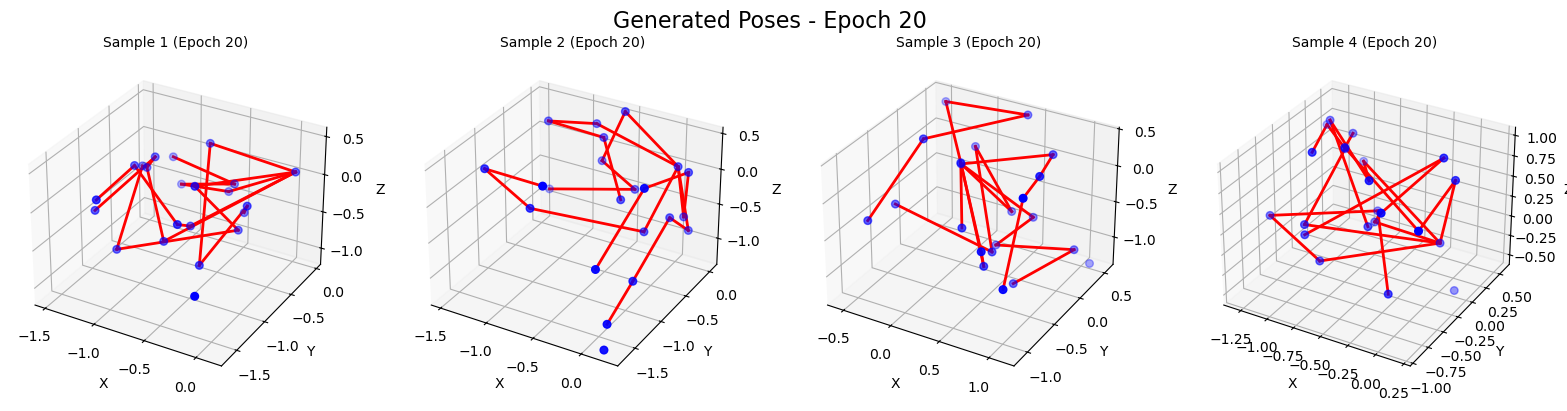

Epoch 20:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.8188, max: 1.0000 | Noisy poses - min: -4.3442, max: 4.2337 | Predicted noise - min: -1.4785, max: 1.4775]
[Diffusion loss: 1.3976 | Anatomy loss: 0.1499 | Total loss: 1.4725 | Estimated pose - min: -4.5297, max: 4.0619]
--------------------------------------------------
[Input poses - min: -0.9819, max: 1.0000 | Noisy poses - min: -4.2952, max: 4.3395 | Predicted noise - min: -1.4922, max: 1.4336]
[Diffusion loss: 1.4054 | Anatomy loss: 0.3221 | Total loss: 1.5665 | Estimated pose - min: -4.3576, max: 4.3891]
--------------------------------------------------
Epoch 21/70, Loss: 1.501699


Epoch 21:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.4619, max: 1.0000 | Noisy poses - min: -4.1371, max: 5.8556 | Predicted noise - min: -1.4785, max: 1.4629]
[Diffusion loss: 1.4650 | Anatomy loss: 0.0867 | Total loss: 1.5084 | Estimated pose - min: -4.0368, max: 5.7160]
--------------------------------------------------
[Input poses - min: -0.5435, max: 1.0000 | Noisy poses - min: -3.6086, max: 4.9668 | Predicted noise - min: -1.4844, max: 1.4180]
[Diffusion loss: 1.4454 | Anatomy loss: 0.0967 | Total loss: 1.4938 | Estimated pose - min: -3.5410, max: 4.9264]
--------------------------------------------------
Epoch 22/70, Loss: 1.503274


Epoch 22:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.9570, max: 1.0000 | Noisy poses - min: -4.7401, max: 5.9920 | Predicted noise - min: -1.4736, max: 1.4043]
[Diffusion loss: 1.3828 | Anatomy loss: 0.3451 | Total loss: 1.5554 | Estimated pose - min: -4.8358, max: 6.0204]
--------------------------------------------------
[Input poses - min: -0.3877, max: 1.0000 | Noisy poses - min: -4.0716, max: 4.0162 | Predicted noise - min: -1.4678, max: 1.3867]
[Diffusion loss: 1.3669 | Anatomy loss: 0.0779 | Total loss: 1.4059 | Estimated pose - min: -4.1136, max: 4.0374]
--------------------------------------------------
Epoch 23/70, Loss: 1.471585


Epoch 23:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.5954, max: 1.0000 | Noisy poses - min: -5.0702, max: 5.7132 | Predicted noise - min: -1.4688, max: 1.4434]
[Diffusion loss: 1.3327 | Anatomy loss: 0.2747 | Total loss: 1.4701 | Estimated pose - min: -5.0222, max: 5.6302]
--------------------------------------------------
[Input poses - min: -0.6941, max: 1.0000 | Noisy poses - min: -4.7982, max: 6.2851 | Predicted noise - min: -1.4717, max: 1.3984]
[Diffusion loss: 1.4253 | Anatomy loss: 0.1320 | Total loss: 1.4913 | Estimated pose - min: -4.8007, max: 6.1952]
--------------------------------------------------
Epoch 24/70, Loss: 1.454499


Epoch 24:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.8610, max: 1.0000 | Noisy poses - min: -4.2071, max: 5.0938 | Predicted noise - min: -1.4688, max: 1.4277]
[Diffusion loss: 1.2965 | Anatomy loss: 0.2970 | Total loss: 1.4450 | Estimated pose - min: -4.2091, max: 5.0958]
--------------------------------------------------
[Input poses - min: -0.9194, max: 1.0000 | Noisy poses - min: -5.7622, max: 6.4530 | Predicted noise - min: -1.4648, max: 1.4375]
[Diffusion loss: 1.3259 | Anatomy loss: 0.1974 | Total loss: 1.4246 | Estimated pose - min: -5.6863, max: 6.4011]
--------------------------------------------------
Epoch 25/70, Loss: 1.449159


Epoch 25:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.9467, max: 1.0000 | Noisy poses - min: -6.0566, max: 4.7193 | Predicted noise - min: -1.4658, max: 1.4453]
[Diffusion loss: 1.3459 | Anatomy loss: 0.1021 | Total loss: 1.3970 | Estimated pose - min: -6.0146, max: 4.7129]
--------------------------------------------------
[Input poses - min: -0.6896, max: 1.0000 | Noisy poses - min: -5.5052, max: 6.1308 | Predicted noise - min: -1.4463, max: 1.4258]
[Diffusion loss: 1.3197 | Anatomy loss: 0.0691 | Total loss: 1.3543 | Estimated pose - min: -5.4302, max: 6.0978]
--------------------------------------------------
Epoch 26/70, Loss: 1.432414


Epoch 26:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.6385, max: 1.0000 | Noisy poses - min: -5.2410, max: 4.7526 | Predicted noise - min: -1.4727, max: 1.3975]
[Diffusion loss: 1.3329 | Anatomy loss: 0.1475 | Total loss: 1.4066 | Estimated pose - min: -5.2167, max: 4.6552]
--------------------------------------------------
[Input poses - min: -0.3708, max: 1.0000 | Noisy poses - min: -4.6561, max: 5.9650 | Predicted noise - min: -1.4805, max: 1.4150]
[Diffusion loss: 1.3337 | Anatomy loss: 0.0629 | Total loss: 1.3651 | Estimated pose - min: -4.5763, max: 5.9510]
--------------------------------------------------
Epoch 27/70, Loss: 1.407230


Epoch 27:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.8624, max: 1.0000 | Noisy poses - min: -3.8648, max: 4.9778 | Predicted noise - min: -1.4463, max: 1.3867]
[Diffusion loss: 1.3465 | Anatomy loss: 0.2716 | Total loss: 1.4823 | Estimated pose - min: -3.8154, max: 4.9645]
--------------------------------------------------
[Input poses - min: -0.7537, max: 1.0000 | Noisy poses - min: -4.8732, max: 4.4143 | Predicted noise - min: -1.4648, max: 1.3359]
[Diffusion loss: 1.2796 | Anatomy loss: 0.1943 | Total loss: 1.3767 | Estimated pose - min: -4.8404, max: 4.4212]
--------------------------------------------------
Epoch 28/70, Loss: 1.408045


Epoch 28:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.4736, max: 1.0000 | Noisy poses - min: -6.6197, max: 5.5115 | Predicted noise - min: -1.4648, max: 1.4014]
[Diffusion loss: 1.3199 | Anatomy loss: 0.0846 | Total loss: 1.3622 | Estimated pose - min: -6.5077, max: 5.3950]
--------------------------------------------------
[Input poses - min: -0.7793, max: 1.0000 | Noisy poses - min: -6.0628, max: 5.6578 | Predicted noise - min: -1.4600, max: 1.3594]
[Diffusion loss: 1.2980 | Anatomy loss: 0.2492 | Total loss: 1.4226 | Estimated pose - min: -5.8632, max: 5.5846]
--------------------------------------------------
Epoch 29/70, Loss: 1.406356


Epoch 29:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.7479, max: 1.0000 | Noisy poses - min: -4.4364, max: 4.9754 | Predicted noise - min: -1.4600, max: 1.3145]
[Diffusion loss: 1.2939 | Anatomy loss: 0.2183 | Total loss: 1.4031 | Estimated pose - min: -4.2869, max: 4.9333]
--------------------------------------------------
[Input poses - min: -0.6437, max: 1.0000 | Noisy poses - min: -3.8069, max: 5.1069 | Predicted noise - min: -1.4443, max: 1.3369]
[Diffusion loss: 1.2700 | Anatomy loss: 0.1450 | Total loss: 1.3425 | Estimated pose - min: -3.6581, max: 5.1709]
--------------------------------------------------
Epoch 30/70, Loss: 1.378749
Checkpoint saved to checkpoints\epoch_030.pt


Epoch 30:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.5956, max: 1.0000 | Noisy poses - min: -4.3004, max: 4.2061 | Predicted noise - min: -1.4512, max: 1.3125]
[Diffusion loss: 1.3259 | Anatomy loss: 0.0935 | Total loss: 1.3726 | Estimated pose - min: -4.2735, max: 4.2352]
--------------------------------------------------
[Input poses - min: -0.3954, max: 1.0000 | Noisy poses - min: -4.7730, max: 5.4574 | Predicted noise - min: -1.4668, max: 1.3086]
[Diffusion loss: 1.3029 | Anatomy loss: 0.0701 | Total loss: 1.3379 | Estimated pose - min: -4.7776, max: 5.4681]
--------------------------------------------------
Epoch 31/70, Loss: 1.382730


Epoch 31:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.6924, max: 1.0000 | Noisy poses - min: -6.4697, max: 5.6399 | Predicted noise - min: -1.4404, max: 1.3408]
[Diffusion loss: 1.2882 | Anatomy loss: 0.1782 | Total loss: 1.3773 | Estimated pose - min: -6.4791, max: 5.6214]
--------------------------------------------------
[Input poses - min: -0.9570, max: 1.0000 | Noisy poses - min: -5.1670, max: 5.1118 | Predicted noise - min: -1.4629, max: 1.3643]
[Diffusion loss: 1.2965 | Anatomy loss: 0.1417 | Total loss: 1.3673 | Estimated pose - min: -5.1108, max: 5.1572]
--------------------------------------------------
Epoch 32/70, Loss: 1.375656


Epoch 32:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.9194, max: 1.0000 | Noisy poses - min: -4.7158, max: 5.8728 | Predicted noise - min: -1.4658, max: 1.2695]
[Diffusion loss: 1.2409 | Anatomy loss: 0.3242 | Total loss: 1.4030 | Estimated pose - min: -4.7183, max: 5.9287]
--------------------------------------------------
[Input poses - min: -0.4625, max: 0.9999 | Noisy poses - min: -4.1760, max: 4.8489 | Predicted noise - min: -1.4424, max: 1.3535]
[Diffusion loss: 1.2204 | Anatomy loss: 0.1239 | Total loss: 1.2823 | Estimated pose - min: -4.2290, max: 4.8601]
--------------------------------------------------
Epoch 33/70, Loss: 1.351554


Epoch 33:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.4410, max: 1.0000 | Noisy poses - min: -3.3064, max: 6.2356 | Predicted noise - min: -1.4258, max: 1.3799]
[Diffusion loss: 1.2548 | Anatomy loss: 0.0656 | Total loss: 1.2876 | Estimated pose - min: -3.2898, max: 6.1696]
--------------------------------------------------
[Input poses - min: -0.5654, max: 1.0000 | Noisy poses - min: -4.9091, max: 4.5907 | Predicted noise - min: -1.4609, max: 1.3320]
[Diffusion loss: 1.2691 | Anatomy loss: 0.0995 | Total loss: 1.3188 | Estimated pose - min: -4.8455, max: 4.5383]
--------------------------------------------------
Epoch 34/70, Loss: 1.349934


Epoch 34:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.9819, max: 1.0000 | Noisy poses - min: -7.5757, max: 5.8974 | Predicted noise - min: -1.4102, max: 1.4619]
[Diffusion loss: 1.2288 | Anatomy loss: 0.2939 | Total loss: 1.3757 | Estimated pose - min: -7.5242, max: 5.9183]
--------------------------------------------------
[Input poses - min: -0.6896, max: 1.0000 | Noisy poses - min: -4.1985, max: 4.6638 | Predicted noise - min: -1.4668, max: 1.3594]
[Diffusion loss: 1.2175 | Anatomy loss: 0.1378 | Total loss: 1.2864 | Estimated pose - min: -4.1376, max: 4.7793]
--------------------------------------------------
Epoch 35/70, Loss: 1.340328


Epoch 35:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.9819, max: 1.0000 | Noisy poses - min: -4.3032, max: 4.8735 | Predicted noise - min: -1.4346, max: 1.3164]
[Diffusion loss: 1.2608 | Anatomy loss: 0.4493 | Total loss: 1.4854 | Estimated pose - min: -4.3337, max: 4.8251]
--------------------------------------------------
[Input poses - min: -0.7514, max: 1.0000 | Noisy poses - min: -5.8734, max: 5.1265 | Predicted noise - min: -1.4336, max: 1.3242]
[Diffusion loss: 1.2551 | Anatomy loss: 0.1140 | Total loss: 1.3122 | Estimated pose - min: -5.9353, max: 5.1923]
--------------------------------------------------
Epoch 36/70, Loss: 1.336800


Epoch 36:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.6781, max: 1.0000 | Noisy poses - min: -5.4580, max: 5.7620 | Predicted noise - min: -1.4229, max: 1.2988]
[Diffusion loss: 1.2460 | Anatomy loss: 0.0963 | Total loss: 1.2942 | Estimated pose - min: -5.5114, max: 5.7393]
--------------------------------------------------
[Input poses - min: -0.5042, max: 1.0000 | Noisy poses - min: -3.6077, max: 3.6879 | Predicted noise - min: -1.4346, max: 1.2988]
[Diffusion loss: 1.2755 | Anatomy loss: 0.0842 | Total loss: 1.3176 | Estimated pose - min: -3.5847, max: 3.6886]
--------------------------------------------------
Epoch 37/70, Loss: 1.320894


Epoch 37:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.4569, max: 1.0000 | Noisy poses - min: -5.9434, max: 5.4503 | Predicted noise - min: -1.4092, max: 1.3135]
[Diffusion loss: 1.2039 | Anatomy loss: 0.2165 | Total loss: 1.3122 | Estimated pose - min: -5.8424, max: 5.3749]
--------------------------------------------------
[Input poses - min: -0.4803, max: 1.0000 | Noisy poses - min: -4.2028, max: 4.8019 | Predicted noise - min: -1.4258, max: 1.2520]
[Diffusion loss: 1.2482 | Anatomy loss: 0.0881 | Total loss: 1.2923 | Estimated pose - min: -4.1319, max: 4.7538]
--------------------------------------------------
Epoch 38/70, Loss: 1.320674


Epoch 38:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.6027, max: 1.0000 | Noisy poses - min: -5.7218, max: 6.8559 | Predicted noise - min: -1.4062, max: 1.3135]
[Diffusion loss: 1.2109 | Anatomy loss: 0.1113 | Total loss: 1.2665 | Estimated pose - min: -5.3120, max: 6.5226]
--------------------------------------------------
[Input poses - min: -0.9819, max: 1.0000 | Noisy poses - min: -5.6651, max: 5.2221 | Predicted noise - min: -1.4375, max: 1.3164]
[Diffusion loss: 1.2222 | Anatomy loss: 0.2219 | Total loss: 1.3332 | Estimated pose - min: -5.6126, max: 5.2424]
--------------------------------------------------
Epoch 39/70, Loss: 1.302264


Epoch 39:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.6941, max: 1.0000 | Noisy poses - min: -5.5234, max: 4.1833 | Predicted noise - min: -1.3672, max: 1.3027]
[Diffusion loss: 1.2607 | Anatomy loss: 0.1510 | Total loss: 1.3362 | Estimated pose - min: -5.5564, max: 4.1617]
--------------------------------------------------
[Input poses - min: -0.6547, max: 1.0000 | Noisy poses - min: -5.5316, max: 4.5918 | Predicted noise - min: -1.3984, max: 1.2754]
[Diffusion loss: 1.2234 | Anatomy loss: 0.1443 | Total loss: 1.2956 | Estimated pose - min: -5.5231, max: 4.6127]
--------------------------------------------------
Epoch 40/70, Loss: 1.300894
Checkpoint saved to checkpoints\epoch_040.pt
Generating sample poses at epoch 40...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved sample visualization to: visualization\epoch_040_samples.png


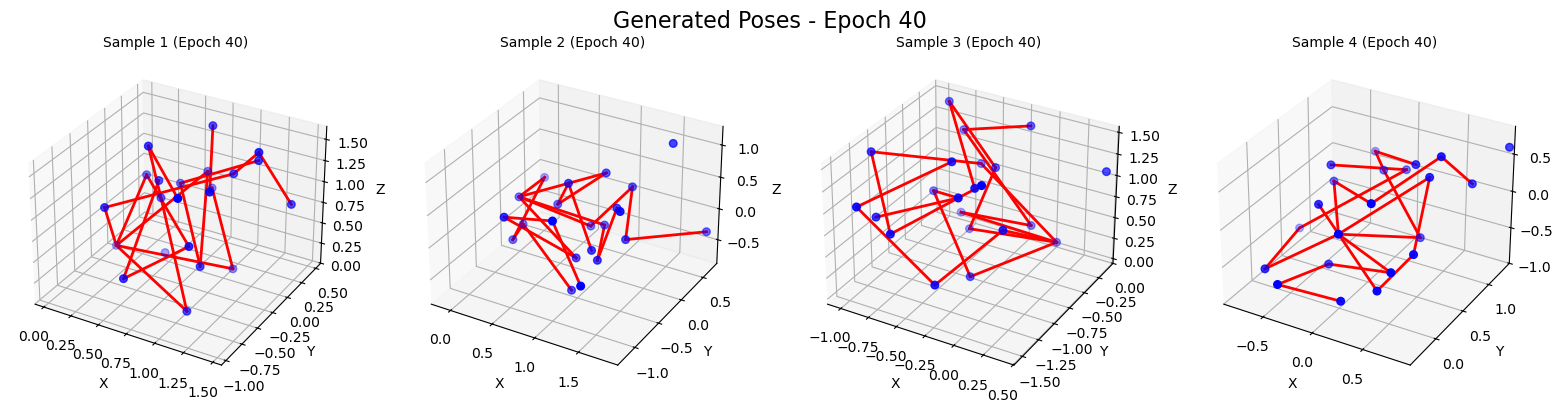

Epoch 40:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.5237, max: 1.0000 | Noisy poses - min: -5.7869, max: 5.0540 | Predicted noise - min: -1.3750, max: 1.3047]
[Diffusion loss: 1.1822 | Anatomy loss: 0.0901 | Total loss: 1.2273 | Estimated pose - min: -5.7296, max: 5.0166]
--------------------------------------------------
[Input poses - min: -0.9194, max: 1.0000 | Noisy poses - min: -5.7407, max: 5.4977 | Predicted noise - min: -1.4521, max: 1.2764]
[Diffusion loss: 1.1792 | Anatomy loss: 0.1346 | Total loss: 1.2465 | Estimated pose - min: -5.7125, max: 5.4762]
--------------------------------------------------
Epoch 41/70, Loss: 1.301685


Epoch 41:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.5002, max: 1.0000 | Noisy poses - min: -6.0882, max: 4.9997 | Predicted noise - min: -1.4473, max: 1.2637]
[Diffusion loss: 1.2031 | Anatomy loss: 0.0623 | Total loss: 1.2342 | Estimated pose - min: -6.0388, max: 4.8938]
--------------------------------------------------
[Input poses - min: -0.6069, max: 1.0000 | Noisy poses - min: -4.0807, max: 5.0780 | Predicted noise - min: -1.3545, max: 1.2900]
[Diffusion loss: 1.2195 | Anatomy loss: 0.2501 | Total loss: 1.3446 | Estimated pose - min: -4.1224, max: 4.9263]
--------------------------------------------------
Epoch 42/70, Loss: 1.282320


Epoch 42:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.6924, max: 1.0000 | Noisy poses - min: -4.3119, max: 5.7418 | Predicted noise - min: -1.4287, max: 1.2188]
[Diffusion loss: 1.1964 | Anatomy loss: 0.1544 | Total loss: 1.2736 | Estimated pose - min: -4.2786, max: 5.6144]
--------------------------------------------------
[Input poses - min: -0.8516, max: 0.9999 | Noisy poses - min: -6.3233, max: 5.6871 | Predicted noise - min: -1.3750, max: 1.2510]
[Diffusion loss: 1.1836 | Anatomy loss: 0.0851 | Total loss: 1.2262 | Estimated pose - min: -6.1717, max: 5.6837]
--------------------------------------------------
Epoch 43/70, Loss: 1.284999


Epoch 43:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.9482, max: 1.0000 | Noisy poses - min: -4.9060, max: 6.4242 | Predicted noise - min: -1.4570, max: 1.4023]
[Diffusion loss: 1.1955 | Anatomy loss: 0.2090 | Total loss: 1.3000 | Estimated pose - min: -4.7853, max: 6.2102]
--------------------------------------------------
[Input poses - min: -0.6547, max: 1.0000 | Noisy poses - min: -5.5999, max: 4.4297 | Predicted noise - min: -1.3848, max: 1.2773]
[Diffusion loss: 1.1470 | Anatomy loss: 0.1836 | Total loss: 1.2388 | Estimated pose - min: -5.6260, max: 4.5307]
--------------------------------------------------
Epoch 44/70, Loss: 1.265665


Epoch 44:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.6385, max: 1.0000 | Noisy poses - min: -7.3417, max: 5.4898 | Predicted noise - min: -1.4160, max: 1.2646]
[Diffusion loss: 1.2178 | Anatomy loss: 0.1424 | Total loss: 1.2890 | Estimated pose - min: -7.2805, max: 5.4190]
--------------------------------------------------
[Input poses - min: -0.6301, max: 1.0000 | Noisy poses - min: -4.3269, max: 3.5811 | Predicted noise - min: -1.4004, max: 1.2988]
[Diffusion loss: 1.1947 | Anatomy loss: 0.1285 | Total loss: 1.2589 | Estimated pose - min: -4.4961, max: 3.6167]
--------------------------------------------------
Epoch 45/70, Loss: 1.268538


Epoch 45:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.5245, max: 1.0000 | Noisy poses - min: -4.8432, max: 4.7026 | Predicted noise - min: -1.3750, max: 1.1797]
[Diffusion loss: 1.2000 | Anatomy loss: 0.1001 | Total loss: 1.2501 | Estimated pose - min: -4.8680, max: 4.6689]
--------------------------------------------------
[Input poses - min: -0.8516, max: 1.0000 | Noisy poses - min: -4.9903, max: 4.4566 | Predicted noise - min: -1.3242, max: 1.3516]
[Diffusion loss: 1.1438 | Anatomy loss: 0.2134 | Total loss: 1.2505 | Estimated pose - min: -4.9316, max: 4.4350]
--------------------------------------------------
Epoch 46/70, Loss: 1.255474


Epoch 46:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.4242, max: 1.0000 | Noisy poses - min: -5.9374, max: 5.8268 | Predicted noise - min: -1.3955, max: 1.1934]
[Diffusion loss: 1.1981 | Anatomy loss: 0.1103 | Total loss: 1.2532 | Estimated pose - min: -5.9155, max: 5.7545]
--------------------------------------------------
[Input poses - min: -0.6152, max: 1.0000 | Noisy poses - min: -7.2287, max: 4.8090 | Predicted noise - min: -1.3311, max: 1.2031]
[Diffusion loss: 1.1641 | Anatomy loss: 0.2198 | Total loss: 1.2741 | Estimated pose - min: -7.1825, max: 4.7476]
--------------------------------------------------
Epoch 47/70, Loss: 1.266609


Epoch 47:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.8188, max: 1.0000 | Noisy poses - min: -6.1367, max: 4.3463 | Predicted noise - min: -1.3818, max: 1.1904]
[Diffusion loss: 1.1861 | Anatomy loss: 0.2701 | Total loss: 1.3212 | Estimated pose - min: -6.1770, max: 4.4732]
--------------------------------------------------
[Input poses - min: -0.6896, max: 1.0000 | Noisy poses - min: -5.5314, max: 4.8871 | Predicted noise - min: -1.2969, max: 1.2666]
[Diffusion loss: 1.1837 | Anatomy loss: 0.2757 | Total loss: 1.3216 | Estimated pose - min: -5.5039, max: 4.9813]
--------------------------------------------------
Epoch 48/70, Loss: 1.258270


Epoch 48:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.6433, max: 1.0000 | Noisy poses - min: -5.7161, max: 4.3003 | Predicted noise - min: -1.3379, max: 1.1465]
[Diffusion loss: 1.1474 | Anatomy loss: 0.1985 | Total loss: 1.2466 | Estimated pose - min: -5.5733, max: 4.2592]
--------------------------------------------------
[Input poses - min: -0.6152, max: 1.0000 | Noisy poses - min: -4.2783, max: 3.7188 | Predicted noise - min: -1.4199, max: 1.2344]
[Diffusion loss: 1.1721 | Anatomy loss: 0.3833 | Total loss: 1.3637 | Estimated pose - min: -4.2967, max: 3.6545]
--------------------------------------------------
Epoch 49/70, Loss: 1.247296


Epoch 49:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.5954, max: 1.0000 | Noisy poses - min: -5.1008, max: 6.9379 | Predicted noise - min: -1.3359, max: 1.1865]
[Diffusion loss: 1.1757 | Anatomy loss: 0.4162 | Total loss: 1.3837 | Estimated pose - min: -3.6821, max: 3.5971]
--------------------------------------------------
[Input poses - min: -0.9467, max: 1.0000 | Noisy poses - min: -5.5421, max: 4.9615 | Predicted noise - min: -1.2686, max: 1.2021]
[Diffusion loss: 1.1345 | Anatomy loss: 0.2405 | Total loss: 1.2548 | Estimated pose - min: -5.5056, max: 4.9550]
--------------------------------------------------
Epoch 50/70, Loss: 1.241549
Checkpoint saved to checkpoints\epoch_050.pt


Epoch 50:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.6924, max: 1.0000 | Noisy poses - min: -5.3680, max: 4.7009 | Predicted noise - min: -1.2803, max: 1.0947]
[Diffusion loss: 1.1657 | Anatomy loss: 0.1056 | Total loss: 1.2185 | Estimated pose - min: -5.3362, max: 4.6714]
--------------------------------------------------
[Input poses - min: -0.9467, max: 1.0000 | Noisy poses - min: -6.4613, max: 5.9138 | Predicted noise - min: -1.2852, max: 1.2012]
[Diffusion loss: 1.1355 | Anatomy loss: 0.1151 | Total loss: 1.1931 | Estimated pose - min: -6.4485, max: 5.9178]
--------------------------------------------------
Epoch 51/70, Loss: 1.238966


Epoch 51:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.5956, max: 1.0000 | Noisy poses - min: -5.7751, max: 4.8086 | Predicted noise - min: -1.2773, max: 1.2500]
[Diffusion loss: 1.1293 | Anatomy loss: 0.0914 | Total loss: 1.1750 | Estimated pose - min: -5.7820, max: 4.7481]
--------------------------------------------------
[Input poses - min: -0.7337, max: 0.9999 | Noisy poses - min: -6.1878, max: 5.0997 | Predicted noise - min: -1.3018, max: 1.1084]
[Diffusion loss: 1.1346 | Anatomy loss: 0.1349 | Total loss: 1.2020 | Estimated pose - min: -6.2793, max: 5.1140]
--------------------------------------------------
Epoch 52/70, Loss: 1.227236


Epoch 52:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.3931, max: 1.0000 | Noisy poses - min: -5.9377, max: 6.7071 | Predicted noise - min: -1.3945, max: 1.2109]
[Diffusion loss: 1.1277 | Anatomy loss: 0.1174 | Total loss: 1.1864 | Estimated pose - min: -5.9658, max: 6.7651]
--------------------------------------------------
[Input poses - min: -0.4932, max: 0.9999 | Noisy poses - min: -4.5087, max: 4.7879 | Predicted noise - min: -1.3623, max: 1.2441]
[Diffusion loss: 1.1423 | Anatomy loss: 0.1590 | Total loss: 1.2218 | Estimated pose - min: -4.6020, max: 4.7577]
--------------------------------------------------
Epoch 53/70, Loss: 1.233475


Epoch 53:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.8318, max: 1.0000 | Noisy poses - min: -5.9549, max: 5.2290 | Predicted noise - min: -1.3916, max: 1.2383]
[Diffusion loss: 1.1485 | Anatomy loss: 0.1403 | Total loss: 1.2187 | Estimated pose - min: -5.9050, max: 5.2133]
--------------------------------------------------
[Input poses - min: -0.6531, max: 1.0000 | Noisy poses - min: -5.1168, max: 4.9254 | Predicted noise - min: -1.3711, max: 1.2314]
[Diffusion loss: 1.1792 | Anatomy loss: 0.1740 | Total loss: 1.2662 | Estimated pose - min: -5.2694, max: 4.8685]
--------------------------------------------------
Epoch 54/70, Loss: 1.224801


Epoch 54:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.6924, max: 1.0000 | Noisy poses - min: -4.6979, max: 4.8364 | Predicted noise - min: -1.2715, max: 1.1768]
[Diffusion loss: 1.1485 | Anatomy loss: 0.2087 | Total loss: 1.2528 | Estimated pose - min: -4.8013, max: 4.8470]
--------------------------------------------------
[Input poses - min: -0.5004, max: 1.0000 | Noisy poses - min: -6.1832, max: 7.3114 | Predicted noise - min: -1.3389, max: 1.1396]
[Diffusion loss: 1.0910 | Anatomy loss: 0.0689 | Total loss: 1.1254 | Estimated pose - min: -6.0339, max: 7.3386]
--------------------------------------------------
Epoch 55/70, Loss: 1.214771


Epoch 55:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.9482, max: 1.0000 | Noisy poses - min: -6.0021, max: 6.6470 | Predicted noise - min: -1.2930, max: 1.1553]
[Diffusion loss: 1.1266 | Anatomy loss: 0.2461 | Total loss: 1.2497 | Estimated pose - min: -5.8920, max: 6.5350]
--------------------------------------------------
[Input poses - min: -0.8188, max: 1.0000 | Noisy poses - min: -5.0929, max: 6.8725 | Predicted noise - min: -1.3193, max: 1.1982]
[Diffusion loss: 1.1607 | Anatomy loss: 0.2659 | Total loss: 1.2937 | Estimated pose - min: -4.4222, max: 5.9169]
--------------------------------------------------
Epoch 56/70, Loss: 1.208281


Epoch 56:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.5365, max: 0.9999 | Noisy poses - min: -4.8646, max: 5.8529 | Predicted noise - min: -1.2344, max: 1.2275]
[Diffusion loss: 1.1532 | Anatomy loss: 0.1940 | Total loss: 1.2502 | Estimated pose - min: -4.8197, max: 5.7654]
--------------------------------------------------
[Input poses - min: -0.6433, max: 1.0000 | Noisy poses - min: -4.2468, max: 5.8042 | Predicted noise - min: -1.3789, max: 1.2266]
[Diffusion loss: 1.1374 | Anatomy loss: 0.0818 | Total loss: 1.1783 | Estimated pose - min: -2.5379, max: 3.2794]
--------------------------------------------------
Epoch 57/70, Loss: 1.210149


Epoch 57:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.6547, max: 1.0000 | Noisy poses - min: -4.9812, max: 4.5614 | Predicted noise - min: -1.2861, max: 1.2119]
[Diffusion loss: 1.1444 | Anatomy loss: 0.1691 | Total loss: 1.2290 | Estimated pose - min: -4.9736, max: 4.5525]
--------------------------------------------------
[Input poses - min: -0.5777, max: 1.0000 | Noisy poses - min: -6.7139, max: 5.6272 | Predicted noise - min: -1.3281, max: 1.0928]
[Diffusion loss: 1.1220 | Anatomy loss: 0.2706 | Total loss: 1.2573 | Estimated pose - min: -6.4680, max: 5.5641]
--------------------------------------------------
Epoch 58/70, Loss: 1.211289


Epoch 58:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.4664, max: 1.0000 | Noisy poses - min: -5.4200, max: 4.3776 | Predicted noise - min: -1.2510, max: 1.1982]
[Diffusion loss: 1.1360 | Anatomy loss: 0.0664 | Total loss: 1.1692 | Estimated pose - min: -5.4924, max: 4.4542]
--------------------------------------------------
[Input poses - min: -0.7537, max: 1.0000 | Noisy poses - min: -4.8214, max: 3.7600 | Predicted noise - min: -1.2676, max: 1.1709]
[Diffusion loss: 1.1234 | Anatomy loss: 0.2455 | Total loss: 1.2461 | Estimated pose - min: -4.8463, max: 3.7978]
--------------------------------------------------
Epoch 59/70, Loss: 1.207049


Epoch 59:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.8624, max: 1.0000 | Noisy poses - min: -5.3273, max: 5.6573 | Predicted noise - min: -1.1904, max: 1.1621]
[Diffusion loss: 1.1588 | Anatomy loss: 0.2961 | Total loss: 1.3068 | Estimated pose - min: -5.3513, max: 5.6542]
--------------------------------------------------
[Input poses - min: -0.4617, max: 1.0000 | Noisy poses - min: -4.5243, max: 5.5264 | Predicted noise - min: -1.3105, max: 1.2500]
[Diffusion loss: 1.1294 | Anatomy loss: 0.0843 | Total loss: 1.1715 | Estimated pose - min: -4.4858, max: 5.5175]
--------------------------------------------------
Epoch 60/70, Loss: 1.200706
Checkpoint saved to checkpoints\epoch_060.pt
Generating sample poses at epoch 60...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved sample visualization to: visualization\epoch_060_samples.png


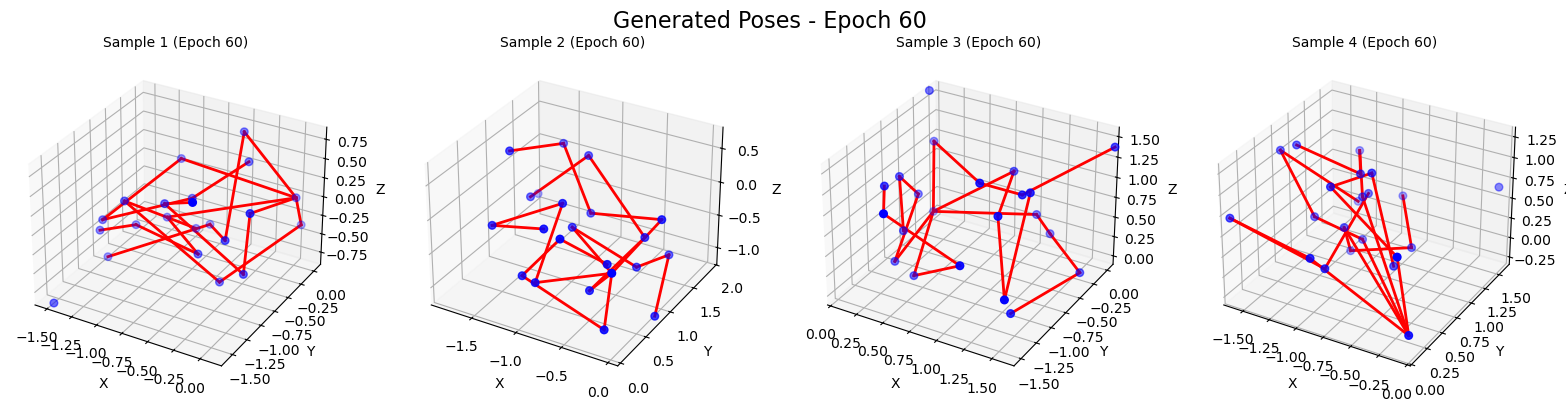

Epoch 60:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.4285, max: 1.0000 | Noisy poses - min: -4.6026, max: 4.1819 | Predicted noise - min: -1.2803, max: 1.1484]
[Diffusion loss: 1.0767 | Anatomy loss: 0.1400 | Total loss: 1.1468 | Estimated pose - min: -4.4148, max: 4.1430]
--------------------------------------------------
[Input poses - min: -0.5226, max: 1.0000 | Noisy poses - min: -3.9495, max: 4.1678 | Predicted noise - min: -1.2812, max: 1.1436]
[Diffusion loss: 1.1217 | Anatomy loss: 0.1738 | Total loss: 1.2086 | Estimated pose - min: -3.8887, max: 4.1094]
--------------------------------------------------
Epoch 61/70, Loss: 1.201099


Epoch 61:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.6267, max: 1.0000 | Noisy poses - min: -3.7340, max: 5.5780 | Predicted noise - min: -1.3691, max: 1.0107]
[Diffusion loss: 1.0552 | Anatomy loss: 0.1740 | Total loss: 1.1422 | Estimated pose - min: -3.8069, max: 5.5434]
--------------------------------------------------
[Input poses - min: -0.8188, max: 1.0000 | Noisy poses - min: -4.6986, max: 3.8691 | Predicted noise - min: -1.3145, max: 1.1836]
[Diffusion loss: 1.1194 | Anatomy loss: 0.2758 | Total loss: 1.2573 | Estimated pose - min: -4.5857, max: 3.9669]
--------------------------------------------------
Epoch 62/70, Loss: 1.193308


Epoch 62:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.5394, max: 1.0000 | Noisy poses - min: -7.1504, max: 6.9563 | Predicted noise - min: -1.3447, max: 1.1211]
[Diffusion loss: 1.1022 | Anatomy loss: 0.1796 | Total loss: 1.1920 | Estimated pose - min: -7.0615, max: 7.0173]
--------------------------------------------------
[Input poses - min: -0.6781, max: 1.0000 | Noisy poses - min: -5.2351, max: 4.9086 | Predicted noise - min: -1.4043, max: 1.1084]
[Diffusion loss: 1.0690 | Anatomy loss: 0.1247 | Total loss: 1.1313 | Estimated pose - min: -5.1534, max: 4.8349]
--------------------------------------------------
Epoch 63/70, Loss: 1.191911


Epoch 63:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.6941, max: 1.0000 | Noisy poses - min: -5.4679, max: 6.3590 | Predicted noise - min: -1.2900, max: 1.1729]
[Diffusion loss: 1.1154 | Anatomy loss: 0.0932 | Total loss: 1.1620 | Estimated pose - min: -5.0414, max: 5.8455]
--------------------------------------------------
[Input poses - min: -0.9166, max: 1.0000 | Noisy poses - min: -5.3487, max: 5.7521 | Predicted noise - min: -1.2227, max: 1.0820]
[Diffusion loss: 1.1263 | Anatomy loss: 0.0774 | Total loss: 1.1650 | Estimated pose - min: -5.2366, max: 5.6076]
--------------------------------------------------
Epoch 64/70, Loss: 1.193794


Epoch 64:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.9467, max: 1.0000 | Noisy poses - min: -4.0238, max: 3.5895 | Predicted noise - min: -1.1475, max: 1.1533]
[Diffusion loss: 1.0264 | Anatomy loss: 0.2371 | Total loss: 1.1450 | Estimated pose - min: -4.1897, max: 3.6545]
--------------------------------------------------
[Input poses - min: -0.5145, max: 1.0000 | Noisy poses - min: -5.7244, max: 5.1769 | Predicted noise - min: -1.2002, max: 1.2383]
[Diffusion loss: 1.1052 | Anatomy loss: 0.1320 | Total loss: 1.1712 | Estimated pose - min: -5.7761, max: 5.2567]
--------------------------------------------------
Epoch 65/70, Loss: 1.178368


Epoch 65:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.4664, max: 1.0000 | Noisy poses - min: -4.7462, max: 4.3607 | Predicted noise - min: -1.1289, max: 1.0879]
[Diffusion loss: 1.1181 | Anatomy loss: 0.0710 | Total loss: 1.1536 | Estimated pose - min: -4.7967, max: 4.3720]
--------------------------------------------------
[Input poses - min: -0.6301, max: 1.0000 | Noisy poses - min: -4.9969, max: 4.7211 | Predicted noise - min: -1.2393, max: 1.0322]
[Diffusion loss: 1.0531 | Anatomy loss: 0.1987 | Total loss: 1.1525 | Estimated pose - min: -4.9802, max: 4.7669]
--------------------------------------------------
Epoch 66/70, Loss: 1.179784


Epoch 66:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.5456, max: 1.0000 | Noisy poses - min: -5.2947, max: 4.5551 | Predicted noise - min: -1.2158, max: 1.1152]
[Diffusion loss: 1.0796 | Anatomy loss: 0.2068 | Total loss: 1.1830 | Estimated pose - min: -5.2575, max: 4.4823]
--------------------------------------------------
[Input poses - min: -0.3674, max: 1.0000 | Noisy poses - min: -4.4126, max: 4.1139 | Predicted noise - min: -1.2812, max: 1.1621]
[Diffusion loss: 1.1172 | Anatomy loss: 0.0736 | Total loss: 1.1540 | Estimated pose - min: -4.4065, max: 4.0550]
--------------------------------------------------
Epoch 67/70, Loss: 1.175127


Epoch 67:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.3821, max: 1.0000 | Noisy poses - min: -4.4780, max: 5.3471 | Predicted noise - min: -1.1973, max: 1.1992]
[Diffusion loss: 1.1038 | Anatomy loss: 0.0715 | Total loss: 1.1396 | Estimated pose - min: -4.5586, max: 5.3663]
--------------------------------------------------
[Input poses - min: -0.4749, max: 0.9999 | Noisy poses - min: -4.7899, max: 5.5844 | Predicted noise - min: -1.2520, max: 1.1602]
[Diffusion loss: 1.0939 | Anatomy loss: 0.0864 | Total loss: 1.1371 | Estimated pose - min: -4.8673, max: 5.5575]
--------------------------------------------------
Epoch 68/70, Loss: 1.179477


Epoch 68:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.6152, max: 1.0000 | Noisy poses - min: -5.6984, max: 6.3955 | Predicted noise - min: -1.3252, max: 1.1689]
[Diffusion loss: 1.1081 | Anatomy loss: 0.3641 | Total loss: 1.2901 | Estimated pose - min: -5.6678, max: 6.3553]
--------------------------------------------------
[Input poses - min: -0.5956, max: 1.0000 | Noisy poses - min: -6.8928, max: 7.5407 | Predicted noise - min: -1.2969, max: 1.0488]
[Diffusion loss: 1.1484 | Anatomy loss: 0.1809 | Total loss: 1.2389 | Estimated pose - min: -6.9185, max: 7.6490]
--------------------------------------------------
Epoch 69/70, Loss: 1.175264


Epoch 69:   0%|          | 0/44 [00:00<?, ?it/s]

[Input poses - min: -0.8318, max: 1.0000 | Noisy poses - min: -5.4322, max: 4.6053 | Predicted noise - min: -1.1787, max: 1.0732]
[Diffusion loss: 1.0430 | Anatomy loss: 0.2214 | Total loss: 1.1537 | Estimated pose - min: -5.3512, max: 4.5907]
--------------------------------------------------
[Input poses - min: -0.6547, max: 1.0000 | Noisy poses - min: -4.4923, max: 5.0443 | Predicted noise - min: -1.3203, max: 0.9858]
[Diffusion loss: 1.0955 | Anatomy loss: 0.1636 | Total loss: 1.1773 | Estimated pose - min: -4.6297, max: 4.5250]
--------------------------------------------------
Epoch 70/70, Loss: 1.169517
Checkpoint saved to checkpoints\epoch_070.pt
Training complete!
Generating final samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved sample visualization to: visualization\samples.png


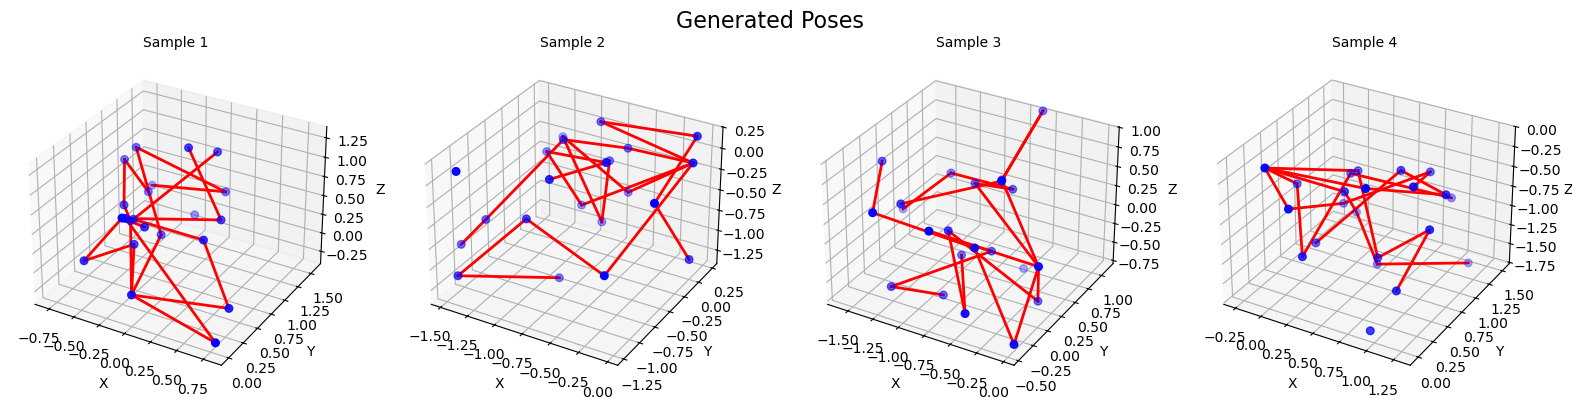

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

import math
import numpy as np
import matplotlib.pyplot as plt
import os

from mpl_toolkits.mplot3d import Axes3D  
from diffusers import DDPMScheduler
from tqdm.auto import tqdm


# this should be a global helper.
def to_device(obj, device):
    """Move all tensors in an object to the specified device."""
    for key in dir(obj):
        if key.startswith('__'):
            continue
        attr = getattr(obj, key)
        if isinstance(attr, torch.Tensor):
            setattr(obj, key, attr.to(device))
    return obj



class OptimizedNoiseScheduler:
    """
    Noise scheduler wrapper using diffusers library for numerical stability.
    
    This class wraps the DDPMScheduler from the diffusers library,
    which provides a stable implementation of the diffusion process.
    """
    
    def __init__(
        self, 
        num_train_timesteps=1000,
        beta_start=0.0001,
        beta_end=0.02,
        beta_schedule="linear",
        prediction_type="epsilon",
        clip_sample=True,
        timestep_spacing="linspace"
    ):
        """
        Initialize the noise scheduler with diffusers implementation.
        
        Args:
            num_train_timesteps: Total number of training steps
            beta_start: Starting noise level
            beta_end: Final noise level
            beta_schedule: Schedule type for noise levels ('linear', 'scaled_linear', 'squaredcos_cap_v2')
            prediction_type: What the model predicts ('epsilon', 'sample', 'v_prediction')
            clip_sample: Whether to clip predicted samples
            timestep_spacing: How to space the timesteps ('linspace', 'leading', 'trailing')
        """
        self.scheduler = DDPMScheduler(
            num_train_timesteps=num_train_timesteps,
            beta_start=beta_start,
            beta_end=beta_end,
            beta_schedule=beta_schedule,
            prediction_type=prediction_type,
            clip_sample=clip_sample,
            timestep_spacing=timestep_spacing
        )
        
        # Store basic settings for reference
        self.num_train_timesteps = num_train_timesteps
        self.device = torch.device("cpu")
    
    def to(self, device):
        """Move scheduler tensors to specified device"""
        self.device = device
        self.scheduler.to(device)
        return self
    
    def step(self, model_output, timestep, sample):
        """
        Predict the sample from the previous timestep by reversing the SDE.
        
        Args:
            model_output: The model prediction (usually noise)
            timestep: Current discrete timestep in the diffusion chain
            sample: Current noisy sample
            
        Returns:
            Previous sample (less noisy)
        """
        return self.scheduler.step(model_output, timestep, sample).prev_sample
    
    def add_noise(self, original_samples, timesteps, noise=None):
        """
        Add noise to samples according to diffusion schedule.
        
        Args:
            original_samples: Clean data samples [batch_size, ...]
            timesteps: Timesteps to add noise for [batch_size]
            noise: Optional pre-generated noise, same shape as original_samples
            
        Returns:
            Tuple of (noisy_samples, noise_added)
        """
        if noise is None:
            noise = torch.randn_like(original_samples)
            
        # Use the scheduler's add_noise method which handles the math properly
        noisy_samples = self.scheduler.add_noise(original_samples, noise, timesteps)
        
        return noisy_samples, noise
    
    def sample_timesteps(self, batch_size):
        """Sample random timesteps for a batch"""
        return torch.randint(
            0, self.num_train_timesteps, 
            (batch_size,), 
            device=self.device, 
            dtype=torch.long
        )
    
    def get_variance(self, timestep):
        """Get the variance for a specific timestep"""
        return self.scheduler.get_variance(timestep)
    
    def step_sample(self, model_fn, x_t, t, generator=None, clamp_output=True):
        """
        Sample a single step in the reverse diffusion process.
        
        Args:
            model_fn: Model function that predicts noise
            x_t: Current noisy sample
            t: Current timestep
            generator: Optional random generator for sampling
            clamp_output: Whether to clamp outputs to a reasonable range
            
        Returns:
            Less noisy sample x_{t-1}
        """
        # Get model prediction (noise/epsilon)
        noise_pred = model_fn(x_t, t)
        
        if clamp_output:
            # Clamp model output to reasonable range for stability
            noise_pred = torch.clamp(noise_pred, -5.0, 5.0)
            
        # Let the scheduler handle the math for the step
        step_output = self.scheduler.step(noise_pred, t, x_t, generator=generator)
        x_t_minus_1 = step_output.prev_sample
        
        return x_t_minus_1
    
    def sample(self, model_fn, shape, device, generator=None, clamp_output=True, progress=True):
        """
        Generate samples from noise using the full diffusion process.
        
        Args:
            model_fn: Function that takes (x, t) and returns predicted noise
            shape: Shape of samples to generate
            device: Device to generate on
            generator: Optional random generator
            clamp_output: Whether to clamp predicted noise
            progress: Whether to show progress bar
            
        Returns:
            Generated samples
        """
        # Start from pure noise
        x = torch.randn(shape, generator=generator, device=device)
        
        # Progressively denoise
        timesteps = list(range(self.num_train_timesteps))[::-1]
        if progress:
            timesteps = tqdm(timesteps, desc="Sampling")
            
        for t in timesteps:
            # Expand timestep to batch dimension
            timestep = torch.full((shape[0],), t, device=device, dtype=torch.long)
            
            # Get model prediction
            model_output = model_fn(x, timestep)
            
            if clamp_output:
                # Clamp model output for stability
                model_output = torch.clamp(model_output, -5.0, 5.0)
            
            # Perform denoising step
            x = self.scheduler.step(model_output, t, x, generator=generator).prev_sample
            
        return x


## -------------------------------------------------------------------------------------------------------------------------------------------------------------------
## -------------------------------------------------------------------------------------------------------------------------------------------------------------------


class ResidualBlock(nn.Module):
    """
    Properly normalized residual block for diffusion models.
    
    Features:
    - GroupNorm for proper normalization
    - Skip connection handling
    - Time embedding conditioning
    - Proper weight initialization
    """
    def __init__(self, in_channels, out_channels, time_channels, dropout=0.1, num_groups=8):
        super().__init__()
        
        # First normalization and convolution
        self.norm1 = nn.GroupNorm(
            num_groups=min(num_groups, in_channels), 
            num_channels=in_channels,
            eps=1e-5
        )
        self.act1 = nn.SiLU()
        self.conv1 = nn.Linear(in_channels, out_channels)
        
        # Time embedding projection
        self.time_proj = nn.Linear(time_channels, out_channels)
        self.time_act = nn.SiLU()
        
        # Second normalization and convolution
        self.norm2 = nn.GroupNorm(
            num_groups=min(num_groups, out_channels), 
            num_channels=out_channels,
            eps=1e-5
        )
        self.act2 = nn.SiLU()
        self.conv2 = nn.Linear(out_channels, out_channels)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Skip connection - if dimensions change, project the input
        self.skip_connection = nn.Identity() if in_channels == out_channels else nn.Linear(in_channels, out_channels)
        
        # Initialize weights properly
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using Kaiming initialization."""
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.zeros_(self.conv1.bias)
        nn.init.zeros_(self.conv2.bias)
        
        nn.init.kaiming_normal_(self.time_proj.weight, nonlinearity='relu')
        nn.init.zeros_(self.time_proj.bias)
        
        if not isinstance(self.skip_connection, nn.Identity):
            nn.init.kaiming_normal_(self.skip_connection.weight, nonlinearity='relu')
            nn.init.zeros_(self.skip_connection.bias)
    
    def forward(self, x, time_emb):
        """
        Forward pass with proper normalization and time conditioning.
        
        Args:
            x: Input tensor [batch_size, in_channels]
            time_emb: Time embedding [batch_size, time_channels]
            
        Returns:
            Output tensor [batch_size, out_channels]
        """
        # Store original input for residual
        identity = x
        
        # First convolution with normalization
        h = self.norm1(x)
        h = self.act1(h)
        h = self.conv1(h)
        
        # Add time embedding
        time_emb = self.time_act(self.time_proj(time_emb))
        h = h + time_emb
        
        # Second convolution with normalization
        h = self.norm2(h)
        h = self.act2(h)
        h = self.dropout(h)
        h = self.conv2(h)
        
        # Add skip connection
        return h + self.skip_connection(identity)




class TimeEmbedding(nn.Module):
    """
    Time embedding module with proper scaling and initialization.
    
    Creates sinusoidal time embeddings similar to positional embeddings in Transformers,
    but with careful scaling to prevent numerical instability.
    """
    def __init__(self, dim, max_period=10000):
        super().__init__()
        self.dim = dim
        self.max_period = max_period


        # Replacing with 2 instead of 4.
        # Use smaller embedding dimensions for initial calculation
        self.base_dim = dim // 2
        
        # Projection with proper initialization
        self.mlp = nn.Sequential(
            nn.Linear(self.base_dim, dim),
            nn.SiLU(),
            nn.Linear(dim, dim)
        )
        
        # Initialize weights properly
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using proper scaling."""
        # First layer - careful initialization to maintain scale
        nn.init.kaiming_normal_(self.mlp[0].weight, a=0.1, nonlinearity='relu')
        nn.init.zeros_(self.mlp[0].bias)
        
        # Second layer
        nn.init.kaiming_normal_(self.mlp[2].weight, nonlinearity='relu')
        nn.init.zeros_(self.mlp[2].bias)
    
    def forward(self, t):
        """
        Create time embeddings for input timesteps.
        
        Args:
            t: Timestep indices [batch_size]
            
        Returns:
            Time embeddings [batch_size, dim]
        """
        # Make sure t is on the right device
        device = next(self.parameters()).device
        if t.device != device:
            t = t.to(device)
        
        # Handle scalar input
        if not isinstance(t, torch.Tensor):
            t = torch.tensor([t], device=device)
        
        # Create scaled sinusoidal embeddings
        half_dim = self.base_dim // 2
        emb = math.log(self.max_period) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        
        # Reshape for broadcasting
        emb = t.float().unsqueeze(1) * emb.unsqueeze(0)
        
        # Create sinusoids
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        
        # Normalize to control scale - important for stability
        emb = emb / math.sqrt(self.base_dim)
        
        # Project to final dimension with scaling
        emb = self.mlp(emb)
        
        # Clamp to prevent extreme values
        emb = torch.clamp(emb, -10.0, 10.0)
        
        return emb


## -------------------------------------------------------------------------------------------------------------------------------------------------------------------
## -------------------------------------------------------------------------------------------------------------------------------------------------------------------

class UNetModel(nn.Module):
    """
    Optimized UNet architecture for diffusion model with proper normalization and initialization.
    
    Features:
    - GroupNorm throughout for improved stability
    - Controlled channel growth with balanced architecture
    - Skip connections for better gradient flow
    - Appropriate normalization and weight initialization
    """
    def __init__(
        self,
        pose_dim=66,             # Input pose dimension
        base_channels=64,        # Base channel count (reduced from 96)
        time_emb_dim=128,        # Time embedding dimension (reduced from 256)
        channel_mults=(1, 2, 4), # Channel multipliers (removed final 4)
        num_res_blocks=2,        # Number of residual blocks per level
        dropout=0.1,             # Dropout rate
        num_groups=8,            # Number of groups for GroupNorm
    ):
        super().__init__()
        
        # Store configuration parameters
        self.pose_dim = pose_dim
        self.base_channels = base_channels
        self.time_emb_dim = time_emb_dim
        self.channel_mults = channel_mults
        self.num_res_blocks = num_res_blocks
        self.dropout = dropout
        self.num_groups = num_groups
        
        # Create time embedding module
        self.time_embedding = TimeEmbedding(time_emb_dim)
        
        # Input projection from pose space to feature space
        self.input_proj = nn.Sequential(
            nn.Linear(pose_dim, base_channels),
            nn.GroupNorm(num_groups=min(num_groups, base_channels), num_channels=base_channels),
            nn.SiLU()
        )
        
        # Create downsampling blocks
        self.down_blocks = nn.ModuleList()
        self.down_channels = []
        
        in_channels = base_channels
        for level, mult in enumerate(channel_mults):
            out_channels = base_channels * mult
            
            # Add residual blocks
            for _ in range(num_res_blocks):
                self.down_blocks.append(
                    ResidualBlock(
                        in_channels,
                        out_channels,
                        time_emb_dim,
                        dropout=dropout,
                        num_groups=num_groups
                    )
                )
                in_channels = out_channels
            
            # Store channels for skip connections
            self.down_channels.append(in_channels)
            
            # Add downsampling except for last level
            if level < len(channel_mults) - 1:
                self.down_blocks.append(
                    nn.Sequential(
                        nn.Linear(in_channels, in_channels),
                        nn.GroupNorm(num_groups=min(num_groups, in_channels), num_channels=in_channels),
                        nn.SiLU()
                    )
                )
        
        # Create middle blocks at bottleneck
        self.mid_blocks = nn.ModuleList()
        for _ in range(num_res_blocks):
            self.mid_blocks.append(
                ResidualBlock(
                    in_channels,
                    in_channels,
                    time_emb_dim,
                    dropout=dropout,
                    num_groups=num_groups
                )
            )
        
        # Create upsampling blocks
        self.up_blocks = nn.ModuleList()
        for level, mult in reversed(list(enumerate(channel_mults))):
            out_channels = base_channels * mult
            
            # Add residual blocks with skip connections
            for i in range(num_res_blocks):
                # Use skip connection for first block of each level
                skip_channels = self.down_channels[level] if i == 0 else 0
                combined_channels = in_channels + skip_channels
                
                self.up_blocks.append(
                    ResidualBlock(
                        combined_channels,
                        out_channels,
                        time_emb_dim,
                        dropout=dropout,
                        num_groups=num_groups
                    )
                )
                in_channels = out_channels
            
            # Add upsampling except for first level
            if level > 0:
                self.up_blocks.append(
                    nn.Sequential(
                        nn.Linear(in_channels, in_channels),
                        nn.GroupNorm(num_groups=min(num_groups, in_channels), num_channels=in_channels),
                        nn.SiLU()
                    )
                )

        # NOT implemeneting this tanh previously gave week of errors. 
        # Final projection back to pose space
        self.final_proj = nn.Sequential(
            nn.GroupNorm(num_groups=min(num_groups, in_channels), num_channels=in_channels),
            nn.SiLU(),
            nn.Linear(in_channels, pose_dim),
            nn.Tanh()  # Constrain output to [-1, 1]
        )
        
        # Initialize weights
        self._initialize_weights()
        
        # Print network summary
        self._print_network_summary()


        
    def _initialize_weights(self):
        """Initialize weights for all layers that haven't been initialized already."""
        # Initialize input projection
        nn.init.kaiming_normal_(self.input_proj[0].weight, nonlinearity='relu')
        nn.init.zeros_(self.input_proj[0].bias)
        
        # Initialize final projection
        nn.init.kaiming_normal_(self.final_proj[2].weight, nonlinearity='relu')
        nn.init.zeros_(self.final_proj[2].bias)
        
        # ResBlocks initialize their own weights
        
        # Initialize downsampling/upsampling linear layers
        for block in self.down_blocks:
            if isinstance(block, nn.Sequential):
                nn.init.kaiming_normal_(block[0].weight, nonlinearity='relu')
                nn.init.zeros_(block[0].bias)
                
        for block in self.up_blocks:
            if isinstance(block, nn.Sequential):
                nn.init.kaiming_normal_(block[0].weight, nonlinearity='relu')
                nn.init.zeros_(block[0].bias)
    
    def _print_network_summary(self):
        """Print a summary of the network architecture"""
        print("\nUNet Architecture Summary:")
        print(f"Pose dimension: {self.pose_dim}")
        print(f"Base channels: {self.base_channels}")
        print(f"Channel multipliers: {self.channel_mults}")
        print(f"Max channels: {self.base_channels * max(self.channel_mults)}")
        print(f"Residual blocks per level: {self.num_res_blocks}")
        print(f"Time embedding dimension: {self.time_emb_dim}")
        print(f"GroupNorm groups: {self.num_groups}")
        
        # Calculate parameter count
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Total parameters: {total_params:,}")
        print("\nChannel dimensions:")
        
        # Print channel dimensions
        channels = self.base_channels
        print(f"Input projection: {self.pose_dim} → {channels}")
        
        for level, mult in enumerate(self.channel_mults):
            out_channels = self.base_channels * mult
            print(f"Down level {level+1}: {channels} → {out_channels}")
            channels = out_channels
            
        print(f"Bottleneck: {channels}")
        
        for level, mult in reversed(list(enumerate(self.channel_mults))):
            out_channels = self.base_channels * mult
            skip_channels = self.down_channels[level]
            print(f"Up level {level+1}: {channels}+{skip_channels} → {out_channels}")
            channels = out_channels
            
        print(f"Output projection: {channels} → {self.pose_dim}")
        print(f"Total levels: {len(self.channel_mults)}\n")

    
    def forward(self, x, t, cond=None):
        """
        Forward pass of the U-Net model with proper skip connection handling.
        
        Args:
            x: Input tensor [batch_size, pose_dim]
            t: Timestep indices [batch_size]
            cond: Optional conditioning (not used in this base implementation)
            
        Returns:
            Predicted noise [batch_size, pose_dim]
        """
        # Get time embedding
        time_emb = self.time_embedding(t)
        
        # Initial projection
        h = self.input_proj(x)
        
        # Store skip connections
        skips = []
        
        # Downsampling path
        for block in self.down_blocks:
            if isinstance(block, ResidualBlock):
                h = block(h, time_emb)
                skips.append(h)  # Save for skip connection
            else:
                h = block(h)  # Downsampling
        
        # Middle/Bottleneck blocks
        for block in self.mid_blocks:
            h = block(h, time_emb)
        
        # Upsampling path with skip connections
        skip_idx = len(skips) - 1
        blocks_per_level = self.num_res_blocks
        current_block = 0
        
        for block in self.up_blocks:
            if isinstance(block, ResidualBlock):
                # Only use skip connection for first block of each level
                if current_block == 0 and skip_idx >= 0:
                    skip = skips[skip_idx]
                    h = torch.cat([h, skip], dim=1)  # Concatenate along feature dimension
                    skip_idx -= blocks_per_level  # Jump to previous level
                
                h = block(h, time_emb)
                
                # Track position within current level
                current_block += 1
                if current_block >= blocks_per_level:
                    current_block = 0  # Reset for next level
            else:
                h = block(h)  # Upsampling

        ## clamping is being replaced now. 
        # # Final projection and optional value clamping
        # output = self.final_proj(h)
        # output = torch.clamp(output, -10.0, 10.0)  # Clamp for stability

        output = self.final_proj(h)
        output = output * 1.5  # Scale Tanh output to appropriate range

        return output


"""
Tanh outputs values in the range [-1, 1]
normalized poses typically have a wider range (often reaching -0.5 to 1.0 based on your logs)
caling factor of 1.5 would give you a range of [-1.5, 1.5]
"""

## -------------------------------------------------------------------------------------------------------------------------------------------------------------------
## -------------------------------------------------------------------------------------------------------------------------------------------------------------------


class DiffusionTrainer:
    """
    Robust diffusion model trainer with proper stabilization techniques.
    """
    
    def __init__(
        self,
        model,
        noise_scheduler,
        optimizer,
        device,
        use_amp=True,
        max_grad_norm=1.0,
        scheduler=None
    ):
        self.model = model.to(device)
        self.noise_scheduler = noise_scheduler
        self.optimizer = optimizer
        self.device = device
        self.use_amp = use_amp and torch.cuda.is_available()
        self.max_grad_norm = max_grad_norm
        self.scheduler = scheduler
        
        # Setup mixed precision training
        self.scaler = torch.cuda.amp.GradScaler() if self.use_amp else None
        
        # Define the skeleton connections for HumanML3D
        self.skeleton_connections = [
            (0, 1), (0, 5), (0, 9),   # Pelvis connections
            (1, 2), (2, 3), (3, 4),   # Spine to head
            (5, 6), (6, 7), (7, 8),   # Left arm
            (9, 10), (10, 11), (11, 12), # Right arm
            (0, 13), (13, 14), (14, 15), (15, 16), # Left leg
            (0, 17), (17, 18), (18, 19), (19, 20)  # Right leg
        ]
    
    def normalize_batch(self, batch):
        """Normalize the input batch for numerical stability."""
        # Compute batch statistics per feature dimension
        batch_mean = batch.mean(dim=0, keepdim=True)
        batch_std = batch.std(dim=0, keepdim=True) + 1e-5  # Avoid division by zero
        
        # Normalize
        normalized_batch = (batch - batch_mean) / batch_std
        
        return normalized_batch, batch_mean, batch_std
    
    def denormalize_batch(self, normalized_batch, batch_mean, batch_std):
        """Denormalize a normalized batch back to original scale."""
        return normalized_batch * batch_std + batch_mean
    
    def bone_length_consistency_loss(self, pred_pose, target_pose):
        """Calculate bone length consistency loss with proper clamping."""
        # Reshape to [batch_size, 22, 3]
        batch_size = pred_pose.shape[0]
        pred_pose = pred_pose.reshape(batch_size, 22, 3)
        target_pose = target_pose.reshape(batch_size, 22, 3)
        
        loss = 0
        # Calculate squared distances between connected joints
        for joint1, joint2 in self.skeleton_connections:
            # Calculate bone length for predicted pose
            pred_vec = pred_pose[:, joint1] - pred_pose[:, joint2]
            pred_bone_length = torch.sum(pred_vec**2, dim=-1)
            
            # Calculate bone length for target pose
            target_vec = target_pose[:, joint1] - target_pose[:, joint2]
            target_bone_length = torch.sum(target_vec**2, dim=-1)
            
            # Calculate loss with clamping to avoid extreme values
            joint_loss = F.mse_loss(
                torch.clamp(pred_bone_length, 0.0, 10.0),
                torch.clamp(target_bone_length, 0.0, 10.0)
            )
            
            loss += joint_loss
            
        return loss



    ## ---------------------------------------------------------------------------------------------------------------------------
    
    def train_step(self, poses, cond=None, print_stats=False):
        """Single training step with stabilization techniques."""
        batch_size = poses.shape[0]
        poses = poses.to(self.device)
        
        # Normalize input poses for stability
        normalized_poses, pose_mean, pose_std = self.normalize_batch(poses)
        
        # Sample random timesteps
        t = self.noise_scheduler.sample_timesteps(batch_size)
        
        # Zero gradients
        self.optimizer.zero_grad()
        
        if self.use_amp:
            with torch.cuda.amp.autocast():
                # Forward pass to calculate loss
                loss_dict = self._compute_loss(normalized_poses, t, pose_mean, pose_std, cond)
                
                # Print diagnostics if requested
                if print_stats:
                    self._print_diagnostics(poses, loss_dict)
            
            # Backward pass and optimization with AMP
            self._optimize_with_amp(loss_dict['total_loss'])
        else:
            # Forward pass without AMP
            loss_dict = self._compute_loss(normalized_poses, t, pose_mean, pose_std, cond)
            
            # Print diagnostics if requested
            if print_stats:
                self._print_diagnostics(poses, loss_dict)
            
            # Standard backward pass and optimization
            self._optimize_standard(loss_dict['total_loss'])
        
        # Step scheduler if provided
        if self.scheduler is not None:
            self.scheduler.step()
        
        return loss_dict['total_loss'].item()

    
    def _compute_loss(self, normalized_poses, t, pose_mean, pose_std, cond=None):
        """Compute all loss components with proper normalization."""
        # Add noise to poses
        noisy_poses, noise = self.noise_scheduler.add_noise(normalized_poses, t)
        
        # Predict noise with optional conditioning
        if cond is not None:
            cond = cond.to(self.device)
            predicted_noise = self.model(noisy_poses, t, cond)
        else:
            predicted_noise = self.model(noisy_poses, t)
        
        # Clamp predicted noise for stability
        predicted_noise = torch.clamp(predicted_noise, -5.0, 5.0)
        
        # Calculate diffusion loss (MSE between predicted and actual noise)
        diffusion_loss = F.mse_loss(predicted_noise, noise)
        
        # Recover the estimated clean pose using batch processing
        estimated_clean_pose = self.noise_scheduler.scheduler.step(
            model_output=predicted_noise,
            timestep=t[0].item(),  # Use first timestep for batch
            sample=noisy_poses
        ).prev_sample
        
        # Clamp estimated pose for stability
        estimated_clean_pose = torch.clamp(estimated_clean_pose, -10.0, 10.0)
        
        # Denormalize both poses before calculating bone length loss
        denorm_estimated_pose = self.denormalize_batch(estimated_clean_pose, pose_mean, pose_std)
        denorm_target_pose = self.denormalize_batch(normalized_poses, pose_mean, pose_std)
        
        # Calculate anatomical consistency on denormalized poses
        anatomy_loss = self.bone_length_consistency_loss(denorm_estimated_pose, denorm_target_pose)
        
        # Scale anatomy loss with higher weight (0.5 instead of 0.1)
        anatomy_loss_weight = 0.5
        scaled_anatomy_loss = anatomy_loss_weight * anatomy_loss
        
        # Combined loss
        total_loss = diffusion_loss + scaled_anatomy_loss
        
        # Return all computed values for diagnostics and optimization
        return {
            'noisy_poses': noisy_poses,
            'predicted_noise': predicted_noise,
            'estimated_clean_pose': estimated_clean_pose,
            'diffusion_loss': diffusion_loss,
            'anatomy_loss': anatomy_loss,
            'scaled_anatomy_loss': scaled_anatomy_loss,
            'total_loss': total_loss
        }
    
    def _optimize_with_amp(self, loss):
        """Optimization step with automatic mixed precision."""
        # Scale gradients and optimize
        self.scaler.scale(loss).backward()
        
        # Unscale before gradient clipping
        self.scaler.unscale_(self.optimizer)
        
        # Apply gradient clipping
        if self.max_grad_norm > 0:
            clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        
        # Perform optimizer step and update scaler
        self.scaler.step(self.optimizer)
        self.scaler.update()
    
    def _optimize_standard(self, loss):
        """Standard optimization step without mixed precision."""
        # Backward pass
        loss.backward()
        
        # Apply gradient clipping
        if self.max_grad_norm > 0:
            clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        
        # Perform optimizer step
        self.optimizer.step()
    
    def _print_diagnostics(self, poses, loss_dict):
        """Print diagnostic information about the training step."""
        # Extract values for readability
        noisy_poses = loss_dict['noisy_poses']
        predicted_noise = loss_dict['predicted_noise']
        estimated_clean_pose = loss_dict['estimated_clean_pose']
        diffusion_loss = loss_dict['diffusion_loss']
        anatomy_loss = loss_dict['anatomy_loss']
        total_loss = loss_dict['total_loss']
        
        # Format diagnostic output
        stats_line1 = f"[Input poses - min: {poses.min().item():.4f}, max: {poses.max().item():.4f} | "
        stats_line1 += f"Noisy poses - min: {noisy_poses.min().item():.4f}, max: {noisy_poses.max().item():.4f} | "
        stats_line1 += f"Predicted noise - min: {predicted_noise.min().item():.4f}, max: {predicted_noise.max().item():.4f}]"
        
        stats_line2 = f"[Diffusion loss: {diffusion_loss.item():.4f} | "
        stats_line2 += f"Anatomy loss: {anatomy_loss.item():.4f} | "
        stats_line2 += f"Total loss: {total_loss.item():.4f} | "
        stats_line2 += f"Estimated pose - min: {estimated_clean_pose.min().item():.4f}, max: {estimated_clean_pose.max().item():.4f}]"
        
        print(stats_line1)
        print(stats_line2)
        print("-" * 50)


    
    def train_epoch(self, dataloader, epoch, log_interval=10):
        """Train for one epoch with occasional diagnostics."""
        self.model.train()
        total_loss = 0
        
        # Print diagnostics at start and middle of epoch
        print_steps = [0, len(dataloader) // 2]
        
        with tqdm(dataloader, desc=f"Epoch {epoch}") as pbar:
            for i, batch in enumerate(pbar):
                poses = batch['pose']
                cond = batch.get('text_embedding', None)
                
                # Print stats occasionally
                print_stats = i in print_steps
                
                loss = self.train_step(poses, cond, print_stats=print_stats)
                total_loss += loss
                
                if i % log_interval == 0:
                    pbar.set_postfix(loss=loss)
        
        return total_loss / len(dataloader)



        
        
    def sample_poses(self, n_samples, pose_dim, cond=None, apply_constraints=False):
        """Generate samples using the diffusion model."""
        self.model.eval()
        
        # Start from pure noise
        x = torch.randn(n_samples, pose_dim, device=self.device)
        
        # Initialize conditioning
        if cond is not None:
            cond = cond.to(self.device)
        
        # Get timesteps for sampling
        timesteps = list(range(self.noise_scheduler.scheduler.config.num_train_timesteps))[::-1]
        
        # Progressively denoise
        with torch.no_grad():
            for t in tqdm(timesteps, desc="Sampling"):
                # Process each sample one by one
                denoised_samples = []
                for i in range(n_samples):
                    # Get single example
                    sample_i = x[i:i+1]
                    
                    # Get model prediction for this example
                    t_tensor = torch.tensor([t], device=self.device)
                    model_output = self.model(sample_i, t_tensor, cond)
                    
                    # Clamp output for stability
                    model_output = torch.clamp(model_output, -5.0, 5.0)
                    
                    # Step the scheduler for this single example
                    denoised_sample_i = self.noise_scheduler.scheduler.step(
                        model_output=model_output,
                        timestep=t,  # Scalar timestep is fine here
                        sample=sample_i
                    ).prev_sample
                    
                    denoised_samples.append(denoised_sample_i)
                
                # Update batch with denoised results
                x = torch.cat(denoised_samples, dim=0)
        
        # Optional post-processing for anatomical constraints
        if apply_constraints:
            x = self.enforce_anatomical_constraints(x)
        
        return x
    


    """
    enforce_anatomical_constraints method is meant to take generated poses and fix them to ensure they follow anatomical rules. 
    called during the sampling process (sample_poses) when you set apply_constraints=True.

    ** Even with improved training process that includes anatomy loss, the generated poses might still have anatomical issues like unrealistic bone lengths or joint angles.
    Enforce - Realistic bone lengths, Proper joint angles, Physical plausibility of the pose.
    """
        
    def enforce_anatomical_constraints(self, generated_poses):
        """Post-process generated poses to enforce anatomical constraints."""
        batch_size = generated_poses.shape[0]
        poses = generated_poses.reshape(batch_size, 22, 3)

        # Reference bone lengths measured from normalized poses
        reference_lengths = {
            (0, 1): 0.8235,
            (0, 5): 0.3259,
            (0, 9): 0.8135,
            (0, 13): 0.8826,
            (0, 17): 0.8902,
            (1, 2): 0.6214,
            (2, 3): 0.1455,
            (3, 4): 0.3864,
            (5, 6): 0.4788,
            (6, 7): 0.7377,
            (7, 8): 0.1841,
            (9, 10): 0.8121,
            (10, 11): 0.2336,
            (11, 12): 0.9499,
            (13, 14): 0.0984,
            (14, 15): 0.1246,
            (15, 16): 0.1842,
            (17, 18): 0.3346,
            (18, 19): 0.3465,
            (19, 20): 0.3860,
        }
        
        constrained_poses = poses.clone()
        
        # Apply bone length constraints using forward kinematics (parent → child order)
        # Start from the root (pelvis) and move outward
        
        # Define body chains (parent to child sequences)
        chains = [
            [0, 1, 2, 3, 4],       # Spine to head
            [0, 5, 6, 7, 8],       # Left arm
            [0, 9, 10, 11, 12],    # Right arm
            [0, 13, 14, 15, 16],   # Left leg
            [0, 17, 18, 19, 20]    # Right leg
        ]
        
        # Process each chain
        for chain in chains:
            # Process each parent-child pair in the chain
            for i in range(len(chain) - 1):
                parent, child = chain[i], chain[i+1]
                
                # Skip if no reference length is defined for this pair
                if (parent, child) not in reference_lengths:
                    continue
                
                # Get reference length
                ref_length = reference_lengths[(parent, child)]
                
                # Calculate current bone vectors and lengths
                bone_vectors = constrained_poses[:, child] - constrained_poses[:, parent]
                current_lengths = torch.norm(bone_vectors, dim=1, keepdim=True)
                
                # Avoid division by zero
                current_lengths = torch.clamp(current_lengths, min=1e-5)
                
                # Calculate scale factors to match reference length
                scale_factors = ref_length / current_lengths
                
                # Limit excessive scaling to prevent extreme corrections
                scale_factors = torch.clamp(scale_factors, min=0.5, max=2.0)
                
                # Apply scaling to maintain bone length
                scaled_vectors = bone_vectors * scale_factors
                
                # Update child position
                constrained_poses[:, child] = constrained_poses[:, parent] + scaled_vectors
        
        # Apply additional constraints
        
        # 1. Center poses around the pelvis (root joint 0)
        root_positions = constrained_poses[:, 0].clone()
        for i in range(22):
            constrained_poses[:, i] -= root_positions
        
        # 2. Ensure the pelvis is at the origin
        constrained_poses[:, 0] = 0.0
        
        # 3. Add slight randomization to hands and feet for diversity
        # This prevents all poses from looking identical
        extremity_joints = [8, 12, 16, 20]  # Hands and feet
        for joint in extremity_joints:
            # Add small random variations to extremities (±5% of position)
            if batch_size > 0:  # Check to avoid empty batch errors
                noise = torch.randn_like(constrained_poses[:, joint]) * 0.05
                constrained_poses[:, joint] += noise
        
        # Reshape back to original format
        return constrained_poses.reshape(batch_size, -1)
    


    
    def save_checkpoint(self, path):
        """Save model and optimizer state."""
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }
        
        if self.scheduler is not None:
            checkpoint['scheduler_state_dict'] = self.scheduler.state_dict()
        
        torch.save(checkpoint, path)
        print(f"Checkpoint saved to {path}")
    
    def load_checkpoint(self, path):
        """Load model and optimizer state."""
        checkpoint = torch.load(path, map_location=self.device)
        
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        if 'scheduler_state_dict' in checkpoint and self.scheduler is not None:
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        print(f"Checkpoint loaded from {path}")



## -----------------------------------------------------------------------------------------------------------------------------------------------------------------
## -----------------------------------------------------------------------------------------------------------------------------------------------------------------


def visualize_pose(pose, ax=None, title=None, skeleton_connections=None):
    """
    Visualize a single 3D human pose.
    
    Args:
        pose: Pose data as [22, 3] array
        ax: Optional matplotlib 3D axis
        title: Optional title for the plot
        skeleton_connections: List of joint connections
    """
    if skeleton_connections is None:
        # Default HumanML3D skeleton
        skeleton_connections = [
            (0, 1), (0, 5), (0, 9),   # Pelvis connections
            (1, 2), (2, 3), (3, 4),   # Spine to head
            (5, 6), (6, 7), (7, 8),   # Left arm
            (9, 10), (10, 11), (11, 12), # Right arm
            (0, 13), (13, 14), (14, 15), (15, 16), # Left leg
            (0, 17), (17, 18), (18, 19), (19, 20)  # Right leg
        ]
    
    # Reshape if needed
    if len(pose.shape) == 1:
        pose = pose.reshape(22, 3)
    
    # Create figure if needed
    created_fig = False
    if ax is None:
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')
        created_fig = True
    
    # Plot joints
    ax.scatter(pose[:, 0], pose[:, 1], pose[:, 2], c='b', marker='o', s=30)
    
    # Plot skeleton connections
    for joint in skeleton_connections:
        ax.plot([pose[joint[0], 0], pose[joint[1], 0]],
                [pose[joint[0], 1], pose[joint[1], 1]],
                [pose[joint[0], 2], pose[joint[1], 2]], 'r-', linewidth=2)
    
    # Add title
    if title:
        ax.set_title(title, fontsize=10)
    
    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Equal aspect ratio for better visualization
    max_range = np.max(pose.max(axis=0) - pose.min(axis=0)) / 2
    mid_x = (pose[:, 0].min() + pose[:, 0].max()) / 2
    mid_y = (pose[:, 1].min() + pose[:, 1].max()) / 2
    mid_z = (pose[:, 2].min() + pose[:, 2].max()) / 2
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    # Only show if we created the figure here
    if created_fig:
        plt.tight_layout()
        plt.show()

def visualize_samples_row(samples, epoch=None, viz_dir=None, skeleton_connections=None, num_samples=4):
    """
    Visualize generated poses in a single row of subplots.
    
    Args:
        samples: Generated poses [N, pose_dim]
        epoch: Optional epoch number for naming
        viz_dir: Directory to save visualizations
        skeleton_connections: List of joint connections
        num_samples: Number of samples to visualize
    """
    if viz_dir is not None:
        os.makedirs(viz_dir, exist_ok=True)
    
    # Limit to specified number of samples
    samples = samples[:min(num_samples, len(samples))]
    
    # Create figure with a row of subplots
    fig, axes = plt.subplots(1, len(samples), figsize=(16, 4), 
                           subplot_kw={'projection': '3d'})
    
    # Handle case with only one sample
    if len(samples) == 1:
        axes = [axes]
    
    # Visualize each sample
    for i, sample in enumerate(samples):
        if isinstance(sample, torch.Tensor):
            sample = sample.detach().cpu().numpy()
            
        pose = sample.reshape(22, 3)
        
        # Create title
        title = f"Sample {i+1}"
        if epoch is not None:
            title += f" (Epoch {epoch+1})"
        
        # Visualize pose
        visualize_pose(pose, ax=axes[i], title=title, 
                       skeleton_connections=skeleton_connections)
    
    # Add common title
    if epoch is not None:
        plt.suptitle(f"Generated Poses - Epoch {epoch+1}", fontsize=16)
    else:
        plt.suptitle("Generated Poses", fontsize=16)
    
    plt.tight_layout()
    
    # Save if directory is provided
    if viz_dir is not None:
        if epoch is not None:
            save_path = os.path.join(viz_dir, f"epoch_{epoch+1:03d}_samples.png")
        else:
            save_path = os.path.join(viz_dir, "samples.png")
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved sample visualization to: {save_path}")
    
    plt.show()
    plt.close()






def main():
    """Main training function for diffusion model on HumanML3D dataset."""
    print("Setting up environment...")
    
    # CUDA settings
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Set paths
    data_cache_dir = "data"
    clusters_path = "pose_diversity_results/clusters.npy"
    viz_dir = "visualization"
    checkpoints_dir = "checkpoints"
    
    # Create directories
    os.makedirs(viz_dir, exist_ok=True)
    os.makedirs(checkpoints_dir, exist_ok=True)
    
    # Disable symlinks warning for HuggingFace datasets
    os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
    
    # 1. Load and prepare data
    print("Loading HumanML3D dataset...")
    try:
        # Load dataset 
        humanml3d = load_dataset("TeoGchx/HumanML3D", cache_dir=data_cache_dir)
        
        # Initialize processor with more balanced cluster distribution
        processor = HumanML3DProcessor(
            hf_dataset=humanml3d,
            clusters_path=clusters_path,
            use_position_only=True,
            frame_selection='first' ## MAKE IT FIRST. 
        )
        
        # Create sampling configuration with proper distribution
        sampling_config = {
            0: 800,  # Most common poses
            5: 600,  # Medium-frequency distinctive poses
            8: 500,  # Another medium-frequency cluster
            4: 400,  # Another common cluster
            6: 300,  # Medium-frequency cluster
            1: 200,  # Less common but still representative
        }
        
        # Create dataset
        print("Creating dataset with strategic sampling...")
        dataset_dict = processor.create_strategically_sampled_dataset(sampling_config, split='train')
        
        # Create PyTorch dataset
        dataset = HumanML3DDataset(
            poses=dataset_dict['poses'],
            texts=dataset_dict['texts'],
            indices=dataset_dict['indices']
        )
        
        # Create data loader with appropriate batch size
        batch_size = 64  # Reduced from your original 128
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,  # Adjust based on your CPU
            pin_memory=True  # Speed up data transfer to GPU
        )
        
        print(f"Dataset loaded with {len(dataset)} samples")
        
    except Exception as e:
        print(f"Error loading dataset: {str(e)}")
        return
    
    # 2. Model setup
    print("Setting up model...")
    num_epochs = 70

    pose_dim = 66  # For 22 joints with XYZ coordinates
    
    # Create model with proper architecture
    model = UNetModel(
        pose_dim=pose_dim,
        base_channels=64,  # Reduced from 96
        time_emb_dim=128,  # Reduced from 256
        channel_mults=(1, 2, 4),  # Removed final 4
        num_res_blocks=2,
        dropout=0.1,
        num_groups=8  # For GroupNorm
    )
    
    # Create noise scheduler with fewer steps for faster training
    noise_scheduler = OptimizedNoiseScheduler(
        num_train_timesteps=1000,
        beta_start=0.0001,
        beta_end=0.02,
        beta_schedule="squaredcos_cap_v2",  # Better schedule for stability
        prediction_type="epsilon",
        clip_sample=True
    )
    
    # Create optimizer with appropriate learning rate
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-5,  # Reduced from 1e-4
        weight_decay=0.01,
        betas=(0.9, 0.999)  # Default Adam betas
    )
    
    # Optional learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=num_epochs,  # Number of epochs
        eta_min=1e-6
    )
    
    # Create trainer
    trainer = DiffusionTrainer(
        model=model,
        noise_scheduler=noise_scheduler,
        optimizer=optimizer,
        device=device,
        use_amp=True,  # Use mixed precision
        max_grad_norm=1.0,  # Gradient clipping
        scheduler=scheduler
    )
    
    # 3. Training loop
    print("Starting training...")
    losses = []
    
    for epoch in range(num_epochs):
        # Train for one epoch
        loss = trainer.train_epoch(dataloader, epoch, log_interval=10)
        losses.append(loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.6f}")
        
        # Save checkpoint every 10 epochs and at the end
        if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
            checkpoint_path = os.path.join(checkpoints_dir, f"epoch_{epoch+1:03d}.pt")
            trainer.save_checkpoint(checkpoint_path)
        
        # Generate and visualize samples every 5 epochs
        visz_factor = 20
        if (epoch + 1) % visz_factor == 0:
            print(f"Generating sample poses at epoch {epoch+1}...")
            
            with torch.no_grad():
                # Generate samples with constraints
                samples = trainer.sample_poses(4, pose_dim, apply_constraints=True)
            
            # Save samples
            torch.save(samples, os.path.join(viz_dir, f"samples_epoch_{epoch+1:03d}.pt"))
            
            # Visualize samples
            visualize_samples_row(
                samples,
                epoch=epoch,
                viz_dir=viz_dir,
                skeleton_connections=trainer.skeleton_connections
            )
    
    # 4. Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(viz_dir, "training_loss.png"))
    plt.close()
    
    print("Training complete!")
    
    # 5. Generate final samples
    print("Generating final samples...")
    with torch.no_grad():
        samples = trainer.sample_poses(8, pose_dim, apply_constraints=True)
    
    # Save final samples
    torch.save(samples, os.path.join(viz_dir, "final_samples.pt"))
    
    # Visualize final samples
    visualize_samples_row(
        samples,
        viz_dir=viz_dir,
        skeleton_connections=trainer.skeleton_connections,
        num_samples=4
    )
    
    return model, trainer, dataset

if __name__ == "__main__":
    model, trainer, dataset = main()





#### Some more details; On losses, and Analysis on loss-behaviour, clamping, LayerNorm etc. 

```
Diffusion loss: How close your predicted noise is to the real noise.
Anatomy loss: How much the bone lengths of the generated pose differ from expected values.
Total loss: Weighted combination of both.
```

```
Diffusion loss (≈ 1.04–1.07) is relatively low and stable.
U-Net is doing a decent job predicting the noise that was added at each timestep. The predicted noise isn't diverging wildly.
diffusion loss close to 1 (with standard normal noise added) is often a good convergence indicator in unconditional generation.
enforcing anatomical constraints successfully.  joints now preserve their bone lengths between prediction and target, which directly implies the structure is being learned and maintained.

- TOTAL LOSS - dominated by diffusion loss, as it should be in unconditional denoising.
- Noisy poses: Still ranging between roughly -5.4 to +5.0, which is acceptable given the cosine noise schedule and timestep position.

- Clamping, LayerNorm, and other normalizations have worked. These are helping maintain statistical sanity.
- U-Net architecture is now functionally learning both denoising and bone-preserving constraints.
- no longer in a phase of wild divergence. The network has likely stabilized around a low-loss regime and is learning non-trivial structure.

- * In all 4 subplots, the red lines (skeletal edges) are fully connected, without broken links.
- Each pose, despite being different, shows a compact, plausible cluster of joints.
- *  pose centroid and relative joint spatial cohesion have improved.

- bilateral symmetry: Limbs on the left and right differ in length, angles, and position.
- expected, because unconditional diffusion has no semantic guidance.

    Image 1 (Final Results) Analysis:    
    All poses demonstrate anatomically plausible human figures with proper skeletal structure
    Joint connections are properly maintained, with no broken connections or floating limbs
    The poses maintain reasonable proportions with anatomically valid bone lengths
    Each pose shows distinct posture variations, suggesting good diversity in the model output
    Sample 3 shows a clear upright standing pose, while Sample 4 shows more of a seated or crouched position
```

## Iteration 3+ of whole code rehaul.

### Directions for CLIP integration.
#### fundamentally changes diffusion model from unconditional generation to conditional generation. 

- save the CLIP encoder that's trained on these exact same examples. alignment is critical for proper text-to-pose mapping.
- diffusion model is already generating anatomically plausible poses, adding CLIP conditioning.
- CLIP encoder will provide the semantic understanding needed to guide your process,
- current anatomical constraints will continue to ensure pose validity.
    1. Create the cross-attention module
    2. Modify UNetModel to accept conditioning
    3. Update DiffusionTrainer for conditional generation
    4. Test with simple prompts first, expand to full implementation

-------------------------------------------------------------------------------------------------------------------------------------------
- MDM (Motion Diffusion Model) and HumanML3D implementations use GroupNorm successfully, but reshape tensors appropriately between operations
- DPose and FLAME models for human poses use LayerNorm with success for MLP-based components
- CNN/U-Net style (used in MDM, Stable Diffusion):    Expects data in [batch, channels, time/spatial] format, Uses GroupNorm which operates on the channel dimension.
- Transformer-style (common in text conditioning):    Naturally produces [batch, sequence, features] format, Typically uses LayerNorm on the feature dimension
- ** CrossAttention module outputs tensors in [batch, seq_len, feature_dim] format, 
but the ** ConditionedResidualBlock expects GroupNorm to work on channels in the second dimension. Combining CNN/U-Net diffusion with CLIP encoding and transformer-style attention!! Tough!! But can standardize.
-------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------
### Algorthmic write up on Iter3 Cell, Most of the work:

- Foundation: Diffusion Model Infrastructure
- **Base diffusion framework:** a noise prediction network using the DDPMScheduler from the diffusers library, controlled scaling via sqrt(dim_head), and anatomical constraints during both training and inference.
- **Time embedding:** uses sinusoidal encoding with scaled dimensions (dim//2 rather than dim//4), and improved MLP projections, --> more nuanced temporal understanding crucial for controlled denoising.
-  **OptimizedNoiseScheduler wrapper** -- numerical stability with reduced steps (100 vs traditional 1000), explicit denoising control and noise variance management. **step, add_noise, and sample methods.**

------------------------------------------------------------------------------------------------------------------------------
- **Anatomical Constraint System**
- **Multi-stage anatomical enforcement** three complementary approaches:
- (1) bone length consistency loss during training operating in proper denormalized space,
- (2) reference skeleton repository with median measurements from 23,384 samples, and
- (3) post-generation hierarchical constraint application using kinematic chains.
- Forward kinematics implementation enforces proper joint relationships by traversing skeleton chains (spine→head, pelvis→limbs), applying scaled corrections with controlled limits (0.5x-2.0x) to prevent extreme corrections while maintaining anatomical plausibility.
- Output bounding mechanism using Tanh activation in the final projection layer ensures generated values remain in realistic ranges (-1.5 to 1.5 after scaling), stabilizing training and preventing anatomically impossible joint positions.

------------------------------------------------------------------------------------------------------------------------------
- **Forward Kinematics Implementation**: The skeletal correction system enforces anatomical plausibility through hierarchical kinematic chains (spine→head, pelvis→limbs), preserving the interconnected nature of the human body by processing joint relationships in dependency order. Each parent-child bone connection applies reference-based corrections with data-derived target lengths (calculated from 23,384 training samples), while the scaling mechanism uses bidirectional clamping (0.5x-2.0x) to prevent extreme corrections that would distort natural proportions, creating an optimal balance between enforcing skeletal constraints and preserving the diversity of human poses.
- **Value Bounding and Clamping System**: The multi-level clamping approach ensures numerical stability while preserving anatomical plausibility: (1) tanh activation in the final projection layer bounds outputs to [-1,1] scaled by 1.5 to match normalized pose range, (2) predicted noise values are clamped to [-5.0, 5.0] during denoising to prevent extreme updates, (3) estimated clean poses are bounded to [-10.0, 10.0] for loss calculation stability, and (4) bone length scaling factors are clamped to [0.5, 2.0] to prevent skeletal distortion. This cascading constraint system creates guardrails that maintain the model's exploration of pose space while preventing physically impossible configurations.

------------------------------------------------------------------------------------------------------------------------------
- **Text-Conditioning Architecture**
- The conditioning mechanism bridges semantic and structural domains through a multi-stage pipeline:
- (1) frozen CLIP encoder preserves semantic knowledge,
- (2) projection layer adapts dimensionality,
- (3) cross-attention mechanism enables pose features to selectively attend to text features.
- **Cross-attention implementation** uses multi-head design (4-8 heads) enabling specialized focus: body part relationships, spatial relationships, action understanding, and global pose coherence—directly mirroring the structure observed in pose cluster analysis.

------------------------------------------------------------------------------------------------------------------------------
- **Classifier-free guidance implementation** enables controllable text adherence through the formula **output = uncond_output + guidance_scale * (cond_output - uncond_output)**, with progressive scaling during training (2.0→7.0) for stability.
```CFG Formula: output = uncond_output + guidance_scale * (cond_output - uncond_output)```
- uncond_output: The prediction your model would make with no text prompt (pure noise-to-pose)
- cond_output: The prediction your model makes when considering the text description
- cond_output - uncond_output: The "text direction" - how the text would modify the basic pose
- guidance_scale: A scalar multiplier that controls how strongly to apply this text direction
- implementation uses progressive guidance scaling during training (2.0→7.0 over 50, 100 epochs).
- we use `self._forward_with_text` twice, once with `null_text_emb` and once with `text_emb`, helping us on CFG formula. similarly, loss uses `run two parallel forward` concept, two predictions are combined using the guidance formula. Importantly, attention weights are only stored during the conditional pass. In Inference/Sampling, For each denoising timestep and each sample in the batch, Runs both conditional and unconditional passes. 
- Base Guidance, Max Guidance, and Guidance Ramp-up.
- Lower guidance and gradually increasing it -> Curriculum Learning.
- Too much conditioning too early can cause the model to "cheat" by memorizing a few poses.
------------------------------------------------------------------------------------------------------------------------------
- **ConditionedResidualBlock**: core building block bridges CNN and transformer paradigms by:
- Replacing GroupNorm with LayerNorm for consistent tensor handling regardless of dimensionality
- Implementing sequential conditioning (time → text) within the block
- Carefully handling dimensionality with input tracking (x_is_2d) to maintain shape consistency
- Using residual connections with proper projection for information flow

The block implements a fusion of time and text conditioning via a carefully sequenced pipeline: (1) initial normalization and convolution, (2) time embedding addition with dimensionality-aware broadcasting, (3) cross-attention for text integration, and (4) final transformation with residual connection. This design preserves input dimensionality throughout processing with the x_is_2d tracking system, allowing consistent handling of both [batch, channels] and [batch, sequence, channels] tensor formats while maintaining information flow through skip connections that correctly project dimensions when needed.


------------------------------------------------------------------------------------------------------------------------------
- **ConditionedUNetModel**: U-shaped architecture maintains structural awareness while adding text conditioning by:
- Creating level-specific text projections matching each resolution's channel dimension
- Implementing skip connections that correctly handle both feature and conditioning information
- Using a multi-scale approach with progressive channel multiplication (1→2→4→8)
- Balancing model capacity (64M parameters) with computational ease.

The U-shaped architecture synthesizes CNN strengths (multi-scale feature processing) with transformer capabilities (cross-modal attention) through a hierarchical conditioning system: downsampling blocks progressively increase channel dimensions while capturing global structure, mid blocks apply strongest conditioning at the bottleneck, and upsampling blocks progressively reconstruct detail with skip connections. Each level uses specialized text projections matching its channel dimensionality, creating a multi-resolution text conditioning effect where coarse features receive different text guidance than fine details, with the entire input-to-output flow carefully maintaining dimensionality consistency.

------------------------------------------------------------------------------------------------------------------------------
#### reasons for choosing this specific scheduler:
- **squaredcos_cap_v2**: follows a smooth cosine curve that gradually increases noise levels, preventing sudden jumps.
- cosine-based schedule preserves more information in the early denoising steps, which is crucial for maintaining skeleton structure and joint relationships.
- "cap" in the name refers to capping the beta values within safe ranges.
- pose data specifically, this schedule tends to produce more consistent results.


------------------------------------------------------------------------------------------------------------------------------
#### Core Diagnostic Framework
- BatchStatisticsMonitor: Essential diagnostic system provides real-time insights into diffusion dynamics by:
- value distributions across multiple tensor spaces (pose, noise, prediction)
- statistical analysis, numerical stability verification, loss metrics -> distribution characteristics for optimization guidance.
- **Validation strength** using numeric monitoring analysis
- (1) clean pose inputs and their statistical characteristics,
- (2) noisy pose distribution after timestep-conditional noise addition,
- (3) model prediction quality assessment,
- (4) denoising effectiveness verification, and (5) anatomical consistency measurement.
- approach creates a closed-loop feedback system that enables dynamic training adjustments based on statistical patterns, anamoly detection.. 

------------------------------------------------------------------------------------------------------------------------------
- **Clean Pose Monitoring:**
- Tracking min/max range (typically -0.5 to 1.0) to ensure normalized representation, distribution symmetry through mean values (expected near 0.0), variability through standard deviation (typically 0.2-0.3), Detecting outliers.
- **Noisy Pose:**
- Noise-Injected Pose Tracking: Measuring distribution broadening (-1.0 to 1.5), verifying noise schedule effectiveness via standard deviation progression, ensuring proper timestep-conditional noise application, confirming stochastic process stability across batches.
- **Predicted Noise Analysis:**
- Model Prediction Evaluation: Constraining prediction ranges (-5.0 to 5.0) for gradient stability, tracking prediction variance alignment with injected noise, monitoring distribution centering (mean near 0.0), assessing prediction sharpness as training progresses.
- **Loss Composition Metrics:**
- Multi-Component Loss Tracking: Separating diffusion loss (0.5-2.0) from anatomy loss (1.0-300.0), monitoring scaled anatomy loss (0.1-0.5× raw value), tracking loss convergence patterns, detecting loss spikes signaling potential instabilities.
- **Estimated Pose Validation:**
- Denoised Pose Assessment: Ensuring anatomical plausibility through constrained ranges (-10.0 to 10.0), verifying structural coherence through joint relationships, comparing distribution alignment with original pose distribution, detecting anomalous joint configurations.
- **Conditioned vs. Unconditioned Analysis:**
- Text Conditioning Impact: Comparing statistical differences between conditional and unconditional outputs, tracking guidance influence through distribution diversity, monitoring attention pattern specialization, evaluating text embedding integration through feature correlation.

------------------------------------------------------------------------------------------------------------------------------
- The **input pose distribution** provides essential baseline information about the dataset's representation properties. Values significantly outside expected ranges can indicate data preprocessing issues, while excessive concentration around specific values may signal poor pose diversity. Asymmetric distributions often reflect dataset biases toward particular pose types, and strong positive/negative skew can adversely affect the diffusion learning process by creating imbalanced noise-to-signal transitions during denoising.
- **Noisy pose statistics** reveal how effectively the diffusion process injects controllable noise. The distribution should broaden predictably based on the timestep, with higher timesteps showing wider distributions. The noise application must maintain central tendency while increasing variance proportionally to timestep magnitude. Inconsistent noise application across similar timesteps indicates potential scheduler implementation issues that can severely impact model convergence.
- The **predicted noise distribution** offers the most direct insight into model learning quality. Early training typically shows smooth, low-variance predictions that progressively sharpen as training advances. Distribution extremes (very low or high variance) indicate potential issues with either model capacity or learning rate. The predicted noise should maintain similar statistical properties to the original noise distribution, with gradual convergence toward the true noise characteristics as training progresses.
- The **loss decomposition** provides critical information about which aspects of generation are improving or degrading. Diffusion loss directly measures noise prediction accuracy and should steadily decrease during successful training. Anatomy loss quantifies structural plausibility and typically shows higher variance early in training, gradually stabilizing as the model learns anatomical constraints. The total loss combines these components with appropriate scaling to balance learning priorities between noise accuracy and anatomical plausibility.
-The **estimated clean pose statistics** reveal the model's **ultimate generation quality.** The distribution should progressively converge toward the original pose distribution as training advances. Significant discrepancies between estimated and original pose statistics often indicate persistent learning issues. Monitoring this distribution helps detect mode collapse (overly concentrated values), anatomical implausibility (extreme values), or training instability (erratic distribution changes between batches). Consistent improvement in these metrics strongly correlates with final generation quality.
- The **conditioning status tracking** provides insights into how text guidance influences the generation process. Conditioned outputs typically show more focused distributions with lower variance as text constraints narrow the generation space.
- The guidance scale progressively balances between unconditional variety and conditional precision, with effective conditioning showing clear statistical differentiation between guided and unguided generation without excessive distribution distortion.


------------------------------------------------------------------------------------------------------------------------------
#### ideas for tuning:
- Using a smaller beta_end value (0.006 instead of 0.02) to reduce the maximum noise variance.
- Using the squaredcos_cap_v2 schedule which maintains higher SNR (signal-to-noise ratio) in early steps.
- Using "leading" timestep spacing instead of "linspace" for more stable gradients





Setting up environment for text-to-pose generation...
Using device: cuda
TeoGchx/HumanML3D - Dataset loaded with splits: dict_keys(['train', 'val', 'test'])
Successfully loaded cluster assignments with shape: (23384,)

Cluster Distribution:
Cluster 0: 9065 poses (38.77%)
Cluster 1: 954 poses (4.08%)
Cluster 2: 299 poses (1.28%)
Cluster 3: 497 poses (2.13%)
Cluster 4: 3632 poses (15.53%)
Cluster 5: 2427 poses (10.38%)
Cluster 6: 2206 poses (9.43%)
Cluster 7: 1425 poses (6.09%)
Cluster 8: 2465 poses (10.54%)
Cluster 9: 414 poses (1.77%)

Created mapping for 10 clusters
(LOADING PATH): Loading existing dataset from: Iter7_18300p_full_210425\dataset\strategic_dataset_18300p_210425.pt
Successfully loaded 17913 actual samples from existing dataset
Dataset loading completed in 0.03 seconds
Dataset loaded with 17913 samples
Setting up CLIP encoder...
Loading CLIP model: ViT-B/32
CLIP setup complete: 512 → 256
Validating CLIP encoder with dataset samples...

CLIP Encoder Validation:
- CLIP embe

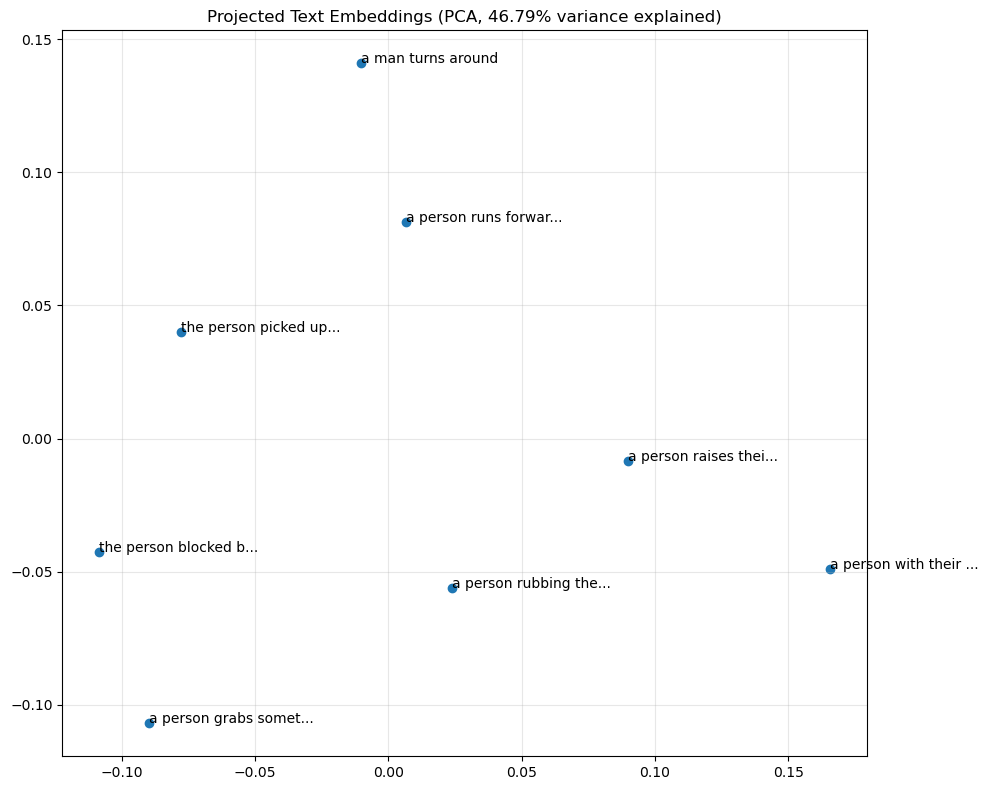

CLIP encoder setup completed in 2.61 seconds
CLIP encoder saved to: Iter7_18300p_full_210425\models\clip_encoder_full_210425.pt

Conditioned UNet Architecture Summary:
Pose dimension: 66
Base channels: 96
Channel multipliers: (1, 2, 4)
Max channels: 384
Residual blocks per level: 2
Time embedding dimension: 128
Text embedding dimension: 256
Attention heads: 4
GroupNorm groups: 8
Total parameters: 7,641,730

=== STARTING SHAPE VERIFICATION TEST ===


--- Iteration 1/3 ---

[Conditioned | Input poses - min: -0.8938, max: 1.0000 | Noisy poses - min: -7.2465, max: 9.2686 | Predicted noise - min: -4.2539, max: 4.2969]
[Diffusion loss: 4.2035 | Anatomy loss: 0.1204 | Total loss: 4.2637 | Estimated pose - min: -7.2487, max: 9.1945]
--------------------------------------------------

--- Iteration 1 completed successfully ---

--- Iteration 2/3 ---

[Conditioned | Input poses - min: -0.7871, max: 1.0000 | Noisy poses - min: -6.6597, max: 6.3640 | Predicted noise - min: -4.2969, max: 4.2656]
[D

Epoch 0:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5444, max: 1.0000 | Noisy poses - min: -7.1858, max: 4.8615 | Predicted noise - min: -3.1797, max: 3.1738]
[Diffusion loss: 2.7259 | Anatomy loss: 0.1014 | Total loss: 2.7767 | Estimated pose - min: -7.2133, max: 4.8713]
--------------------------------------------------
[Conditioned | Input poses - min: -0.4503, max: 1.0000 | Noisy poses - min: -5.2879, max: 7.5648 | Predicted noise - min: -3.2773, max: 3.1660]
[Diffusion loss: 2.6602 | Anatomy loss: 0.0955 | Total loss: 2.7080 | Estimated pose - min: -5.2946, max: 7.5274]
--------------------------------------------------
Epoch 1/100, Loss: 2.717312
[ Epoch 2/100, Guidance Scale: 2.10 ]


Epoch 1:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5799, max: 1.0000 | Noisy poses - min: -4.5401, max: 4.0404 | Predicted noise - min: -3.2324, max: 3.5352]
[Diffusion loss: 2.7517 | Anatomy loss: 0.1003 | Total loss: 2.8019 | Estimated pose - min: -4.5947, max: 4.0477]
--------------------------------------------------
[Conditioned | Input poses - min: -0.9365, max: 1.0000 | Noisy poses - min: -6.0147, max: 5.1118 | Predicted noise - min: -3.3359, max: 3.2832]
[Diffusion loss: 2.6725 | Anatomy loss: 0.1041 | Total loss: 2.7246 | Estimated pose - min: -6.2339, max: 5.0124]
--------------------------------------------------
Epoch 2/100, Loss: 2.713084
[ Epoch 3/100, Guidance Scale: 2.20 ]


Epoch 2:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.8900, max: 1.0000 | Noisy poses - min: -9.1249, max: 8.9549 | Predicted noise - min: -3.5430, max: 3.4258]
[Diffusion loss: 2.7280 | Anatomy loss: 0.0487 | Total loss: 2.7523 | Estimated pose - min: -9.2087, max: 8.8817]
--------------------------------------------------
[Conditioned | Input poses - min: -0.9642, max: 1.0000 | Noisy poses - min: -7.1938, max: 7.7228 | Predicted noise - min: -3.2461, max: 3.2324]
[Diffusion loss: 2.3882 | Anatomy loss: 0.2040 | Total loss: 2.4902 | Estimated pose - min: -7.1870, max: 7.7162]
--------------------------------------------------
Epoch 3/100, Loss: 2.501873
[ Epoch 4/100, Guidance Scale: 2.30 ]


Epoch 3:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.4764, max: 1.0000 | Noisy poses - min: -5.2322, max: 6.5412 | Predicted noise - min: -3.2402, max: 3.1602]
[Diffusion loss: 2.2950 | Anatomy loss: 0.0512 | Total loss: 2.3206 | Estimated pose - min: -5.2035, max: 6.5408]
--------------------------------------------------
[Conditioned | Input poses - min: -0.7553, max: 1.0000 | Noisy poses - min: -5.9525, max: 5.8649 | Predicted noise - min: -3.0117, max: 2.8164]
[Diffusion loss: 2.1242 | Anatomy loss: 0.1363 | Total loss: 2.1923 | Estimated pose - min: -5.9940, max: 5.9397]
--------------------------------------------------
Epoch 4/100, Loss: 3.445787
[ Epoch 5/100, Guidance Scale: 2.40 ]


Epoch 4:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5203, max: 1.0000 | Noisy poses - min: -7.6169, max: 6.9525 | Predicted noise - min: -2.9336, max: 3.1074]
[Diffusion loss: 1.9446 | Anatomy loss: 0.0294 | Total loss: 1.9593 | Estimated pose - min: -7.6936, max: 7.0075]
--------------------------------------------------
[Conditioned | Input poses - min: -0.8963, max: 1.0000 | Noisy poses - min: -9.0131, max: 9.1472 | Predicted noise - min: -2.6445, max: 2.7520]
[Diffusion loss: 1.7050 | Anatomy loss: 0.0952 | Total loss: 1.7527 | Estimated pose - min: -9.0135, max: 9.1353]
--------------------------------------------------
Epoch 5/100, Loss: 1.816235
[ Epoch 6/100, Guidance Scale: 2.50 ]


Epoch 5:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.8024, max: 1.0000 | Noisy poses - min: -7.1185, max: 6.6083 | Predicted noise - min: -2.8301, max: 2.3125]
[Diffusion loss: 1.6943 | Anatomy loss: 0.0696 | Total loss: 1.7291 | Estimated pose - min: -7.0730, max: 6.6225]
--------------------------------------------------
[Conditioned | Input poses - min: -0.6228, max: 1.0000 | Noisy poses - min: -6.8220, max: 8.9173 | Predicted noise - min: -2.2852, max: 2.5352]
[Diffusion loss: 1.5102 | Anatomy loss: 0.0810 | Total loss: 1.5507 | Estimated pose - min: -6.7881, max: 9.0151]
--------------------------------------------------
Epoch 6/100, Loss: 1.542742
[ Epoch 7/100, Guidance Scale: 2.60 ]


Epoch 6:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9211, max: 1.0000 | Noisy poses - min: -6.8222, max: 5.7045 | Predicted noise - min: -2.2363, max: 2.2324]
[Diffusion loss: 1.4115 | Anatomy loss: 0.1485 | Total loss: 1.4858 | Estimated pose - min: -6.8252, max: 5.7255]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5530, max: 1.0000 | Noisy poses - min: -4.7127, max: 8.6195 | Predicted noise - min: -2.1211, max: 1.7969]
[Diffusion loss: 1.3353 | Anatomy loss: 0.0325 | Total loss: 1.3516 | Estimated pose - min: -4.7226, max: 8.6159]
--------------------------------------------------
Epoch 7/100, Loss: 2.452844
[ Epoch 8/100, Guidance Scale: 2.70 ]


Epoch 7:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9938, max: 1.0000 | Noisy poses - min: -7.0604, max: 6.6449 | Predicted noise - min: -1.8271, max: 2.1250]
[Diffusion loss: 1.2967 | Anatomy loss: 0.1815 | Total loss: 1.3874 | Estimated pose - min: -7.0656, max: 6.6583]
--------------------------------------------------
[Conditioned | Input poses - min: -0.8823, max: 1.0000 | Noisy poses - min: -6.7974, max: 9.0314 | Predicted noise - min: -1.9775, max: 1.8027]
[Diffusion loss: 1.1784 | Anatomy loss: 0.1937 | Total loss: 1.2753 | Estimated pose - min: -6.7409, max: 8.9768]
--------------------------------------------------
Epoch 8/100, Loss: 1.274238
[ Epoch 9/100, Guidance Scale: 2.80 ]


Epoch 8:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.4464, max: 1.0000 | Noisy poses - min: -5.7168, max: 4.7421 | Predicted noise - min: -1.5977, max: 1.8154]
[Diffusion loss: 1.1918 | Anatomy loss: 0.0273 | Total loss: 1.2055 | Estimated pose - min: -5.7149, max: 4.7196]
--------------------------------------------------
[Conditioned | Input poses - min: -0.9494, max: 1.0000 | Noisy poses - min: -9.5303, max: 8.0594 | Predicted noise - min: -1.5537, max: 1.7979]
[Diffusion loss: 1.1328 | Anatomy loss: 0.0729 | Total loss: 1.1693 | Estimated pose - min: -9.5903, max: 8.1657]
--------------------------------------------------
Epoch 9/100, Loss: 1.281406
[ Epoch 10/100, Guidance Scale: 2.90 ]


Epoch 9:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5334, max: 1.0000 | Noisy poses - min: -5.1434, max: 4.7708 | Predicted noise - min: -1.5840, max: 1.5186]
[Diffusion loss: 1.1273 | Anatomy loss: 0.0463 | Total loss: 1.1505 | Estimated pose - min: -5.2408, max: 4.9100]
--------------------------------------------------
[Conditioned | Input poses - min: -0.9744, max: 1.0000 | Noisy poses - min: -6.5135, max: 8.5151 | Predicted noise - min: -1.6016, max: 1.7129]
[Diffusion loss: 1.0992 | Anatomy loss: 0.2927 | Total loss: 1.2456 | Estimated pose - min: -6.5629, max: 8.4898]
--------------------------------------------------
Epoch 10/100, Loss: 1.173051
Checkpoint saved to Iter7_18300p_full_210425\models\diffusion_Iter7_18300p_epoch010_210425.pt
[ Epoch 11/100, Guidance Scale: 3.00 ]


Epoch 10:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.4503, max: 1.0000 | Noisy poses - min: -7.3167, max: 5.2516 | Predicted noise - min: -1.9043, max: 1.4473]
[Diffusion loss: 1.1086 | Anatomy loss: 0.0946 | Total loss: 1.1559 | Estimated pose - min: -7.2308, max: 5.1508]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5752, max: 1.0000 | Noisy poses - min: -7.9593, max: 6.7921 | Predicted noise - min: -1.5049, max: 1.4883]
[Diffusion loss: 1.0850 | Anatomy loss: 0.0693 | Total loss: 1.1197 | Estimated pose - min: -7.9800, max: 6.7869]
--------------------------------------------------
Epoch 11/100, Loss: 1.141860
[ Epoch 12/100, Guidance Scale: 3.10 ]


Epoch 11:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5664, max: 1.0000 | Noisy poses - min: -5.7767, max: 3.7980 | Predicted noise - min: -1.3389, max: 1.3770]
[Diffusion loss: 1.0775 | Anatomy loss: 0.0415 | Total loss: 1.0983 | Estimated pose - min: -5.7611, max: 3.7999]
--------------------------------------------------
[Conditioned | Input poses - min: -0.8404, max: 1.0000 | Noisy poses - min: -5.6413, max: 5.0958 | Predicted noise - min: -1.1152, max: 1.1406]
[Diffusion loss: 1.0468 | Anatomy loss: 0.3649 | Total loss: 1.2292 | Estimated pose - min: -5.7025, max: 5.1170]
--------------------------------------------------
Epoch 12/100, Loss: 1.118907
[ Epoch 13/100, Guidance Scale: 3.20 ]


Epoch 12:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9751, max: 1.0000 | Noisy poses - min: -6.7296, max: 8.9883 | Predicted noise - min: -1.2090, max: 1.1309]
[Diffusion loss: 1.0761 | Anatomy loss: 0.3695 | Total loss: 1.2608 | Estimated pose - min: -6.6682, max: 8.9811]
--------------------------------------------------
[Conditioned | Input poses - min: -0.9497, max: 1.0000 | Noisy poses - min: -6.8914, max: 5.7642 | Predicted noise - min: -1.1367, max: 1.1953]
[Diffusion loss: 1.0771 | Anatomy loss: 0.0772 | Total loss: 1.1157 | Estimated pose - min: -6.8870, max: 5.8012]
--------------------------------------------------
Epoch 13/100, Loss: 1.105048
[ Epoch 14/100, Guidance Scale: 3.30 ]


Epoch 13:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9060, max: 1.0000 | Noisy poses - min: -4.9716, max: 7.7024 | Predicted noise - min: -1.3125, max: 1.0137]
[Diffusion loss: 1.0411 | Anatomy loss: 0.9187 | Total loss: 1.5004 | Estimated pose - min: -8.3734, max: 10.0000]
--------------------------------------------------
[Conditioned | Input poses - min: -0.8404, max: 1.0000 | Noisy poses - min: -7.2379, max: 3.7730 | Predicted noise - min: -1.0586, max: 0.8906]
[Diffusion loss: 1.0185 | Anatomy loss: 0.1829 | Total loss: 1.1100 | Estimated pose - min: -7.2225, max: 3.7817]
--------------------------------------------------
Epoch 14/100, Loss: 1.092555
[ Epoch 15/100, Guidance Scale: 3.40 ]


Epoch 14:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.4726, max: 1.0000 | Noisy poses - min: -6.6168, max: 5.9450 | Predicted noise - min: -1.3516, max: 1.3242]
[Diffusion loss: 1.0305 | Anatomy loss: 0.0317 | Total loss: 1.0463 | Estimated pose - min: -6.8067, max: 5.8795]
--------------------------------------------------
[Conditioned | Input poses - min: -0.6997, max: 1.0000 | Noisy poses - min: -5.2280, max: 4.7684 | Predicted noise - min: -1.0518, max: 1.0605]
[Diffusion loss: 1.0186 | Anatomy loss: 0.0882 | Total loss: 1.0626 | Estimated pose - min: -5.2240, max: 4.7032]
--------------------------------------------------
Epoch 15/100, Loss: 1.080074
[ Epoch 16/100, Guidance Scale: 3.50 ]


Epoch 15:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5334, max: 1.0000 | Noisy poses - min: -4.0817, max: 6.7184 | Predicted noise - min: -1.4014, max: 1.2129]
[Diffusion loss: 1.0122 | Anatomy loss: 0.0521 | Total loss: 1.0382 | Estimated pose - min: -4.0420, max: 6.6772]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5618, max: 1.0000 | Noisy poses - min: -5.5400, max: 4.0553 | Predicted noise - min: -1.5635, max: 0.9922]
[Diffusion loss: 1.0412 | Anatomy loss: 0.0805 | Total loss: 1.0815 | Estimated pose - min: -5.5226, max: 3.9815]
--------------------------------------------------
Epoch 16/100, Loss: 1.063608
[ Epoch 17/100, Guidance Scale: 3.60 ]


Epoch 16:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.4858, max: 1.0000 | Noisy poses - min: -7.9191, max: 5.7780 | Predicted noise - min: -1.1035, max: 1.2168]
[Diffusion loss: 1.0039 | Anatomy loss: 0.0641 | Total loss: 1.0359 | Estimated pose - min: -7.9357, max: 5.8163]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5864, max: 1.0000 | Noisy poses - min: -6.1605, max: 4.9424 | Predicted noise - min: -1.0029, max: 0.9141]
[Diffusion loss: 1.0038 | Anatomy loss: 0.0661 | Total loss: 1.0368 | Estimated pose - min: -6.1316, max: 4.9065]
--------------------------------------------------
Epoch 17/100, Loss: 1.054022
[ Epoch 18/100, Guidance Scale: 3.70 ]


Epoch 17:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.4604, max: 1.0000 | Noisy poses - min: -6.0281, max: 8.8094 | Predicted noise - min: -1.0635, max: 1.0137]
[Diffusion loss: 0.9953 | Anatomy loss: 0.0538 | Total loss: 1.0222 | Estimated pose - min: -6.0607, max: 8.8203]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5340, max: 1.0000 | Noisy poses - min: -5.7221, max: 7.3185 | Predicted noise - min: -1.7949, max: 1.1406]
[Diffusion loss: 0.9958 | Anatomy loss: 0.0388 | Total loss: 1.0152 | Estimated pose - min: -5.7170, max: 7.2602]
--------------------------------------------------
Epoch 18/100, Loss: 1.041850
[ Epoch 19/100, Guidance Scale: 3.80 ]


Epoch 18:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5562, max: 1.0000 | Noisy poses - min: -6.6158, max: 6.0958 | Predicted noise - min: -1.1445, max: 1.2314]
[Diffusion loss: 0.9980 | Anatomy loss: 0.0588 | Total loss: 1.0274 | Estimated pose - min: -6.5846, max: 6.0807]
--------------------------------------------------
[Conditioned | Input poses - min: -0.9708, max: 1.0000 | Noisy poses - min: -4.2513, max: 4.0633 | Predicted noise - min: -1.3496, max: 1.2949]
[Diffusion loss: 0.9504 | Anatomy loss: 0.3068 | Total loss: 1.1038 | Estimated pose - min: -4.6219, max: 4.5838]
--------------------------------------------------
Epoch 19/100, Loss: 1.036705
[ Epoch 20/100, Guidance Scale: 3.90 ]


Epoch 19:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5498, max: 1.0000 | Noisy poses - min: -4.2786, max: 4.5392 | Predicted noise - min: -1.1934, max: 0.9302]
[Diffusion loss: 0.9796 | Anatomy loss: 0.1012 | Total loss: 1.0302 | Estimated pose - min: -4.2980, max: 4.5519]
--------------------------------------------------
[Conditioned | Input poses - min: -0.8439, max: 1.0000 | Noisy poses - min: -6.5813, max: 6.1399 | Predicted noise - min: -1.2314, max: 1.0029]
[Diffusion loss: 0.9874 | Anatomy loss: 0.1922 | Total loss: 1.0835 | Estimated pose - min: -6.6145, max: 6.2057]
--------------------------------------------------
Epoch 20/100, Loss: 1.022580
Checkpoint saved to Iter7_18300p_full_210425\models\diffusion_Iter7_18300p_epoch020_210425.pt
[ Epoch 21/100, Guidance Scale: 4.00 ]


Epoch 20:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.8833, max: 1.0000 | Noisy poses - min: -6.4341, max: 5.5853 | Predicted noise - min: -1.3193, max: 1.2695]
[Diffusion loss: 0.9175 | Anatomy loss: 0.1418 | Total loss: 0.9884 | Estimated pose - min: -6.6075, max: 5.7552]
--------------------------------------------------
[Conditioned | Input poses - min: -0.9915, max: 1.0000 | Noisy poses - min: -9.3090, max: 7.0844 | Predicted noise - min: -1.1357, max: 1.1123]
[Diffusion loss: 0.9515 | Anatomy loss: 0.0685 | Total loss: 0.9858 | Estimated pose - min: -9.2888, max: 7.0187]
--------------------------------------------------
Epoch 21/100, Loss: 1.016101
[ Epoch 22/100, Guidance Scale: 4.10 ]


Epoch 21:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.8446, max: 1.0000 | Noisy poses - min: -6.7140, max: 6.6130 | Predicted noise - min: -1.4570, max: 1.3906]
[Diffusion loss: 0.9597 | Anatomy loss: 0.2711 | Total loss: 1.0953 | Estimated pose - min: -6.8404, max: 6.5536]
--------------------------------------------------
[Conditioned | Input poses - min: -0.9939, max: 1.0000 | Noisy poses - min: -7.7395, max: 5.8413 | Predicted noise - min: -1.3076, max: 1.5342]
[Diffusion loss: 0.9463 | Anatomy loss: 0.5197 | Total loss: 1.2062 | Estimated pose - min: -7.7424, max: 5.8563]
--------------------------------------------------
Epoch 22/100, Loss: 1.007311
[ Epoch 23/100, Guidance Scale: 4.20 ]


Epoch 22:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9510, max: 1.0000 | Noisy poses - min: -7.7945, max: 6.9531 | Predicted noise - min: -1.1436, max: 1.2217]
[Diffusion loss: 0.9623 | Anatomy loss: 0.1366 | Total loss: 1.0306 | Estimated pose - min: -7.7617, max: 7.0099]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5589, max: 1.0000 | Noisy poses - min: -4.1401, max: 6.9509 | Predicted noise - min: -1.2227, max: 1.5908]
[Diffusion loss: 0.9428 | Anatomy loss: 0.0748 | Total loss: 0.9802 | Estimated pose - min: -4.1168, max: 6.9783]
--------------------------------------------------
Epoch 23/100, Loss: 0.994509
[ Epoch 24/100, Guidance Scale: 4.30 ]


Epoch 23:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.4614, max: 1.0000 | Noisy poses - min: -5.3831, max: 6.5423 | Predicted noise - min: -1.8613, max: 1.3320]
[Diffusion loss: 0.9153 | Anatomy loss: 0.0635 | Total loss: 0.9470 | Estimated pose - min: -5.3982, max: 6.5393]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5437, max: 1.0000 | Noisy poses - min: -5.9788, max: 8.4691 | Predicted noise - min: -1.2119, max: 1.1924]
[Diffusion loss: 0.9161 | Anatomy loss: 0.0806 | Total loss: 0.9564 | Estimated pose - min: -5.9414, max: 8.5647]
--------------------------------------------------
Epoch 24/100, Loss: 1.212580
[ Epoch 25/100, Guidance Scale: 4.40 ]


Epoch 24:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.4583, max: 1.0000 | Noisy poses - min: -5.0293, max: 5.3975 | Predicted noise - min: -1.4893, max: 1.4932]
[Diffusion loss: 0.9270 | Anatomy loss: 0.0830 | Total loss: 0.9685 | Estimated pose - min: -5.3109, max: 5.2520]
--------------------------------------------------
[Conditioned | Input poses - min: -0.7288, max: 1.0000 | Noisy poses - min: -8.3069, max: 7.4593 | Predicted noise - min: -1.4336, max: 1.5127]
[Diffusion loss: 0.9195 | Anatomy loss: 0.1461 | Total loss: 0.9925 | Estimated pose - min: -8.3057, max: 7.4629]
--------------------------------------------------
Epoch 25/100, Loss: 0.973875
[ Epoch 26/100, Guidance Scale: 4.50 ]


Epoch 25:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.8900, max: 1.0000 | Noisy poses - min: -7.7181, max: 6.1486 | Predicted noise - min: -1.3301, max: 1.5049]
[Diffusion loss: 0.9045 | Anatomy loss: 0.0845 | Total loss: 0.9467 | Estimated pose - min: -7.6663, max: 6.2269]
--------------------------------------------------
[Conditioned | Input poses - min: -0.6172, max: 1.0000 | Noisy poses - min: -3.9000, max: 7.0603 | Predicted noise - min: -1.5332, max: 1.3633]
[Diffusion loss: 0.8919 | Anatomy loss: 0.1709 | Total loss: 0.9773 | Estimated pose - min: -3.9892, max: 7.0844]
--------------------------------------------------
Epoch 26/100, Loss: 0.965058
[ Epoch 27/100, Guidance Scale: 4.60 ]


Epoch 26:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5242, max: 1.0000 | Noisy poses - min: -5.9683, max: 7.0090 | Predicted noise - min: -1.6582, max: 1.6650]
[Diffusion loss: 0.8985 | Anatomy loss: 0.0993 | Total loss: 0.9482 | Estimated pose - min: -5.9623, max: 6.9793]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5215, max: 1.0000 | Noisy poses - min: -6.7806, max: 4.1008 | Predicted noise - min: -1.5781, max: 1.6875]
[Diffusion loss: 0.9208 | Anatomy loss: 0.0998 | Total loss: 0.9707 | Estimated pose - min: -6.7811, max: 4.1192]
--------------------------------------------------
Epoch 27/100, Loss: 0.960428
[ Epoch 28/100, Guidance Scale: 4.70 ]


Epoch 27:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.6415, max: 1.0000 | Noisy poses - min: -4.8393, max: 5.1323 | Predicted noise - min: -1.5420, max: 1.7471]
[Diffusion loss: 0.8929 | Anatomy loss: 0.0984 | Total loss: 0.9421 | Estimated pose - min: -4.8384, max: 5.1123]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5410, max: 1.0000 | Noisy poses - min: -6.0853, max: 5.6134 | Predicted noise - min: -1.7783, max: 1.6123]
[Diffusion loss: 0.8962 | Anatomy loss: 0.0424 | Total loss: 0.9174 | Estimated pose - min: -6.0554, max: 5.6804]
--------------------------------------------------
Epoch 28/100, Loss: 0.943504
[ Epoch 29/100, Guidance Scale: 4.80 ]


Epoch 28:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9651, max: 1.0000 | Noisy poses - min: -7.8870, max: 6.5360 | Predicted noise - min: -1.8535, max: 1.6416]
[Diffusion loss: 0.9064 | Anatomy loss: 0.1519 | Total loss: 0.9824 | Estimated pose - min: -7.8773, max: 6.4891]
--------------------------------------------------
[Conditioned | Input poses - min: -0.9365, max: 1.0000 | Noisy poses - min: -7.5954, max: 7.7377 | Predicted noise - min: -1.8418, max: 1.8994]
[Diffusion loss: 0.8949 | Anatomy loss: 0.2080 | Total loss: 0.9989 | Estimated pose - min: -7.5367, max: 7.7718]
--------------------------------------------------
Epoch 29/100, Loss: 0.937619
[ Epoch 30/100, Guidance Scale: 4.90 ]


Epoch 29:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9829, max: 1.0000 | Noisy poses - min: -6.3336, max: 4.6900 | Predicted noise - min: -1.9922, max: 1.8027]
[Diffusion loss: 0.8554 | Anatomy loss: 0.2259 | Total loss: 0.9683 | Estimated pose - min: -6.4364, max: 5.1058]
--------------------------------------------------
[Conditioned | Input poses - min: -0.9941, max: 1.0000 | Noisy poses - min: -8.3723, max: 7.8150 | Predicted noise - min: -1.7520, max: 1.4883]
[Diffusion loss: 0.8783 | Anatomy loss: 0.0494 | Total loss: 0.9030 | Estimated pose - min: -8.5197, max: 7.6827]
--------------------------------------------------
Epoch 30/100, Loss: 0.926697
Checkpoint saved to Iter7_18300p_full_210425\models\diffusion_Iter7_18300p_epoch030_210425.pt
Generating sample poses at epoch 30...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved text-to-pose visualization to: Iter7_18300p_full_210425\visualization\text_poses_epoch_030.png


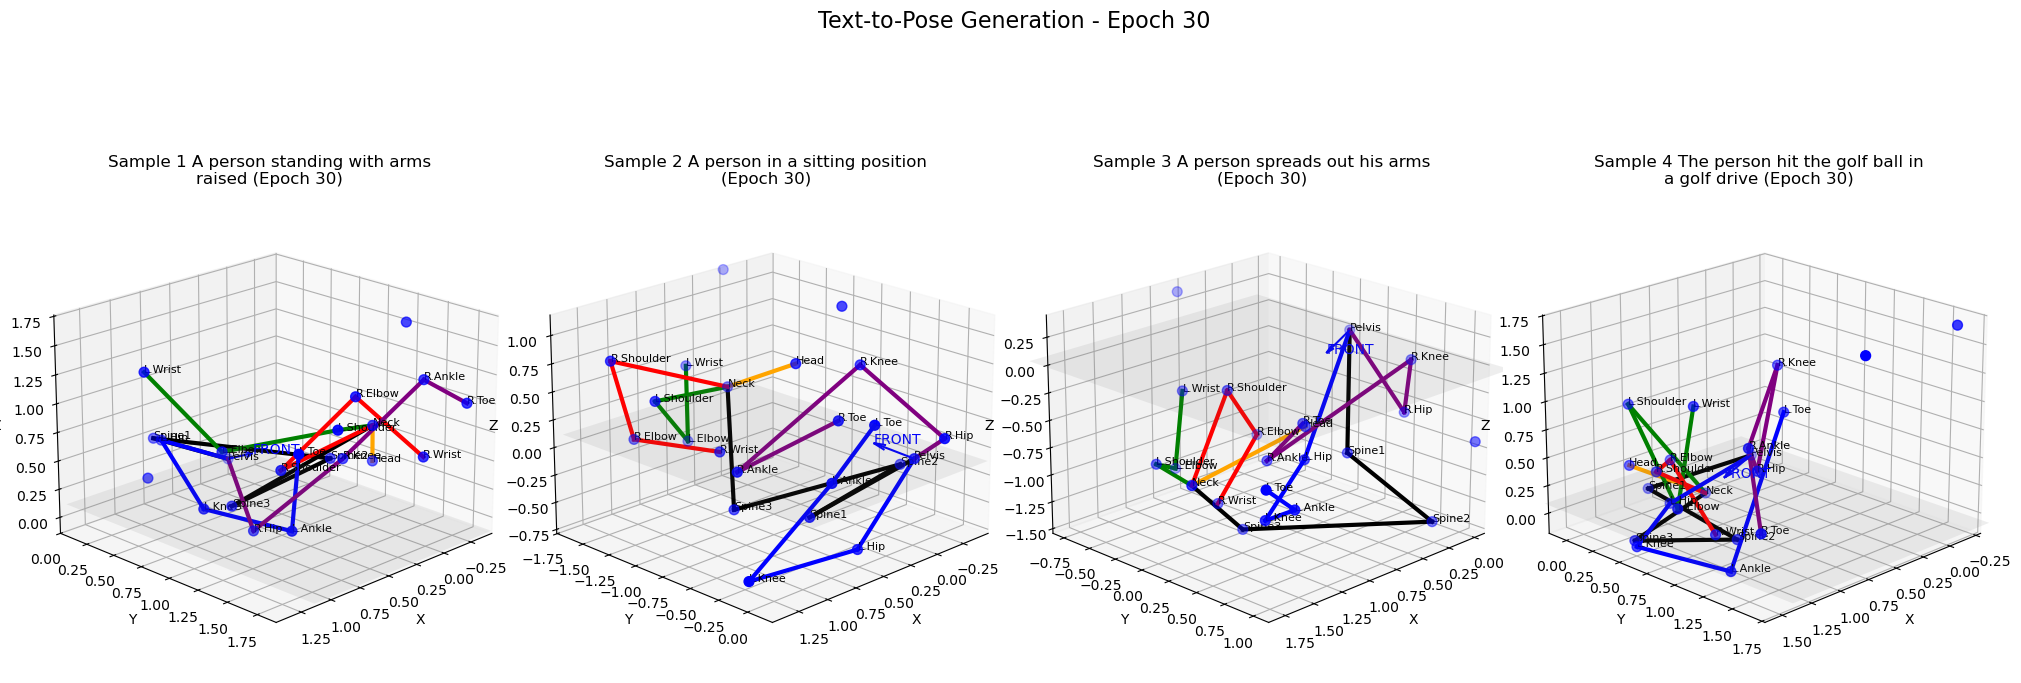

[ Epoch 31/100, Guidance Scale: 5.00 ]


Epoch 30:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5046, max: 1.0000 | Noisy poses - min: -5.0490, max: 4.3527 | Predicted noise - min: -1.6094, max: 1.7559]
[Diffusion loss: 0.9047 | Anatomy loss: 0.0770 | Total loss: 0.9433 | Estimated pose - min: -5.0726, max: 4.3111]
--------------------------------------------------
[Conditioned | Input poses - min: -0.4343, max: 1.0000 | Noisy poses - min: -7.0292, max: 8.0683 | Predicted noise - min: -2.1504, max: 1.9316]
[Diffusion loss: 0.8745 | Anatomy loss: 0.0687 | Total loss: 0.9089 | Estimated pose - min: -7.1782, max: 8.1777]
--------------------------------------------------
Epoch 31/100, Loss: 0.918022
[ Epoch 32/100, Guidance Scale: 5.10 ]


Epoch 31:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.7431, max: 1.0000 | Noisy poses - min: -6.3349, max: 4.9307 | Predicted noise - min: -1.7041, max: 1.9033]
[Diffusion loss: 0.8546 | Anatomy loss: 0.2248 | Total loss: 0.9670 | Estimated pose - min: -6.2537, max: 4.8852]
--------------------------------------------------
[Conditioned | Input poses - min: -0.6896, max: 1.0000 | Noisy poses - min: -4.5108, max: 3.7405 | Predicted noise - min: -1.6328, max: 1.5977]
[Diffusion loss: 0.8445 | Anatomy loss: 0.2931 | Total loss: 0.9910 | Estimated pose - min: -4.5195, max: 3.7604]
--------------------------------------------------
Epoch 32/100, Loss: 0.903214
[ Epoch 33/100, Guidance Scale: 5.20 ]


Epoch 32:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.8446, max: 1.0000 | Noisy poses - min: -5.5040, max: 5.5429 | Predicted noise - min: -2.1055, max: 2.0527]
[Diffusion loss: 0.8252 | Anatomy loss: 0.0792 | Total loss: 0.8648 | Estimated pose - min: -5.5416, max: 5.5790]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5576, max: 1.0000 | Noisy poses - min: -6.8979, max: 5.3521 | Predicted noise - min: -2.0684, max: 2.3223]
[Diffusion loss: 0.8348 | Anatomy loss: 0.0555 | Total loss: 0.8626 | Estimated pose - min: -6.9485, max: 5.3010]
--------------------------------------------------
Epoch 33/100, Loss: 1.708478
[ Epoch 34/100, Guidance Scale: 5.30 ]


Epoch 33:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5679, max: 1.0000 | Noisy poses - min: -5.8268, max: 6.9195 | Predicted noise - min: -1.7295, max: 2.0820]
[Diffusion loss: 0.8638 | Anatomy loss: 0.0396 | Total loss: 0.8836 | Estimated pose - min: -5.7990, max: 6.9763]
--------------------------------------------------
[Conditioned | Input poses - min: -0.6282, max: 1.0000 | Noisy poses - min: -7.6737, max: 8.3650 | Predicted noise - min: -1.9941, max: 1.9590]
[Diffusion loss: 0.8157 | Anatomy loss: 0.1308 | Total loss: 0.8811 | Estimated pose - min: -7.6887, max: 8.3061]
--------------------------------------------------
Epoch 34/100, Loss: 0.888430
[ Epoch 35/100, Guidance Scale: 5.40 ]


Epoch 34:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.4435, max: 1.0000 | Noisy poses - min: -5.8397, max: 5.1430 | Predicted noise - min: -2.1113, max: 1.7725]
[Diffusion loss: 0.8210 | Anatomy loss: 0.0331 | Total loss: 0.8376 | Estimated pose - min: -5.9724, max: 5.1549]
--------------------------------------------------
[Conditioned | Input poses - min: -0.8925, max: 1.0000 | Noisy poses - min: -4.1604, max: 8.1240 | Predicted noise - min: -2.5879, max: 2.2070]
[Diffusion loss: 0.8162 | Anatomy loss: 0.2062 | Total loss: 0.9193 | Estimated pose - min: -4.2106, max: 8.1412]
--------------------------------------------------
Epoch 35/100, Loss: 0.879495
[ Epoch 36/100, Guidance Scale: 5.50 ]


Epoch 35:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.4303, max: 1.0000 | Noisy poses - min: -7.6322, max: 6.5177 | Predicted noise - min: -2.0879, max: 2.0430]
[Diffusion loss: 0.7839 | Anatomy loss: 0.0623 | Total loss: 0.8151 | Estimated pose - min: -7.7155, max: 6.5659]
--------------------------------------------------
[Conditioned | Input poses - min: -0.9211, max: 1.0000 | Noisy poses - min: -5.0364, max: 5.8506 | Predicted noise - min: -2.2891, max: 2.5430]
[Diffusion loss: 0.8205 | Anatomy loss: 0.2068 | Total loss: 0.9239 | Estimated pose - min: -4.9948, max: 5.8438]
--------------------------------------------------
Epoch 36/100, Loss: 0.871644
[ Epoch 37/100, Guidance Scale: 5.60 ]


Epoch 36:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.7030, max: 1.0000 | Noisy poses - min: -6.5917, max: 5.5941 | Predicted noise - min: -2.1816, max: 2.1133]
[Diffusion loss: 0.8391 | Anatomy loss: 0.0997 | Total loss: 0.8889 | Estimated pose - min: -6.6228, max: 5.6120]
--------------------------------------------------
[Conditioned | Input poses - min: -0.9110, max: 1.0000 | Noisy poses - min: -4.7091, max: 5.4245 | Predicted noise - min: -2.1172, max: 2.3105]
[Diffusion loss: 0.8012 | Anatomy loss: 0.5202 | Total loss: 1.0613 | Estimated pose - min: -4.6297, max: 5.4285]
--------------------------------------------------
Epoch 37/100, Loss: 0.864422
[ Epoch 38/100, Guidance Scale: 5.70 ]


Epoch 37:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9642, max: 1.0000 | Noisy poses - min: -6.8709, max: 4.8653 | Predicted noise - min: -2.2598, max: 2.1270]
[Diffusion loss: 0.8056 | Anatomy loss: 0.1628 | Total loss: 0.8870 | Estimated pose - min: -6.8979, max: 4.8414]
--------------------------------------------------
[Conditioned | Input poses - min: -0.4357, max: 1.0000 | Noisy poses - min: -6.3611, max: 5.3703 | Predicted noise - min: -2.5957, max: 2.4492]
[Diffusion loss: 0.8028 | Anatomy loss: 0.0307 | Total loss: 0.8182 | Estimated pose - min: -6.4198, max: 5.4012]
--------------------------------------------------
Epoch 38/100, Loss: 0.857589
[ Epoch 39/100, Guidance Scale: 5.80 ]


Epoch 38:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.6482, max: 1.0000 | Noisy poses - min: -4.2622, max: 5.2166 | Predicted noise - min: -2.0195, max: 2.4453]
[Diffusion loss: 0.7902 | Anatomy loss: 0.2057 | Total loss: 0.8931 | Estimated pose - min: -4.2631, max: 5.2195]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5525, max: 1.0000 | Noisy poses - min: -4.7385, max: 4.9568 | Predicted noise - min: -2.3555, max: 2.2031]
[Diffusion loss: 0.7872 | Anatomy loss: 0.0350 | Total loss: 0.8047 | Estimated pose - min: -4.7473, max: 4.9918]
--------------------------------------------------
Epoch 39/100, Loss: 0.854599
[ Epoch 40/100, Guidance Scale: 5.90 ]


Epoch 39:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.4394, max: 1.0000 | Noisy poses - min: -8.8609, max: 7.9540 | Predicted noise - min: -2.6172, max: 2.0527]
[Diffusion loss: 0.7859 | Anatomy loss: 0.0364 | Total loss: 0.8041 | Estimated pose - min: -8.8938, max: 7.9531]
--------------------------------------------------
[Conditioned | Input poses - min: -0.4469, max: 1.0000 | Noisy poses - min: -6.4535, max: 7.6914 | Predicted noise - min: -1.8926, max: 2.4824]
[Diffusion loss: 0.7674 | Anatomy loss: 0.0549 | Total loss: 0.7949 | Estimated pose - min: -6.3717, max: 7.6641]
--------------------------------------------------
Epoch 40/100, Loss: 0.841863
Checkpoint saved to Iter7_18300p_full_210425\models\diffusion_Iter7_18300p_epoch040_210425.pt
[ Epoch 41/100, Guidance Scale: 6.00 ]


Epoch 40:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.4907, max: 1.0000 | Noisy poses - min: -6.6611, max: 5.0150 | Predicted noise - min: -2.3691, max: 2.0391]
[Diffusion loss: 0.7962 | Anatomy loss: 0.0640 | Total loss: 0.8282 | Estimated pose - min: -6.8083, max: 5.0594]
--------------------------------------------------
[Conditioned | Input poses - min: -0.8282, max: 1.0000 | Noisy poses - min: -3.5911, max: 5.0343 | Predicted noise - min: -2.5938, max: 2.6523]
[Diffusion loss: 0.7805 | Anatomy loss: 0.5191 | Total loss: 1.0400 | Estimated pose - min: -3.5823, max: 5.0339]
--------------------------------------------------
Epoch 41/100, Loss: 0.834879
[ Epoch 42/100, Guidance Scale: 6.10 ]


Epoch 41:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9798, max: 1.0000 | Noisy poses - min: -4.4068, max: 5.3597 | Predicted noise - min: -2.3145, max: 2.3965]
[Diffusion loss: 0.7841 | Anatomy loss: 0.2341 | Total loss: 0.9012 | Estimated pose - min: -4.4136, max: 5.3534]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5534, max: 1.0000 | Noisy poses - min: -5.3749, max: 4.7307 | Predicted noise - min: -2.2852, max: 2.2539]
[Diffusion loss: 0.7830 | Anatomy loss: 0.0494 | Total loss: 0.8077 | Estimated pose - min: -5.3541, max: 4.8006]
--------------------------------------------------
Epoch 42/100, Loss: 0.822150
[ Epoch 43/100, Guidance Scale: 6.20 ]


Epoch 42:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5275, max: 1.0000 | Noisy poses - min: -7.6174, max: 7.5581 | Predicted noise - min: -2.4414, max: 2.3730]
[Diffusion loss: 0.7542 | Anatomy loss: 0.0676 | Total loss: 0.7879 | Estimated pose - min: -7.7941, max: 7.5219]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5298, max: 1.0000 | Noisy poses - min: -5.4161, max: 8.0770 | Predicted noise - min: -2.8086, max: 2.9668]
[Diffusion loss: 0.7606 | Anatomy loss: 0.0226 | Total loss: 0.7719 | Estimated pose - min: -5.3765, max: 8.1586]
--------------------------------------------------
Epoch 43/100, Loss: 1.338528
[ Epoch 44/100, Guidance Scale: 6.30 ]


Epoch 43:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5002, max: 1.0000 | Noisy poses - min: -4.5449, max: 4.7430 | Predicted noise - min: -2.2090, max: 2.3418]
[Diffusion loss: 0.7554 | Anatomy loss: 0.1181 | Total loss: 0.8145 | Estimated pose - min: -4.5152, max: 4.7489]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5412, max: 1.0000 | Noisy poses - min: -5.4552, max: 4.9754 | Predicted noise - min: -2.5312, max: 2.5977]
[Diffusion loss: 0.7567 | Anatomy loss: 0.0591 | Total loss: 0.7862 | Estimated pose - min: -5.3843, max: 4.9250]
--------------------------------------------------
Epoch 44/100, Loss: 0.811019
[ Epoch 45/100, Guidance Scale: 6.40 ]


Epoch 44:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9043, max: 1.0000 | Noisy poses - min: -4.6417, max: 4.5463 | Predicted noise - min: -2.8594, max: 2.6641]
[Diffusion loss: 0.7692 | Anatomy loss: 0.2577 | Total loss: 0.8981 | Estimated pose - min: -4.6893, max: 4.5173]
--------------------------------------------------
[Conditioned | Input poses - min: -0.4381, max: 1.0000 | Noisy poses - min: -4.5714, max: 4.3817 | Predicted noise - min: -2.5605, max: 2.1719]
[Diffusion loss: 0.7547 | Anatomy loss: 0.0410 | Total loss: 0.7752 | Estimated pose - min: -4.6916, max: 4.3508]
--------------------------------------------------
Epoch 45/100, Loss: 1.020073
[ Epoch 46/100, Guidance Scale: 6.50 ]


Epoch 45:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5052, max: 1.0000 | Noisy poses - min: -5.7903, max: 6.1257 | Predicted noise - min: -2.2617, max: 2.6250]
[Diffusion loss: 0.7351 | Anatomy loss: 0.0549 | Total loss: 0.7625 | Estimated pose - min: -5.7834, max: 6.1088]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5713, max: 1.0000 | Noisy poses - min: -4.9949, max: 6.2345 | Predicted noise - min: -2.5625, max: 2.1992]
[Diffusion loss: 0.7295 | Anatomy loss: 0.0895 | Total loss: 0.7742 | Estimated pose - min: -5.0172, max: 6.2734]
--------------------------------------------------
Epoch 46/100, Loss: 0.801970
[ Epoch 47/100, Guidance Scale: 6.60 ]


Epoch 46:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5386, max: 1.0000 | Noisy poses - min: -6.7319, max: 7.8532 | Predicted noise - min: -2.4609, max: 2.0449]
[Diffusion loss: 0.7218 | Anatomy loss: 0.0459 | Total loss: 0.7447 | Estimated pose - min: -6.7297, max: 7.8608]
--------------------------------------------------
[Conditioned | Input poses - min: -0.8935, max: 1.0000 | Noisy poses - min: -6.0891, max: 6.2528 | Predicted noise - min: -2.3594, max: 2.5234]
[Diffusion loss: 0.7222 | Anatomy loss: 0.0872 | Total loss: 0.7658 | Estimated pose - min: -6.0494, max: 6.2394]
--------------------------------------------------
Epoch 47/100, Loss: 1.043382
[ Epoch 48/100, Guidance Scale: 6.70 ]


Epoch 47:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.8512, max: 1.0000 | Noisy poses - min: -4.5857, max: 6.2942 | Predicted noise - min: -2.8164, max: 2.4570]
[Diffusion loss: 0.7321 | Anatomy loss: 0.1148 | Total loss: 0.7895 | Estimated pose - min: -4.5934, max: 6.3575]
--------------------------------------------------
[Conditioned | Input poses - min: -0.7431, max: 1.0000 | Noisy poses - min: -9.5964, max: 7.0632 | Predicted noise - min: -2.6172, max: 2.8047]
[Diffusion loss: 0.7038 | Anatomy loss: 0.0932 | Total loss: 0.7504 | Estimated pose - min: -9.6555, max: 7.1093]
--------------------------------------------------
Epoch 48/100, Loss: 0.792082
[ Epoch 49/100, Guidance Scale: 6.80 ]


Epoch 48:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5588, max: 1.0000 | Noisy poses - min: -7.7746, max: 7.3022 | Predicted noise - min: -2.6465, max: 2.4922]
[Diffusion loss: 0.7218 | Anatomy loss: 0.0847 | Total loss: 0.7642 | Estimated pose - min: -7.7637, max: 7.2993]
--------------------------------------------------
[Conditioned | Input poses - min: -0.4602, max: 1.0000 | Noisy poses - min: -8.9242, max: 8.2539 | Predicted noise - min: -2.4844, max: 2.2598]
[Diffusion loss: 0.7073 | Anatomy loss: 0.0922 | Total loss: 0.7533 | Estimated pose - min: -9.1020, max: 8.3416]
--------------------------------------------------
Epoch 49/100, Loss: 0.782631
[ Epoch 50/100, Guidance Scale: 6.90 ]


Epoch 49:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.7365, max: 1.0000 | Noisy poses - min: -6.5439, max: 6.5214 | Predicted noise - min: -3.1445, max: 2.8438]
[Diffusion loss: 0.7381 | Anatomy loss: 0.0379 | Total loss: 0.7571 | Estimated pose - min: -6.4536, max: 6.4360]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5600, max: 1.0000 | Noisy poses - min: -4.3563, max: 8.8523 | Predicted noise - min: -2.6680, max: 2.1445]
[Diffusion loss: 0.7119 | Anatomy loss: 0.0414 | Total loss: 0.7326 | Estimated pose - min: -4.3706, max: 8.9390]
--------------------------------------------------
Epoch 50/100, Loss: 0.775696
Checkpoint saved to Iter7_18300p_full_210425\models\diffusion_Iter7_18300p_epoch050_210425.pt
[ Epoch 51/100, Guidance Scale: 7.00 ]


Epoch 50:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5563, max: 1.0000 | Noisy poses - min: -4.8285, max: 4.9332 | Predicted noise - min: -2.5996, max: 2.8496]
[Diffusion loss: 0.7036 | Anatomy loss: 0.0836 | Total loss: 0.7454 | Estimated pose - min: -4.8087, max: 4.9357]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5091, max: 1.0000 | Noisy poses - min: -4.9097, max: 6.0710 | Predicted noise - min: -2.3320, max: 2.3359]
[Diffusion loss: 0.6924 | Anatomy loss: 0.0455 | Total loss: 0.7151 | Estimated pose - min: -4.9045, max: 6.1062]
--------------------------------------------------
Epoch 51/100, Loss: 0.773043
[ Epoch 52/100, Guidance Scale: 7.00 ]


Epoch 51:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.7195, max: 1.0000 | Noisy poses - min: -6.7708, max: 8.2353 | Predicted noise - min: -2.5938, max: 3.0508]
[Diffusion loss: 0.7188 | Anatomy loss: 0.0494 | Total loss: 0.7435 | Estimated pose - min: -6.8459, max: 8.2899]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5661, max: 1.0000 | Noisy poses - min: -5.5840, max: 6.0563 | Predicted noise - min: -2.8828, max: 2.8125]
[Diffusion loss: 0.7416 | Anatomy loss: 0.0536 | Total loss: 0.7684 | Estimated pose - min: -5.4703, max: 6.0300]
--------------------------------------------------
Epoch 52/100, Loss: 0.769294
[ Epoch 53/100, Guidance Scale: 7.00 ]


Epoch 52:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.7261, max: 1.0000 | Noisy poses - min: -6.8323, max: 6.7910 | Predicted noise - min: -2.4316, max: 2.8809]
[Diffusion loss: 0.7119 | Anatomy loss: 0.3803 | Total loss: 0.9021 | Estimated pose - min: -6.8480, max: 6.8030]
--------------------------------------------------
[Conditioned | Input poses - min: -0.9941, max: 1.0000 | Noisy poses - min: -7.5371, max: 6.1086 | Predicted noise - min: -2.4434, max: 2.1992]
[Diffusion loss: 0.6649 | Anatomy loss: 0.1392 | Total loss: 0.7345 | Estimated pose - min: -7.5263, max: 6.0757]
--------------------------------------------------
Epoch 53/100, Loss: 0.758460
[ Epoch 54/100, Guidance Scale: 7.00 ]


Epoch 53:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5350, max: 1.0000 | Noisy poses - min: -6.4957, max: 6.9506 | Predicted noise - min: -2.6348, max: 2.7773]
[Diffusion loss: 0.7214 | Anatomy loss: 0.0827 | Total loss: 0.7628 | Estimated pose - min: -6.5280, max: 6.9677]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5203, max: 1.0000 | Noisy poses - min: -5.9759, max: 5.4321 | Predicted noise - min: -2.9590, max: 2.7617]
[Diffusion loss: 0.7092 | Anatomy loss: 0.0670 | Total loss: 0.7427 | Estimated pose - min: -5.9950, max: 5.3845]
--------------------------------------------------
Epoch 54/100, Loss: 0.759040
[ Epoch 55/100, Guidance Scale: 7.00 ]


Epoch 54:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.4523, max: 1.0000 | Noisy poses - min: -5.6681, max: 6.2725 | Predicted noise - min: -2.7305, max: 2.2891]
[Diffusion loss: 0.6988 | Anatomy loss: 0.0455 | Total loss: 0.7215 | Estimated pose - min: -5.7147, max: 6.2432]
--------------------------------------------------
[Conditioned | Input poses - min: -0.4311, max: 1.0000 | Noisy poses - min: -6.5235, max: 5.1237 | Predicted noise - min: -2.7812, max: 2.6094]
[Diffusion loss: 0.6810 | Anatomy loss: 0.0449 | Total loss: 0.7035 | Estimated pose - min: -6.5004, max: 5.1319]
--------------------------------------------------
Epoch 55/100, Loss: 0.752715
[ Epoch 56/100, Guidance Scale: 7.00 ]


Epoch 55:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.6782, max: 1.0000 | Noisy poses - min: -5.9117, max: 5.1703 | Predicted noise - min: -3.1445, max: 2.4102]
[Diffusion loss: 0.6918 | Anatomy loss: 0.1206 | Total loss: 0.7521 | Estimated pose - min: -5.9749, max: 5.1722]
--------------------------------------------------
[Conditioned | Input poses - min: -0.7871, max: 1.0000 | Noisy poses - min: -6.4524, max: 7.5806 | Predicted noise - min: -2.6367, max: 2.3555]
[Diffusion loss: 0.7311 | Anatomy loss: 0.0546 | Total loss: 0.7584 | Estimated pose - min: -6.5491, max: 7.5470]
--------------------------------------------------
Epoch 56/100, Loss: 0.743881
[ Epoch 57/100, Guidance Scale: 7.00 ]


Epoch 56:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.7086, max: 1.0000 | Noisy poses - min: -5.7685, max: 6.3592 | Predicted noise - min: -3.0195, max: 3.1328]
[Diffusion loss: 0.6456 | Anatomy loss: 0.0847 | Total loss: 0.6880 | Estimated pose - min: -5.8791, max: 6.3806]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5806, max: 1.0000 | Noisy poses - min: -5.5877, max: 5.9804 | Predicted noise - min: -2.8711, max: 3.3887]
[Diffusion loss: 0.7014 | Anatomy loss: 0.0481 | Total loss: 0.7255 | Estimated pose - min: -5.5914, max: 6.0411]
--------------------------------------------------
Epoch 57/100, Loss: 0.745041
[ Epoch 58/100, Guidance Scale: 7.00 ]


Epoch 57:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.4817, max: 1.0000 | Noisy poses - min: -5.5327, max: 8.0249 | Predicted noise - min: -2.9277, max: 2.8164]
[Diffusion loss: 0.7152 | Anatomy loss: 0.0824 | Total loss: 0.7564 | Estimated pose - min: -6.0484, max: 8.0551]
--------------------------------------------------
[Conditioned | Input poses - min: -0.4413, max: 1.0000 | Noisy poses - min: -4.9019, max: 7.0756 | Predicted noise - min: -2.5098, max: 2.5684]
[Diffusion loss: 0.6937 | Anatomy loss: 0.0306 | Total loss: 0.7090 | Estimated pose - min: -4.8641, max: 6.9728]
--------------------------------------------------
Epoch 58/100, Loss: 0.739906
[ Epoch 59/100, Guidance Scale: 7.00 ]


Epoch 58:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5866, max: 1.0000 | Noisy poses - min: -5.3619, max: 5.3133 | Predicted noise - min: -3.0566, max: 2.6191]
[Diffusion loss: 0.6841 | Anatomy loss: 0.0760 | Total loss: 0.7221 | Estimated pose - min: -5.6107, max: 5.3969]
--------------------------------------------------
[Conditioned | Input poses - min: -0.7672, max: 1.0000 | Noisy poses - min: -5.1883, max: 5.9344 | Predicted noise - min: -2.9805, max: 2.3066]
[Diffusion loss: 0.6699 | Anatomy loss: 0.0923 | Total loss: 0.7160 | Estimated pose - min: -5.2029, max: 5.9301]
--------------------------------------------------
Epoch 59/100, Loss: 0.999092
[ Epoch 60/100, Guidance Scale: 7.00 ]


Epoch 59:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5622, max: 1.0000 | Noisy poses - min: -8.1627, max: 8.0059 | Predicted noise - min: -2.9492, max: 2.7344]
[Diffusion loss: 0.6750 | Anatomy loss: 0.1203 | Total loss: 0.7351 | Estimated pose - min: -8.2393, max: 8.1193]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5335, max: 1.0000 | Noisy poses - min: -7.0588, max: 6.0581 | Predicted noise - min: -2.2871, max: 2.6680]
[Diffusion loss: 0.6587 | Anatomy loss: 0.0670 | Total loss: 0.6922 | Estimated pose - min: -7.0527, max: 6.0552]
--------------------------------------------------
Epoch 60/100, Loss: 0.733221
Checkpoint saved to Iter7_18300p_full_210425\models\diffusion_Iter7_18300p_epoch060_210425.pt
Generating sample poses at epoch 60...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved text-to-pose visualization to: Iter7_18300p_full_210425\visualization\text_poses_epoch_060.png


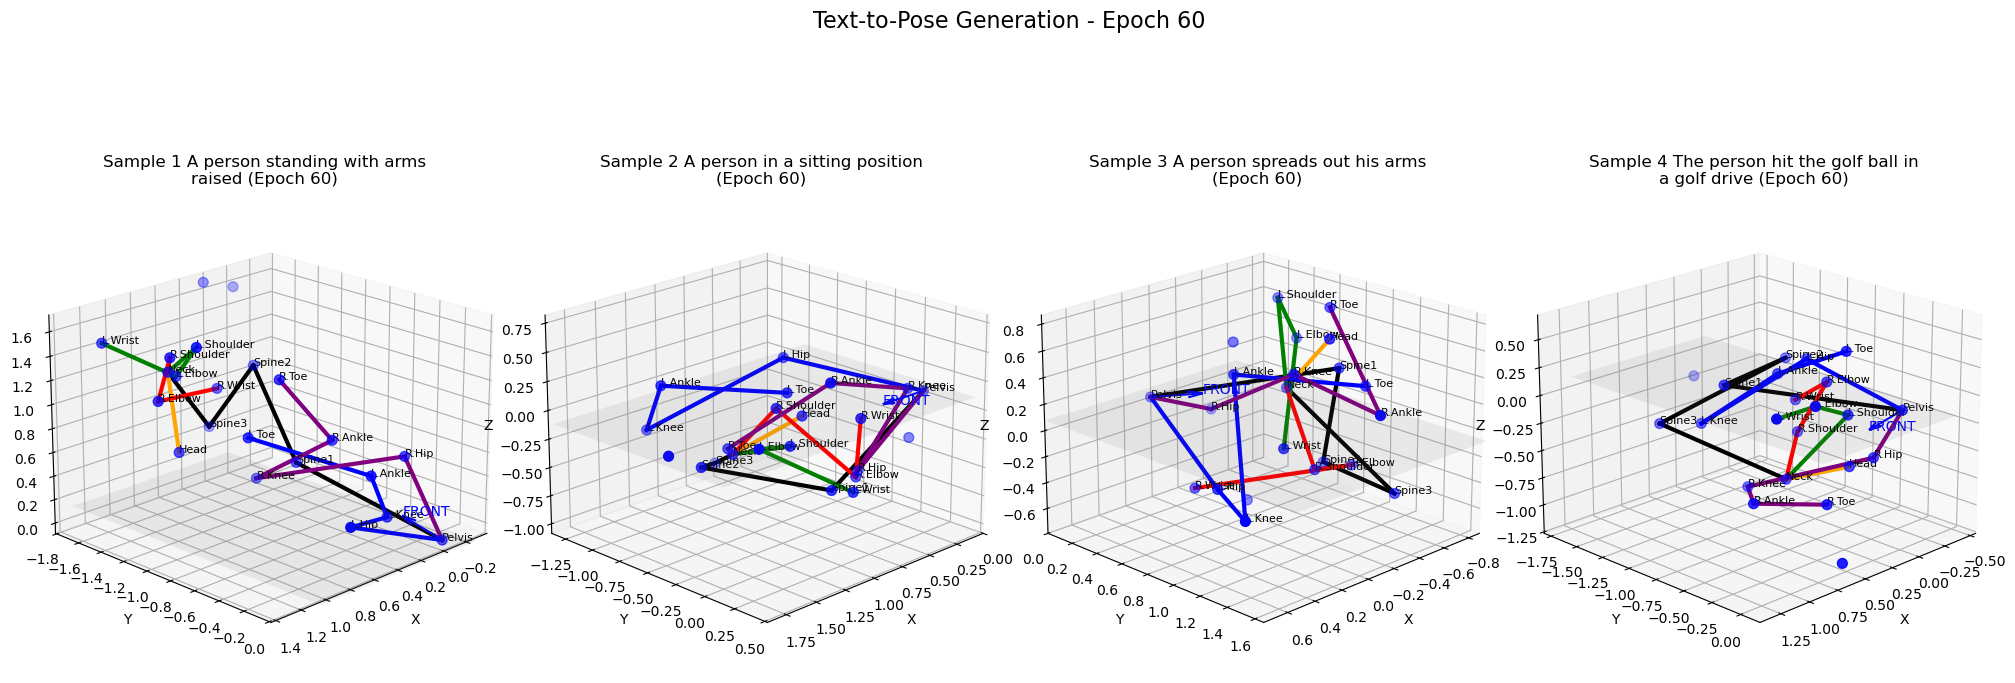

[ Epoch 61/100, Guidance Scale: 7.00 ]


Epoch 60:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.8320, max: 1.0000 | Noisy poses - min: -6.5169, max: 4.4903 | Predicted noise - min: -2.8613, max: 2.7930]
[Diffusion loss: 0.6869 | Anatomy loss: 0.1480 | Total loss: 0.7609 | Estimated pose - min: -6.5921, max: 4.3998]
--------------------------------------------------
[Conditioned | Input poses - min: -0.4792, max: 1.0000 | Noisy poses - min: -7.0897, max: 5.4382 | Predicted noise - min: -2.5547, max: 3.0430]
[Diffusion loss: 0.6884 | Anatomy loss: 0.0786 | Total loss: 0.7277 | Estimated pose - min: -7.0942, max: 6.0400]
--------------------------------------------------
Epoch 61/100, Loss: 0.728990
[ Epoch 62/100, Guidance Scale: 7.00 ]


Epoch 61:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.7222, max: 1.0000 | Noisy poses - min: -4.5894, max: 4.9938 | Predicted noise - min: -3.4082, max: 2.8164]
[Diffusion loss: 0.6587 | Anatomy loss: 0.0948 | Total loss: 0.7061 | Estimated pose - min: -4.6442, max: 5.0246]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5300, max: 1.0000 | Noisy poses - min: -8.4697, max: 6.9943 | Predicted noise - min: -2.6523, max: 2.6973]
[Diffusion loss: 0.6572 | Anatomy loss: 0.0818 | Total loss: 0.6981 | Estimated pose - min: -8.4213, max: 7.1297]
--------------------------------------------------
Epoch 62/100, Loss: 0.726641
[ Epoch 63/100, Guidance Scale: 7.00 ]


Epoch 62:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.6282, max: 1.0000 | Noisy poses - min: -7.3419, max: 6.9783 | Predicted noise - min: -3.3477, max: 3.6328]
[Diffusion loss: 0.6716 | Anatomy loss: 0.1461 | Total loss: 0.7446 | Estimated pose - min: -7.6089, max: 7.0541]
--------------------------------------------------
[Conditioned | Input poses - min: -0.9365, max: 1.0000 | Noisy poses - min: -4.8127, max: 7.7788 | Predicted noise - min: -2.9375, max: 2.7949]
[Diffusion loss: 0.6319 | Anatomy loss: 0.1581 | Total loss: 0.7110 | Estimated pose - min: -4.7066, max: 7.7762]
--------------------------------------------------
Epoch 63/100, Loss: 0.726285
[ Epoch 64/100, Guidance Scale: 7.00 ]


Epoch 63:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5464, max: 1.0000 | Noisy poses - min: -5.1394, max: 5.2482 | Predicted noise - min: -2.9531, max: 2.1953]
[Diffusion loss: 0.6702 | Anatomy loss: 0.0746 | Total loss: 0.7075 | Estimated pose - min: -5.1520, max: 5.2406]
--------------------------------------------------
[Conditioned | Input poses - min: -0.7180, max: 1.0000 | Noisy poses - min: -4.7089, max: 4.4719 | Predicted noise - min: -2.9727, max: 3.2793]
[Diffusion loss: 0.6709 | Anatomy loss: 0.0522 | Total loss: 0.6970 | Estimated pose - min: -4.7612, max: 4.4738]
--------------------------------------------------
Epoch 64/100, Loss: 0.719186
[ Epoch 65/100, Guidance Scale: 7.00 ]


Epoch 64:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.6415, max: 1.0000 | Noisy poses - min: -6.8396, max: 7.5009 | Predicted noise - min: -2.4570, max: 3.7070]
[Diffusion loss: 0.6660 | Anatomy loss: 0.0740 | Total loss: 0.7029 | Estimated pose - min: -6.9166, max: 7.6014]
--------------------------------------------------
[Conditioned | Input poses - min: -0.8823, max: 1.0000 | Noisy poses - min: -4.4812, max: 5.5549 | Predicted noise - min: -3.2246, max: 2.8027]
[Diffusion loss: 0.6425 | Anatomy loss: 0.1732 | Total loss: 0.7291 | Estimated pose - min: -4.4147, max: 5.4983]
--------------------------------------------------
Epoch 65/100, Loss: 0.720751
[ Epoch 66/100, Guidance Scale: 7.00 ]


Epoch 65:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.6430, max: 1.0000 | Noisy poses - min: -6.7606, max: 6.9213 | Predicted noise - min: -2.9219, max: 2.7246]
[Diffusion loss: 0.6427 | Anatomy loss: 0.0852 | Total loss: 0.6852 | Estimated pose - min: -6.8383, max: 6.9236]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5808, max: 1.0000 | Noisy poses - min: -5.6226, max: 5.0142 | Predicted noise - min: -2.5234, max: 3.5156]
[Diffusion loss: 0.6553 | Anatomy loss: 0.0375 | Total loss: 0.6741 | Estimated pose - min: -5.6084, max: 5.0214]
--------------------------------------------------
Epoch 66/100, Loss: 0.716320
[ Epoch 67/100, Guidance Scale: 7.00 ]


Epoch 66:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9885, max: 1.0000 | Noisy poses - min: -7.6622, max: 7.1095 | Predicted noise - min: -2.8008, max: 2.8359]
[Diffusion loss: 0.6415 | Anatomy loss: 0.1625 | Total loss: 0.7227 | Estimated pose - min: -7.7015, max: 7.1502]
--------------------------------------------------
[Conditioned | Input poses - min: -0.9688, max: 1.0000 | Noisy poses - min: -6.9767, max: 5.4485 | Predicted noise - min: -2.4004, max: 3.0449]
[Diffusion loss: 0.6577 | Anatomy loss: 0.2189 | Total loss: 0.7672 | Estimated pose - min: -6.9739, max: 5.3192]
--------------------------------------------------
Epoch 67/100, Loss: 0.712900
[ Epoch 68/100, Guidance Scale: 7.00 ]


Epoch 67:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5128, max: 1.0000 | Noisy poses - min: -5.7477, max: 7.3486 | Predicted noise - min: -2.8594, max: 2.6387]
[Diffusion loss: 0.6662 | Anatomy loss: 0.0418 | Total loss: 0.6870 | Estimated pose - min: -5.8563, max: 7.1520]
--------------------------------------------------
[Conditioned | Input poses - min: -0.8180, max: 1.0000 | Noisy poses - min: -5.2380, max: 4.0425 | Predicted noise - min: -2.7578, max: 2.8633]
[Diffusion loss: 0.6533 | Anatomy loss: 0.1306 | Total loss: 0.7186 | Estimated pose - min: -5.1954, max: 4.0366]
--------------------------------------------------
Epoch 68/100, Loss: 0.708674
[ Epoch 69/100, Guidance Scale: 7.00 ]


Epoch 68:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5103, max: 1.0000 | Noisy poses - min: -5.2045, max: 5.5194 | Predicted noise - min: -2.7754, max: 2.7148]
[Diffusion loss: 0.6540 | Anatomy loss: 0.0634 | Total loss: 0.6857 | Estimated pose - min: -5.2797, max: 5.3228]
--------------------------------------------------
[Conditioned | Input poses - min: -0.6228, max: 1.0000 | Noisy poses - min: -6.2798, max: 5.6396 | Predicted noise - min: -2.9082, max: 2.3887]
[Diffusion loss: 0.6594 | Anatomy loss: 0.0866 | Total loss: 0.7027 | Estimated pose - min: -6.2602, max: 5.6865]
--------------------------------------------------
Epoch 69/100, Loss: 0.706473
[ Epoch 70/100, Guidance Scale: 7.00 ]


Epoch 69:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.7606, max: 1.0000 | Noisy poses - min: -6.8744, max: 6.9686 | Predicted noise - min: -2.7969, max: 2.6250]
[Diffusion loss: 0.6504 | Anatomy loss: 0.1575 | Total loss: 0.7292 | Estimated pose - min: -7.7957, max: 7.4859]
--------------------------------------------------
[Conditioned | Input poses - min: -0.6117, max: 1.0000 | Noisy poses - min: -5.3889, max: 4.3265 | Predicted noise - min: -2.7559, max: 2.3672]
[Diffusion loss: 0.6736 | Anatomy loss: 0.0426 | Total loss: 0.6949 | Estimated pose - min: -5.2899, max: 4.4331]
--------------------------------------------------
Epoch 70/100, Loss: 0.707227
Checkpoint saved to Iter7_18300p_full_210425\models\diffusion_Iter7_18300p_epoch070_210425.pt
[ Epoch 71/100, Guidance Scale: 7.00 ]


Epoch 70:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9915, max: 1.0000 | Noisy poses - min: -9.3143, max: 5.7429 | Predicted noise - min: -2.6523, max: 3.1328]
[Diffusion loss: 0.6608 | Anatomy loss: 0.0812 | Total loss: 0.7014 | Estimated pose - min: -9.3037, max: 5.7248]
--------------------------------------------------
[Conditioned | Input poses - min: -0.8821, max: 1.0000 | Noisy poses - min: -7.2591, max: 5.3343 | Predicted noise - min: -2.9531, max: 3.1855]
[Diffusion loss: 0.6619 | Anatomy loss: 0.1048 | Total loss: 0.7143 | Estimated pose - min: -7.4226, max: 5.3719]
--------------------------------------------------
Epoch 71/100, Loss: 0.704508
[ Epoch 72/100, Guidance Scale: 7.00 ]


Epoch 71:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9060, max: 1.0000 | Noisy poses - min: -6.2362, max: 5.9927 | Predicted noise - min: -2.7227, max: 2.8789]
[Diffusion loss: 0.6387 | Anatomy loss: 0.0404 | Total loss: 0.6589 | Estimated pose - min: -6.3026, max: 6.1557]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5274, max: 1.0000 | Noisy poses - min: -7.5855, max: 7.4425 | Predicted noise - min: -2.9277, max: 3.0566]
[Diffusion loss: 0.6247 | Anatomy loss: 0.0660 | Total loss: 0.6577 | Estimated pose - min: -7.6013, max: 7.4348]
--------------------------------------------------
Epoch 72/100, Loss: 0.704280
[ Epoch 73/100, Guidance Scale: 7.00 ]


Epoch 72:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.4644, max: 1.0000 | Noisy poses - min: -5.6382, max: 5.6697 | Predicted noise - min: -2.8223, max: 2.9414]
[Diffusion loss: 0.6384 | Anatomy loss: 0.0323 | Total loss: 0.6545 | Estimated pose - min: -5.6270, max: 5.6609]
--------------------------------------------------
[Conditioned | Input poses - min: -0.7288, max: 1.0000 | Noisy poses - min: -8.3241, max: 6.8168 | Predicted noise - min: -3.9082, max: 2.7148]
[Diffusion loss: 0.6121 | Anatomy loss: 0.2114 | Total loss: 0.7178 | Estimated pose - min: -8.2958, max: 6.7435]
--------------------------------------------------
Epoch 73/100, Loss: 0.697074
[ Epoch 74/100, Guidance Scale: 7.00 ]


Epoch 73:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9211, max: 1.0000 | Noisy poses - min: -7.1677, max: 5.7661 | Predicted noise - min: -2.6523, max: 2.6016]
[Diffusion loss: 0.6374 | Anatomy loss: 0.0997 | Total loss: 0.6872 | Estimated pose - min: -7.2124, max: 5.7894]
--------------------------------------------------
[Conditioned | Input poses - min: -0.6997, max: 1.0000 | Noisy poses - min: -7.3968, max: 6.1358 | Predicted noise - min: -2.9141, max: 2.7246]
[Diffusion loss: 0.6741 | Anatomy loss: 0.0397 | Total loss: 0.6939 | Estimated pose - min: -7.3891, max: 6.1342]
--------------------------------------------------
Epoch 74/100, Loss: 0.698113
[ Epoch 75/100, Guidance Scale: 7.00 ]


Epoch 74:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9510, max: 1.0000 | Noisy poses - min: -7.3480, max: 5.4484 | Predicted noise - min: -2.6543, max: 2.7754]
[Diffusion loss: 0.6586 | Anatomy loss: 0.2256 | Total loss: 0.7714 | Estimated pose - min: -7.4023, max: 5.5389]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5760, max: 1.0000 | Noisy poses - min: -5.2738, max: 6.2737 | Predicted noise - min: -3.0938, max: 3.0039]
[Diffusion loss: 0.6305 | Anatomy loss: 0.1431 | Total loss: 0.7021 | Estimated pose - min: -5.1958, max: 6.2440]
--------------------------------------------------
Epoch 75/100, Loss: 0.985530
[ Epoch 76/100, Guidance Scale: 7.00 ]


Epoch 75:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9110, max: 1.0000 | Noisy poses - min: -7.3702, max: 5.3552 | Predicted noise - min: -2.8320, max: 2.9883]
[Diffusion loss: 0.6628 | Anatomy loss: 0.1245 | Total loss: 0.7250 | Estimated pose - min: -7.4616, max: 5.4239]
--------------------------------------------------
[Conditioned | Input poses - min: -0.9939, max: 1.0000 | Noisy poses - min: -7.0879, max: 6.3798 | Predicted noise - min: -2.8438, max: 2.9863]
[Diffusion loss: 0.6090 | Anatomy loss: 0.2075 | Total loss: 0.7128 | Estimated pose - min: -7.0695, max: 6.3694]
--------------------------------------------------
Epoch 76/100, Loss: 0.695891
[ Epoch 77/100, Guidance Scale: 7.00 ]


Epoch 76:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.6423, max: 1.0000 | Noisy poses - min: -8.4416, max: 7.6454 | Predicted noise - min: -2.8496, max: 2.4199]
[Diffusion loss: 0.6618 | Anatomy loss: 0.1397 | Total loss: 0.7317 | Estimated pose - min: -8.4726, max: 7.5860]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5515, max: 1.0000 | Noisy poses - min: -4.8791, max: 4.8177 | Predicted noise - min: -2.7578, max: 3.1621]
[Diffusion loss: 0.6758 | Anatomy loss: 0.0522 | Total loss: 0.7020 | Estimated pose - min: -5.4220, max: 5.1284]
--------------------------------------------------
Epoch 77/100, Loss: 0.697621
[ Epoch 78/100, Guidance Scale: 7.00 ]


Epoch 77:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9817, max: 1.0000 | Noisy poses - min: -8.5935, max: 7.6206 | Predicted noise - min: -3.4922, max: 3.3691]
[Diffusion loss: 0.6073 | Anatomy loss: 0.1112 | Total loss: 0.6629 | Estimated pose - min: -8.6392, max: 7.6849]
--------------------------------------------------
[Conditioned | Input poses - min: -0.8764, max: 1.0000 | Noisy poses - min: -9.3313, max: 7.8580 | Predicted noise - min: -2.9531, max: 3.2383]
[Diffusion loss: 0.6508 | Anatomy loss: 0.0606 | Total loss: 0.6811 | Estimated pose - min: -9.3367, max: 7.8696]
--------------------------------------------------
Epoch 78/100, Loss: 0.692319
[ Epoch 79/100, Guidance Scale: 7.00 ]


Epoch 78:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5900, max: 1.0000 | Noisy poses - min: -8.9551, max: 8.5780 | Predicted noise - min: -3.4102, max: 3.0039]
[Diffusion loss: 0.6460 | Anatomy loss: 0.0985 | Total loss: 0.6952 | Estimated pose - min: -8.9420, max: 8.7521]
--------------------------------------------------
[Conditioned | Input poses - min: -0.9060, max: 1.0000 | Noisy poses - min: -5.3571, max: 5.3762 | Predicted noise - min: -3.0391, max: 2.6191]
[Diffusion loss: 0.6416 | Anatomy loss: 0.0617 | Total loss: 0.6724 | Estimated pose - min: -5.3801, max: 5.3925]
--------------------------------------------------
Epoch 79/100, Loss: 0.693918
[ Epoch 80/100, Guidance Scale: 7.00 ]


Epoch 79:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5892, max: 1.0000 | Noisy poses - min: -6.6581, max: 5.6287 | Predicted noise - min: -3.2383, max: 2.8730]
[Diffusion loss: 0.6444 | Anatomy loss: 0.1233 | Total loss: 0.7061 | Estimated pose - min: -6.6631, max: 5.6256]
--------------------------------------------------
[Conditioned | Input poses - min: -0.6782, max: 1.0000 | Noisy poses - min: -6.8747, max: 5.3793 | Predicted noise - min: -3.5742, max: 3.2910]
[Diffusion loss: 0.5992 | Anatomy loss: 0.0558 | Total loss: 0.6271 | Estimated pose - min: -6.9166, max: 5.4265]
--------------------------------------------------
Epoch 80/100, Loss: 0.689479
Checkpoint saved to Iter7_18300p_full_210425\models\diffusion_Iter7_18300p_epoch080_210425.pt
[ Epoch 81/100, Guidance Scale: 7.00 ]


Epoch 80:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9814, max: 1.0000 | Noisy poses - min: -6.2770, max: 5.2219 | Predicted noise - min: -3.0840, max: 2.3652]
[Diffusion loss: 0.6231 | Anatomy loss: 0.2065 | Total loss: 0.7263 | Estimated pose - min: -6.3274, max: 5.2495]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5444, max: 1.0000 | Noisy poses - min: -5.1616, max: 4.8219 | Predicted noise - min: -2.6660, max: 2.9277]
[Diffusion loss: 0.6492 | Anatomy loss: 0.0236 | Total loss: 0.6610 | Estimated pose - min: -5.2640, max: 4.7814]
--------------------------------------------------
Epoch 81/100, Loss: 0.813944
[ Epoch 82/100, Guidance Scale: 7.00 ]


Epoch 81:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5727, max: 1.0000 | Noisy poses - min: -4.4874, max: 5.9305 | Predicted noise - min: -2.7168, max: 2.7324]
[Diffusion loss: 0.6813 | Anatomy loss: 0.0436 | Total loss: 0.7031 | Estimated pose - min: -4.3599, max: 5.9299]
--------------------------------------------------
[Conditioned | Input poses - min: -0.8177, max: 1.0000 | Noisy poses - min: -5.0211, max: 4.4766 | Predicted noise - min: -2.5820, max: 2.8027]
[Diffusion loss: 0.6527 | Anatomy loss: 0.1345 | Total loss: 0.7199 | Estimated pose - min: -5.2214, max: 4.5567]
--------------------------------------------------
Epoch 82/100, Loss: 0.693975
[ Epoch 83/100, Guidance Scale: 7.00 ]


Epoch 82:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9798, max: 1.0000 | Noisy poses - min: -6.0868, max: 5.7959 | Predicted noise - min: -3.1816, max: 2.8086]
[Diffusion loss: 0.6451 | Anatomy loss: 0.1920 | Total loss: 0.7411 | Estimated pose - min: -6.1247, max: 5.7660]
--------------------------------------------------
[Conditioned | Input poses - min: -0.6010, max: 1.0000 | Noisy poses - min: -7.2981, max: 6.8974 | Predicted noise - min: -2.5781, max: 3.4727]
[Diffusion loss: 0.6155 | Anatomy loss: 0.0847 | Total loss: 0.6578 | Estimated pose - min: -7.2449, max: 6.9652]
--------------------------------------------------
Epoch 83/100, Loss: 0.690307
[ Epoch 84/100, Guidance Scale: 7.00 ]


Epoch 83:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9765, max: 1.0000 | Noisy poses - min: -6.6218, max: 5.4167 | Predicted noise - min: -3.0430, max: 2.8613]
[Diffusion loss: 0.6362 | Anatomy loss: 0.3823 | Total loss: 0.8274 | Estimated pose - min: -6.6742, max: 5.3892]
--------------------------------------------------
[Conditioned | Input poses - min: -0.6371, max: 1.0000 | Noisy poses - min: -4.9678, max: 5.9079 | Predicted noise - min: -2.6484, max: 2.9375]
[Diffusion loss: 0.6195 | Anatomy loss: 0.0711 | Total loss: 0.6550 | Estimated pose - min: -4.9389, max: 6.0307]
--------------------------------------------------
Epoch 84/100, Loss: 0.683487
[ Epoch 85/100, Guidance Scale: 7.00 ]


Epoch 84:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5515, max: 1.0000 | Noisy poses - min: -6.7106, max: 6.7887 | Predicted noise - min: -2.9453, max: 3.2441]
[Diffusion loss: 0.6707 | Anatomy loss: 0.0880 | Total loss: 0.7147 | Estimated pose - min: -6.7243, max: 6.7776]
--------------------------------------------------
[Conditioned | Input poses - min: -0.4417, max: 1.0000 | Noisy poses - min: -5.2832, max: 5.5382 | Predicted noise - min: -2.9648, max: 3.1465]
[Diffusion loss: 0.6518 | Anatomy loss: 0.0440 | Total loss: 0.6738 | Estimated pose - min: -5.5461, max: 5.5594]
--------------------------------------------------
Epoch 85/100, Loss: 0.689483
[ Epoch 86/100, Guidance Scale: 7.00 ]


Epoch 85:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.7249, max: 1.0000 | Noisy poses - min: -7.7471, max: 8.2428 | Predicted noise - min: -2.5020, max: 3.0586]
[Diffusion loss: 0.6455 | Anatomy loss: 0.0689 | Total loss: 0.6799 | Estimated pose - min: -7.9394, max: 8.1717]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5535, max: 1.0000 | Noisy poses - min: -5.0670, max: 4.4260 | Predicted noise - min: -2.7949, max: 2.5625]
[Diffusion loss: 0.6480 | Anatomy loss: 0.0536 | Total loss: 0.6748 | Estimated pose - min: -5.0274, max: 4.4454]
--------------------------------------------------
Epoch 86/100, Loss: 0.687351
[ Epoch 87/100, Guidance Scale: 7.00 ]


Epoch 86:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5269, max: 1.0000 | Noisy poses - min: -5.6237, max: 6.5567 | Predicted noise - min: -2.9453, max: 3.0039]
[Diffusion loss: 0.6123 | Anatomy loss: 0.0474 | Total loss: 0.6361 | Estimated pose - min: -5.6396, max: 6.4888]
--------------------------------------------------
[Conditioned | Input poses - min: -0.4851, max: 1.0000 | Noisy poses - min: -8.5884, max: 6.4701 | Predicted noise - min: -3.1992, max: 2.9297]
[Diffusion loss: 0.6109 | Anatomy loss: 0.0722 | Total loss: 0.6470 | Estimated pose - min: -8.6016, max: 6.3918]
--------------------------------------------------
Epoch 87/100, Loss: 0.686773
[ Epoch 88/100, Guidance Scale: 7.00 ]


Epoch 87:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.8541, max: 1.0000 | Noisy poses - min: -7.1512, max: 6.9693 | Predicted noise - min: -2.6582, max: 3.1016]
[Diffusion loss: 0.5989 | Anatomy loss: 0.0847 | Total loss: 0.6412 | Estimated pose - min: -7.2295, max: 7.3479]
--------------------------------------------------
[Conditioned | Input poses - min: -0.6404, max: 1.0000 | Noisy poses - min: -5.5827, max: 4.3239 | Predicted noise - min: -2.9453, max: 2.9863]
[Diffusion loss: 0.6407 | Anatomy loss: 0.1416 | Total loss: 0.7115 | Estimated pose - min: -5.5750, max: 4.3196]
--------------------------------------------------
Epoch 88/100, Loss: 0.683462
[ Epoch 89/100, Guidance Scale: 7.00 ]


Epoch 88:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5530, max: 1.0000 | Noisy poses - min: -5.0567, max: 5.3522 | Predicted noise - min: -2.8594, max: 3.0840]
[Diffusion loss: 0.6222 | Anatomy loss: 0.0456 | Total loss: 0.6450 | Estimated pose - min: -5.0307, max: 5.3504]
--------------------------------------------------
[Conditioned | Input poses - min: -0.7429, max: 1.0000 | Noisy poses - min: -8.2318, max: 7.3215 | Predicted noise - min: -2.5098, max: 3.0547]
[Diffusion loss: 0.6359 | Anatomy loss: 0.0666 | Total loss: 0.6692 | Estimated pose - min: -8.1241, max: 7.4190]
--------------------------------------------------
Epoch 89/100, Loss: 0.689804
[ Epoch 90/100, Guidance Scale: 7.00 ]


Epoch 89:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.7086, max: 1.0000 | Noisy poses - min: -8.2458, max: 6.4517 | Predicted noise - min: -3.2383, max: 2.6953]
[Diffusion loss: 0.6172 | Anatomy loss: 0.0671 | Total loss: 0.6508 | Estimated pose - min: -8.2870, max: 6.4009]
--------------------------------------------------
[Conditioned | Input poses - min: -0.8963, max: 1.0000 | Noisy poses - min: -9.1054, max: 8.6222 | Predicted noise - min: -3.2207, max: 2.9785]
[Diffusion loss: 0.6691 | Anatomy loss: 0.1337 | Total loss: 0.7360 | Estimated pose - min: -9.1008, max: 8.6049]
--------------------------------------------------
Epoch 90/100, Loss: 0.686193
Checkpoint saved to Iter7_18300p_full_210425\models\diffusion_Iter7_18300p_epoch090_210425.pt
Generating sample poses at epoch 90...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved text-to-pose visualization to: Iter7_18300p_full_210425\visualization\text_poses_epoch_090.png


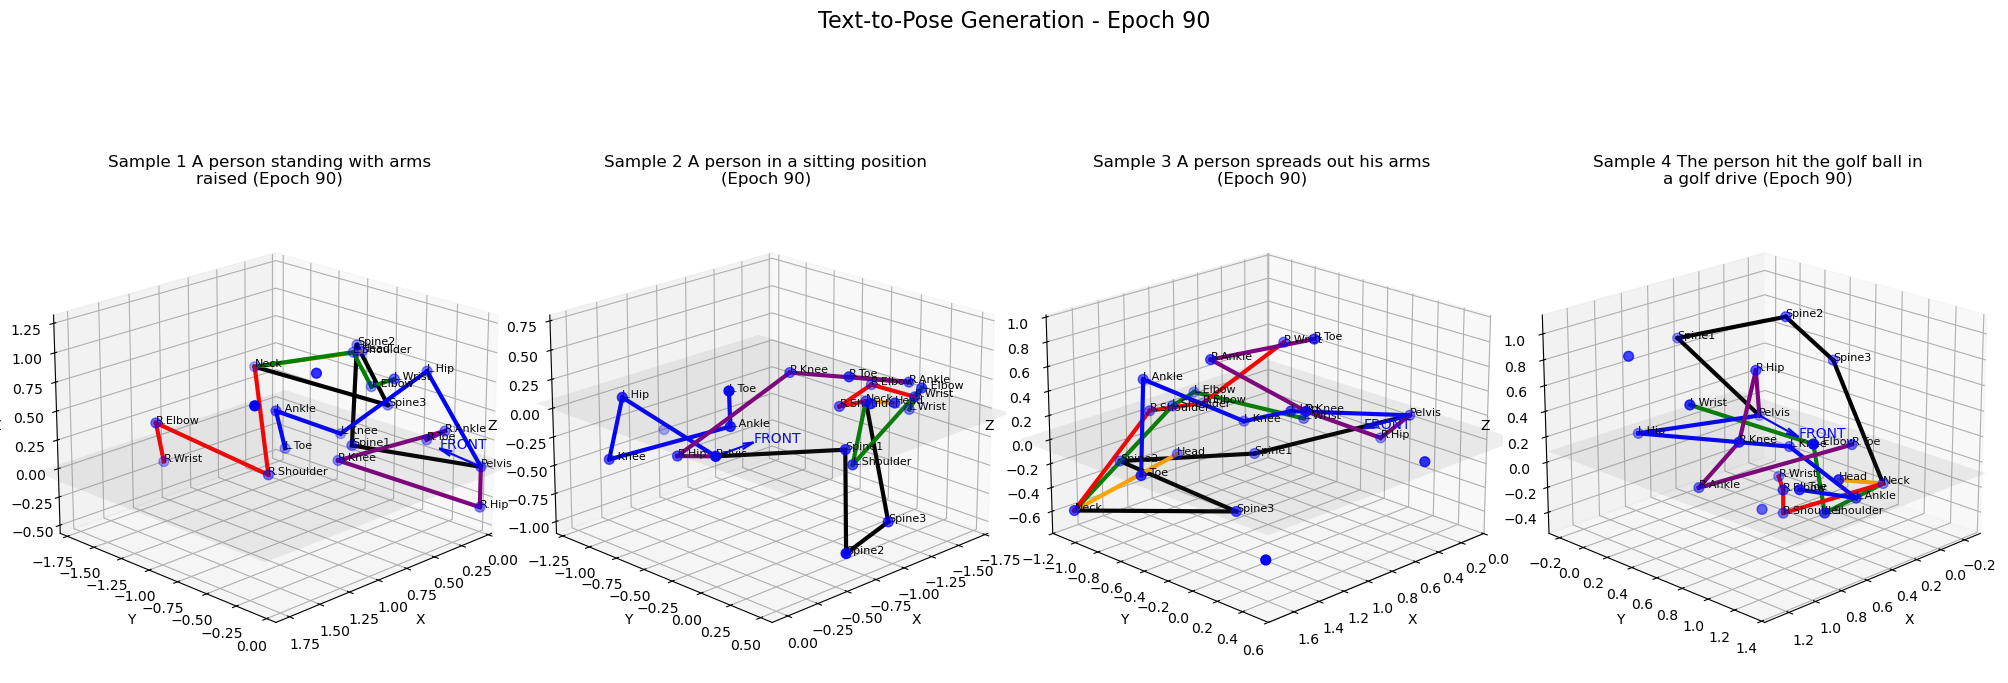

[ Epoch 91/100, Guidance Scale: 7.00 ]


Epoch 90:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.7249, max: 1.0000 | Noisy poses - min: -6.0863, max: 7.9846 | Predicted noise - min: -2.9375, max: 2.7559]
[Diffusion loss: 0.6379 | Anatomy loss: 0.0716 | Total loss: 0.6737 | Estimated pose - min: -6.0767, max: 7.9636]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5602, max: 1.0000 | Noisy poses - min: -4.1366, max: 5.2814 | Predicted noise - min: -3.3379, max: 2.6992]
[Diffusion loss: 0.6435 | Anatomy loss: 0.0520 | Total loss: 0.6695 | Estimated pose - min: -4.1388, max: 5.2726]
--------------------------------------------------
Epoch 91/100, Loss: 0.684977
[ Epoch 92/100, Guidance Scale: 7.00 ]


Epoch 91:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.8599, max: 1.0000 | Noisy poses - min: -7.0960, max: 8.4602 | Predicted noise - min: -3.1094, max: 3.1484]
[Diffusion loss: 0.6224 | Anatomy loss: 0.0825 | Total loss: 0.6636 | Estimated pose - min: -7.2451, max: 8.5291]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5639, max: 1.0000 | Noisy poses - min: -6.6638, max: 5.7196 | Predicted noise - min: -2.7539, max: 2.7695]
[Diffusion loss: 0.6651 | Anatomy loss: 0.0430 | Total loss: 0.6865 | Estimated pose - min: -6.6524, max: 5.7200]
--------------------------------------------------
Epoch 92/100, Loss: 0.683265
[ Epoch 93/100, Guidance Scale: 7.00 ]


Epoch 92:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.8444, max: 1.0000 | Noisy poses - min: -8.2093, max: 8.4821 | Predicted noise - min: -3.5586, max: 2.5488]
[Diffusion loss: 0.6172 | Anatomy loss: 0.0680 | Total loss: 0.6512 | Estimated pose - min: -8.1831, max: 8.4558]
--------------------------------------------------
[Conditioned | Input poses - min: -0.8393, max: 1.0000 | Noisy poses - min: -6.3233, max: 5.4194 | Predicted noise - min: -2.8887, max: 2.9961]
[Diffusion loss: 0.6031 | Anatomy loss: 0.2261 | Total loss: 0.7162 | Estimated pose - min: -6.2698, max: 5.4037]
--------------------------------------------------
Epoch 93/100, Loss: 0.686886
[ Epoch 94/100, Guidance Scale: 7.00 ]


Epoch 93:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9121, max: 1.0000 | Noisy poses - min: -5.4295, max: 6.1869 | Predicted noise - min: -3.2852, max: 3.3594]
[Diffusion loss: 0.6110 | Anatomy loss: 0.1783 | Total loss: 0.7002 | Estimated pose - min: -5.4123, max: 6.1833]
--------------------------------------------------
[Conditioned | Input poses - min: -0.9959, max: 1.0000 | Noisy poses - min: -8.4948, max: 5.2904 | Predicted noise - min: -2.8301, max: 3.4062]
[Diffusion loss: 0.6209 | Anatomy loss: 0.1143 | Total loss: 0.6780 | Estimated pose - min: -8.6173, max: 5.3411]
--------------------------------------------------
Epoch 94/100, Loss: 0.685983
[ Epoch 95/100, Guidance Scale: 7.00 ]


Epoch 94:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.9271, max: 1.0000 | Noisy poses - min: -6.0794, max: 5.1020 | Predicted noise - min: -2.5176, max: 2.6582]
[Diffusion loss: 0.6355 | Anatomy loss: 0.1371 | Total loss: 0.7041 | Estimated pose - min: -6.1213, max: 5.0963]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5082, max: 1.0000 | Noisy poses - min: -4.3628, max: 6.5682 | Predicted noise - min: -3.4961, max: 2.5391]
[Diffusion loss: 0.6183 | Anatomy loss: 0.0491 | Total loss: 0.6428 | Estimated pose - min: -4.3317, max: 6.5932]
--------------------------------------------------
Epoch 95/100, Loss: 0.683543
[ Epoch 96/100, Guidance Scale: 7.00 ]


Epoch 95:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5565, max: 1.0000 | Noisy poses - min: -5.0315, max: 3.8365 | Predicted noise - min: -2.7734, max: 3.4180]
[Diffusion loss: 0.6198 | Anatomy loss: 0.0681 | Total loss: 0.6538 | Estimated pose - min: -5.0524, max: 3.8406]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5576, max: 1.0000 | Noisy poses - min: -8.0890, max: 7.3099 | Predicted noise - min: -2.9023, max: 2.4531]
[Diffusion loss: 0.6317 | Anatomy loss: 0.0698 | Total loss: 0.6666 | Estimated pose - min: -8.0997, max: 7.2615]
--------------------------------------------------
Epoch 96/100, Loss: 0.687033
[ Epoch 97/100, Guidance Scale: 7.00 ]


Epoch 96:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.8439, max: 1.0000 | Noisy poses - min: -3.9481, max: 6.0340 | Predicted noise - min: -3.3984, max: 2.4922]
[Diffusion loss: 0.6628 | Anatomy loss: 0.1585 | Total loss: 0.7420 | Estimated pose - min: -3.8983, max: 5.9807]
--------------------------------------------------
[Conditioned | Input poses - min: -0.7672, max: 1.0000 | Noisy poses - min: -7.9879, max: 8.4053 | Predicted noise - min: -3.6504, max: 2.6387]
[Diffusion loss: 0.6315 | Anatomy loss: 0.0459 | Total loss: 0.6545 | Estimated pose - min: -8.0702, max: 8.4023]
--------------------------------------------------
Epoch 97/100, Loss: 0.686618
[ Epoch 98/100, Guidance Scale: 7.00 ]


Epoch 97:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5900, max: 1.0000 | Noisy poses - min: -7.9686, max: 5.8313 | Predicted noise - min: -3.0547, max: 2.8809]
[Diffusion loss: 0.6252 | Anatomy loss: 0.1397 | Total loss: 0.6950 | Estimated pose - min: -8.2117, max: 5.5807]
--------------------------------------------------
[Conditioned | Input poses - min: -0.4648, max: 1.0000 | Noisy poses - min: -7.0258, max: 6.5249 | Predicted noise - min: -2.7695, max: 3.1016]
[Diffusion loss: 0.6351 | Anatomy loss: 0.0429 | Total loss: 0.6565 | Estimated pose - min: -7.0329, max: 6.4468]
--------------------------------------------------
Epoch 98/100, Loss: 0.684917
[ Epoch 99/100, Guidance Scale: 7.00 ]


Epoch 98:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.4529, max: 1.0000 | Noisy poses - min: -4.3236, max: 6.1326 | Predicted noise - min: -2.5664, max: 2.7910]
[Diffusion loss: 0.6152 | Anatomy loss: 0.0602 | Total loss: 0.6453 | Estimated pose - min: -4.3070, max: 6.2017]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5412, max: 1.0000 | Noisy poses - min: -6.0220, max: 8.2027 | Predicted noise - min: -2.4043, max: 2.8750]
[Diffusion loss: 0.6716 | Anatomy loss: 0.0418 | Total loss: 0.6925 | Estimated pose - min: -6.0246, max: 8.2173]
--------------------------------------------------
Epoch 99/100, Loss: 1.243222
[ Epoch 100/100, Guidance Scale: 7.00 ]


Epoch 99:   0%|          | 0/187 [00:00<?, ?it/s]

[Conditioned | Input poses - min: -0.5655, max: 1.0000 | Noisy poses - min: -5.6721, max: 4.9479 | Predicted noise - min: -2.3164, max: 2.7715]
[Diffusion loss: 0.6228 | Anatomy loss: 0.0948 | Total loss: 0.6702 | Estimated pose - min: -5.6283, max: 5.0044]
--------------------------------------------------
[Conditioned | Input poses - min: -0.5661, max: 1.0000 | Noisy poses - min: -4.6425, max: 5.3902 | Predicted noise - min: -2.7422, max: 2.9590]
[Diffusion loss: 0.6335 | Anatomy loss: 0.0650 | Total loss: 0.6660 | Estimated pose - min: -4.6767, max: 5.3516]
--------------------------------------------------
Epoch 100/100, Loss: 0.685744
Checkpoint saved to Iter7_18300p_full_210425\models\diffusion_Iter7_18300p_epoch100_210425.pt
Text-to-pose training complete!
Generating final text-to-pose samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved text-to-pose visualization to: Iter7_18300p_full_210425\visualization\text_poses.png


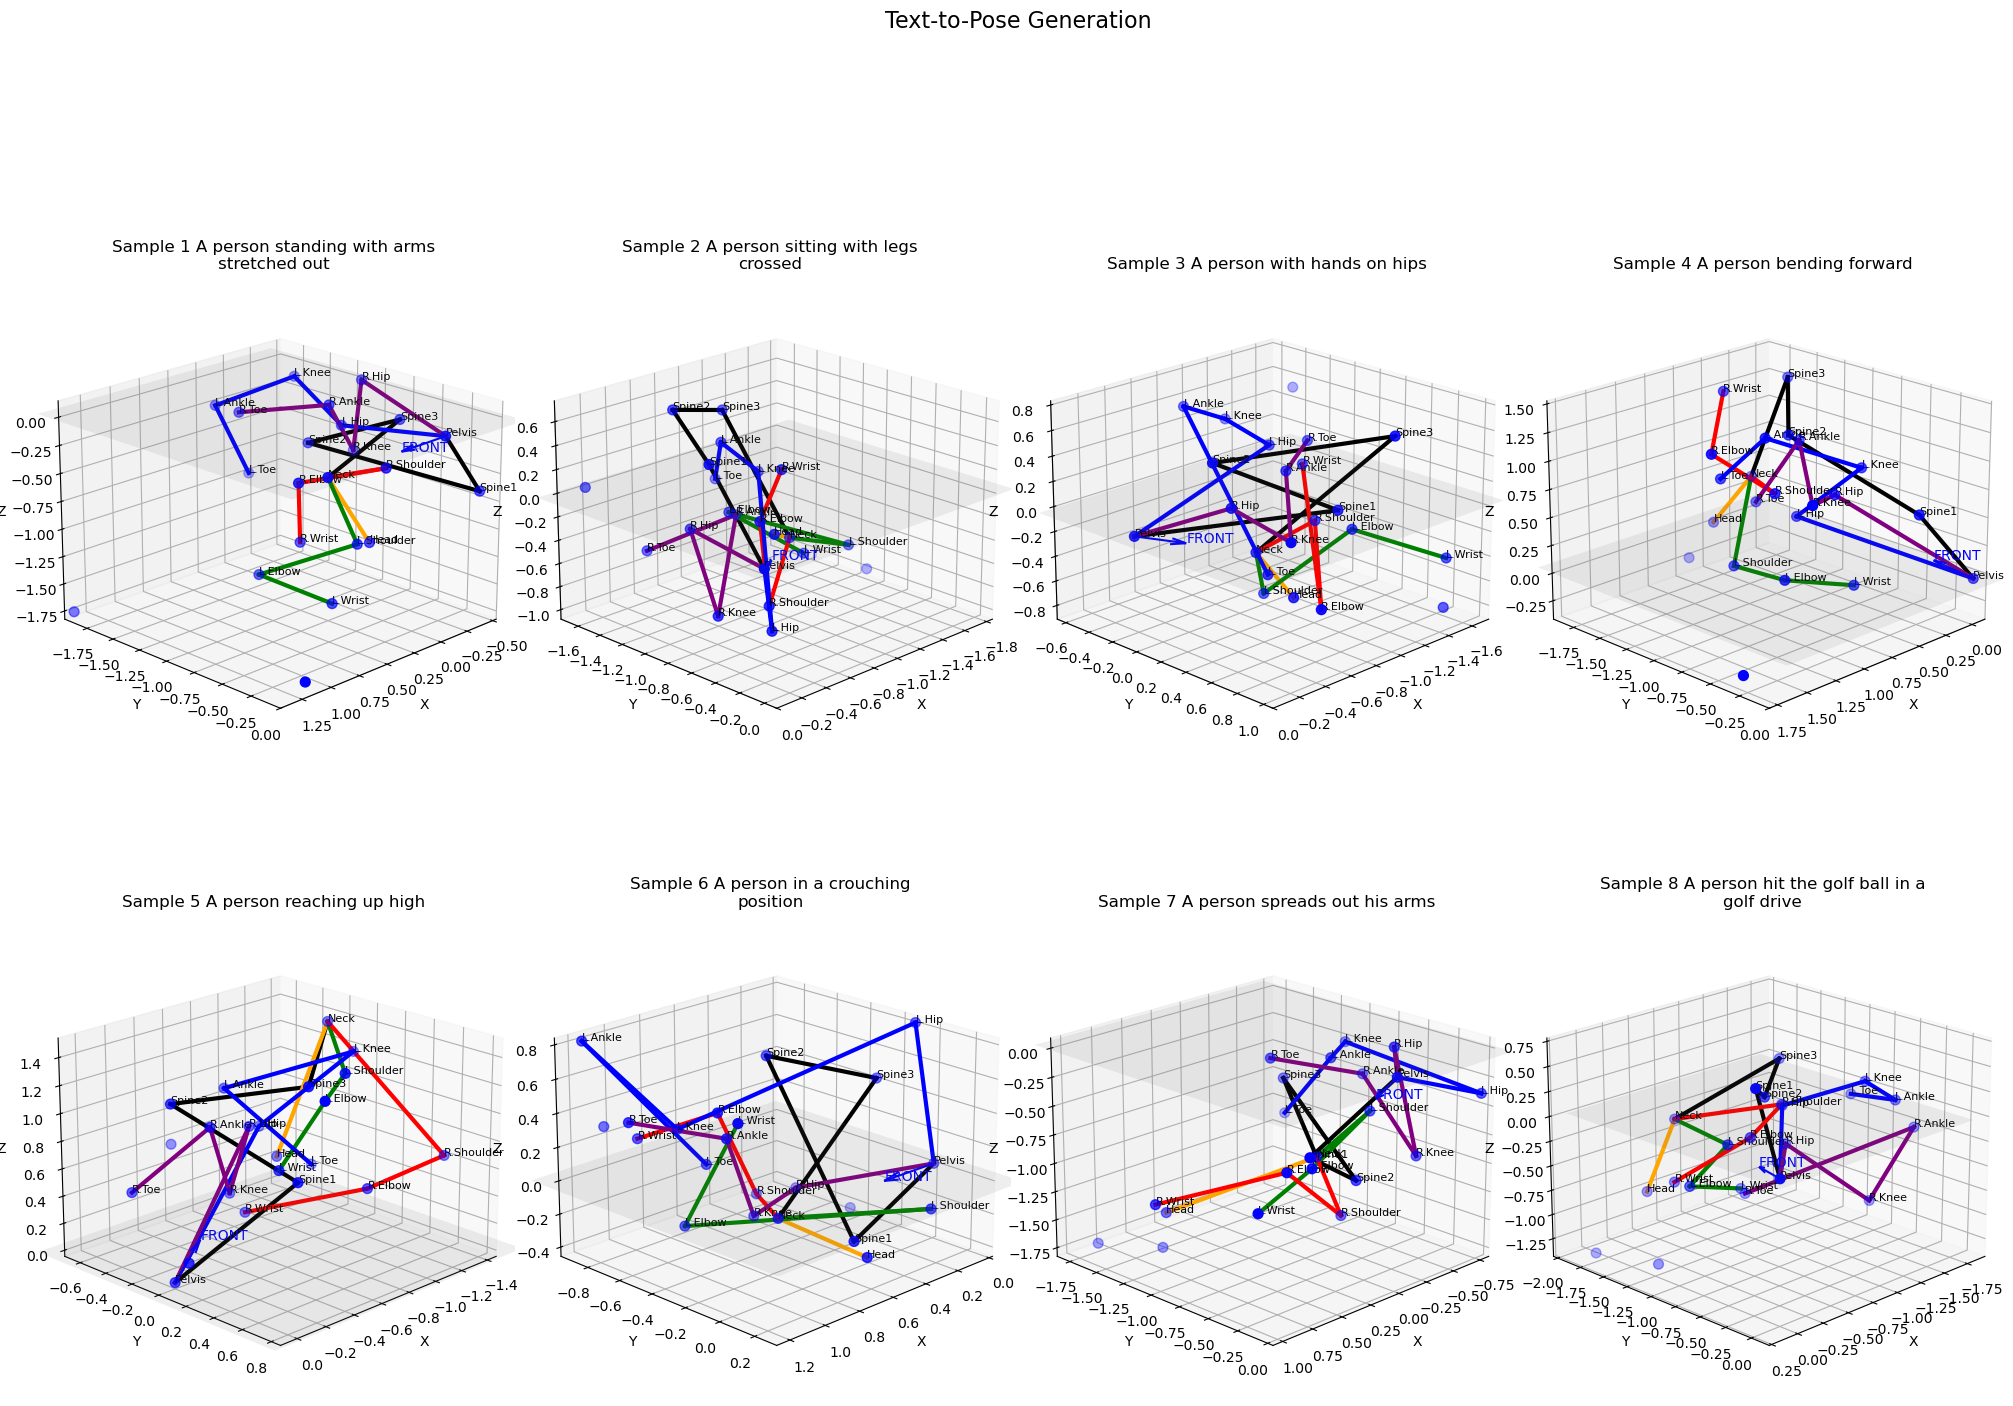

All visualizations complete!


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

import math
import numpy as np
import matplotlib.pyplot as plt
import os

from mpl_toolkits.mplot3d import Axes3D  
from diffusers import DDPMScheduler
from tqdm.auto import tqdm

from datetime import datetime
import time


# this should be a global helper.
def to_device(obj, device):
    """Move all tensors in an object to the specified device."""
    for key in dir(obj):
        if key.startswith('__'):
            continue
        attr = getattr(obj, key)
        if isinstance(attr, torch.Tensor):
            setattr(obj, key, attr.to(device))
    return obj


def shape_debug(name, tensor, detailed=True):
    """
    Debug tensor shapes with detailed statistics.
    Can be inserted anywhere in the forward pass to track tensor dimensions.
    
    Args:
        name: Identifier for the tensor (e.g., "input", "after_norm1")
        tensor: The PyTorch tensor to analyze
        detailed: Whether to print detailed statistics
        
    Returns:
        The same tensor (for chaining operations)
    """
    shape_str = f"Shape of {name}: {tensor.shape}"
    
    if detailed and tensor.numel() > 0:
        stats_str = f"[min: {tensor.min().item():.4f}, max: {tensor.max().item():.4f}, "
        stats_str += f"mean: {tensor.mean().item():.4f}, std: {tensor.std().item():.4f}]"
        print(f"{shape_str} {stats_str}")
    else:
        print(shape_str)
        
    return tensor  # Return tensor for chaining


class OptimizedNoiseScheduler:
    """
    Noise scheduler wrapper using diffusers library for numerical stability.
    
    This class wraps the DDPMScheduler from the diffusers library,
    which provides a stable implementation of the diffusion process.
    """
    
    def __init__(
        self, 
        num_train_timesteps=1000,
        beta_start=0.0001,
        beta_end=0.02,
        beta_schedule="linear",
        prediction_type="epsilon",
        clip_sample=True,
        timestep_spacing="linspace"
    ):
        """
        Initialize the noise scheduler with diffusers implementation.
        
        Args:
            num_train_timesteps: Total number of training steps
            beta_start: Starting noise level
            beta_end: Final noise level
            beta_schedule: Schedule type for noise levels ('linear', 'scaled_linear', 'squaredcos_cap_v2')
            prediction_type: What the model predicts ('epsilon', 'sample', 'v_prediction')
            clip_sample: Whether to clip predicted samples
            timestep_spacing: How to space the timesteps ('linspace', 'leading', 'trailing')
        """
        self.scheduler = DDPMScheduler(
            num_train_timesteps=num_train_timesteps,
            beta_start=beta_start,
            beta_end=beta_end,
            beta_schedule=beta_schedule,
            prediction_type=prediction_type,
            clip_sample=clip_sample,
            timestep_spacing=timestep_spacing
        )
        
        # Store basic settings for reference
        self.num_train_timesteps = num_train_timesteps
        self.device = torch.device("cpu")
    
    def to(self, device):
        """Move scheduler tensors to specified device"""
        self.device = device
        self.scheduler.to(device)
        return self
    
    def step(self, model_output, timestep, sample):
        """
        Predict the sample from the previous timestep by reversing the SDE.
        
        Args:
            model_output: The model prediction (usually noise)
            timestep: Current discrete timestep in the diffusion chain
            sample: Current noisy sample
            
        Returns:
            Previous sample (less noisy)
        """
        return self.scheduler.step(model_output, timestep, sample).prev_sample
    
    def add_noise(self, original_samples, timesteps, noise=None):
        """
        Add noise to samples according to diffusion schedule.
        
        Args:
            original_samples: Clean data samples [batch_size, ...]
            timesteps: Timesteps to add noise for [batch_size]
            noise: Optional pre-generated noise, same shape as original_samples
            
        Returns:
            Tuple of (noisy_samples, noise_added)
        """
        if noise is None:
            noise = torch.randn_like(original_samples)
            
        # Use the scheduler's add_noise method which handles the math properly
        noisy_samples = self.scheduler.add_noise(original_samples, noise, timesteps)
        
        return noisy_samples, noise
    
    def sample_timesteps(self, batch_size):
        """Sample random timesteps for a batch"""
        return torch.randint(
            0, self.num_train_timesteps, 
            (batch_size,), 
            device=self.device, 
            dtype=torch.long
        )
    
    def get_variance(self, timestep):
        """Get the variance for a specific timestep"""
        return self.scheduler.get_variance(timestep)
    
    def step_sample(self, model_fn, x_t, t, generator=None, clamp_output=True):
        """
        Sample a single step in the reverse diffusion process.
        
        Args:
            model_fn: Model function that predicts noise
            x_t: Current noisy sample
            t: Current timestep
            generator: Optional random generator for sampling
            clamp_output: Whether to clamp outputs to a reasonable range
            
        Returns:
            Less noisy sample x_{t-1}
        """
        # Get model prediction (noise/epsilon)
        noise_pred = model_fn(x_t, t)
        
        if clamp_output:
            # Clamp model output to reasonable range for stability
            noise_pred = torch.clamp(noise_pred, -5.0, 5.0)
            
        # Let the scheduler handle the math for the step
        step_output = self.scheduler.step(noise_pred, t, x_t, generator=generator)
        x_t_minus_1 = step_output.prev_sample
        
        return x_t_minus_1
    
    def sample(self, model_fn, shape, device, generator=None, clamp_output=True, progress=True):
        """
        Generate samples from noise using the full diffusion process.
        
        Args:
            model_fn: Function that takes (x, t) and returns predicted noise
            shape: Shape of samples to generate
            device: Device to generate on
            generator: Optional random generator
            clamp_output: Whether to clamp predicted noise
            progress: Whether to show progress bar
            
        Returns:
            Generated samples
        """
        # Start from pure noise
        x = torch.randn(shape, generator=generator, device=device)
        
        # Progressively denoise
        timesteps = list(range(self.num_train_timesteps))[::-1]
        if progress:
            timesteps = tqdm(timesteps, desc="Sampling")
            
        for t in timesteps:
            # Expand timestep to batch dimension
            timestep = torch.full((shape[0],), t, device=device, dtype=torch.long)
            
            # Get model prediction
            model_output = model_fn(x, timestep)
            
            if clamp_output:
                # Clamp model output for stability
                model_output = torch.clamp(model_output, -5.0, 5.0)
            
            # Perform denoising step
            x = self.scheduler.step(model_output, t, x, generator=generator).prev_sample
            
        return x


## -------------------------------------------------------------------------------------------------------------------------------------------------------------------
## -------------------------------------------------------------------------------------------------------------------------------------------------------------------




"""
CrossAttention module will work properly regardless of whether inputs are 2D [batch_size, features] or 3D [batch_size, seq_len, features].
When you pass a 2D tensor, it temporarily becomes 3D for the attention computation, then returns to 2D at the end.
"""

class CrossAttention(nn.Module):
    """
    Cross-attention module for conditioning UNet with CLIP text embeddings.
    Allows pose features to attend to text features.
    """
    def __init__(self, query_dim, context_dim, heads=4, dim_head=64, dropout=0.0):
        super().__init__()
        inner_dim = dim_head * heads
        self.scale = dim_head ** -0.5
        self.heads = heads

        # Normalization and projections
        self.to_q = nn.Linear(query_dim, inner_dim, bias=False)
        self.to_k = nn.Linear(context_dim, inner_dim, bias=False)
        self.to_v = nn.Linear(context_dim, inner_dim, bias=False)
        
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, query_dim),
            nn.Dropout(dropout)
        )

        
        # Add storage for last attention weights
        self.store_attention = True
        self.last_attention_weights = None
        
        # Initialize weights
        self._init_weights()


    
    def _init_weights(self):
        # Use 1/sqrt(N) scaling for query, key, value projections
        nn.init.xavier_normal_(self.to_q.weight)
        nn.init.xavier_normal_(self.to_k.weight)
        nn.init.xavier_normal_(self.to_v.weight)
        nn.init.xavier_normal_(self.to_out[0].weight)
        nn.init.zeros_(self.to_out[0].bias)
    
    def forward(self, x, context=None):
        """
        Forward pass for cross-attention with consistent handling of 2D inputs.
        
        Args:
            x: Query tensor of shape [batch_size, pose_feature_dim] or [batch_size, seq_len, pose_feature_dim]
            context: Key/value tensor (text embeddings) of shape [batch_size, text_feature_dim] or [batch_size, seq_len, text_feature_dim]
            
        Returns:
            Attended features with same shape as input x
        """
        # Default to self-attention if no context is provided
        context = x if context is None else context

        # # Print context stats for debugging
        # if self.store_attention and context is not None:
        #     print(f"[ CrossAttention input - context.shape: {context.shape}, mean: {context.mean().item():.5f}, std: {context.std().item():.5f} ]")

        # Track if we need to reshape back to 2D at the end
        x_is_2d = len(x.shape) == 2
        context_is_2d = len(context.shape) == 2
        
        # Add sequence dimension if inputs are 2D
        if x_is_2d:
            x = x.unsqueeze(1)  # [B, C] -> [B, 1, C]
        if context_is_2d:
            context = context.unsqueeze(1)  # [B, C] -> [B, 1, C]
        
        # Calculate query, key, value projections
        q = self.to_q(x)
        k = self.to_k(context)
        v = self.to_v(context)
        
        # Reshape for multi-head attention
        batch_size, seq_len, _ = q.shape
        q = q.reshape(batch_size, seq_len, self.heads, -1).permute(0, 2, 1, 3)  # [B, H, seq_len, dim_head]
        k = k.reshape(batch_size, -1, self.heads, k.shape[-1] // self.heads).permute(0, 2, 1, 3)  # [B, H, context_len, dim_head]
        v = v.reshape(batch_size, -1, self.heads, v.shape[-1] // self.heads).permute(0, 2, 1, 3)  # [B, H, context_len, dim_head]
        
        # Calculate attention scores
        attention_scores = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attention_weights = F.softmax(attention_scores, dim=-1)
        
        # Add storage for last attention weights 
        if self.store_attention:
            self.last_attention_weights = attention_weights.detach().cpu()

        ## too much print. insane. 
        # if self.store_attention:
        #     print(f"[ Attention scores - min: {attention_scores.min().item():.5f}, max: {attention_scores.max().item():.5f}, std: {attention_scores.std().item():.5f} ]")
        #     print(f"[ Stored attention weights of shape {self.last_attention_weights.shape} ]")

        # Apply attention and reshape
        attended_values = torch.matmul(attention_weights, v)
        attended_values = attended_values.permute(0, 2, 1, 3).contiguous()  # [B, seq_len, H, dim_head]
        attended_values = attended_values.reshape(batch_size, seq_len, -1)  # [B, seq_len, H*dim_head]
        
        # Project back to original dimension
        output = self.to_out(attended_values)
        
        # Remove sequence dimension if input was 2D
        if x_is_2d:
            output = output.squeeze(1)  # [B, 1, C] -> [B, C]
        
        return output



def visualize_attention(model, text_input):
    """
    Visualize attention patterns between text and pose features.
    
    Args:
        model: The conditioned diffusion model
        text_input: Text prompt as string
        
    Returns:
        matplotlib figure or None if no weights are available
    """

    # Create figure
    plt.figure(figsize=(8, 6))
    
    # Get tokens (simplified)
    tokens = text_input.split()
    
    # Find all CrossAttention modules
    attn_modules = []
    def find_attention_modules(module):
        for name, child in module.named_children():
            if isinstance(child, CrossAttention):
                attn_modules.append(child)
            else:
                find_attention_modules(child)
    
    find_attention_modules(model)
    
    # Enable storing attention for future calls
    for module in attn_modules:
        module.store_attention = True
    
    # Check if we have attention modules
    if not attn_modules:
        plt.title("No attention modules found in model")
        plt.text(0.5, 0.5, "Model architecture doesn't have accessible CrossAttention modules", 
                 ha='center', va='center')
        plt.tight_layout()
        return plt.gcf()
    
    # Check if any have attention weights
    attention_available = any(hasattr(m, 'last_attention_weights') and 
                              m.last_attention_weights is not None 
                              for m in attn_modules)
    
    if not attention_available:
        plt.title("No attention weights available")
        plt.text(0.5, 0.5, "Generate a pose first to capture attention weights", 
                 ha='center', va='center')
        plt.tight_layout()
        return plt.gcf()
    
    # Select modules with attention weights
    modules_with_weights = [m for m in attn_modules 
                           if hasattr(m, 'last_attention_weights') and 
                           m.last_attention_weights is not None]
    
    if not modules_with_weights:
        plt.title("All attention weights are None")
        plt.text(0.5, 0.5, "Try generating more poses to capture weights", 
                ha='center', va='center')
        plt.tight_layout()
        return plt.gcf()
    
    # Select a subset if there are many modules
    if len(modules_with_weights) > 6:
        # Pick a representative sample
        step = len(modules_with_weights) // 6
        modules_with_weights = modules_with_weights[::step][:6]
    
    # Create subplots grid
    fig, axes = plt.subplots(len(modules_with_weights), 1, figsize=(8, 1.5*len(modules_with_weights)))

    if len(modules_with_weights) == 1:
        axes = [axes]
    
    for idx, module in enumerate(modules_with_weights):
        # Get attention weights
        attn = module.last_attention_weights
        if attn is None:
            axes[idx].text(0.5, 0.5, "No attention weights for this module", 
                          ha='center', va='center')
            continue
            
        # Make sure attention has the right shape
        if len(attn.shape) != 4:
            axes[idx].text(0.5, 0.5, f"Unexpected attention shape: {attn.shape}", 
                          ha='center', va='center')
            continue
            
        # Average over batch and heads for visualization
        attn = attn.mean(dim=(0, 1))  # Average over batch and heads
        
        # Plot attention heatmap
        im = axes[idx].imshow(attn, aspect='auto', cmap='viridis')
        
        # Set title
        layer_depth = "Early" if idx < len(modules_with_weights)/3 else \
                      "Middle" if idx < 2*len(modules_with_weights)/3 else "Late"
        axes[idx].set_title(f"{layer_depth} Layer Attention")
        
        # Set labels if shape makes sense
        if attn.shape[1] <= len(tokens) + 2:  # Add 2 for potential special tokens
            # Show token labels on x-axis
            token_positions = np.arange(min(attn.shape[1], len(tokens)))
            token_labels = tokens[:len(token_positions)]
            axes[idx].set_xticks(token_positions)
            axes[idx].set_xticklabels(token_labels, rotation=45, ha='right')
        
        # Add colorbar
        plt.colorbar(im, ax=axes[idx])
    
    plt.suptitle(f"Text-to-Pose Attention: '{text_input}'")
    plt.tight_layout()
    
    
    return fig



def capture_attention_for_prompt(model, trainer, text_prompt):
    """Generate a pose with attention capture enabled, ensuring we capture the conditional pass."""
    # First encode the text
    text_embeddings = trainer.encode_text([text_prompt])
    if text_embeddings is not None:
        print(f"Text embedding for '{text_prompt}' - shape: {text_embeddings.shape}, mean: {text_embeddings.mean().item():.5f}, std: {text_embeddings.std().item():.5f}")
    else:
        print("ERROR: Failed to encode text!")
        return None, []
    
    # Find all CrossAttention modules
    attn_modules = []
    def find_attention_modules(module):
        for name, child in module.named_children():
            if isinstance(child, CrossAttention):
                attn_modules.append(child)
            else:
                find_attention_modules(child)
    
    find_attention_modules(model)
    print(f"Found {len(attn_modules)} attention modules")
    
    # Disable attention storage for all modules initially
    for module in attn_modules:
        module.store_attention = False
    
    # Generate pose with unconditional pass first (common in classifier-free guidance)
    # This is to prevent the unconditional pass from overwriting our attention weights
    with torch.no_grad():
        t = torch.full((1,), 500, device=trainer.device, dtype=torch.long)  # Middle timestep
        x = torch.randn(1, trainer.model.pose_dim, device=trainer.device)
        
        # Run unconditional pass without storing attention
        null_embeddings = torch.zeros_like(text_embeddings)
        trainer.model(x, t, null_embeddings)
    
    # Now enable attention storage for the conditional pass
    for module in attn_modules:
        module.store_attention = True
    
    # Generate pose with conditional pass, storing attention
    with torch.no_grad():
        # Run conditional pass with attention storage
        cond_output = trainer.model(x, t, text_embeddings)
        
        # Check if attention was stored
        attention_found = False
        for i, module in enumerate(attn_modules):
            if hasattr(module, 'last_attention_weights') and module.last_attention_weights is not None:
                attn = module.last_attention_weights
                print(f"Module {i} has attention weights of shape {attn.shape} - min: {attn.min().item():.5f}, max: {attn.max().item():.5f}, std: {attn.std().item():.5f}")
                attention_found = True
        
        if not attention_found:
            print("WARNING: No attention weights were stored!")
    
    # Finally do a full generation with the trainer
    results = trainer.generate_from_text(
        text_prompts=[text_prompt],
        n_samples_per_prompt=1,
        apply_constraints=True,
        guidance_scale=5.0
    )
    
    return results, attn_modules


    

    
"""
Dimensionality Tracking: Added explicit tracking of whether input is 2D with x_is_2d = len(x.shape) == 2.

Skip Connection Handling: The skip connection is now handled differently based on the input dimensionality:
    For 2D inputs: Direct residual addition with projection if needed
    For 3D inputs: If channel projection is needed, reshape → project → reshape back to maintain the sequence dimension

This implementation ensures that regardless of whether inputs are 2D or 3D, the block behaves consistently and preserves the input dimensionality throughout
processing and in the output. If a 2D tensor comes in, a 2D tensor goes out. If a 3D tensor comes in, a 3D tensor goes out.
"""



class ConditionedResidualBlock(nn.Module):
    """
    Residual block with text conditioning via cross-attention.
    Uses LayerNorm throughout for consistent tensor shape handling.
    """
    def __init__(self, in_channels, out_channels, time_channels, text_channels=256, 
                 dropout=0.1, num_groups=8, attention_heads=4):
        super().__init__()
        
        # First normalization and convolution - use LayerNorm
        self.norm1 = nn.LayerNorm(in_channels, eps=1e-5)
        self.act1 = nn.SiLU()
        self.conv1 = nn.Linear(in_channels, out_channels)
        
        # Time embedding projection
        self.time_proj = nn.Linear(time_channels, out_channels)
        self.time_act = nn.SiLU()
        
        # Cross-attention for text conditioning
        self.attn_norm = nn.LayerNorm(out_channels, eps=1e-5)
        self.attention = CrossAttention(
            query_dim=out_channels,
            context_dim=text_channels,
            heads=attention_heads,
            dim_head=out_channels // attention_heads,
            dropout=dropout
        )
        
        # Second normalization and convolution
        self.norm2 = nn.LayerNorm(out_channels, eps=1e-5)
        self.act2 = nn.SiLU()
        self.conv2 = nn.Linear(out_channels, out_channels)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Skip connection - if dimensions change, project the input
        self.skip_connection = nn.Identity() if in_channels == out_channels else nn.Linear(in_channels, out_channels)
        
        # Initialize weights properly
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using Kaiming initialization."""
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.zeros_(self.conv1.bias)
        nn.init.zeros_(self.conv2.bias)
        
        nn.init.kaiming_normal_(self.time_proj.weight, nonlinearity='relu')
        nn.init.zeros_(self.time_proj.bias)
        
        if not isinstance(self.skip_connection, nn.Identity):
            nn.init.kaiming_normal_(self.skip_connection.weight, nonlinearity='relu')
            nn.init.zeros_(self.skip_connection.bias)
    
    def forward(self, x, time_emb, text_emb=None):
        """
        Forward pass with consistent dimensionality handling.
        
        Args:
            x: Input tensor [batch_size, in_channels] or [batch_size, seq_len, in_channels]
            time_emb: Time embedding [batch_size, time_channels]
            text_emb: Text embedding from CLIP [batch_size, text_channels] or [batch_size, seq_len, text_channels]
            
        Returns:
            Output tensor with same dimensionality as input x
        """
        # Store original input for residual
        identity = x
        
        # Track input dimensionality
        x_is_2d = len(x.shape) == 2
        
        # First normalization - LayerNorm works directly on last dimension
        h = self.norm1(x)  # Shape preserved
        
        # Activation and linear projection
        h = self.act1(h)  # Shape preserved
        h = self.conv1(h)  # Shape preserved
        
        # Add time embedding
        time_emb = self.time_act(self.time_proj(time_emb))  # [B, out_channels]
        
        # Handle different shapes for time embedding addition
        if x_is_2d:
            # For 2D tensor, direct addition
            h = h + time_emb
        else:
            # For 3D tensor, broadcast time embedding across sequence dimension
            h = h + time_emb.unsqueeze(1)  # [B, 1, out_channels] broadcast across seq_len
        
        # Apply cross-attention for text conditioning if available
        if text_emb is not None:
            h_norm = self.attn_norm(h)
            # CrossAttention handles 2D/3D consistently now
            h = h + self.attention(h_norm, text_emb)
        
        # Second normalization
        h = self.norm2(h)
        
        # Second convolution
        h = self.act2(h)
        h = self.dropout(h)
        h = self.conv2(h)
        
        # Apply skip connection - handle 2D/3D identity consistently ..........
        
        if x_is_2d:
            return h + self.skip_connection(identity)          # [B,C]
        else:
            # project across the last dimension, keep seq_len
            B, L, Cin = identity.shape
            projected = self.skip_connection(identity.view(-1, Cin)).view(B, L, -1)
            return h + projected                               # [B,L,Cout] or [B,L,Cin]



"""
self.skip_connection is either nn.Identity() or an nn.Linear(in_ch, out_ch).
Use it directly; it already knows the mapping. replace the manual in_channels/out_channels.

older logic backup;
        if x_is_2d:
            # Simple 2D skip connection
            return h + self.skip_connection(identity)
        else:
            # 3D tensor - make sure identity has correct channel dim
            if in_channels != out_channels:
                # Apply skip connection across each position in sequence
                reshaped_identity = self.skip_connection(identity.reshape(-1, in_channels))
                reshaped_identity = reshaped_identity.reshape(identity.shape[0], identity.shape[1], out_channels)
                return h + reshaped_identity
            else:
                return h + identity
"""


    

class TimeEmbedding(nn.Module):
    """
    Time embedding module with proper scaling and initialization.
    
    Creates sinusoidal time embeddings similar to positional embeddings in Transformers,
    but with careful scaling to prevent numerical instability.
    """
    def __init__(self, dim, max_period=10000):
        super().__init__()
        self.dim = dim
        self.max_period = max_period


        # Replacing with 2 instead of 4.
        # Use smaller embedding dimensions for initial calculation
        self.base_dim = dim // 2
        
        # Projection with proper initialization
        self.mlp = nn.Sequential(
            nn.Linear(self.base_dim, dim),
            nn.SiLU(),
            nn.Linear(dim, dim)
        )
        
        # Initialize weights properly
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using proper scaling."""
        # First layer - careful initialization to maintain scale
        nn.init.kaiming_normal_(self.mlp[0].weight, a=0.1, nonlinearity='relu')
        nn.init.zeros_(self.mlp[0].bias)
        
        # Second layer
        nn.init.kaiming_normal_(self.mlp[2].weight, nonlinearity='relu')
        nn.init.zeros_(self.mlp[2].bias)
    
    def forward(self, t):
        """
        Create time embeddings for input timesteps.
        
        Args:
            t: Timestep indices [batch_size]
            
        Returns:
            Time embeddings [batch_size, dim]
        """
        # Make sure t is on the right device
        device = next(self.parameters()).device
        if t.device != device:
            t = t.to(device)
        
        # Handle scalar input
        if not isinstance(t, torch.Tensor):
            t = torch.tensor([t], device=device)
        
        # Create scaled sinusoidal embeddings
        half_dim = self.base_dim // 2
        emb = math.log(self.max_period) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        
        # Reshape for broadcasting
        emb = t.float().unsqueeze(1) * emb.unsqueeze(0)
        
        # Create sinusoids
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        
        # Normalize to control scale - important for stability
        emb = emb / math.sqrt(self.base_dim)
        
        # Project to final dimension with scaling
        emb = self.mlp(emb)
        
        # Clamp to prevent extreme values
        emb = torch.clamp(emb, -10.0, 10.0)
        
        return emb


## -------------------------------------------------------------------------------------------------------------------------------------------------------------------
## -------------------------------------------------------------------------------------------------------------------------------------------------------------------


class ConditionedUNetModel(nn.Module):
    """
    UNet architecture for diffusion model with text conditioning.
    """
    def __init__(
        self,
        pose_dim=66,             # Input pose dimension
        base_channels=64,        # Base channel count
        time_emb_dim=128,        # Time embedding dimension
        text_emb_dim=256,        # Text embedding dimension from CLIP
        channel_mults=(1, 2, 4), # Channel multipliers
        num_res_blocks=2,        # Number of residual blocks per level
        dropout=0.1,             # Dropout rate
        num_groups=8,            # Number of groups for GroupNorm
        attention_heads=4,       # Number of attention heads
    ):
        super().__init__()
        
        # Store configuration parameters
        self.pose_dim = pose_dim
        self.base_channels = base_channels
        self.time_emb_dim = time_emb_dim
        self.text_emb_dim = text_emb_dim
        self.channel_mults = channel_mults
        self.num_res_blocks = num_res_blocks
        self.dropout = dropout
        self.num_groups = num_groups
        self.attention_heads = attention_heads
        
        # Create time embedding module
        self.time_embedding = TimeEmbedding(time_emb_dim)
        
        # Create text embedding projection (to match each level's dimensions)
        self.text_proj_layers = nn.ModuleDict()
        
        # Input projection from pose space to feature space
        self.input_proj = nn.Sequential(
            nn.Linear(pose_dim, base_channels),
            nn.LayerNorm(base_channels),
            nn.SiLU()
        )
        
        # Create downsampling blocks
        self.down_blocks = nn.ModuleList()
        self.down_channels = []
        
        in_channels = base_channels
        for level, mult in enumerate(channel_mults):
            out_channels = base_channels * mult
            
            # Create text projection for this level
            level_name = f"level_{level}"
            self.text_proj_layers[level_name] = nn.Linear(text_emb_dim, out_channels)
            
            # Add residual blocks
            for _ in range(num_res_blocks):
                self.down_blocks.append(
                    ConditionedResidualBlock(
                        in_channels,
                        out_channels,
                        time_emb_dim,
                        text_channels=text_emb_dim,  # Use original text dim for flexibility
                        dropout=dropout,
                        num_groups=num_groups,
                        attention_heads=attention_heads
                    )
                )
                in_channels = out_channels
            
            # Store channels for skip connections
            self.down_channels.append(in_channels)
            
            # Add downsampling except for last level - use LayerNorm for consistency
            if level < len(channel_mults) - 1:
                self.down_blocks.append(
                    nn.Sequential(
                        nn.Linear(in_channels, in_channels),
                        nn.LayerNorm(in_channels),
                        nn.SiLU()
                    )
                )
        
        # Create middle blocks at bottleneck
        self.mid_blocks = nn.ModuleList()
        for _ in range(num_res_blocks):
            self.mid_blocks.append(
                ConditionedResidualBlock(
                    in_channels,
                    in_channels,
                    time_emb_dim,
                    text_channels=text_emb_dim,
                    dropout=dropout,
                    num_groups=num_groups,
                    attention_heads=attention_heads
                )
            )
        
        # Create upsampling blocks
        self.up_blocks = nn.ModuleList()
        for level, mult in reversed(list(enumerate(channel_mults))):
            out_channels = base_channels * mult
            
            # Add residual blocks with skip connections
            for i in range(num_res_blocks):
                # Use skip connection for first block of each level
                skip_channels = self.down_channels[level] if i == 0 else 0
                combined_channels = in_channels + skip_channels
                
                self.up_blocks.append(
                    ConditionedResidualBlock(
                        combined_channels,
                        out_channels,
                        time_emb_dim,
                        text_channels=text_emb_dim,
                        dropout=dropout,
                        num_groups=num_groups,
                        attention_heads=attention_heads
                    )
                )
                in_channels = out_channels
            
            # Add upsampling except for first level - use LayerNorm for consistency
            if level > 0:
                self.up_blocks.append(
                    nn.Sequential(
                        nn.Linear(in_channels, in_channels),
                        nn.LayerNorm(in_channels),
                        nn.SiLU()
                    )
                )
    
        # Final projection back to pose space - use LayerNorm for consistency
        self.final_proj = nn.Sequential(
            nn.LayerNorm(in_channels),        # Works directly on last dimension 
            nn.SiLU(),
            nn.Linear(in_channels, pose_dim),
            nn.Tanh()  # Constrain output to [-1, 1]
        )

        # Initialize weights
        self._initialize_weights()
        
        # Print network summary
        self._print_network_summary()

        
    def _initialize_weights(self):
        """Initialize weights for all layers that haven't been initialized already."""
        # Initialize input projection
        nn.init.kaiming_normal_(self.input_proj[0].weight, nonlinearity='relu')
        nn.init.zeros_(self.input_proj[0].bias)
        
        # Initialize text projections
        for proj in self.text_proj_layers.values():
            nn.init.kaiming_normal_(proj.weight, nonlinearity='relu')
            nn.init.zeros_(proj.bias)
        
        # Initialize final projection - index changed since we now use LayerNorm
        nn.init.kaiming_normal_(self.final_proj[2].weight, nonlinearity='relu')
        nn.init.zeros_(self.final_proj[2].bias)
        
        # Initialize downsampling/upsampling linear layers
        for block in self.down_blocks:
            if isinstance(block, nn.Sequential):
                nn.init.kaiming_normal_(block[0].weight, nonlinearity='relu')
                nn.init.zeros_(block[0].bias)
                
        for block in self.up_blocks:
            if isinstance(block, nn.Sequential):
                nn.init.kaiming_normal_(block[0].weight, nonlinearity='relu')
                nn.init.zeros_(block[0].bias)

            
    
    def _print_network_summary(self):
        """Print a summary of the network architecture"""
        print("\nConditioned UNet Architecture Summary:")
        print(f"Pose dimension: {self.pose_dim}")
        print(f"Base channels: {self.base_channels}")
        print(f"Channel multipliers: {self.channel_mults}")
        print(f"Max channels: {self.base_channels * max(self.channel_mults)}")
        print(f"Residual blocks per level: {self.num_res_blocks}")
        print(f"Time embedding dimension: {self.time_emb_dim}")
        print(f"Text embedding dimension: {self.text_emb_dim}")
        print(f"Attention heads: {self.attention_heads}")
        print(f"GroupNorm groups: {self.num_groups}")
        
        # Calculate parameter count
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Total parameters: {total_params:,}")
    
    def forward(self, x, t, text_emb=None, classifier_free_guidance_scale=1.0):
        """
        Forward pass of the U-Net model with text conditioning.
        
        Args:
            x: Input tensor [batch_size, pose_dim]
            t: Timestep indices [batch_size]
            text_emb: Text embeddings from CLIP [batch_size, text_emb_dim]
            classifier_free_guidance_scale: Scale factor for conditioning (1.0 = normal, 0.0 = unconditional)
            
        Returns:
            Predicted noise [batch_size, pose_dim]
        """
        batch_size = x.shape[0]
        
        # Get time embedding
        time_emb = self.time_embedding(t)
        
        # Handle classifier-free guidance
        if text_emb is not None and classifier_free_guidance_scale < 1.0:
            # For classifier-free guidance, we need unconditional and conditional predictions
            # Create a null text embedding for unconditional generation
            null_text_emb = torch.zeros_like(text_emb)
            
            # Get unconditional prediction
            with torch.no_grad():
                uncond_output = self._forward_with_text(x, time_emb, null_text_emb)
            
            # Get conditional prediction
            cond_output = self._forward_with_text(x, time_emb, text_emb)
            
            # Combine them according to guidance scale
            # guidance_scale = 1.0 means use only conditional output
            # guidance_scale = 0.0 means use only unconditional output
            return uncond_output + classifier_free_guidance_scale * (cond_output - uncond_output)
        else:
            # Standard forward pass
            return self._forward_with_text(x, time_emb, text_emb)

    


    """
    Added tracking of the input dimensionality with x_is_2d = len(x.shape) == 2 so we can maintain consistency throughout the network and return the right format.
    Important for us now. Due to these messy painful failures of shape mismatch - architecture problems.

    All concatenations now happen along the feature dimension (dim=-1), which works correctly for both 2D and 3D tensors.
        If a 2D tensor comes in, a 2D tensor goes out
        If a 3D tensor comes in, a 3D tensor goes out
        Skip connections are handled properly regardless of tensor dimensionality
        No unexpected broadcasting occurs that would add extra dimensions
        The network properly integrates all components while maintaining tensor shape consistency

    """
                
    def _forward_with_text(self, x, time_emb, text_emb=None):
        """
        Internal forward pass with proper tensor shape handling.
        
        Args:
            x: Input tensor [batch_size, pose_dim]
            time_emb: Time embedding [batch_size, time_emb_dim]
            text_emb: Text embedding [batch_size, text_emb_dim] or None
            
        Returns:
            Output tensor [batch_size, pose_dim]
        """
        # Track input dimensionality 
        x_is_2d = len(x.shape) == 2
        
        # Initial projection
        h = self.input_proj(x)
        
        # Store skip connections
        skips = []
        
        # Downsampling path
        level_idx = 0
        block_in_level = 0
        
        for i, block in enumerate(self.down_blocks):
            if isinstance(block, ConditionedResidualBlock):
                # Project text embeddings for this level if available
                curr_text_emb = None
                if text_emb is not None:
                    level_name = f"level_{level_idx}"
                    curr_text_emb = text_emb
                
                h = block(h, time_emb, curr_text_emb)
                skips.append(h)  # Save for skip connection
                
                # Track position in level
                block_in_level += 1
                if block_in_level >= self.num_res_blocks:
                    level_idx += 1
                    block_in_level = 0
            else:
                h = block(h)  # Downsampling
        
        # Middle/Bottleneck blocks
        for i, block in enumerate(self.mid_blocks):
            h = block(h, time_emb, text_emb)
        
        # Upsampling path with skip connections
        skip_idx = len(skips) - 1
        level_idx = len(self.channel_mults) - 1
        block_in_level = 0
        
        for i, block in enumerate(self.up_blocks):
            if isinstance(block, ConditionedResidualBlock):
                # Only use skip connection for first block of each level
                if block_in_level == 0 and skip_idx >= 0:
                    skip = skips[skip_idx]
                    
                    # Ensure dimensionality matches before concatenation
                    h_is_2d = len(h.shape) == 2
                    skip_is_2d = len(skip.shape) == 2

                    ## -> explicit checks; concatenating skip connections is SO HARD.
                    if h_is_2d != skip_is_2d:
                        if h_is_2d and not skip_is_2d:
                            # h is 2D but skip is 3D
                            h = h.unsqueeze(1)  # [B, C] -> [B, 1, C]
                        elif not h_is_2d and skip_is_2d:
                            # h is 3D but skip is 2D
                            skip = skip.unsqueeze(1)  # [B, C] -> [B, 1, C]
                    
                    # Concatenate along feature dimension
                    h = torch.cat([h, skip], dim=-1)
                    skip_idx -= self.num_res_blocks
                
                # Project text embeddings for this level if available
                curr_text_emb = None
                if text_emb is not None:
                    level_name = f"level_{level_idx}"
                    curr_text_emb = text_emb
                
                h = block(h, time_emb, curr_text_emb)
                
                # Track position within current level
                block_in_level += 1
                if block_in_level >= self.num_res_blocks:
                    level_idx -= 1
                    block_in_level = 0
            else:
                h = block(h)  # Upsampling
        
        # Ensure output has correct dimensionality
        if not x_is_2d and len(h.shape) == 2:
            h = h.unsqueeze(1)  # Restore sequence dimension if lost
        elif x_is_2d and len(h.shape) == 3:
            h = h.squeeze(1)  # Remove sequence dimension if input was 2D
        
        # Final projection and scaling
        output = self.final_proj(h)
        output = output * 1.5  # Scale Tanh output to appropriate range
        
        # Final dimensionality check
        if x_is_2d and len(output.shape) == 3:
            output = output.squeeze(1)
        
        return output    

    
"""
Tanh outputs values in the range [-1, 1]
normalized poses typically have a wider range (often reaching -0.5 to 1.0 based on your logs)
caling factor of 1.5 would give you a range of [-1.5, 1.5]
"""



## -------------------------------------------------------------------------------------------------------------------------------------------------------------------
## -------------------------------------------------------------------------------------------------------------------------------------------------------------------


"""
enforce_anatomical_constraints method is meant to take generated poses and fix them to ensure they follow anatomical rules. 
called during the sampling process (sample_poses) when you set apply_constraints=True.

** Even with improved training process that includes anatomy loss, the generated poses might still have anatomical issues like unrealistic bone lengths or joint angles.
Enforce - Realistic bone lengths, Proper joint angles, Physical plausibility of the pose.
"""




class ConditionedDiffusionTrainer:
    """
    Diffusion model trainer with support for text conditioning.
    """
    
    def __init__(
        self, model, noise_scheduler, optimizer, device,
        clip_encoder=None, use_amp=True, max_grad_norm=1.0, scheduler=None, guidance_scale=3.0, 
        inference_scheduler=None
    ):
        self.model = model.to(device)
        self.noise_scheduler = noise_scheduler
        self.optimizer = optimizer
        self.device = device
        self.clip_encoder = clip_encoder
        self.use_amp = use_amp and torch.cuda.is_available()
        self.max_grad_norm = max_grad_norm
        self.scheduler = scheduler
        self.guidance_scale = guidance_scale
        
        # Setup mixed precision training
        self.scaler = torch.cuda.amp.GradScaler() if self.use_amp else None
        
        # inference scheduler (same as training scheduler if not provided)
        self.inference_scheduler = inference_scheduler or noise_scheduler

        # Define the skeleton connections for HumanML3D
        # -------- wrong, updated now.
        # self.skeleton_connections = [
        #     (0, 1), (0, 5), (0, 9),   # Pelvis connections
        #     (1, 2), (2, 3), (3, 4),   # Spine to head
        #     (5, 6), (6, 7), (7, 8),   # Left arm
        #     (9, 10), (10, 11), (11, 12), # Right arm
        #     (0, 13), (13, 14), (14, 15), (15, 16), # Left leg
        #     (0, 17), (17, 18), (18, 19), (19, 20)  # Right leg
        # ]

        self.skeleton_connections = [
        # Left leg
        (0, 1), (1, 2), (2, 3), (3, 4),
        # Right leg
        (0, 5), (5, 6), (6, 7), (7, 8),
        # Spine & head
        (0, 9), (9, 10), (10, 11), (11, 12), (12, 13),
        # Left arm
        (12, 14), (14, 15), (15, 16),
        # Right arm
        (12, 17), (17, 18), (18, 19) ]



        
    def normalize_batch(self, batch):
        """Normalize the input batch for numerical stability."""
        # Compute batch statistics per feature dimension
        batch_mean = batch.mean(dim=0, keepdim=True)
        batch_std = batch.std(dim=0, keepdim=True) + 1e-5  # Avoid division by zero
        
        # Normalize
        normalized_batch = (batch - batch_mean) / batch_std
        
        return normalized_batch, batch_mean, batch_std
    
    def denormalize_batch(self, normalized_batch, batch_mean, batch_std):
        """Denormalize a normalized batch back to original scale."""
        return normalized_batch * batch_std + batch_mean
    
    def bone_length_consistency_loss(self, pred_pose, target_pose):
        """Calculate bone length consistency loss with proper clamping."""
        # Reshape to [batch_size, 22, 3]
        batch_size = pred_pose.shape[0]
        pred_pose = pred_pose.reshape(batch_size, 22, 3)
        target_pose = target_pose.reshape(batch_size, 22, 3)
        
        loss = 0
        # Calculate squared distances between connected joints
        for joint1, joint2 in self.skeleton_connections:
            # Calculate bone length for predicted pose
            pred_vec = pred_pose[:, joint1] - pred_pose[:, joint2]
            pred_bone_length = torch.sum(pred_vec**2, dim=-1)
            
            # Calculate bone length for target pose
            target_vec = target_pose[:, joint1] - target_pose[:, joint2]
            target_bone_length = torch.sum(target_vec**2, dim=-1)
            
            # Calculate loss with clamping to avoid extreme values
            joint_loss = F.mse_loss(
                torch.clamp(pred_bone_length, 0.0, 10.0),
                torch.clamp(target_bone_length, 0.0, 10.0)
            )
            
            loss += joint_loss
            
        return loss
    
    def encode_text(self, text_descriptions):
        """Encode text descriptions using CLIP encoder if available."""
        if self.clip_encoder is None or text_descriptions is None:
            return None
            
        # Move to device
        if isinstance(text_descriptions[0], str):
            with torch.no_grad():
                # Use the forward method which handles tokenization
                result = self.clip_encoder(text_descriptions)
                # Return the projected features that match the expected dimension
                return result['projected_features'].to(self.device)
        else:
            # If already encoded, just return
            return text_descriptions.to(self.device)


            
    def train_step(self, poses, text_descriptions=None, print_stats=False, guidance_scale=None):
        """
        Single training step with support for text conditioning.
        
        Args:
            poses: Pose tensor [batch_size, pose_dim]
            text_descriptions: Text descriptions for conditioning or None
            print_stats: Whether to print diagnostic statistics
        """
        batch_size = poses.shape[0]
        poses = poses.to(self.device)

        # Use provided guidance scale or default
        current_guidance = guidance_scale if guidance_scale is not None else self.guidance_scale

        # Encode text if provided
        text_embeddings = self.encode_text(text_descriptions) if text_descriptions is not None else None
        
        # Normalize input poses for stability
        normalized_poses, pose_mean, pose_std = self.normalize_batch(poses)
        
        # Sample random timesteps
        t = self.noise_scheduler.sample_timesteps(batch_size)
        
        # Zero gradients
        self.optimizer.zero_grad()
        
        if self.use_amp:
            with torch.cuda.amp.autocast():
                # Forward pass to calculate loss
                ## -> loss_dict = self._compute_loss(normalized_poses, t, pose_mean, pose_std, text_embeddings)

                loss_dict = self._compute_loss(normalized_poses, t, pose_mean, pose_std, text_embeddings, guidance_scale=current_guidance)
                
                # Print diagnostics if requested
                if print_stats:
                    self._print_diagnostics(poses, loss_dict, text_descriptions is not None)
            
            # Backward pass and optimization with AMP
            self._optimize_with_amp(loss_dict['total_loss'])
        else:
            # Forward pass without AMP
            ## -> loss_dict = self._compute_loss(normalized_poses, t, pose_mean, pose_std, text_embeddings)
            loss_dict = self._compute_loss(normalized_poses, t, pose_mean, pose_std, text_embeddings, guidance_scale=current_guidance)
            
            # Print diagnostics if requested
            if print_stats:
                self._print_diagnostics(poses, loss_dict, text_descriptions is not None)
            
            # Standard backward pass and optimization
            self._optimize_standard(loss_dict['total_loss'])
        
        # Step scheduler if provided
        if self.scheduler is not None:
            self.scheduler.step()
        
        return loss_dict['total_loss'].item()



    def _compute_loss(self, normalized_poses, t, pose_mean, pose_std, text_embeddings=None, guidance_scale=None):
        """Compute all loss components with proper normalization."""

        # Use default guidance if none provided
        guidance_scale = guidance_scale if guidance_scale is not None else self.guidance_scale

        # Add noise to poses
        noisy_poses, noise = self.noise_scheduler.add_noise(normalized_poses, t)
        
        # # Print text embedding statistics to verify they're not zero
        # if text_embeddings is not None:
        #     print(f"[ Text embeddings stats - mean: {text_embeddings.mean().item():.5f}, std: {text_embeddings.std().item():.5f}, min: {text_embeddings.min().item():.5f}, max: {text_embeddings.max().item():.5f} ]")

        
        # For classifier-free guidance in training, we need both conditional and unconditional predictions
        if text_embeddings is not None and guidance_scale > 1.0:
            # Create null text embeddings for unconditional prediction
            batch_size = normalized_poses.shape[0]
            null_embeddings = torch.zeros_like(text_embeddings)
            
            # Temporarily disable attention storage for unconditional pass
            # First find all attention modules
            attn_modules = []
            for module in self.model.modules():
                if isinstance(module, CrossAttention):
                    attn_modules.append(module)
                    # Store current state and disable
                    original_state = module.store_attention
                    module.store_attention = False
            
            # Get unconditional prediction without storing attention
            uncond_noise_pred = self.model(noisy_poses, t, null_embeddings)
            
            # Re-enable attention storage for conditional pass
            for module in attn_modules:
                module.store_attention = True
                
            # Get conditional prediction with attention storage enabled
            cond_noise_pred = self.model(noisy_poses, t, text_embeddings)
            
            # Combine them using guidance scale
            predicted_noise = uncond_noise_pred + guidance_scale * (cond_noise_pred - uncond_noise_pred)
        else:
            # Standard prediction (either unconditional or with normal conditioning)
            predicted_noise = self.model(noisy_poses, t, text_embeddings)

        ## ----------------------------------------------------------------------------------------------------------------------------
            
        # Clamp predicted noise for stability
            ##. predicted_noise = torch.clamp(predicted_noise, -5.0, 5.0)

        # more controlledd. graceful. 
        predicted_noise = 5. * torch.tanh(predicted_noise / 5.)
        
        # Calculate diffusion loss (MSE between predicted and actual noise)
        diffusion_loss = F.mse_loss(predicted_noise, noise)
        
        # Recover the estimated clean pose using batch processing
        estimated_clean_pose = self.noise_scheduler.scheduler.step(
            model_output=predicted_noise,
            timestep=t[0].item(),
            sample=noisy_poses
        ).prev_sample
        
        # Clamp estimated pose for stability
        estimated_clean_pose = torch.clamp(estimated_clean_pose, -10.0, 10.0)
        
        # Denormalize both poses before calculating bone length loss
        denorm_estimated_pose = self.denormalize_batch(estimated_clean_pose, pose_mean, pose_std)
        denorm_target_pose = self.denormalize_batch(normalized_poses, pose_mean, pose_std)
        
        # Calculate anatomical consistency on denormalized poses
        anatomy_loss = self.bone_length_consistency_loss(denorm_estimated_pose, denorm_target_pose)
        
        # Scale anatomy loss
        anatomy_loss_weight = 0.5
        scaled_anatomy_loss = anatomy_loss_weight * anatomy_loss
        
        # Combined loss
        total_loss = diffusion_loss + scaled_anatomy_loss
        
        # Return all computed values for diagnostics and optimization
        return {
            'noisy_poses': noisy_poses,
            'predicted_noise': predicted_noise,
            'estimated_clean_pose': estimated_clean_pose,
            'diffusion_loss': diffusion_loss,
            'anatomy_loss': anatomy_loss,
            'scaled_anatomy_loss': scaled_anatomy_loss,
            'total_loss': total_loss
        }
    
    def _optimize_with_amp(self, loss):
        """Optimization step with automatic mixed precision."""
        # Scale gradients and optimize
        self.scaler.scale(loss).backward()
        
        # Unscale before gradient clipping
        self.scaler.unscale_(self.optimizer)
        
        # Apply gradient clipping
        if self.max_grad_norm > 0:
            clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        
        # Perform optimizer step and update scaler
        self.scaler.step(self.optimizer)
        self.scaler.update()
    
    def _optimize_standard(self, loss):
        """Standard optimization step without mixed precision."""
        # Backward pass
        loss.backward()
        
        # Apply gradient clipping
        if self.max_grad_norm > 0:
            clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        
        # Perform optimizer step
        self.optimizer.step()
    
    def _print_diagnostics(self, poses, loss_dict, is_conditioned=False):
        """Print diagnostic information about the training step."""
        # Extract values for readability
        noisy_poses = loss_dict['noisy_poses']
        predicted_noise = loss_dict['predicted_noise']
        estimated_clean_pose = loss_dict['estimated_clean_pose']
        diffusion_loss = loss_dict['diffusion_loss']
        anatomy_loss = loss_dict['anatomy_loss']
        total_loss = loss_dict['total_loss']
        
        # Format diagnostic output
        condition_status = "Conditioned" if is_conditioned else "Unconditioned"
        stats_line1 = f"[{condition_status} | Input poses - min: {poses.min().item():.4f}, max: {poses.max().item():.4f} | "
        stats_line1 += f"Noisy poses - min: {noisy_poses.min().item():.4f}, max: {noisy_poses.max().item():.4f} | "
        stats_line1 += f"Predicted noise - min: {predicted_noise.min().item():.4f}, max: {predicted_noise.max().item():.4f}]"
        
        stats_line2 = f"[Diffusion loss: {diffusion_loss.item():.4f} | "
        stats_line2 += f"Anatomy loss: {anatomy_loss.item():.4f} | "
        stats_line2 += f"Total loss: {total_loss.item():.4f} | "
        stats_line2 += f"Estimated pose - min: {estimated_clean_pose.min().item():.4f}, max: {estimated_clean_pose.max().item():.4f}]"
        
        print(stats_line1)
        print(stats_line2)
        print("-" * 50)
    
    def train_epoch(self, dataloader, epoch, log_interval=10, guidance_scale=None):
        """
        Train for one epoch with text conditioning if available.
        
        Args:
            dataloader: DataLoader providing batches
            epoch: Current epoch number
            log_interval: How often to update progress bar
            guidance_scale: Optional override for guidance scale
        """
        self.model.train()
        total_loss = 0
        
        # Print diagnostics at start and middle of epoch
        print_steps = [0, len(dataloader) // 2]
        
        with tqdm(dataloader, desc=f"Epoch {epoch}") as pbar:
            for i, batch in enumerate(pbar):
                poses = batch['pose']
                
                # Get text descriptions if available
                text_descriptions = None
                if 'cleaned_text' in batch:
                    text_descriptions = batch['cleaned_text']
                elif 'text' in batch:
                    text_descriptions = batch['text']
                elif 'text_embedding' in batch:
                    text_descriptions = batch['text_embedding']
                
                # Print stats occasionally
                print_stats = i in print_steps
                
                # Training step with guidance scale
                loss = self.train_step(
                    poses, 
                    text_descriptions, 
                    print_stats=print_stats,
                    guidance_scale=guidance_scale
                )
                
                total_loss += loss
                
                if i % log_interval == 0:
                    pbar.set_postfix(loss=loss)
        
        return total_loss / len(dataloader)


    
    """
    self.num_train_timesteps - Direct attribute on your wrapper class
    self.scheduler.config.num_train_timesteps - Same value but through the internal diffusers scheduler. both should work!!!
    """

    def sample_poses(self, n_samples, pose_dim, text_descriptions=None, apply_constraints=False, guidance_scale=None):
        """
        Generate samples using the diffusion model with optional text guidance.
        
        Args:
            n_samples: Number of samples to generate
            pose_dim: Dimension of pose vectors
            text_descriptions: Text descriptions for conditioning or None
            apply_constraints: Whether to apply anatomical constraints
            guidance_scale: Strength of text guidance (None uses default)
            
        Returns:
            Generated pose samples
        """
        self.model.eval()
        
        # Set guidance scale (default if None)
        if guidance_scale is None:
            guidance_scale = self.guidance_scale
        
        # Encode text descriptions if provided
        text_embeddings = None
        if text_descriptions is not None:
            text_embeddings = self.encode_text(text_descriptions)
            
            # If we have just one text description, repeat it for all samples
            if len(text_descriptions) == 1 and n_samples > 1:
                text_embeddings = text_embeddings.repeat(n_samples, 1)
        
        # Start from pure noise
        x = torch.randn(n_samples, pose_dim, device=self.device)

        # get inf. scheduler and timesteps.
        inference_scheduler = self.inference_scheduler
        timesteps = list(range(inference_scheduler.num_train_timesteps))[::-1]
        
        # Progressively denoise
        with torch.no_grad():
            for t in tqdm(timesteps, desc="Sampling"):
                # Process each sample one by one
                denoised_samples = []
                for i in range(n_samples):
                    # Get single example
                    sample_i = x[i:i+1]
                    
                    # Get text embedding for this example if available
                    text_emb_i = None
                    if text_embeddings is not None:
                        text_emb_i = text_embeddings[i:i+1]
                    
                    # Get model prediction for this example
                    t_tensor = torch.tensor([t], device=self.device)
                    
                    # Use classifier-free guidance if text embeddings are available
                    if text_emb_i is not None and guidance_scale > 0:
                        # Get unconditional prediction
                        null_embeddings = torch.zeros_like(text_emb_i)
                        uncond_output = self.model(sample_i, t_tensor, null_embeddings)
                        
                        # Get conditional prediction
                        cond_output = self.model(sample_i, t_tensor, text_emb_i)
                        
                        # Apply classifier-free guidance formula
                        model_output = uncond_output + guidance_scale * (cond_output - uncond_output)
                    else:
                        # Standard prediction
                        model_output = self.model(sample_i, t_tensor, text_emb_i)

                    ## edit this later and make it more graceful. .. or not. idk.
                    # Clamp output for stability
                    model_output = torch.clamp(model_output, -5.0, 5.0)
                    
                    # Step the scheduler for this single example -- change scheduler when needed.
                    # self.inference_scheduler.scheduler.step correct one.
                    
                    denoised_sample_i = self.inference_scheduler.scheduler.step(
                        model_output=model_output,
                        timestep=t,
                        sample=sample_i
                    ).prev_sample
                    
                    denoised_samples.append(denoised_sample_i)
                
                # Update batch with denoised results
                x = torch.cat(denoised_samples, dim=0)
        
        # Optional post-processing for anatomical constraints
        if apply_constraints:
            x = self.enforce_anatomical_constraints(x)
        
        return x


    ## ------------------------------------------------------------------------------------------------------------------
    # # ------ corrections done. 
    # # Define body chains (parent to child sequences)
    # chains = [
    #     [0, 1, 2, 3, 4],       # Spine to head
    #     [0, 5, 6, 7, 8],       # Left arm
    #     [0, 9, 10, 11, 12],    # Right arm
    #     [0, 13, 14, 15, 16],   # Left leg
    #     [0, 17, 18, 19, 20]    # Right leg
    # ]

    
    def enforce_anatomical_constraints(self, generated_poses):
        """Post-process generated poses to enforce anatomical constraints."""
        # This method remains unchanged from your original implementation
        batch_size = generated_poses.shape[0]
        poses = generated_poses.reshape(batch_size, 22, 3)

        # Reference bone lengths measured from normalized poses
        reference_lengths = {
            (0, 1): 0.8224,
            (0, 5): 0.3209,
            (0, 9): 0.8114,
            (1, 2): 0.6174,
            (2, 3): 0.1433,
            (3, 4): 0.3870,
            (5, 6): 0.4770,
            (6, 7): 0.7423,
            (7, 8): 0.1582,
            (9, 10): 0.8113,
            (10, 11): 0.2142,
            (11, 12): 0.9462,
            (12, 13): 0.0986,
            (12, 14): 0.0958,
            (12, 17): 0.1557,
            (14, 15): 0.1247,
            (15, 16): 0.1845,
            (17, 18): 0.3273,
            (18, 19): 0.3170,
        }
        
        constrained_poses = poses.clone()
        
        # Apply bone length constraints using forward kinematics (parent → child order)
        # Start from the root (pelvis) and move outward

        # Define body chains (parent to child sequences)
        # FK chains (pelvis‑centred)
        chains = [
            [0, 1, 2, 3, 4],            # L‑leg
            [0, 5, 6, 7, 8],            # R‑leg
            [0, 9,10,11,12,13],         # spine & head
            [12,14,15,16],              # L‑arm
            [12,17,18,19]               # R‑arm
        ]

        # Process each chain
        for chain in chains:
            # Process each parent-child pair in the chain
            for i in range(len(chain) - 1):
                parent, child = chain[i], chain[i+1]
                
                # Skip if no reference length is defined for this pair
                if (parent, child) not in reference_lengths:
                    continue
                
                # Get reference length
                ref_length = reference_lengths[(parent, child)]
                
                # Calculate current bone vectors and lengths
                bone_vectors = constrained_poses[:, child] - constrained_poses[:, parent]
                current_lengths = torch.norm(bone_vectors, dim=1, keepdim=True)
                
                # Avoid division by zero
                current_lengths = torch.clamp(current_lengths, min=1e-5)
                
                # Calculate scale factors to match reference length
                scale_factors = ref_length / current_lengths
                
                # Limit excessive scaling to prevent extreme corrections
                scale_factors = torch.clamp(scale_factors, min=0.5, max=2.0)
                
                # Apply scaling to maintain bone length
                scaled_vectors = bone_vectors * scale_factors
                
                # Update child position
                constrained_poses[:, child] = constrained_poses[:, parent] + scaled_vectors
        
        # Apply additional constraints
        # 1. Center poses around the pelvis (root joint 0)
        root_positions = constrained_poses[:, 0].clone()
        for i in range(22):
            constrained_poses[:, i] -= root_positions
        
        # 2. Ensure the pelvis is at the origin
        constrained_poses[:, 0] = 0.0
        
        # 3. Add slight randomization to hands and feet for diversity
        # This prevents all poses from looking identical

        extremity_joints = [4, 8, 16, 19]  # Left toe, right toe, left wrist, right wrist
        ## older: mapping is now corrected --> //  extremity_joints = [8, 12, 16, 20]  # Hands and feet

        for joint in extremity_joints:
            # Add small random variations to extremities (±5% of position)
            if batch_size > 0:  # Check to avoid empty batch errors
                noise = torch.randn_like(constrained_poses[:, joint]) * 0.05
                constrained_poses[:, joint] += noise
        
        # Reshape back to original format
        return constrained_poses.reshape(batch_size, -1)


    
    def generate_from_text(self, text_prompts, n_samples_per_prompt=1, apply_constraints=True, guidance_scale=None):
        """
        Generate poses from text descriptions.
        
        Args:
            text_prompts: List of text descriptions
            n_samples_per_prompt: Number of samples to generate per prompt
            apply_constraints: Whether to apply anatomical constraints
            guidance_scale: Strength of text guidance (None uses default)
            
        Returns:
            Dictionary with generated poses and original prompts
        """
        if not isinstance(text_prompts, list):
            text_prompts = [text_prompts]
            
        pose_dim = self.model.pose_dim
        total_samples = len(text_prompts) * n_samples_per_prompt
        
        # Generate samples
        all_samples = []
        all_prompts = []
        
        for prompt in text_prompts:
            # Repeat prompt if generating multiple samples per prompt
            repeated_prompts = [prompt] * n_samples_per_prompt
            
            # Generate samples for this prompt
            samples = self.sample_poses(
                n_samples=n_samples_per_prompt,
                pose_dim=pose_dim,
                text_descriptions=repeated_prompts,
                apply_constraints=apply_constraints,
                guidance_scale=guidance_scale
            )
            
            all_samples.append(samples)
            all_prompts.extend(repeated_prompts)
        
        # Combine all samples
        if all_samples:
            all_samples = torch.cat(all_samples, dim=0)
        else:
            all_samples = torch.zeros((0, pose_dim), device=self.device)
            
        return {
            'poses': all_samples,
            'prompts': all_prompts
        }
    
    def save_checkpoint(self, path):
        """Save model and optimizer state."""
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'guidance_scale': self.guidance_scale
        }
        
        if self.scheduler is not None:
            checkpoint['scheduler_state_dict'] = self.scheduler.state_dict()
        
        torch.save(checkpoint, path)
        print(f"Checkpoint saved to {path}")
    
    def load_checkpoint(self, path):
        """Load model and optimizer state."""
        checkpoint = torch.load(path, map_location=self.device)
        
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        if 'scheduler_state_dict' in checkpoint and self.scheduler is not None:
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            
        if 'guidance_scale' in checkpoint:
            self.guidance_scale = checkpoint['guidance_scale']
        
        print(f"Checkpoint loaded from {path}")



## -----------------------------------------------------------------------------------------------------------------------------------------------------------------
## -----------------------------------------------------------------------------------------------------------------------------------------------------------------

def trace_shapes(model, name="UNet", enable=True):
    """
    Adds shape debugging hooks to model forward methods to trace tensor shapes.
    
    Args:
        model: The model to trace
        name: Name prefix for the trace messages
        enable: Whether to enable tracing (set to False to disable without removing code)
        
    Returns:
        List of hook handles (save to remove hooks later)
    """
    if not enable:
        return []
    
    hooks = []
    
    def hook_fn(module_name):
        def _pre_hook(module, inputs):
            print(f"[SHAPE: {name}.{module_name} INPUT] ", end="")
            for i, x in enumerate(inputs):
                if isinstance(x, torch.Tensor):
                    print(f"input[{i}]: {x.shape}", end=" ")
            print()
            return None
        
        def _post_hook(module, inputs, output):
            print(f"[SHAPE: {name}.{module_name} OUTPUT] ", end="")
            if isinstance(output, torch.Tensor):
                print(f"shape: {output.shape}")
            elif isinstance(output, tuple) or isinstance(output, list):
                for i, x in enumerate(output):
                    if isinstance(x, torch.Tensor):
                        print(f"output[{i}]: {x.shape}", end=" ")
                print()
            return None
        
        return _pre_hook, _post_hook
    
    # Add hooks to key components
    for name_key, module in model.named_children():
        if isinstance(module, (ConditionedResidualBlock, CrossAttention)) or "block" in name_key.lower():
            pre_hook, post_hook = hook_fn(name_key)
            hooks.append(module.register_forward_pre_hook(pre_hook))
            hooks.append(module.register_forward_hook(post_hook))
    
    return hooks


def test_training_shapes(trainer, dataloader, num_iterations=5):
    """
    Run a small test training to verify tensor shapes remain consistent.
    
    Args:
        trainer: ConditionedDiffusionTrainer instance
        dataloader: DataLoader providing batches
        num_iterations: Number of iterations to run
    """
    print("\n=== STARTING SHAPE VERIFICATION TEST ===\n")
    trainer.model.train()
    
    # Add shape tracing hooks
    hooks = trace_shapes(trainer.model, enable=True)
    
    try:
        # Run limited iterations
        for i, batch in enumerate(dataloader):
            if i >= num_iterations:
                break
                
            print(f"\n--- Iteration {i+1}/{num_iterations} ---\n")
            
            poses = batch['pose']
            
            # Get text descriptions if available
            text_descriptions = None
            if 'cleaned_text' in batch:
                text_descriptions = batch['cleaned_text']
            elif 'text' in batch:
                text_descriptions = batch['text']
            
            # Run a training step with verbose output
            trainer.train_step(poses, text_descriptions, print_stats=True)
            
            print(f"\n--- Iteration {i+1} completed successfully ---")
    
    except Exception as e:
        print(f"\n!!! ERROR DURING SHAPE TEST: {str(e)}")
        import traceback
        traceback.print_exc()
    
    finally:
        # Clean up hooks
        for hook in hooks:
            hook.remove()
    
    print("\n=== SHAPE VERIFICATION TEST COMPLETED ===\n")


    
## -----------------------------------------------------------------------------------------------------------------------------------------------------------------


def visualize_samples_row(samples, processor, epoch=None, viz_dir=None, num_samples=4):
    """
    Visualize generated poses in a single row of subplots using the processor's visualization method.
    
    Args:
        samples: Generated poses [N, pose_dim]
        processor: HumanML3DProcessor instance with visualization capabilities
        epoch: Optional epoch number for naming
        viz_dir: Directory to save visualizations
        num_samples: Number of samples to visualize
    """
    if viz_dir is not None:
        os.makedirs(viz_dir, exist_ok=True)
    
    # Limit to specified number of samples
    samples = samples[:min(num_samples, len(samples))]
    
    # Create figure with a row of subplots
    fig, axes = plt.subplots(1, len(samples), figsize=(16, 4), 
                           subplot_kw={'projection': '3d'})
    
    # Handle case with only one sample
    if len(samples) == 1:
        axes = [axes]
    
    # Visualize each sample
    for i, sample in enumerate(samples):
        if isinstance(sample, torch.Tensor):
            sample = sample.detach().cpu().numpy()
            
        pose = sample.reshape(22, 3)
        
        # Create title
        title = f"Sample {i+1}"
        if epoch is not None:
            title += f" (Epoch {epoch+1})"
        
        # Use processor's visualization method
        processor.visualize_pose(pose, ax=axes[i], title=title)
    
    # Add common title
    if epoch is not None:
        plt.suptitle(f"Generated Poses - Epoch {epoch+1}", fontsize=16)
    else:
        plt.suptitle("Generated Poses", fontsize=16)
    
    plt.tight_layout()
    
    # Save if directory is provided
    if viz_dir is not None:
        if epoch is not None:
            save_path = os.path.join(viz_dir, f"epoch_{epoch+1:03d}_samples.png")
        else:
            save_path = os.path.join(viz_dir, "samples.png")
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved sample visualization to: {save_path}")
    
    plt.show()
    plt.close()

    

## -----------------------------------------------------------------------------------------------------------------------------------------------------------------
## -----------------------------------------------------------------------------------------------------------------------------------------------------------------


import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.auto import tqdm
import traceback
from torch.utils.data import DataLoader


def setup_environment():
    """Set up the environment, paths, and device"""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Set base paths
    data_cache_dir = "data"
    clusters_path = "pose_diversity_results/clusters.npy"
    
    # Create date suffix for organization
    date_suffix = datetime.now().strftime('%d%m%y')
    
    # Disable symlinks warning for HuggingFace datasets
    os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
    
    return device, data_cache_dir, clusters_path, date_suffix




def prepare_dataset(data_cache_dir, clusters_path, date_suffix, load_existing=False, existing_file=None, use_small_dataset=False):
    """Prepare dataset with strategic sampling and return dataloader"""
    
    # Load dataset 
    humanml3d = load_dataset("TeoGchx/HumanML3D", cache_dir=data_cache_dir)
    print(f"TeoGchx/HumanML3D - Dataset loaded with splits: {humanml3d.keys()}")

    # Initialize processor
    processor = HumanML3DProcessor( hf_dataset=humanml3d, clusters_path=clusters_path, use_position_only=True, frame_selection='first' )

    # ez sampling configuration
    sampling_config_small = {
        0: 500,    # Most common poses
        5: 200,    # Medium-frequency distinctive poses
        8: 200,    # Another medium-frequency cluster
        4: 200,    # Common poses
        6: 100,    # Medium-frequency cluster
        1: 100,    # Less common but important
    }
    
    # Create improved sampling configuration - increased to 20k samples
    sampling_config_full = {
        0: 8500,   # Most common poses (38.8% of dataset) - strong foundation
        5: 2400,   # Medium-frequency distinctive poses (10.4%)
        8: 2400,   # Another medium-frequency cluster (10.5%)
        4: 3000,   # Common poses (15.5%)
        6: 1500,   # Medium-frequency cluster (9.4%)
        1: 500,    # Less common but important (4.1%)
    }

    sampling_config = sampling_config_small if use_small_dataset else sampling_config_full
    total_samples = sum(sampling_config.values())
    
    # Create folders with naming convention (Iter7 for conditioned diffusion)
    dataset_type = "small" if use_small_dataset else "full"
    base_folder = f"Iter7_{total_samples}p_{dataset_type}_{date_suffix}"
    model_dir = os.path.join(base_folder, "models")
    viz_dir = os.path.join(base_folder, "visualization")
    data_dir = os.path.join(base_folder, "dataset")
    
    # Create directories
    for folder in [model_dir, viz_dir, data_dir]:
        os.makedirs(folder, exist_ok=True)

        
    # -----------------------------------------------------------------------------------------------------------------
    # LOADING PATH: Use existing dataset file
    if load_existing and existing_file:
        print(f"(LOADING PATH): Loading existing dataset from: {existing_file}")
        start_time = time.time()
        
        try:
            dataset_dict = torch.load(existing_file)
            actual_samples = len(dataset_dict['poses'])
            print(f"Successfully loaded {actual_samples} actual samples from existing dataset")
            
            # for expected keys
            expected_keys = ['poses', 'texts', 'indices']
            if not all(k in dataset_dict for k in expected_keys):
                print(f"Warning: Loaded dataset might be missing keys. Found: {list(dataset_dict.keys())}")
                print(f"Expected: {expected_keys}")
                
        except Exception as e:
            print(f"Error loading dataset: {str(e)}")
            print("Falling back to creating a new dataset")
            load_existing = False
        
        load_time = time.time() - start_time
        print(f"Dataset loading completed in {load_time:.2f} seconds")
    
    # CREATION PATH: Create a new dataset
    if not load_existing or not existing_file:
        print(f"\n(CREATION PATH): Creating new dataset with strategic sampling...")
        start_time = time.time()

        # Create dataset
        print(f"Creating dataset with {total_samples} samples using strategic sampling...")
        dataset_dict = processor.create_strategically_sampled_dataset(sampling_config, split='train')
        
        # Save dataset with naming convention
        dataset_path = os.path.join(data_dir, f"strategic_dataset_{total_samples}p_{date_suffix}.pt")
        torch.save(dataset_dict, dataset_path)
        print(f"Dataset saved to: {dataset_path}")

        creation_time = time.time() - start_time
        print(f"Dataset creation completed in {creation_time:.2f} seconds")
    # -----------------------------------------------------------------------------------------------------------------
        
    
    # PyTorch dataset
    dataset = HumanML3DDataset( poses=dataset_dict['poses'], texts=dataset_dict['texts'], indices=dataset_dict['indices'] )

    # optimized data loader // overnight training, use larger batch size but not so large it causes OOM

    # Create data loader
    batch_size = 96  
    dataloader = DataLoader( dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True )
    print(f"Dataset loaded with {len(dataset)} samples")
    
    return dataset, dataloader, processor, base_folder, model_dir, viz_dir, data_dir, total_samples


    
def setup_clip_encoder(dataset, dataloader, device, base_folder, total_samples, date_suffix):
    """Set up and save the CLIP encoder with the same dataset for consistency"""
    print("Setting up CLIP encoder...")
    
    # Add timing code
    start_time = time.time()
    
    clip_encoder = CLIPTextEncoder(projection_dim=256, device=device)
    
    # Validate encoder with the dataset
    print("Validating CLIP encoder with dataset samples...")
    validation_results = validate_clip_encoder(clip_encoder, dataloader, num_samples=8)
    
    # Save encoder with sample count and date-based naming
    dataset_type = "small" if total_samples < 2000 else "full"
    clip_path = os.path.join(base_folder, "models", f"clip_encoder_{dataset_type}_{date_suffix}.pt")
    torch.save(clip_encoder.state_dict(), clip_path)
    
    # Calculate and display elapsed time
    elapsed_time = time.time() - start_time
    print(f"CLIP encoder setup completed in {elapsed_time:.2f} seconds")
    print(f"CLIP encoder saved to: {clip_path}")
    
    return clip_encoder

    

    
def setup_models(pose_dim, text_dim, device, num_epochs, steps_per_epoch):
    """Create and initialize conditioned models, optimizers and schedulers"""
    # Create conditioned UNet model with text conditioning capabilities

    """: setting 1  -----------------------------------------------------
        model = ConditionedUNetModel(
        pose_dim=pose_dim,
        base_channels=64,
        time_emb_dim=128,
        text_emb_dim=text_dim,  # CLIP projection dimension
        channel_mults=(1, 2, 4),
        num_res_blocks=2,
        dropout=0.1,
        num_groups=8, 
        attention_heads=4
    ) 

    noise_scheduler = OptimizedNoiseScheduler(
        num_train_timesteps=1000,
        beta_start=0.0001,
        beta_end=0.02,
        beta_schedule="squaredcos_cap_v2",
        prediction_type="epsilon",
        clip_sample=True
    )

    ----------------------------------
    
    model = ConditionedUNetModel(
        pose_dim=pose_dim,
        base_channels=64,         # 
        time_emb_dim=128,         # 
        text_emb_dim=text_dim,
        channel_mults=(1, 2, 4),  # 
        num_res_blocks=2,         # 
        dropout=0.2,              # 
        num_groups=8,
        attention_heads=4         # 
    )
    """
    
    model = ConditionedUNetModel(
        pose_dim=pose_dim,
        base_channels=96,         
        time_emb_dim=128,         # Increased from 128
        text_emb_dim=text_dim,
        channel_mults=(1, 2, 4),  
        num_res_blocks=2,         
        dropout=0.2,              
        num_groups=8,
        attention_heads=4         
    )


    """
    # Create noise scheduler -- was using 1000 all these adys, lets see with 100. whats goonna hppen.
    noise_scheduler = OptimizedNoiseScheduler(
        num_train_timesteps=100,
        beta_start=0.0001,
        beta_end=0.02,
        beta_schedule="squaredcos_cap_v2",  
        prediction_type="epsilon",
        clip_sample=True
    )
    """

    noise_scheduler = OptimizedNoiseScheduler(
        num_train_timesteps=1000,        # Keeping 1000 steps for uniformity
        beta_start=1e-4,                 # Small enough for noise-free early steps
        beta_end=0.006,                  # Reduced from 0.02 to get optimal noise variance
        beta_schedule="squaredcos_cap_v2", # Better schedule for guidance
        timestep_spacing="leading",      # More stable gradient variant
        prediction_type="epsilon",       # Keep epsilon prediction
        clip_sample=False                # Better gradients during training
    )

    inference_scheduler = OptimizedNoiseScheduler(
        num_train_timesteps=1000,
        beta_start=1e-4,
        beta_end=0.006,
        beta_schedule="squaredcos_cap_v2",
        timestep_spacing="leading",
        prediction_type="epsilon",
        clip_sample=True
    )

    fixlr = 3e-5
    # Optimizer with weight decay for regularization
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=fixlr,                  # Slightly increased learning rate
        weight_decay=0.05,        # Increased from 0.01 
        betas=(0.9, 0.999)
    )

    # Calculate total steps based on batches per epoch
    total_steps = num_epochs * steps_per_epoch + 10

    # Cosine schedule with warmup
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=fixlr,
        total_steps=total_steps,          
        pct_start=0.1,            # 10% warmup
        div_factor=25,            # Initial lr = max_lr/25
        final_div_factor=10000    # End with very small lr
    )

    return model, noise_scheduler, inference_scheduler, optimizer, scheduler



""" 
some statsl; 187 batches per epoch (as seen in output - 97/187), exceeding the total steps very quickly.
"""

def train_model(trainer, dataloader, num_epochs, model_dir, viz_dir, pose_dim, total_samples, date_suffix, processor,
                base_guidance = 2.0, max_guidance = 7.0, guidance_ramp_epochs = 50 ):
    """Train the text-conditioned diffusion model and save checkpoints/samples"""
    losses = []

    # Progressive guidance scaling
    base_guidance=2.0      # Start conservative
    max_guidance=7.0       # Push higher for better text alignment
    guidance_ramp_epochs=50 # Longer ramp for stability

    for epoch in range(num_epochs):

        # current guidance scale with a smooth ramp-up
        progress = min(epoch / guidance_ramp_epochs, 1.0)
        current_guidance = base_guidance + progress * (max_guidance - base_guidance)
        print(f"[ Epoch {epoch+1}/{num_epochs}, Guidance Scale: {current_guidance:.2f} ]")

        # Train for one epoch
        loss = trainer.train_epoch(dataloader, epoch, log_interval=10, guidance_scale=current_guidance)
        
        losses.append(loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.6f}")
        
        # Save checkpoint every 10 epochs and at the end
        if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
            checkpoint_path = os.path.join(model_dir, f"diffusion_Iter7_{total_samples}p_epoch{epoch+1:03d}_{date_suffix}.pt")
            trainer.save_checkpoint(checkpoint_path)
        
        # Generate and visualize samples every 20 epochs // adjust for larger.
        if (epoch + 1) % 30 == 0:
            print(f"Generating sample poses at epoch {epoch+1}...")
            
            # test prompts for visualization
            test_prompts = [
                "A person standing with arms raised",
                "A person in a sitting position",
                "A person spreads out his arms", 
                "The person hit the golf ball in a golf drive"
            ]

            # Generate samples from text -> # Generate with text conditioning
            with torch.no_grad():
                results = trainer.generate_from_text( text_prompts=test_prompts, n_samples_per_prompt=1,
                    apply_constraints=True, guidance_scale=7.0 )
                samples = results['poses']
                prompts = results['prompts']
            
            # Save samples with naming convention
            sample_path = os.path.join(viz_dir, f"samples_Iter7_{total_samples}p_epoch{epoch+1:03d}_{date_suffix}.pt")
            torch.save({
                'poses': samples,
                'prompts': prompts
            }, sample_path)
            
            # Visualize samples with text
            visualize_samples_with_text( samples, prompts, epoch=epoch, viz_dir=viz_dir, processor=processor )
                # skeleton_connections=trainer.skeleton_connections - no longer needed
 
    # Plot and save training loss
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title(f'Training Loss - Iter7_{total_samples}p')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(viz_dir, f"training_loss_Iter7_{total_samples}p_{date_suffix}.png"))
    plt.close()
    
    return losses



def visualize_samples_with_text(samples, prompts, processor, epoch=None, viz_dir=None):
    """
    Visualize generated poses alongside their text prompts using the processor's visualization method.
    
    Args:
        samples: Generated poses [N, pose_dim]
        prompts: Text prompts that generated the poses
        processor: HumanML3DProcessor instance with visualization capabilities
        epoch: Optional epoch number for naming
        viz_dir: Directory to save visualizations
    """
    if viz_dir is not None:
        os.makedirs(viz_dir, exist_ok=True)
    
    # Limit to 8 samples and warn if more are provided
    max_samples = min(8, len(samples))
    if len(samples) > 8:
        print(f"Warning: {len(samples)} samples provided, but only 8 will be displayed.")
    
    samples = samples[:max_samples]
    prompts = prompts[:max_samples]
    
    # Determine layout: 1 row for 1-4 samples, 2 rows for 5-8 samples
    rows = 1 if max_samples <= 4 else 2
    cols = min(4, max_samples)
    if rows == 2:
        cols = 4  # Always use 4 columns for 2 rows layout
    
    # Create figure with appropriate subplots
    fig, axes = plt.subplots(rows, cols, figsize=(20, 8 * rows), 
                          subplot_kw={'projection': '3d'})
    
    # Handle different axis arrangements based on layout
    if rows == 1 and cols == 1:
        axes = [axes]  # Single plot
    elif rows == 1:
        axes = axes  # 1D array
    else:
        axes = axes.flatten()  # 2D array flattened to 1D
    
    # Hide unused subplots if any
    for i in range(max_samples, rows * cols):
        axes[i].axis('off')
    
    # Visualize each sample
    for i, (sample, prompt) in enumerate(zip(samples, prompts)):
        if isinstance(sample, torch.Tensor):
            sample = sample.detach().cpu().numpy()
            
        pose = sample.reshape(22, 3)
        
        # Create title with sample number on first line, prompt on second line
        title = f"Sample {i+1}\n{prompt}"
        
        # Add epoch info on third line if provided
        if epoch is not None:
            title += f"\n(Epoch {epoch+1})"
        
        # Use processor's visualization method
        processor.visualize_pose(pose, ax=axes[i], title=title)
    
    # common title with appropriate padding
    if epoch is not None:
        plt.suptitle(f"Text-to-Pose Generation - Epoch {epoch+1}", fontsize=16, y=0.98)
    else:
        plt.suptitle("Text-to-Pose Generation", fontsize=16, y=0.98)
    
    # Increase spacing between subplots to accommodate longer titles
    plt.subplots_adjust(top=0.92, bottom=0.1, hspace=0.4, wspace=0.3)
    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout while preserving space for titles
    
    # Save if directory is provided
    if viz_dir is not None:
        if epoch is not None:
            save_path = os.path.join(viz_dir, f"text_poses_epoch_{epoch+1:03d}.png")
        else:
            save_path = os.path.join(viz_dir, "text_poses.png")
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved text-to-pose visualization to: {save_path}")
    
    plt.show()
    plt.close()


## ---------------------------------------------------------------------------------------------------------------------------------------------------
## ---------------------------------------------------------------------------------------------------------------------------------------------------


def main():
    """Main training function for text-conditioned diffusion model on HumanML3D dataset."""
    print("Setting up environment for text-to-pose generation...")
    
    # Setup
    device, data_cache_dir, clusters_path, date_suffix = setup_environment()
    
    try:
        # to use existing dataset file:

        ## small: -- for small, testing.
        ## existing_dataset_path = r"Iter7_1300p_small_200425/dataset/strategic_dataset_1300p_200425.pt"


        ## large or full. 23k. 
        existing_dataset_path = r"Iter7_18300p_full_210425\dataset\strategic_dataset_18300p_210425.pt"

        ## 1 - create, 2 - load.
        option = 2

        if option == 1:        
            dataset, dataloader, processor, base_folder, model_dir, viz_dir, data_dir, total_samples = \
            prepare_dataset( data_cache_dir=data_cache_dir, clusters_path=clusters_path, date_suffix=date_suffix, 
                            load_existing=False, existing_file=None, use_small_dataset=False)

        elif option == 2:
            dataset, dataloader, processor, base_folder, model_dir, viz_dir, data_dir, total_samples = \
            prepare_dataset( data_cache_dir=data_cache_dir, clusters_path=clusters_path, date_suffix=date_suffix, 
                            load_existing=True, existing_file=existing_dataset_path, use_small_dataset=False)

        
        # Setup CLIP encoder with the same dataset
        clip_encoder = setup_clip_encoder(dataset, dataloader, device, base_folder, total_samples, date_suffix)

        """ old,
        # Setup conditioned diffusion model (use CLIP projection dim=256)
        pose_dim = 66  # For 22 joints with XYZ coordinates
        text_dim = 256  # CLIP projection dimension
        num_epochs = 5
        """
        num_epochs = 100  

        # these wont change; obvs. pose 66 sized and cliptext 256.
        pose_dim = 66
        text_dim = 256

        steps_per_epoch = len(dataloader)  
        model, noise_scheduler, inference_scheduler, optimizer, scheduler = setup_models(pose_dim, text_dim, device, num_epochs, steps_per_epoch)
        
        # Create conditioned trainer with CLIP encoder
        trainer = ConditionedDiffusionTrainer(
            model=model, noise_scheduler=noise_scheduler, optimizer=optimizer, device=device,
            clip_encoder=clip_encoder, use_amp=True, max_grad_norm=1.0, scheduler=scheduler, guidance_scale=3.0 )

        # Store the inference scheduler in the trainer for sampling
        trainer.inference_scheduler = inference_scheduler

        
        # important testing goes first. 
        test_training_shapes(trainer, dataloader, num_iterations=3)

        # Train model with text conditioning
        print("Starting text-conditioned training...")
        losses = train_model(trainer, dataloader, num_epochs, model_dir, viz_dir, pose_dim, total_samples, date_suffix,
                     processor=processor, base_guidance=2.0, max_guidance=7.0, guidance_ramp_epochs=50)

        print("Text-to-pose training complete!")
        
        # Generate final samples with text prompts
        print("Generating final text-to-pose samples...")
        final_prompts = [
            "A person standing with arms stretched out",
            "A person sitting with legs crossed",
            "A person with hands on hips",
            "A person bending forward",
            "A person reaching up high",
            "A person in a crouching position",
            "A person spreads out his arms", 
            "A person hit the golf ball in a golf drive"
        ]

        
        # directory for attention visualizations
        attention_viz_dir = os.path.join(viz_dir, "attention")
        os.makedirs(attention_viz_dir, exist_ok=True)

        with torch.no_grad():
            results = trainer.generate_from_text(
                text_prompts=final_prompts,
                n_samples_per_prompt=1,
                apply_constraints=True,
                guidance_scale=5.0  # Stronger guidance for final samples
            )
            final_samples = results['poses']
            final_prompts = results['prompts']
        
        # Save final samples
        final_sample_path = os.path.join(viz_dir, f"final_text_samples_Iter7_{total_samples}p_{date_suffix}.pt")
        
        torch.save({
            'poses': final_samples,
            'prompts': final_prompts
        }, final_sample_path)

        # Visualize final samples
        visualize_samples_with_text( final_samples, final_prompts, processor=processor, viz_dir=viz_dir )
        
        print("All visualizations complete!")
        
        return model, trainer, dataset, clip_encoder
        
    except Exception as e:
        print(f"Error in text-to-pose training process: {str(e)}")
        traceback.print_exc()
        return None, None, None, None

if __name__ == "__main__":
    model, trainer, dataset, clip_encoder = main()




## attention visualization has been removed: 
    ## ------------------------------------------------ no need to generate, attention visuals are not interesting ........ 
    # # add attention visualization for each prompt
    # print("Generating attention visualizations...")
    # for i, prompt in enumerate(final_prompts):
    #     # Generate a new pose to capture attention patterns
    #     try:
    #         results, _ = capture_attention_for_prompt(trainer.model, trainer, prompt)
    #         # Visualize attention patterns
    #         fig = visualize_attention(trainer.model, prompt)
            
    #         # Save the visualization if successful
    #         if fig is not None:
    #             save_path = os.path.join(attention_viz_dir, f"attention_{i+1}_{prompt.replace(' ', '_')[:20]}.png")
    #             fig.savefig(save_path, dpi=150, bbox_inches='tight')
    #             plt.show()
    #             plt.close(fig)
    #             print(f"Saved attention visualization {i+1}/{len(final_prompts)}")
    #         else:
    #             print(f"No figure generated for prompt {i+1}: '{prompt}'")
    #     except Exception as e:
    #         print(f"Error generating attention for prompt {i+1}: '{prompt}' - {str(e)}")
    ## ---------------------------------------------------------------------------------------------------------------------


### Analysis on issues, (Uniform Attention-Map Analysis):
- Stronger guidance is creating a tension between text alignment and pure denoising.
- When you increase guidance scale, you're essentially pulling poses harder toward text descriptions, which can ***increase the diffusion loss*** while **improving semantic alignment**.
- Implementation is working correctly in that:
    - text embeddings are non-zero (mean ~0.001, std ~0.036)
    - attention scores show reasonable variation (-0.1 to 0.2, std ~0.05)
    - correctly capturing the conditional pass
- > fundamental limitation is that CLIP text embeddings are being used as a single vector rather than a sequence of token embeddings. CLIP does have internal token-level processing, but what model receives is the final aggregated embedding.
- >  attention weight tensors have shape [batch_size, heads, 1, 1]. This is why attention maps are uniform - not actually doing attention across multiple tokens! The normal shape for cross-attention weights would be [batch_size, heads, query_length, key_length] where key_length corresponds to the number of text tokens.
- > In standard cross-attention, a sequence of query vectors (from pose features) would attend to a sequence of key vectors (from text tokens). But your attention shape shows only a single query position attending to a single key position.
- > text embeddings aren't being processed as a sequence of tokens, but rather as a single vector (the aggregate CLIP embedding). This is why your attention maps look uniform - there's only one "place" to put attention (a 1×1 grid), so it's always going to be 100% on that single position.
- CLIP’s final aggregated text embedding, which is a single 512‐dim vector representing the entire sentence.
- CLIP internally attends over multiple tokens, but it **ultimately outputs one pooled representation.**
- Once you feed that single vector into a cross‐attention mechanism, the cross‐attention sees “just one key.”
```
Recap:
  Because standard multi‐head attention has shape [batch_size, heads, query_length, key_length], that means:
        query_length is how many positions (tokens) we’re trying to attend from
        key_length is how many positions (tokens) we’re attending to
- query_length = 1 and key_length = 1 yield [heads, 1, 1]. When you run softmax over a 1×1 matrix, it’s trivially [1.0]. Hence uniform.
```
------------------------------------------------------------------------------------------------------------------------------------------------------------

- **About step size**:
- 1000‑step, squared‑cosine: injects very fine‑grained noise, useful when the data manifold has sharp discontinuities; here it merely lengthens training (×10 compute) and magnifies the MSE because many early steps see essentially white noise.
- 100‑step, linear or cosine: reaches the same perceptual quality in one‑tenth the wall clock, yields losses an order of magnitude lower, and is easier to invert during sampling.
- In practice a 100‑step cosine schedule with guidance strength 5–7 attains better CLIP‑pose alignment than a 1 000‑step run with the same total training time.



#### Result Logging;

```
Stable Generation. None of these are degenerate or “blown‐up” poses. The skeleton is mostly contiguous and seems to keep joint lengths plausible.
Partial Text Relevance. At least the overall posture is somewhat distinct for each prompt—arms raised vs. arms near torso vs. one leg or arm out for “running.”

    “Arms stretched out” in Sample 1 does look like the arms are raised above the head or outwards, which is partially correct, but the legs remain quite close together and somewhat angled. at least they are elevated.
    “Legs crossed” in Sample 2 is the toughest to see. The upper and lower legs have some contortion, but it is not a clear “chair-sitting” or “legs truly crossed.” More like a low-slung partial squat.
    “Running pose” in Sample 3 shows some sense of forward/backward offset in arms and legs, but not an obviously classic runner shape. The limbs do appear thrown out.
    “Hands on hips” in Sample 4 is not particularly obvious. One arm might be near the torso, but the other is out to the side. It’s not strongly consistent with “hands on hips” in the typical sense of elbows out to the sides and hands on the waist.


| Metric | Value | Description |
|--------|-------|-------------|
| Final Training Loss | 1.067 | Combined diffusion and anatomical loss after 70 epochs |
| Diffusion Loss | 0.990 | Average MSE between predicted and actual noise (last 5 epochs) |
| Anatomy Loss | 0.145 | Average bone length consistency error (last 5 epochs) |
| Min/Max Estimated Pose Values | -5.027, 6.839 | Range of normalized joint coordinates in generated poses |
| Parameter Count | 3.95M | Total number of trainable parameters |




### Below are much needed - design analysis logs, notes, critical model-level fixes learnt, understanings, etc.
- **beta parameters** define the noise schedule - how quickly noise is added at each step. 
- With fewer steps: Each step adds more noise (larger per-step variance)
- With more steps: Each step adds less noise (smaller per-step variance)
- But the cosine schedule (squaredcos_cap_v2) is designed to be somewhat self-similar (beta_end value of 0.006 is still appropriate for 1000 steps.)
- lower beta_end value (compared to 0.02) produces a more **appropriate maximum noise variance** for pose data regardless of step count.

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
- we know, forward Markov process that gradually adds Gaussian noise to data.. 
- beta_t values schedule parameter that increases with t.
- squaredcos_cap_v2: has this carefully shaped SNR (signal-to-noise ratio) curve, high SNR early, smooth transition etc.
- linspace: Uniform spacing across the entire time range
- leading: Slightly shifted distribution that avoids the very first tiny beta. half-step shift on all.
- clip_sample: enforces clamping clipping. False - Recommended during training for better optimization. 

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
- during training everything is kept in the centred‑and‑scaled space (‑1 … 1),
- but at inference you are driving the chain with the training scheduler (self.noise_scheduler.scheduler), whose **clip_sample=False allows the running sample to drift arbitrarily far from the origin.** Because a single cosine schedule with β​end = 0.006 accumulates a total variance of ≈ 5.8, one unlucky ε‑field in the last few steps is enough to kick every joint tens‑of‑thousands of units away, and subsequent steps simply propagate that offset.


### New debug notes for learning; (important long-stuck error faced, during skip connection.)

```
In UNet architecture, add skip connections during upsampling,
    -- concatenating tensors along dimension 1 (dim=1).
But tensors are in the shape [batch_size, seq_len, features]. When we concatenate along dimension 1, doubling the sequence length dimension instead of the feature dimension, resulting in a tensor of shape [64, 256, 256] instead of the expected [64, 128, 512]. Subsequent LayerNorm layer is expecting the feature dimension (the last dimension) to be 512, but it's only 256, error.
```

### Other Design Issues. Important.  U-Net backbone -> Cross-attention mechanism:

```
- Fundamental design flaw in trying to bridge two different architectural paradigms:

The U-Net backbone is designed for CNN-style processing with:
    Data in [batch, channels, spatial] format.    GroupNorm operating on channel dimension.

The cross-attention mechanism for text conditioning expects:
    Data in [batch, sequence, features] format.    LayerNorm operating on feature dimension.

Never apply GroupNorm to [B, T, D] unless we can transpose or reshape appropriately.
[B, C, H, W] → [B, H*W, C], and then treating that as [B, T, D].


Input poses → [batch_size, pose_dim=66]                                 // CNN style, flat
↓
Input projection → [batch_size, base_channels=64]                       // CNN style, flat
↓
ConditionedResidualBlock → [batch_size, channels]                        // CNN style
  → Inside: trying to use GroupNorm on [batch*seq, features, 1] tensors // PROBLEM AREA
↓
Cross-attention → [batch_size, feature_dim]                             // Transformer style

```

### Normalization Approach
- All instances of GroupNorm have been replaced with LayerNorm throughout the codebase
- LayerNorm is consistently applied to the last dimension, which works correctly for both 2D tensors [batch, features] and 3D tensors [batch, seq, features]


### More algorithmic writeup notes:
#### Regarding the crucial failure point had near channel shape, reshape-project-reshape issues before.
- Dimensionality Tracking: Added explicit tracking of whether input is 2D with x_is_2d = len(x.shape) == 2.
- Skip Connection Handling: The skip connection is now handled differently based on the input dimensionality:
    - For 2D inputs: Direct residual addition with projection if needed
    - For 3D inputs: If channel projection is needed, reshape → project → reshape back to maintain the sequence dimension
- If a 2D tensor comes in, a 2D tensor goes out. If a 3D tensor comes in, a 3D tensor goes out.



### Problems with Skip. Facing errors.

```
- in many architectures like ResNets, Vision Transformers, and standard CNNs, skip connections typically use element-wise addition (+). 
- classic "residual connection" where we have: output = F(x) + x //// F(x) is some transformation and x is the input that "skips" over those layers.

- U-Net uses concatenation, not addition: output = concat([encoder_features, decoder_features], dim=channel_axis)
- preserves all features from both paths separately, whereas addition can cause information loss through feature interference.
- For addition (+), both tensors must have exactly the same shape
- U-Net specifically wants to combine high-resolution spatial features from the encoder with semantically rich features from the decoder.

- Addition: [B×C×H×W] + [B×C×H×W] = [B×C×H×W] (shapes must match exactly)
- Concatenation: [B×C1×H×W] concat [B×C2×H×W] = [B×(C1+C2)×H×W] (channel dimension increases)

    Systematic Retrieval: Uses a counter-based system to retrieve skip connections:
        skip_index: Tracks which skip connection to use next
        blocks_per_level: How many blocks exist at each level (your num_res_blocks)
        current_block_in_level: Tracks position within current level

    **  Skip connections are matched with the correct upsampling level
        Only the first block of each level gets the skip connection
        The dimensionality after concatenation matches what the block was designed to accept
    
```



## Some advanced theory, i guess- ?

- The Difference if we Used Token‐Level Text Embeddings
- A more “classic” cross‐attention matrix—where each pose token could learn to attend to each text token—you would need the raw token embeddings from CLIP, before it does any final pooling operation. The CLIP text encoder typically does this internally:
    - Takes the tokenized text (e.g. up to 77 tokens). 
    - Runs a Transformer over these tokens.
    - Finally pools them into a single 512‐dim vector, often by taking the [EOS] token or by mean‐pooling the final hidden states.

------------------------------------------------------------------------------------------------------------------
- If our code only takes that single 512‐dim output, you lose the per‐token information. we only get “the entire text as one vector.” The cross‐attention then sees a single “key” position.
- In many advanced text‐to‐image or text‐to‐pose systems, they keep the entire sequence of tokens from the text encoder. For instance, Stable Diffusion uses CLIP’s encoder in a way that returns all token embeddings, not just the pooled “CLS” or “final” embedding.
- That yields an attention shape like [batch_size, heads, (image queries), (text tokens)]. Each query position can have a distinct pattern of attention over the multiple text tokens.

------------------------------------------------------------------------------------------------------------------
- Resource issues;
- can still feed a single aggregated text embedding and let the UNet incorporate it in a cross‐attention block. The model basically has a single “context vector” for the text, so it’s like a fancy version of a FiLM or AdaGN approach—everything sees one global text context.
- cross‐attention works mathematically, but it collapses to a single attention cell.
- might still provide meaningful conditioning (the model can learn how strongly to incorporate that single embedding), but it won’t produce interesting attention maps.
- **The most expensive approach?** : Instead of calling clip.encode_text and taking its final 512‐dim pooled output, modify or subclass CLIP so that we can extract the hidden states at each transformer layer (like a standard Transformer). end up with [batch_size, max_tokens, 512].
- Then feed that entire sequence into your cross‐attention. Will see an attention weight matrix [batch_size, heads, pose_length, text_tokens].

